# Creating Household Profiles based on Regulatory Settings

In this notebook, we create optimized household load profiles, based on given regulatory settings. The results are saved in the output folder, where they are later picked up for the grid analysis and the initial analysis of the aggregated profiles.

In [633]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB, quicksum
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

In [634]:
print(gp.gurobi.version())

(9, 5, 0)


In [635]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices
# read EV data with multi-column index
df = pd.read_csv("./input/Hourly_EV_Charging.csv", sep=";", header=[0,1], index_col=0) # only for index, the actual EV data is handled separately
df.index = pd.to_datetime(df.index)

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Deutschland/Luxemburg [€/kWh]
2019-01-01 00:00:00+00:00                        0.11987
2019-01-01 01:00:00+00:00                        0.11719
2019-01-01 02:00:00+00:00                        0.11368
2019-01-01 03:00:00+00:00                        0.11192
2019-01-01 04:00:00+00:00                        0.10939

In [636]:
# Now, we also load the 1kW nominal capacity PV generation in Hamelin
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)

In [637]:
# Here, we load dataframes with 500 EV, HH and HP profiles. The household config decides which configuration per household is selected
df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
household_config = pd.read_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [638]:
# We use this function to later easily access the outputs of the Gurobi model

def get_results_in_df(m, variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   
    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvariable
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [639]:
#### Components removed
#handling_fee = 0.02 # https://support.tibber.com/de/articles/4406583-wie-setzt-sich-der-monatliche-tibber-preis-zusammen - removed, previously price component


In [640]:
# iterating over various variants

for pricing_type in ["constant","dynamic"]:
    for grid_charge_type in ["volumetric","peak"]:
        for feed_in_type in ["fit"]:
            for grid_charging_allowed in [False]:

                # Preparing an empty dataframe to store the results
                df_results = pd.DataFrame()
                df_results.index = df_p.index

                df_results_hp = pd.DataFrame()
                df_results_hp.index = df_p.index

                df_results_ev = pd.DataFrame()
                df_results_ev.index = df_p.index

                df_results_feedinprofits = pd.DataFrame()
                df_results_feedinprofits.index = df_p.index

                df_results_costs = pd.DataFrame()
                df_results_costs.index = df_p.index

                  # "dynamic" or "constant"
                operation_type = "dynamic"  # "dynamic" or "constant"
                ev_charging_strategy = "early"  # "early" or "spread"; only relevant for operation_type = "constant"
                    # operation_type    |   ev_charging_strategy    |   explanation
                    # constant          |   early                   |   immediate charging when EV is plugged in
                    # constant          |   spread                  |   EV charging is spread over the entire plug-in time

                #grid_charge_type = "volumetric" # "volumetric" or "peak"
                #feed_in_type = "fit" # "fit", "dynamic" or "zero"
                #grid_charging_allowed = True

                for idx_initial, household in household_config.iloc[:500].iterrows():
                    hp_load = df_hp[household["heat_pump_profile"]]
                    hh_load = df_hh[household["household_profile"]]
                    ev_load = df_ev[household["household_profile"]].copy().round(5)  # round to avoid numerical issues
                    pv_size = household["pv_power"]
                    bess_size = household["bess_capacity"]
                    max_bess_power = household["bess_power"]

                    # Initialize your environment and model
                    env = gp.Env(empty=True)
                    env.setParam("OutputFlag", 1)
                    env.start()
                    model = gp.Model("test", env=env)
                    model.setParam('MIPGap', 0.01) 
                    length = len(df_p)
                    days = int(length/24)

                    ev_load["kWh"] = ev_load["Wh"].apply(lambda x:x/1000).values  # W to kW
                    # real_ev_charging[-24:] = 0 # setting the last 24 values of ev charging = 0 to avoid model infeasibility; this should no longer be necessary with the new EV data as only full charging sessions in 2019 (UTC time) are considered (see Preprocessing_EV_data > "only consider charging sessions in defined time window")
                    max_ev_charging = (ev_load["kWh"] / ev_load["share_of_hour"]).max()  # maximum ev charge is set at the maximum value


                    pv_size = bess_size
                    pv_load = df_pv["electricity"].apply(lambda x: x*pv_size).values
                    min_bess_energy = 0.05*bess_size
                    feed_in_tariff_fixed = 0.07 # 0.07
                    grid_charges = 0.072 # https://www.netze-bw.de/news/veroeffentlichung-vorlaeufiger-netzentgelte 
                    peak_power_charge = 37.86 # https://www.netztransparenz.de/en/About-us/Grid-fees
                    bess_efficiency = 0.95
                    guarantee_cycles = 365
                    max_amount_blocked_hours = 6

                    # either set prices dynamically or static as average wholesale price
                    if pricing_type == "dynamic":
                        prices = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+grid_charges).values
                    elif pricing_type == "constant":
                        average_price = df_p["Deutschland/Luxemburg [€/kWh]"].mean()
                        if grid_charge_type == "volumetric":
                            prices = np.full(length, average_price+grid_charges)
                        else: 
                            prices = np.full(length, average_price)
                    else:
                        raise ValueError("Pricing type not defined.")

                    # set feed-in compensation based on regulatory setting

                    if feed_in_type == "fit":
                        feed_in_tariff = np.full(length, feed_in_tariff_fixed)
                    elif feed_in_type == "dynamic":
                        feed_in_tariff = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+grid_charges).values
                    elif feed_in_type == "zero":
                        feed_in_tariff = np.full(length, 0)
                    else:
                        raise ValueError("Feed-in remuneration not defined.")


                    # transform hh and hp load to kW
                    real_hh_load = hh_load.apply(lambda x:x/1000).values
                    real_hp_load = hp_load.apply(lambda x:x/1000).values
                    max_hp_load = real_hp_load.max()

                    # Initialize variables
                    #if operation_type == "dynamic":
                    opt_ev_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_ch_opt")
                    opt_hp_load = model.addVars([t for t in range(length)], lb=0, vtype=GRB.CONTINUOUS, name="p_hp_opt")
                    opt_bess_charging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_ch_opt")
                    opt_bess_discharging = model.addVars([t for t in range(length)], lb=0,vtype=GRB.CONTINUOUS, name="p_bess_dch_opt")
                    opt_net_energy = model.addVars([t for t in range(length)],lb=0,vtype=GRB.CONTINUOUS,name="opt_net_energy")
                    buy_energy = model.addVars(length, vtype=GRB.BINARY, name="buy_energy") # positive when grid intake, zero when feed-out
                    e_bess = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="e_bess")


                    energy_costs = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "energy_costs")
                    feedin_profits = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS,name = "feedin_profits")

                    opt_feed_out_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_feed_out_pv")
                    opt_internaluse_pv = model.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="opt_internaluse_pv")


                    block_hp = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name = "blocked_heatpump_event")
                    block_hp_hour = model.addVars([t for t in range(length)], vtype=gp.GRB.BINARY, name = "blocked_heatpump_hour")

                    # regulatory options
                    max_net_energy = model.addVar(name="max_net_energy")


                    #### ELECTRIC VEHICLE
                    # ensure that charging requirements are met

                    if operation_type == "dynamic":
                        for ts_start in ev_load[ev_load["start"] > 0].index:
                            hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                            # ts_start is the timestamp when the charging session starts ; convert to integer index
                            idx_start = ev_load.index.get_loc(ts_start)
                            idx_end = idx_start + hours_until_end
                            # ensure that the energy demand of each charging session is met
                            model.addConstr(quicksum(opt_ev_charging[t] for t in range(idx_start, idx_end + 1)) ==
                                            quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)), "energy_charging_session")

                        # ensure maximum empirical EV charging is never exceeded
                        # if the EV is only plugged in for a fraction of the hour (i.e., share_of_hour < 1),
                        # it can also only charge for that fraction
                        model.addConstrs(opt_ev_charging[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))
                    elif operation_type == "constant" and ev_charging_strategy == "early":
                        # run helper optimization to define charging power in each time step
                        model_h = gp.Model("ev_early_charging", env=env)
                        opt_ev_charging_h = model_h.addVars([t for t in range(length)], vtype=GRB.CONTINUOUS, name="p_ch_opt_h")
                        coeff_early_charging = [0] * len(ev_load)  # used in the objective function
                        for ts_start in ev_load[ev_load["start"] > 0].index:
                            hours_until_end = int(ev_load.loc[ts_start, "hours_until_end"])
                            # ts_start is the timestamp when the charging session starts ; convert to integer index
                            idx_start = ev_load.index.get_loc(ts_start)
                            idx_end = idx_start + hours_until_end
                            # ensure that the energy demand of each charging session is met
                            model_h.addConstr(quicksum(opt_ev_charging_h[t] for t in range(idx_start, idx_end + 1)) ==
                                            quicksum(ev_load.iloc[t]["kWh"] for t in range(idx_start, idx_end + 1)), "energy_charging_session")
                            coeff_early_charging[idx_start:idx_end + 1] = range(hours_until_end + 1)

                        # ensure maximum empirical EV charging is never exceeded
                        model_h.addConstrs(opt_ev_charging_h[t] <= max_ev_charging * ev_load.iloc[t]["share_of_hour"] for t in range(length))

                        # objective function
                        model_h.setObjective(quicksum(opt_ev_charging_h[t] * coeff_early_charging[t] for t in range(length)), GRB.MINIMIZE)
                        model_h.optimize()

                        # assign results to the main model
                        model.addConstrs(opt_ev_charging[t] == opt_ev_charging_h[t].x for t in range(length))
                    else:
                        # EV load is spread over the entire plug-in time; this is how input data is formatted
                        model.addConstrs(opt_ev_charging[t] == ev_load.iloc[t]["kWh"] for t in range(length))

                    #### HEAT PUMP
                    # ensure maximum three blocking windows and unblocking for two hours after blocking

                    if operation_type == "dynamic":

                        for idx in range(days): 
                            idx_start = idx * 24
                            idx_end = (idx + 1) * 24


                            # Constraint for maximum three blocks of two hours - blocking variables derived from "Linear programming control of a group of heatpumps"
                            #for t in range(idx_start, idx_end - 3):                
                                    #model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp_hour[t + 2]))
                                    #model.addConstr(block_hp[t] + block_hp[t + 1] <= 2 * (1 - block_hp_hour[t + 3]))
                                    #model.addConstr(block_hp_hour[t] == block_hp[t] )
                                    #model.addConstr(block_hp_hour[t+1] <= block_hp[t] )
                                    #model.addConstr(block_hp_hour[t] * (block_hp_hour[t+2]+block_hp_hour[t+3]) == 0 )

                            #model.addConstr(blocked_hours_per_day <= 3, "max_three_blocks_{}".format(idx))
                            model.addConstr(quicksum(block_hp_hour[t] for t in range(idx_start,idx_end)) <= max_amount_blocked_hours, "blocked_hours_per_day_{}".format(idx)) # restricting blocking hours

                        # ensuring that within four hours, only two are blocked, thereby enforcing 2 hour blocking pause after blocking period
                        for t in range(length-4):
                            model.addConstr(block_hp_hour[t] + block_hp_hour[t+1] + block_hp_hour[t+2] + block_hp_hour[t+3]<= 2 )

                    # ensure that maximum empirical heat pump load is never exceeded and in non-blocking hours at least empirical load
                        for t in range(length-1):
                            model.addConstr(opt_hp_load[t]<=max_hp_load)
                            model.addConstr((opt_hp_load[t]>=(1-block_hp_hour[t])*real_hp_load[t]))            
                            model.addConstr(opt_hp_load[t] <= (1 - block_hp_hour[t]) * max_hp_load) # making sure that albeit the flexible constraint blocking hours lead to complete blocking

                        # ensure that the sum of heat pump load every 6 hours remains in the same range
                        for idx in range(days * 4):
                            idx_start = idx * 6
                            idx_end = (idx + 1) * 6
                            if idx_end > length:
                                idx_end = length  # Ensure we don't exceed the bounds
                            model.addConstr(quicksum(opt_hp_load[t] for t in range(idx_start, idx_end)) == quicksum(real_hp_load[t] for t in range(idx_start, idx_end)), "hp_load_6hr_block_{}".format(idx))

                    elif operation_type == "constant":
                        model.addConstrs(opt_hp_load[t] == real_hp_load[t] for t in range(length))

                    #### BATTERY STORAGE
                    model.addConstr(e_bess[0]==min_bess_energy)

                    for t in range(length):
                        model.addConstr(opt_bess_charging[t] * opt_bess_discharging[t] == 0, "mutual_exclusivity_" + str(t))
                        model.addConstr(opt_net_energy[t] * opt_feed_out_pv[t] == 0, "mutual_exclusivity_pv_" + str(t)) # mutual exclusivity for pv feed out and net energy 
                        model.addConstr(opt_bess_charging[t]<=max_bess_power)
                        model.addConstr(opt_bess_discharging[t]<=max_bess_power)
                        if grid_charging_allowed is not True:
                            model.addConstr(opt_bess_charging[t]<=opt_internaluse_pv[t])


                    for t in range(1, length):
                        model.addConstr(e_bess[t]==e_bess[t-1]+opt_bess_charging[t-1]*bess_efficiency-opt_bess_discharging[t-1]/bess_efficiency)
                        model.addConstr(e_bess[t]>=min_bess_energy)
                        model.addConstr(e_bess[t]<=bess_size)

                    model.addConstr(quicksum(opt_bess_discharging[t] + opt_bess_charging[t] for t in range(length)) <= bess_size*2*guarantee_cycles, "guarantee_cycles")


                    ### OPTI
                    # calculate net energy of household
                    if operation_type == "dynamic":
                        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]*bess_efficiency-opt_bess_discharging[t]/bess_efficiency+opt_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                    elif operation_type == "constant" and ev_charging_strategy == "early":
                        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+opt_ev_charging[t]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t])for t in range(length))
                    else:
                        model.addConstrs(opt_net_energy[t] == (real_hh_load[t]+ev_load.iloc[t]["kWh"]+opt_bess_charging[t]-opt_bess_discharging[t]+real_hp_load[t]-opt_internaluse_pv[t]) for t in range(length))


                    # regulatory cases
                    for t in range(length):
                        if grid_charge_type == "peak":
                            model.addConstr(max_net_energy >= opt_net_energy[t], name=f"max_constraint_{t}")

                        model.addConstr(opt_net_energy[t] >= 0)


                    # energy costs
                    for t in range(length):
                        model.addConstr((opt_internaluse_pv[t]+opt_feed_out_pv[t])==pv_load[t]) # TODO: adding efficiency
                        model.addConstr(energy_costs[t] == ((opt_net_energy[t]) * prices[t] ), "calc_energy_costs_" + str(t))
                        model.addConstr(feedin_profits[t] == opt_feed_out_pv[t]*feed_in_tariff[t], "calc_energy_profits_" + str(t))

                    # objective function
                    if grid_charge_type == "peak":
                        model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length))+max_net_energy*peak_power_charge, GRB.MINIMIZE) 
                    else:
                        model.setObjective(quicksum(energy_costs[t]-feedin_profits[t] for t in range(length)), GRB.MINIMIZE) 

                    # optimize
                    model.optimize()

                    # get results
                    vn = ["opt_net_energy","energy_costs","p_ch_opt","p_hp_opt","blocked_heatpump_event","blocked_heatpump_hour","p_bess_ch_opt","p_bess_dch_opt","opt_feed_out_pv","opt_internaluse_pv","e_bess","feedin_profits"] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimierung)
                    n = length
                    temp_results = get_results_in_df(model, vn, n)
                    df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
                    df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
                    df_results_ev[str(idx_initial)] = temp_results["p_ch_opt"].values

                    if df_results.isna().any().any():
                        raise ValueError(f"Results for {grid_charge_type} {feed_in_type} {str(grid_charging_allowed)} contain NaN values, indicating infeasibility of some models.")
                    else:
                        df_results.to_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                        df_results_hp.to_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                        df_results_ev.to_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                        df_results_feedinprofits.to_pickle(f"./output/detailed_financials/FI_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
                        df_results_costs.to_pickle(f"./output/detailed_financials/Costs_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xef7ecbb7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80435 rows and 59337 columns
Presolve time: 1.17s
Presolved: 61732 rows, 54544 columns, 201727 nonzeros
Variable types: 37684 continuous, 16860 integer (16860 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel


Solution count 1: 2769.55 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.769546416886e+03, best bound 2.765996334144e+03, gap 0.1282%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x74c7949d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80466 rows and 59369 columns
Presolve time: 0.63s
Presolved: 61701 rows, 54512 columns, 201571 nonzeros
Variable types: 37666 continuous, 16846 integer (16846 binary)

De

Thread count was 8 (of 8 available processors)

Solution count 1: 2491.82 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.491819043078e+03, best bound 2.489552061447e+03, gap 0.0910%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x0b85a922
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80300 rows and 60096 columns
Presolve time: 0.47s
Presolved: 61741 rows, 53785 columns, 200165 nonzeros
Variable types: 368


Explored 1 nodes (28301 simplex iterations) in 1.69 seconds (1.92 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 2233.91 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.233906802401e+03, best bound 2.230564397460e+03, gap 0.1496%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x9b6011ac
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80323 rows and 60119 columns
Presolve time: 


     0     0 1548.21494    0   27          - 1548.21494      -     -    1s
H    0     0                    1553.0709504 1548.21494  0.31%     -    1s

Explored 1 nodes (29701 simplex iterations) in 1.81 seconds (1.90 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1553.07 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.553070950428e+03, best bound 1.548214936584e+03, gap 0.3127%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xd18c3d23
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1145.77008    0   44          - 1145.77008      -     -    1s
H    0     0                    1148.3710843 1145.77008  0.23%     -    1s

Explored 1 nodes (39602 simplex iterations) in 1.79 seconds (1.99 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1148.37 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.148371084291e+03, best bound 1.145770077129e+03, gap 0.2265%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xeaaf416e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  M


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1809.84748    0   36          - 1809.84748      -     -    1s
H    0     0                    1813.5298427 1809.84748  0.20%     -    1s

Explored 1 nodes (30325 simplex iterations) in 1.77 seconds (1.82 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1813.53 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.813529842748e+03, best bound 1.809847482705e+03, gap 0.2030%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x35e5beb0
Model has 17520 quadratic constraints
Variable types: 


Root relaxation: objective 1.544346e+03, 21490 iterations, 0.37 seconds (0.29 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1544.34588    0   36          - 1544.34588      -     -    1s
H    0     0                    1550.1080101 1544.34588  0.37%     -    1s

Explored 1 nodes (29428 simplex iterations) in 1.87 seconds (1.85 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1550.11 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.550108010079e+03, best bound 1.544345878124e+03, gap 0.3717%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 no


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.576132e+03, 30706 iterations, 0.55 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1576.13201    0   42          - 1576.13201      -     -    1s
H    0     0                    1579.1152706 1576.13201  0.19%     -    2s

Explored 1 nodes (39443 simplex iterations) in 2.01 seconds (1.96 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1579.12 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.579115270627e+03, best bound 1.576132012196e+03, gap 0.1889%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[roset

Presolve time: 0.56s
Presolved: 60476 rows, 53303 columns, 197555 nonzeros
Variable types: 36855 continuous, 16448 integer (16448 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.603293e+03, 24003 iterations, 0.40 seconds (0.33 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1603.29302    0   22          - 1603.29302      -     -    1s
H    0     0                    1605.6899386 1603.29302  0.15%     -    1s

Explored 1 nodes (31108 simplex iterations) in 1.71 seconds (1.81 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1605.69 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.605689938384e+03, best bound 1.603293019676e+03, gap 0.1493%
Set parameter Username
Academic license - for n

  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81765 rows and 62191 columns
Presolve time: 0.53s
Presolved: 60479 rows, 51690 columns, 194490 nonzeros
Variable types: 35250 continuous, 16440 integer (16440 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.665440e+03, 21763 iterations, 0.32 seconds (0.30 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1665.43958    0   20          - 1665.43958      -     -    1s
H    0     0                    1667.9583905 1665.43958  0.15%     -    1s

Explored 1 nodes (30139 simplex iterations) in 1.70 seconds (1.88 work units)
Thread count was 8 (of 8 avai

Model fingerprint: 0x63fffb73
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 7e+03]
Presolve removed 80221 rows and 61481 columns
Presolve time: 0.69s
Presolved: 61829 rows, 52400 columns, 197281 nonzeros
Variable types: 35468 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.156289e+03, 26728 iterations, 0.46 seconds (0.36 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1156.28910    0   40          - 1156.28910      -     -    1s
H    0     0                

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xfddac352
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81520 rows and 62076 columns
Presolve time: 0.49s
Presolved: 60577 rows, 51805 columns, 194701 nonzeros
Variable types: 35299 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.480129e+03, 21447 iterations, 0.31 seconds (0.30 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xf487bd53
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 7e+03]
Presolve removed 79986 rows and 58960 columns
Presolve time: 0.50s
Presolved: 62131 rows, 54921 columns, 202599 nonzeros
Variable types: 37910 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.29


Optimal solution found (tolerance 1.00e-02)
Best objective 1.076460557712e+03, best bound 1.074462943390e+03, gap 0.1856%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xa731ddd7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81640 rows and 61340 columns
Presolve time: 0.47s
Presolved: 60520 rows, 52541 columns, 196017 nonzeros
Variable types: 36068 continuous, 16473 integer (16473 binary)

Deterministic concurrent LP op


Explored 1 nodes (31256 simplex iterations) in 1.60 seconds (1.84 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1299.41 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.299413805705e+03, best bound 1.295319237445e+03, gap 0.3151%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xd598da7b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 80876 rows and 60587 columns
Presolve time: 

H    0     0                    1230.7357081 1226.96571  0.31%     -    1s

Explored 1 nodes (30698 simplex iterations) in 1.62 seconds (1.89 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1230.74 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.230735708145e+03, best bound 1.226965712324e+03, gap 0.3063%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x2ce134a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.458191e+03, 24239 iterations, 0.34 seconds (0.30 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1458.19075    0   33          - 1458.19075      -     -    1s
H    0     0                    1460.7964663 1458.19075  0.18%     -    1s

Explored 1 nodes (31691 simplex iterations) in 1.56 seconds (1.87 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1460.8 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.460796466329e+03, best bound 1.458190750494e+03, gap 0.1784%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.026011e+03, 24185 iterations, 0.37 seconds (0.37 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1026.01117    0   43          - 1026.01117      -     -    1s
H    0     0                    1029.4771238 1026.01117  0.34%     -    1s

Explored 1 nodes (30776 simplex iterations) in 1.60 seconds (1.98 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1029.48 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.029477123787e+03, best bound 1.026011165641e+03, gap 0.3367%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[roset

Presolve time: 0.55s
Presolved: 60790 rows, 51670 columns, 194863 nonzeros
Variable types: 35098 continuous, 16572 integer (16572 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.086684e+03, 23908 iterations, 0.35 seconds (0.32 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1086.68414    0   32          - 1086.68414      -     -    1s
H    0     0                    1089.6705833 1086.68414  0.27%     -    1s

Explored 1 nodes (30611 simplex iterations) in 1.53 seconds (1.76 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1089.67 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.089670583346e+03, best bound 1.086684138140e+03, gap 0.2741%
Set parameter Username
Academic license - for n

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80918 rows and 60900 columns
Presolve time: 0.52s
Presolved: 61122 rows, 52981 columns, 197785 nonzeros
Variable types: 36284 continuous, 16697 integer (16697 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.973070e+02, 24042 iterations, 0.36 seconds (0.35 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  897.30697    0   34          -  897.30697      -     -    1s
H    0     0                     900.2144476  897.30697  0.32%     -    1s

Explored 1 nodes (30394 simplex iterations) in 1.56 seconds (1.89 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 900.214 

Optimal solution foun

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xdb348d5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80815 rows and 61781 columns
Presolve time: 0.53s
Presolved: 61270 rows, 52100 columns, 196351 nonzeros
Variable types: 35358 continuous, 16742 integer (16742 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.027684e+02, 24416 iterations, 0.34 seconds (0.31 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x05be5047
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80548 rows and 60344 columns
Presolve time: 0.51s
Presolved: 61493 rows, 53537 columns, 199413 nonzeros
Variable types: 36710 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.276662e+02, 24940 iterations, 0.37 seconds (0.36 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xb05e76e8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81128 rows and 60837 columns
Presolve time: 0.53s
Presolved: 61032 rows, 53044 columns, 197668 nonzeros
Variable types: 36404 continuous, 16640 integer (16640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.376633e+03, 24221 iterations, 0.36 seconds (0.32 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x5c8f52ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81335 rows and 62611 columns
Presolve time: 0.54s
Presolved: 60714 rows, 51270 columns, 194026 nonzeros
Variable types: 34708 continuous, 16562 integer (16562 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.017283e+03, 23091 iterations, 0.34 seconds (0.30 work units)

    Nodes    |    Current Node    |     Obj

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x0dbcf05e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81074 rows and 60783 columns
Presolve time: 0.52s
Presolved: 61086 rows, 53098 columns, 197828 nonzeros
Variable types: 36439 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.325008e+03, 23813 iterations, 0.34 seconds (0.30 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x76417020
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81285 rows and 61714 columns
Presolve time: 0.52s
Presolved: 60959 rows, 52167 columns, 195857 nonzeros
Variable types: 35572 continuous, 16595 integer (16595 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.244872e+03, 23884 iterations, 0.34 seconds (0.31 work units)

    Nodes    |    Current Node    |     Obj

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x8cf7ecb6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81414 rows and 63161 columns
Presolve time: 0.52s
Presolved: 60595 rows, 50720 columns, 192918 nonzeros
Variable types: 34186 continuous, 16534 integer (16534 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.305971e+02, 23029 iterations, 0.33 seconds (0.32 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x08cc3080
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80869 rows and 60702 columns
Presolve time: 0.54s
Presolved: 61171 rows, 53179 columns, 198144 nonzeros
Variable types: 36465 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.533065e+02, 24252 iterations, 0.35 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0xc0f52e23
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80820 rows and 59810 columns
Presolve time: 0.57s
Presolved: 61296 rows, 54071 columns, 199904 nonzeros
Variable types: 37335 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.134002e+03, 24682 iterations, 0.37 seconds (0.33 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328178 nonzeros
Model fingerprint: 0xb574e645
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80847 rows and 59245 columns
Presolve time: 0.51s
Presolved: 61648 rows, 54636 columns, 201416 nonzeros
Variable types: 37861 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.201807e+03, 25912 iterations, 0.43 seconds (0.32 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x35283b4e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80528 rows and 59861 columns
Presolve time: 0.54s
Presolved: 61607 rows, 54020 columns, 200426 nonzeros
Variable types: 37173 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.845863e+02, 25376 iterations, 0.40 seconds (0.37 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xa312163d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81238 rows and 60141 columns
Presolve time: 0.50s
Presolved: 60929 rows, 53740 columns, 198914 nonzeros
Variable types: 37153 continuous, 16587 integer (16587 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.154864e+03, 25769 iterations, 0.37 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd8e0b9f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81024 rows and 59839 columns
Presolve time: 0.52s
Presolved: 61143 rows, 54042 columns, 199788 nonzeros
Variable types: 37338 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.036203e+03, 26122 iterations, 0.36 seconds (0.33 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x8532413c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80575 rows and 60371 columns
Presolve time: 0.50s
Presolved: 61466 rows, 53510 columns, 199367 nonzeros
Variable types: 36692 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 6.857340e+02, 24907 iterations, 0.40 seconds (0.36 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x201980fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81066 rows and 61489 columns
Presolve time: 0.52s
Presolved: 61178 rows, 52392 columns, 196707 nonzeros
Variable types: 35705 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.114443e+03, 24329 iterations, 0.34 seconds (0.31 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x27e9f799
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80766 rows and 61325 columns
Presolve time: 0.51s
Presolved: 61352 rows, 52556 columns, 197319 nonzeros
Variable types: 35799 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.89

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xa086d508
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80727 rows and 59630 columns
Presolve time: 0.49s
Presolved: 61440 rows, 54251 columns, 200662 nonzeros
Variable types: 37485 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.016707e+03, 26349 iterations, 0.39 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x92f08e57
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80904 rows and 61455 columns
Presolve time: 0.56s
Presolved: 61193 rows, 52426 columns, 196780 nonzeros
Variable types: 35702 continuous, 16724 integer (16724 binary)
Found heuristic solution: objective 977.6180030

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.174738e+02, 23792 iter

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x9d58de2e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81120 rows and 62369 columns
Presolve time: 0.52s
Presolved: 60929 rows, 51512 columns, 194842 nonzeros
Variable types: 34866 continuous, 16646 integer (16646 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.243187e+02, 23735 iterations, 0.34 seconds (0.32 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xe6e3005e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80667 rows and 61240 columns
Presolve time: 0.56s
Presolved: 61430 rows, 52641 columns, 197484 nonzeros
Variable types: 35853 continuous, 16788 integer (16788 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x5f562f4d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80923 rows and 61266 columns
Presolve time: 0.52s
Presolved: 61283 rows, 52615 columns, 197226 nonzeros
Variable types: 35901 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x07a3fd23
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81138 rows and 60039 columns
Presolve time: 0.59s
Presolved: 61029 rows, 53842 columns, 199200 nonzeros
Variable types: 37219 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.108178e+03, 26232 iterations, 0.37 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x2364fcda
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81109 rows and 61451 columns
Presolve time: 0.55s
Presolved: 61096 rows, 52430 columns, 196666 nonzeros
Variable types: 35757 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0xea6933be
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80799 rows and 59961 columns
Presolve time: 0.67s
Presolved: 61337 rows, 53920 columns, 199677 nonzeros
Variable types: 37183 continuous, 16737 integer (16737 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x8a6f4024
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80602 rows and 59554 columns
Presolve time: 0.74s
Presolved: 61515 rows, 54327 columns, 200669 nonzeros
Variable types: 37506 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xa78b2b74
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80921 rows and 62181 columns
Presolve time: 0.80s
Presolved: 61129 rows, 51700 columns, 195349 nonzeros
Variable types: 34995 continuous, 16705 integer (16705 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xcc868cfa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80712 rows and 59679 columns
Presolve time: 0.62s
Presolved: 61405 rows, 54202 columns, 200317 nonzeros
Variable types: 37406 continuous, 16796 integer (16796 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x22518b5e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81123 rows and 61694 columns
Presolve time: 0.54s
Presolved: 60974 rows, 52187 columns, 195923 nonzeros
Variable types: 35560 continuous, 16627 integer (16627 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0x94cf0116
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80479 rows and 59710 columns
Presolve time: 0.50s
Presolved: 61656 rows, 54171 columns, 200600 nonzeros
Variable types: 37322 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xbcc4bfaa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80763 rows and 60552 columns
Presolve time: 0.53s
Presolved: 61278 rows, 53329 columns, 198587 nonzeros
Variable types: 36563 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x11c4c4a9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80872 rows and 60624 columns
Presolve time: 0.57s
Presolved: 61169 rows, 53257 columns, 198253 nonzeros
Variable types: 36516 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.054892e+02, 24454 iterations, 0.38 seconds (0.35 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x6ac91cc3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81047 rows and 59448 columns
Presolve time: 0.54s
Presolved: 61449 rows, 54433 columns, 200830 nonzeros
Variable types: 37741 continuous, 16692 integer (16692 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x8dcd3e2f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80983 rows and 61424 columns
Presolve time: 0.54s
Presolved: 61260 rows, 52457 columns, 196934 nonzeros
Variable types: 35750 continuous, 16707 integer (16707 binary)
Found heuristic solution: objective 1056.5682884

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xc844e9a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80819 rows and 61362 columns
Presolve time: 0.56s
Presolved: 61299 rows, 52519 columns, 197098 nonzeros
Variable types: 35772 continuous, 16747 integer (16747 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xaae1635d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80574 rows and 59923 columns
Presolve time: 0.51s
Presolved: 61561 rows, 53958 columns, 200073 nonzeros
Variable types: 37142 continuous, 16816 integer (16816 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.479790e+02, 23426 iterations, 0.35 seconds (0.33 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x68026775
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80773 rows and 60577 columns
Presolve time: 0.57s
Presolved: 61268 rows, 53304 columns, 198477 nonzeros
Variable types: 36535 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.758725e+02, 23846 iterations, 0.36 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x51b5235f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81002 rows and 61334 columns
Presolve time: 0.53s
Presolved: 61204 rows, 52547 columns, 197072 nonzeros
Variable types: 35853 continuous, 16694 integer (16694 binary)
Found heuristic solution: objective 1010.3528235

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.323708e+02, 24794 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc97cd84f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80858 rows and 62093 columns
Presolve time: 0.51s
Presolved: 61192 rows, 51788 columns, 195511 nonzeros
Variable types: 35047 continuous, 16741 integer (16741 binary)
Found heuristic solution: objective 1204.0230531

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0xad66ae52
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80392 rows and 59532 columns
Presolve time: 0.49s
Presolved: 61744 rows, 54349 columns, 200933 nonzeros
Variable types: 37459 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x241c41b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81264 rows and 61715 columns
Presolve time: 0.55s
Presolved: 60980 rows, 52166 columns, 196067 nonzeros
Variable types: 35502 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1556.7853204

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x1314834a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79744 rows and 61488 columns
Presolve time: 0.47s
Presolved: 62265 rows, 52393 columns, 197719 nonzeros
Variable types: 35299 continuous, 17094 integer (17094 binary)
Found heuristic solution: objective 979.5794322

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x2d1d38b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80779 rows and 61333 columns
Presolve time: 0.62s
Presolved: 61339 rows, 52548 columns, 197105 nonzeros
Variable types: 35777 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 1157.5416667

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326019 nonzeros
Model fingerprint: 0xded57a13
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79806 rows and 60353 columns
Presolve time: 0.57s
Presolved: 62312 rows, 53528 columns, 199790 nonzeros
Variable types: 36432 continuous, 17096 integer (17096 binary)
Found heuristic solution: objective 1065.5138360
Found heuristic solution: objective 1065.0228702

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x6516f8d4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81150 rows and 62408 columns
Presolve time: 0.53s
Presolved: 60900 rows, 51473 columns, 194783 nonzeros
Variable types: 34846 continuous, 16627 integer (16627 binary)
Found heuristic solution: objective 1265.7628999

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0xef76d47b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80615 rows and 61194 columns
Presolve time: 0.55s
Presolved: 61502 rows, 52687 columns, 197513 nonzeros
Variable types: 35866 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xc41a5258
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80928 rows and 61848 columns
Presolve time: 0.52s
Presolved: 61158 rows, 52033 columns, 196021 nonzeros
Variable types: 35326 continuous, 16707 integer (16707 binary)
Found heuristic solution: objective 1208.2626502

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x58b4b514
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80670 rows and 59720 columns
Presolve time: 0.51s
Presolved: 61446 rows, 54161 columns, 200420 nonzeros
Variable types: 37370 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x70ecb156
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81321 rows and 61770 columns
Presolve time: 0.55s
Presolved: 60923 rows, 52111 columns, 195849 nonzeros
Variable types: 35477 continuous, 16634 integer (16634 binary)
Found heuristic solution: objective 1535.2236992

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x527fcd35
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80435 rows and 60993 columns
Presolve time: 0.60s
Presolved: 61662 rows, 52888 columns, 198340 nonzeros
Variable types: 36009 continuous, 16879 integer (16879 binary)
Found heuristic solution: objective 1297.1543309

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x647b7310
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80645 rows and 61223 columns
Presolve time: 0.50s
Presolved: 61472 rows, 52658 columns, 197492 nonzeros
Variable types: 35844 continuous, 16814 integer (16814 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.074776e+03, 23411 iterations, 0.34 seconds (0.30 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x5ca68a80
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81042 rows and 61489 columns
Presolve time: 0.52s
Presolved: 61202 rows, 52392 columns, 196547 nonzeros
Variable types: 35640 continuous, 16752 integer (16752 binary)
Found heuristic solution: objective 1464.1435048

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x079db627
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81141 rows and 61589 columns
Presolve time: 0.52s
Presolved: 61103 rows, 52292 columns, 196104 nonzeros
Variable types: 35568 continuous, 16724 integer (16724 binary)
Found heuristic solution: objective 1455.1767758

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.398940e+03, 23215 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324827 nonzeros
Model fingerprint: 0x3a81a5d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79829 rows and 61560 columns
Presolve time: 0.46s
Presolved: 62180 rows, 52321 columns, 197495 nonzeros
Variable types: 35256 continuous, 17065 integer (17065 binary)
Found heuristic solution: objective 971.6602877

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328178 nonzeros
Model fingerprint: 0x9a7af637
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80957 rows and 59416 columns
Presolve time: 0.51s
Presolved: 61538 rows, 54465 columns, 200793 nonzeros
Variable types: 37682 continuous, 16783 integer (16783 binary)
Found heuristic solution: objective 1576.5270051

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x9bd3d6cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80402 rows and 59452 columns
Presolve time: 0.48s
Presolved: 61714 rows, 54429 columns, 201172 nonzeros
Variable types: 37547 continuous, 16882 integer (16882 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x25b6dd1d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81009 rows and 61570 columns
Presolve time: 0.52s
Presolved: 61109 rows, 52311 columns, 196541 nonzeros
Variable types: 35616 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0x13351bbc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79712 rows and 59694 columns
Presolve time: 0.44s
Presolved: 62328 rows, 54187 columns, 201223 nonzeros
Variable types: 37085 continuous, 17102 integer (17102 binary)
Found heuristic solution: objective 911.0227488

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x5270d3df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80665 rows and 59845 columns
Presolve time: 0.52s
Presolved: 61470 rows, 54036 columns, 200164 nonzeros
Variable types: 37244 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x9ee306ab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79850 rows and 61107 columns
Presolve time: 0.53s
Presolved: 62200 rows, 52774 columns, 198321 nonzeros
Variable types: 35717 continuous, 17057 integer (17057 binary)
Found heuristic solution: objective 1086.8952007

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x6d630b75
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81222 rows and 62136 columns
Presolve time: 0.57s
Presolved: 60864 rows, 51745 columns, 195193 nonzeros
Variable types: 35135 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xf83a568d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79833 rows and 60402 columns
Presolve time: 0.47s
Presolved: 62285 rows, 53479 columns, 199739 nonzeros
Variable types: 36401 continuous, 17078 integer (17078 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0x608c3175
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80982 rows and 59441 columns
Presolve time: 0.59s
Presolved: 61513 rows, 54440 columns, 200699 nonzeros
Variable types: 37660 continuous, 16780 integer (16780 binary)
Found heuristic solution: objective 1577.3551259

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xf9085d47
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79633 rows and 59339 columns
Presolve time: 0.47s
Presolved: 62527 rows, 54542 columns, 202056 nonzeros
Variable types: 37399 continuous, 17143 integer (17143 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x763db534
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81312 rows and 59744 columns
Presolve time: 0.54s
Presolved: 61184 rows, 54137 columns, 199988 nonzeros
Variable types: 37492 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0xdb7a25e1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 80048 rows and 58509 columns
Presolve time: 0.51s
Presolved: 62447 rows, 55372 columns, 203339 nonzeros
Variable types: 38300 continuous, 17072 integer (17072 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326023 nonzeros
Model fingerprint: 0x40e1bed3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79956 rows and 60519 columns
Presolve time: 0.50s
Presolved: 62162 rows, 53362 columns, 199291 nonzeros
Variable types: 36315 continuous, 17047 integer (17047 binary)
Found heuristic solution: objective 1032.5469933

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327671 nonzeros
Model fingerprint: 0xe6903c94
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79748 rows and 58631 columns
Presolve time: 0.60s
Presolved: 62419 rows, 55250 columns, 203323 nonzeros
Variable types: 38153 continuous, 17097 integer (17097 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xfbb58d9d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79578 rows and 58928 columns
Presolve time: 0.55s
Presolved: 62557 rows, 54953 columns, 202860 nonzeros
Variable types: 37803 continuous, 17150 integer (17150 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328186 nonzeros
Model fingerprint: 0x50ffcec7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 80059 rows and 58475 columns
Presolve time: 0.51s
Presolved: 62437 rows, 55406 columns, 203448 nonzeros
Variable types: 38344 continuous, 17062 integer (17062 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x0420eaeb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79955 rows and 60325 columns
Presolve time: 0.49s
Presolved: 62250 rows, 53556 columns, 199828 nonzeros
Variable types: 36487 continuous, 17069 integer (17069 binary)
Found heuristic solution: objective 1265.9488399

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326004 nonzeros
Model fingerprint: 0xe55c0a1d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79800 rows and 60361 columns
Presolve time: 0.47s
Presolved: 62297 rows, 53520 columns, 199756 nonzeros
Variable types: 36438 continuous, 17082 integer (17082 binary)
Found heuristic solution: objective 1152.7417359

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x824888f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81004 rows and 61577 columns
Presolve time: 0.63s
Presolved: 61093 rows, 52304 columns, 196448 nonzeros
Variable types: 35615 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x712e5306
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80783 rows and 59944 columns
Presolve time: 0.87s
Presolved: 61353 rows, 53937 columns, 199856 nonzeros
Variable types: 37185 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327569 nonzeros
Model fingerprint: 0xcdb0e1e4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80629 rows and 59641 columns
Presolve time: 0.62s
Presolved: 61487 rows, 54240 columns, 200602 nonzeros
Variable types: 37433 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x11df37ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81058 rows and 59962 columns
Presolve time: 0.67s
Presolved: 61109 rows, 53919 columns, 199569 nonzeros
Variable types: 37256 continuous, 16663 integer (16663 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x831d3738
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 80013 rows and 60388 columns
Presolve time: 0.64s
Presolved: 62192 rows, 53493 columns, 199615 nonzeros
Variable types: 36442 continuous, 17051 integer (17051 binary)
Found heuristic solution: objective 1237.5823922

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x54a43c39
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80128 rows and 60575 columns
Presolve time: 0.57s
Presolved: 62116 rows, 53306 columns, 199130 nonzeros
Variable types: 36275 continuous, 17031 integer (17031 binary)
Found heuristic solution: objective 1337.4220042

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x246dc2fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81410 rows and 61867 columns
Presolve time: 0.60s
Presolved: 60834 rows, 52014 columns, 195529 nonzeros
Variable types: 35402 continuous, 16612 integer (16612 binary)
Found heuristic solution: objective 1490.8791769

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327561 nonzeros
Model fingerprint: 0x97e47438
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79734 rows and 58723 columns
Presolve time: 0.53s
Presolved: 62382 rows, 55158 columns, 203039 nonzeros
Variable types: 38057 continuous, 17101 integer (17101 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x74117418
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81382 rows and 61739 columns
Presolve time: 0.66s
Presolved: 60824 rows, 52142 columns, 195900 nonzeros
Variable types: 35548 continuous, 16594 integer (16594 binary)
Found heuristic solution: objective 1415.7148085

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0xbed723a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81066 rows and 60785 columns
Presolve time: 0.71s
Presolved: 61093 rows, 53096 columns, 198036 nonzeros
Variable types: 36427 continuous, 16669 integer (16669 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x0b5e4829
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79766 rows and 61022 columns
Presolve time: 0.47s
Presolved: 62284 rows, 52859 columns, 198645 nonzeros
Variable types: 35769 continuous, 17090 integer (17090 binary)
Found heuristic solution: objective 1030.6757782

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xe8509fc1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81223 rows and 62189 columns
Presolve time: 0.51s
Presolved: 60862 rows, 51692 columns, 195113 nonzeros
Variable types: 35085 continuous, 16607 integer (16607 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xfa891271
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81308 rows and 59737 columns
Presolve time: 0.65s
Presolved: 61188 rows, 54144 columns, 199952 nonzeros
Variable types: 37495 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325610 nonzeros
Model fingerprint: 0x0e3bde46
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79783 rows and 60739 columns
Presolve time: 0.60s
Presolved: 62302 rows, 53142 columns, 199159 nonzeros
Variable types: 36059 continuous, 17083 integer (17083 binary)
Found heuristic solution: objective 1040.4315470

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xd124bec6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81303 rows and 61871 columns
Presolve time: 0.53s
Presolved: 60815 rows, 52010 columns, 195614 nonzeros
Variable types: 35413 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0xe483fcb5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80048 rows and 60422 columns
Presolve time: 0.64s
Presolved: 62157 rows, 53459 columns, 199514 nonzeros
Variable types: 36422 continuous, 17037 integer (17037 binary)
Found heuristic solution: objective 1214.8202853

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x6fda6dce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81181 rows and 61750 columns
Presolve time: 0.67s
Presolved: 60937 rows, 52131 columns, 195957 nonzeros
Variable types: 35493 continuous, 16638 integer (16638 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xadca73f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81188 rows and 60093 columns
Presolve time: 0.66s
Presolved: 60979 rows, 53788 columns, 199326 nonzeros
Variable types: 37167 continuous, 16621 integer (16621 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xd37793f0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81342 rows and 62600 columns
Presolve time: 0.60s
Presolved: 60708 rows, 51281 columns, 194188 nonzeros
Variable types: 34717 continuous, 16564 integer (16564 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0x70ff460e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81174 rows and 60093 columns
Presolve time: 0.55s
Presolved: 60992 rows, 53788 columns, 199310 nonzeros
Variable types: 37165 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326023 nonzeros
Model fingerprint: 0xbe2bd1ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79882 rows and 60439 columns
Presolve time: 0.61s
Presolved: 62236 rows, 53442 columns, 199511 nonzeros
Variable types: 36373 continuous, 17069 integer (17069 binary)
Found heuristic solution: objective 959.7100566

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x516426ed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79702 rows and 59534 columns
Presolve time: 0.70s
Presolved: 62338 rows, 54347 columns, 201519 nonzeros
Variable types: 37245 continuous, 17102 integer (17102 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xdd7308d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81407 rows and 63149 columns
Presolve time: 0.56s
Presolved: 60602 rows, 50732 columns, 193079 nonzeros
Variable types: 34185 continuous, 16547 integer (16547 binary)
Found heuristic solution: objective 1050.9847931

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc36484d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81177 rows and 62381 columns
Presolve time: 0.54s
Presolved: 60873 rows, 51500 columns, 194660 nonzeros
Variable types: 34827 continuous, 16673 integer (16673 binary)
Found heuristic solution: objective 972.6545248

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x09b52bb4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81428 rows and 63098 columns
Presolve time: 0.54s
Presolved: 60581 rows, 50783 columns, 193016 nonzeros
Variable types: 34186 continuous, 16597 integer (16597 binary)
Found heuristic solution: objective 876.7749445

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x224c2176
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81136 rows and 61992 columns
Presolve time: 0.54s
Presolved: 60950 rows, 51889 columns, 195459 nonzeros
Variable types: 35210 continuous, 16679 integer (16679 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xf4a5d3fd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80258 rows and 59963 columns
Presolve time: 0.48s
Presolved: 61902 rows, 53918 columns, 200470 nonzeros
Variable types: 36989 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 1265.5847401

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x6dd02566
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81218 rows and 59631 columns
Presolve time: 0.52s
Presolved: 61278 rows, 54250 columns, 200221 nonzeros
Variable types: 37541 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.290395e+03, 24193 iterations, 0.35 seconds (0.30 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0xbbc015a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80094 rows and 59928 columns
Presolve time: 0.47s
Presolved: 61946 rows, 53953 columns, 200577 nonzeros
Variable types: 36990 continuous, 16963 integer (16963 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xb05b5f20
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80594 rows and 61044 columns
Presolve time: 0.56s
Presolved: 61650 rows, 52837 columns, 197975 nonzeros
Variable types: 35959 continuous, 16878 integer (16878 binary)
Found heuristic solution: objective 1172.1930219

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.125086e+03, 23865 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xbab723eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80327 rows and 61295 columns
Presolve time: 0.49s
Presolved: 61758 rows, 52586 columns, 197793 nonzeros
Variable types: 35698 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.632022e+02, 23377 iterations, 0.33 seconds (0.31 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x235f186a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81379 rows and 61758 columns
Presolve time: 0.70s
Presolved: 60864 rows, 52123 columns, 195589 nonzeros
Variable types: 35459 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1196.0339383

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0xea617b91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80897 rows and 61478 columns
Presolve time: 0.55s
Presolved: 61199 rows, 52403 columns, 196708 nonzeros
Variable types: 35648 continuous, 16755 integer (16755 binary)
Found heuristic solution: objective 1023.8901986

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0x304cd1e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81078 rows and 60742 columns
Presolve time: 0.54s
Presolved: 61081 rows, 53139 columns, 197947 nonzeros
Variable types: 36429 continuous, 16710 integer (16710 binary)
Found heuristic solution: objective 1281.9484133

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xca2eb522
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80963 rows and 61490 columns
Presolve time: 0.53s
Presolved: 61134 rows, 52391 columns, 196629 nonzeros
Variable types: 35664 continuous, 16727 integer (16727 binary)
Found heuristic solution: objective 1034.1179295

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x1cf4434c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80296 rows and 60002 columns
Presolve time: 0.56s
Presolved: 61864 rows, 53879 columns, 200342 nonzeros
Variable types: 36972 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x033cc9a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80234 rows and 60794 columns
Presolve time: 0.49s
Presolved: 61884 rows, 53087 columns, 198735 nonzeros
Variable types: 36150 continuous, 16937 integer (16937 binary)
Found heuristic solution: objective 823.9904420

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xb696d7dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80307 rows and 60868 columns
Presolve time: 0.49s
Presolved: 61811 rows, 53013 columns, 198499 nonzeros
Variable types: 36104 continuous, 16909 integer (16909 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.703299e+02, 23763 iterations, 0.35 seconds (0.33 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xf6461949
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80547 rows and 58966 columns
Presolve time: 0.50s
Presolved: 61949 rows, 54915 columns, 202152 nonzeros
Variable types: 38026 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x0d38e1eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80350 rows and 59254 columns
Presolve time: 0.49s
Presolved: 61817 rows, 54627 columns, 201707 nonzeros
Variable types: 37748 continuous, 16879 integer (16879 binary)
Found heuristic solution: objective 1060.2295729

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x578664b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81228 rows and 61630 columns
Presolve time: 0.60s
Presolved: 61016 rows, 52251 columns, 196161 nonzeros
Variable types: 35554 continuous, 16697 integer (16697 binary)
Found heuristic solution: objective 1175.3073505

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xedc8c347
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80961 rows and 60608 columns
Presolve time: 0.52s
Presolved: 61199 rows, 53273 columns, 198365 nonzeros
Variable types: 36530 continuous, 16743 integer (16743 binary)
Found heuristic solution: objective 1253.7644786

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x1f52ee3c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81264 rows and 61684 columns
Presolve time: 0.58s
Presolved: 60980 rows, 52197 columns, 195956 nonzeros
Variable types: 35501 continuous, 16696 integer (16696 binary)
Found heuristic solution: objective 1174.2651719

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x4c0f3c12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80424 rows and 61697 columns
Presolve time: 0.49s
Presolved: 61625 rows, 52184 columns, 196840 nonzeros
Variable types: 35329 continuous, 16855 integer (16855 binary)
Found heuristic solution: objective 841.6153972

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0xcd143d39
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80756 rows and 59699 columns
Presolve time: 0.54s
Presolved: 61360 rows, 54182 columns, 200259 nonzeros
Variable types: 37387 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xe19e96ed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81220 rows and 62875 columns
Presolve time: 0.57s
Presolved: 60789 rows, 51006 columns, 193546 nonzeros
Variable types: 34352 continuous, 16654 integer (16654 binary)
Found heuristic solution: objective 786.5081996

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x99a14f66
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80224 rows and 60824 columns
Presolve time: 0.50s
Presolved: 61872 rows, 53057 columns, 198669 nonzeros
Variable types: 36130 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 929.8250123

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xe73b6b28
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80009 rows and 59359 columns
Presolve time: 0.48s
Presolved: 62126 rows, 54522 columns, 201734 nonzeros
Variable types: 37528 continuous, 16994 integer (16994 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x072787f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80368 rows and 61626 columns
Presolve time: 0.50s
Presolved: 61682 rows, 52255 columns, 196987 nonzeros
Variable types: 35388 continuous, 16867 integer (16867 binary)
Found heuristic solution: objective 825.1430104

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x0c5de580
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80949 rows and 61826 columns
Presolve time: 0.55s
Presolved: 61137 rows, 52055 columns, 196064 nonzeros
Variable types: 35337 continuous, 16718 integer (16718 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x7fae90b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80534 rows and 59570 columns
Presolve time: 0.53s
Presolved: 61582 rows, 54311 columns, 200985 nonzeros
Variable types: 37464 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xead702b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80707 rows and 60006 columns
Presolve time: 0.56s
Presolved: 61428 rows, 53875 columns, 199613 nonzeros
Variable types: 37063 continuous, 16812 integer (16812 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xb89b995e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80217 rows and 60791 columns
Presolve time: 0.49s
Presolved: 61880 rows, 53090 columns, 198737 nonzeros
Variable types: 36162 continuous, 16928 integer (16928 binary)
Found heuristic solution: objective 914.8700625

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xf87737cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80195 rows and 60769 columns
Presolve time: 0.49s
Presolved: 61902 rows, 53112 columns, 198771 nonzeros
Variable types: 36170 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 900.3240569

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xf32fc75a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80555 rows and 60919 columns
Presolve time: 0.50s
Presolved: 61651 rows, 52962 columns, 198254 nonzeros
Variable types: 36114 continuous, 16848 integer (16848 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.687496e+02, 23563 iterations, 0.33 seconds (0.30 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0xda193212
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80589 rows and 59560 columns
Presolve time: 0.50s
Presolved: 61527 rows, 54321 columns, 200716 nonzeros
Variable types: 37481 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0xbadcb88f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80303 rows and 60031 columns
Presolve time: 0.49s
Presolved: 61856 rows, 53850 columns, 200175 nonzeros
Variable types: 36944 continuous, 16906 integer (16906 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x89c75be0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80919 rows and 60593 columns
Presolve time: 0.51s
Presolved: 61241 rows, 53288 columns, 198454 nonzeros
Variable types: 36550 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x2205864c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80858 rows and 60533 columns
Presolve time: 0.52s
Presolved: 61301 rows, 53348 columns, 198571 nonzeros
Variable types: 36590 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xce4ecf89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81101 rows and 61441 columns
Presolve time: 0.54s
Presolved: 61105 rows, 52440 columns, 196782 nonzeros
Variable types: 35751 continuous, 16689 integer (16689 binary)
Found heuristic solution: objective 1022.7750812

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.773374e+02, 23877 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x928b6c70
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80093 rows and 59927 columns
Presolve time: 0.51s
Presolved: 61947 rows, 53954 columns, 200490 nonzeros
Variable types: 36994 continuous, 16960 integer (16960 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x48f11cb0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80953 rows and 62684 columns
Presolve time: 0.53s
Presolved: 61056 rows, 51197 columns, 194418 nonzeros
Variable types: 34498 continuous, 16699 integer (16699 binary)
Found heuristic solution: objective 700.8483364

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0xce6bd805
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81215 rows and 59663 columns
Presolve time: 0.57s
Presolved: 61280 rows, 54218 columns, 200051 nonzeros
Variable types: 37503 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xee091e69
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81227 rows and 61582 columns
Presolve time: 0.54s
Presolved: 60979 rows, 52299 columns, 196180 nonzeros
Variable types: 35623 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 1000.1060506

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x009b6d6a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81118 rows and 61465 columns
Presolve time: 0.53s
Presolved: 61088 rows, 52416 columns, 196788 nonzeros
Variable types: 35729 continuous, 16687 integer (16687 binary)
Found heuristic solution: objective 1000.6340434

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x72f0c74b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80298 rows and 59462 columns
Presolve time: 0.48s
Presolved: 61838 rows, 54419 columns, 201156 nonzeros
Variable types: 37505 continuous, 16914 integer (16914 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xfe90df36
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80521 rows and 61094 columns
Presolve time: 0.51s
Presolved: 61576 rows, 52787 columns, 197719 nonzeros
Variable types: 35943 continuous, 16844 integer (16844 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x2ba8934e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80470 rows and 60264 columns
Presolve time: 0.48s
Presolved: 61571 rows, 53617 columns, 199370 nonzeros
Variable types: 36765 continuous, 16852 integer (16852 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x63101192
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80499 rows and 60295 columns
Presolve time: 0.49s
Presolved: 61542 rows, 53586 columns, 199316 nonzeros
Variable types: 36746 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xddb0add7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80709 rows and 59612 columns
Presolve time: 0.51s
Presolved: 61458 rows, 54269 columns, 200576 nonzeros
Variable types: 37493 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0xfe6a3ce8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80724 rows and 60452 columns
Presolve time: 0.52s
Presolved: 61435 rows, 53429 columns, 198814 nonzeros
Variable types: 36649 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x1feca6f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80893 rows and 59313 columns
Presolve time: 0.52s
Presolved: 61603 rows, 54568 columns, 200958 nonzeros
Variable types: 37776 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x77e92096
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80238 rows and 59417 columns
Presolve time: 0.48s
Presolved: 61897 rows, 54464 columns, 201252 nonzeros
Variable types: 37532 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xa0509811
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80730 rows and 61987 columns
Presolve time: 0.50s
Presolved: 61320 rows, 51894 columns, 195822 nonzeros
Variable types: 35129 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 597.9365477

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x003dc700
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80731 rows and 61291 columns
Presolve time: 0.51s
Presolved: 61387 rows, 52590 columns, 197141 nonzeros
Variable types: 35806 continuous, 16784 integer (16784 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x71d3dc12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80697 rows and 61613 columns
Presolve time: 0.53s
Presolved: 61389 rows, 52268 columns, 196652 nonzeros
Variable types: 35489 continuous, 16779 integer (16779 binary)
Found heuristic solution: objective 622.4519840

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x7d5ff5ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80875 rows and 61255 columns
Presolve time: 0.54s
Presolved: 61330 rows, 52626 columns, 197150 nonzeros
Variable types: 35859 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xdab5bf39
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80796 rows and 61711 columns
Presolve time: 0.52s
Presolved: 61290 rows, 52170 columns, 196313 nonzeros
Variable types: 35426 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x4d842cbd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80598 rows and 59501 columns
Presolve time: 0.50s
Presolved: 61569 rows, 54380 columns, 200885 nonzeros
Variable types: 37567 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xfb7a09aa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80973 rows and 62714 columns
Presolve time: 0.50s
Presolved: 61036 rows, 51167 columns, 194173 nonzeros
Variable types: 34481 continuous, 16686 integer (16686 binary)
Found heuristic solution: objective 482.0326765

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x9dd49201
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80963 rows and 61408 columns
Presolve time: 0.53s
Presolved: 61281 rows, 52473 columns, 196752 nonzeros
Variable types: 35713 continuous, 16760 integer (16760 binary)
Found heuristic solution: objective 853.5126496

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xa471a27d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80416 rows and 59393 columns
Presolve time: 0.49s
Presolved: 61701 rows, 54488 columns, 201214 nonzeros
Variable types: 37608 continuous, 16880 integer (16880 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xbdde257a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80804 rows and 60512 columns
Presolve time: 0.55s
Presolved: 61356 rows, 53369 columns, 198663 nonzeros
Variable types: 36613 continuous, 16756 integer (16756 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x1f787a90
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80673 rows and 61234 columns
Presolve time: 0.62s
Presolved: 61445 rows, 52647 columns, 197272 nonzeros
Variable types: 35846 continuous, 16801 integer (16801 binary)
Found heuristic solution: objective 540.5067526

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x98f43f4b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80772 rows and 61685 columns
Presolve time: 0.51s
Presolved: 61314 rows, 52196 columns, 196450 nonzeros
Variable types: 35442 continuous, 16754 integer (16754 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x6d384ae7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80866 rows and 62124 columns
Presolve time: 0.51s
Presolved: 61184 rows, 51757 columns, 195371 nonzeros
Variable types: 35035 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x4e3c78a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80788 rows and 62045 columns
Presolve time: 0.54s
Presolved: 61262 rows, 51836 columns, 195607 nonzeros
Variable types: 35088 continuous, 16748 integer (16748 binary)
Found heuristic solution: objective 532.5898948

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x3934e891
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80746 rows and 61660 columns
Presolve time: 0.50s
Presolved: 61340 rows, 52221 columns, 196452 nonzeros
Variable types: 35458 continuous, 16763 integer (16763 binary)
Found heuristic solution: objective 574.8546294

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x2a70e85e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80952 rows and 59384 columns
Presolve time: 0.59s
Presolved: 61544 rows, 54497 columns, 200750 nonzeros
Variable types: 37729 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x0d768e61
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80693 rows and 61964 columns
Presolve time: 0.53s
Presolved: 61356 rows, 51917 columns, 195806 nonzeros
Variable types: 35146 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x88ef2082
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80359 rows and 59518 columns
Presolve time: 0.58s
Presolved: 61777 rows, 54363 columns, 200861 nonzeros
Variable types: 37475 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x96f5a2ba
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80583 rows and 61143 columns
Presolve time: 0.52s
Presolved: 61535 rows, 52738 columns, 197462 nonzeros
Variable types: 35909 continuous, 16829 integer (16829 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x2f406949
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80555 rows and 59472 columns
Presolve time: 0.53s
Presolved: 61612 rows, 54409 columns, 200856 nonzeros
Variable types: 37581 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x23697308
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80486 rows and 60277 columns
Presolve time: 0.56s
Presolved: 61555 rows, 53604 columns, 199269 nonzeros
Variable types: 36754 continuous, 16850 integer (16850 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xfce7164d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80384 rows and 60174 columns
Presolve time: 0.50s
Presolved: 61657 rows, 53707 columns, 199571 nonzeros
Variable types: 36830 continuous, 16877 integer (16877 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0xef59e7be
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80271 rows and 59428 columns
Presolve time: 0.60s
Presolved: 61865 rows, 54453 columns, 201141 nonzeros
Variable types: 37535 continuous, 16918 integer (16918 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x94c6dd2f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80669 rows and 61247 columns
Presolve time: 0.52s
Presolved: 61448 rows, 52634 columns, 197206 nonzeros
Variable types: 35831 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x33fc08ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80664 rows and 61225 columns
Presolve time: 0.50s
Presolved: 61454 rows, 52656 columns, 197233 nonzeros
Variable types: 35854 continuous, 16802 integer (16802 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x8ed86a44
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80766 rows and 62027 columns
Presolve time: 0.54s
Presolved: 61284 rows, 51854 columns, 195574 nonzeros
Variable types: 35096 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x57f9a78c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80461 rows and 59638 columns
Presolve time: 0.49s
Presolved: 61674 rows, 54243 columns, 200540 nonzeros
Variable types: 37386 continuous, 16857 integer (16857 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x3389b940
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80232 rows and 59201 columns
Presolve time: 0.49s
Presolved: 61885 rows, 54680 columns, 201620 nonzeros
Variable types: 37749 continuous, 16931 integer (16931 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x5673588c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80795 rows and 62047 columns
Presolve time: 0.51s
Presolved: 61255 rows, 51834 columns, 195520 nonzeros
Variable types: 35096 continuous, 16738 integer (16738 binary)
Found heuristic solution: objective 450.2881575

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x45bd6224
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80549 rows and 59451 columns
Presolve time: 0.51s
Presolved: 61618 rows, 54430 columns, 200929 nonzeros
Variable types: 37606 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x21a01479
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80352 rows and 60147 columns
Presolve time: 0.52s
Presolved: 61689 rows, 53734 columns, 199658 nonzeros
Variable types: 36850 continuous, 16884 integer (16884 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xe716eb0d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80268 rows and 59245 columns
Presolve time: 0.50s
Presolved: 61849 rows, 54636 columns, 201515 nonzeros
Variable types: 37714 continuous, 16922 integer (16922 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x302b0eec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80901 rows and 61354 columns
Presolve time: 0.53s
Presolved: 61343 rows, 52527 columns, 196769 nonzeros
Variable types: 35751 continuous, 16776 integer (16776 binary)
Found heuristic solution: objective 725.2476150

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xd648711f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80286 rows and 59261 columns
Presolve time: 0.49s
Presolved: 61831 rows, 54620 columns, 201423 nonzeros
Variable types: 37710 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0x1649fd95
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80578 rows and 61159 columns
Presolve time: 0.50s
Presolved: 61539 rows, 52722 columns, 197454 nonzeros
Variable types: 35893 continuous, 16829 integer (16829 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x7ecba470
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80354 rows and 59704 columns
Presolve time: 0.49s
Presolved: 61781 rows, 54177 columns, 200547 nonzeros
Variable types: 37283 continuous, 16894 integer (16894 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xb02b3272
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80464 rows and 60256 columns
Presolve time: 0.48s
Presolved: 61577 rows, 53625 columns, 199302 nonzeros
Variable types: 36779 continuous, 16846 integer (16846 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x3f863e4e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80796 rows and 61352 columns
Presolve time: 0.52s
Presolved: 61322 rows, 52529 columns, 196828 nonzeros
Variable types: 35764 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x974b1d10
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80437 rows and 62172 columns
Presolve time: 0.48s
Presolved: 61572 rows, 51709 columns, 195674 nonzeros
Variable types: 34846 continuous, 16863 integer (16863 binary)
Found heuristic solution: objective 611.3277793

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x74d05361
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80561 rows and 61785 columns
Presolve time: 0.51s
Presolved: 61489 rows, 52096 columns, 196365 nonzeros
Variable types: 35256 continuous, 16840 integer (16840 binary)
Found heuristic solution: objective 699.3057459

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xdd5bb5e7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80215 rows and 60773 columns
Presolve time: 0.49s
Presolved: 61882 rows, 53108 columns, 198608 nonzeros
Variable types: 36160 continuous, 16948 integer (16948 binary)
Found heuristic solution: objective 812.5777700
Found heuristic solution: objective 811.7726069

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xfc1079bd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80327 rows and 60882 columns
Presolve time: 0.52s
Presolved: 61770 rows, 52999 columns, 198210 nonzeros
Variable types: 36089 continuous, 16910 integer (16910 binary)
Found heuristic solution: objective 825.0820443

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x48c1459f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80261 rows and 60852 columns
Presolve time: 0.50s
Presolved: 61835 rows, 53029 columns, 198393 nonzeros
Variable types: 36097 continuous, 16932 integer (16932 binary)
Found heuristic solution: objective 819.5009443
Found heuristic solution: objective 818.6934908

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xad598964
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80517 rows and 61056 columns
Presolve time: 0.54s
Presolved: 61580 rows, 52825 columns, 197787 nonzeros
Variable types: 35961 continuous, 16864 integer (16864 binary)
Found heuristic solution: objective 804.4016708

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325309 nonzeros
Model fingerprint: 0xe4b56e58
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80648 rows and 61881 columns
Presolve time: 0.50s
Presolved: 61401 rows, 52000 columns, 196078 nonzeros
Variable types: 35193 continuous, 16807 integer (16807 binary)
Found heuristic solution: objective 692.5527218

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325654 nonzeros
Model fingerprint: 0x3a971a8d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81209 rows and 62112 columns
Presolve time: 0.53s
Presolved: 60876 rows, 51769 columns, 195086 nonzeros
Variable types: 35141 continuous, 16628 integer (16628 binary)
Found heuristic solution: objective 751.2342199

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xc4412b64
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80400 rows and 62140 columns
Presolve time: 0.48s
Presolved: 61609 rows, 51741 columns, 195805 nonzeros
Variable types: 34868 continuous, 16873 integer (16873 binary)
Found heuristic solution: objective 597.2698637

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x01aef51e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80954 rows and 61408 columns
Presolve time: 0.51s
Presolved: 61290 rows, 52473 columns, 196461 nonzeros
Variable types: 35643 continuous, 16830 integer (16830 binary)
Found heuristic solution: objective 995.9434195

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x3a9f17c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81135 rows and 62874 columns
Presolve time: 0.51s
Presolved: 60874 rows, 51007 columns, 193689 nonzeros
Variable types: 34365 continuous, 16642 integer (16642 binary)
Found heuristic solution: objective 596.3231756

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x6d7e7397
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80038 rows and 59211 columns
Presolve time: 0.48s
Presolved: 62097 rows, 54670 columns, 201813 nonzeros
Variable types: 37659 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x35f576b5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80713 rows and 61945 columns
Presolve time: 0.50s
Presolved: 61337 rows, 51936 columns, 195813 nonzeros
Variable types: 35150 continuous, 16786 integer (16786 binary)
Found heuristic solution: objective 679.6717286

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0xd5e914be
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80251 rows and 59281 columns
Presolve time: 0.53s
Presolved: 61865 rows, 54600 columns, 201472 nonzeros
Variable types: 37658 continuous, 16942 integer (16942 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x0da3d4bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81269 rows and 59704 columns
Presolve time: 0.53s
Presolved: 61227 rows, 54177 columns, 199823 nonzeros
Variable types: 37474 continuous, 16703 integer (16703 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x75b9fab7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81123 rows and 61456 columns
Presolve time: 0.54s
Presolved: 61082 rows, 52425 columns, 196322 nonzeros
Variable types: 35692 continuous, 16733 integer (16733 binary)
Found heuristic solution: objective 890.2400705

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x58585ee6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80423 rows and 60987 columns
Presolve time: 0.54s
Presolved: 61695 rows, 52894 columns, 197939 nonzeros
Variable types: 35997 continuous, 16897 integer (16897 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xfaf574c1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80721 rows and 61606 columns
Presolve time: 0.50s
Presolved: 61365 rows, 52275 columns, 196563 nonzeros
Variable types: 35489 continuous, 16786 integer (16786 binary)
Found heuristic solution: objective 730.6056567

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x4fdc486f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80351 rows and 59376 columns
Presolve time: 0.53s
Presolved: 61765 rows, 54505 columns, 201175 nonzeros
Variable types: 37589 continuous, 16916 integer (16916 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x897cec30
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80743 rows and 60532 columns
Presolve time: 0.48s
Presolved: 61298 rows, 53349 columns, 198601 nonzeros
Variable types: 36584 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xa9c9f845
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80810 rows and 59711 columns
Presolve time: 0.50s
Presolved: 61357 rows, 54170 columns, 200332 nonzeros
Variable types: 37431 continuous, 16739 integer (16739 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325654 nonzeros
Model fingerprint: 0x0d9d72ab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80841 rows and 61729 columns
Presolve time: 0.49s
Presolved: 61244 rows, 52152 columns, 196124 nonzeros
Variable types: 35395 continuous, 16757 integer (16757 binary)
Found heuristic solution: objective 727.7999815

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x159fa5fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80931 rows and 60643 columns
Presolve time: 0.51s
Presolved: 61228 rows, 53238 columns, 198241 nonzeros
Variable types: 36519 continuous, 16719 integer (16719 binary)
Found heuristic solution: objective 1086.5696663

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xfd9e816c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80678 rows and 60464 columns
Presolve time: 0.49s
Presolved: 61363 rows, 53417 columns, 198758 nonzeros
Variable types: 36628 continuous, 16789 integer (16789 binary)
Found heuristic solution: objective 517.7413884

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xb4a3275d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80516 rows and 62249 columns
Presolve time: 0.49s
Presolved: 61493 rows, 51632 columns, 195468 nonzeros
Variable types: 34794 continuous, 16838 integer (16838 binary)
Found heuristic solution: objective 595.5660022

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x72665c5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80821 rows and 62536 columns
Presolve time: 0.51s
Presolved: 61188 rows, 51345 columns, 194575 nonzeros
Variable types: 34595 continuous, 16750 integer (16750 binary)
Found heuristic solution: objective 573.3543007

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x65216d0e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80606 rows and 59478 columns
Presolve time: 0.54s
Presolved: 61561 rows, 54403 columns, 200880 nonzeros
Variable types: 37576 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xf14f04a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80632 rows and 59509 columns
Presolve time: 0.50s
Presolved: 61535 rows, 54372 columns, 200771 nonzeros
Variable types: 37554 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x4aaef239
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80443 rows and 60988 columns
Presolve time: 0.51s
Presolved: 61654 rows, 52893 columns, 197967 nonzeros
Variable types: 36009 continuous, 16884 integer (16884 binary)
Found heuristic solution: objective 794.8723147

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x744b23e6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80695 rows and 60490 columns
Presolve time: 0.49s
Presolved: 61346 rows, 53391 columns, 198762 nonzeros
Variable types: 36618 continuous, 16773 integer (16773 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xf39e003b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81090 rows and 59511 columns
Presolve time: 0.52s
Presolved: 61406 rows, 54370 columns, 200152 nonzeros
Variable types: 37571 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x67539523
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81629 rows and 61989 columns
Presolve time: 0.64s
Presolved: 60577 rows, 51892 columns, 194800 nonzeros
Variable types: 35327 continuous, 16565 integer (16565 binary)
Found heuristic solution: objective 915.6940066

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x1df74ead
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80678 rows and 62391 columns
Presolve time: 0.51s
Presolved: 61331 rows, 51490 columns, 195081 nonzeros
Variable types: 34689 continuous, 16801 integer (16801 binary)
Found heuristic solution: objective 582.4203833

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xd93c0a3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81595 rows and 62054 columns
Presolve time: 0.58s
Presolved: 60649 rows, 51827 columns, 194598 nonzeros
Variable types: 35213 continuous, 16614 integer (16614 binary)
Found heuristic solution: objective 991.3586609

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x56d48333
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80407 rows and 59542 columns
Presolve time: 0.49s
Presolved: 61729 rows, 54339 columns, 200799 nonzeros
Variable types: 37438 continuous, 16901 integer (16901 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0x70a466f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80731 rows and 59627 columns
Presolve time: 0.53s
Presolved: 61435 rows, 54254 columns, 200386 nonzeros
Variable types: 37464 continuous, 16790 integer (16790 binary)
Found heuristic solution: objective 885.3009042

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x8253f5c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81039 rows and 59937 columns
Presolve time: 0.50s
Presolved: 61128 rows, 53944 columns, 199563 nonzeros
Variable types: 37273 continuous, 16671 integer (16671 binary)
Found heuristic solution: objective 915.8208189

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xa8f7ab93
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81663 rows and 62118 columns
Presolve time: 0.57s
Presolved: 60581 rows, 51763 columns, 194407 nonzeros
Variable types: 35176 continuous, 16587 integer (16587 binary)
Found heuristic solution: objective 990.8442808

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x5589815b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81518 rows and 61853 columns
Presolve time: 0.53s
Presolved: 60688 rows, 52028 columns, 195200 nonzeros
Variable types: 35437 continuous, 16591 integer (16591 binary)
Found heuristic solution: objective 897.1189283

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x9211f6c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81576 rows and 61936 columns
Presolve time: 0.52s
Presolved: 60630 rows, 51945 columns, 194940 nonzeros
Variable types: 35363 continuous, 16582 integer (16582 binary)
Found heuristic solution: objective 899.5165531

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x3e2f1c89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80830 rows and 60616 columns
Presolve time: 0.49s
Presolved: 61211 rows, 53265 columns, 198321 nonzeros
Variable types: 36529 continuous, 16736 integer (16736 binary)
Found heuristic solution: objective 509.2918994

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xe54944f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80989 rows and 61549 columns
Presolve time: 0.52s
Presolved: 61108 rows, 52332 columns, 196319 nonzeros
Variable types: 35633 continuous, 16699 integer (16699 binary)
Found heuristic solution: objective 798.6621196

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x053c715c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81471 rows and 59943 columns
Presolve time: 0.52s
Presolved: 61025 rows, 53938 columns, 198967 nonzeros
Variable types: 37268 continuous, 16670 integer (16670 binary)
Found heuristic solution: objective 1097.8048823

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xe167da67
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81051 rows and 59945 columns
Presolve time: 0.51s
Presolved: 61116 rows, 53936 columns, 199537 nonzeros
Variable types: 37267 continuous, 16669 integer (16669 binary)
Found heuristic solution: objective 911.6399688

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x2d5ca023
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81732 rows and 62203 columns
Presolve time: 0.52s
Presolved: 60512 rows, 51678 columns, 194117 nonzeros
Variable types: 35090 continuous, 16588 integer (16588 binary)
Found heuristic solution: objective 988.3007933

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xf1f892fd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80621 rows and 59599 columns
Presolve time: 0.53s
Presolved: 61496 rows, 54282 columns, 200629 nonzeros
Variable types: 37472 continuous, 16810 integer (16810 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x272458a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80679 rows and 61927 columns
Presolve time: 0.52s
Presolved: 61370 rows, 51954 columns, 195961 nonzeros
Variable types: 35157 continuous, 16797 integer (16797 binary)
Found heuristic solution: objective 667.8474078

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x8374391b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81252 rows and 59715 columns
Presolve time: 0.58s
Presolved: 61244 rows, 54166 columns, 199694 nonzeros
Variable types: 37455 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0x77985750
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80574 rows and 60554 columns
Presolve time: 0.50s
Presolved: 61466 rows, 53327 columns, 198818 nonzeros
Variable types: 36512 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x0c56486e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81630 rows and 62084 columns
Presolve time: 0.53s
Presolved: 60614 rows, 51797 columns, 194479 nonzeros
Variable types: 35200 continuous, 16597 integer (16597 binary)
Found heuristic solution: objective 978.3844830

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x51ec5999
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81713 rows and 62170 columns
Presolve time: 0.55s
Presolved: 60531 rows, 51711 columns, 194253 nonzeros
Variable types: 35136 continuous, 16575 integer (16575 binary)
Found heuristic solution: objective 984.6305805

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x9be99258
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80739 rows and 60082 columns
Presolve time: 0.49s
Presolved: 61396 rows, 53799 columns, 199430 nonzeros
Variable types: 37019 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x45107d77
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80752 rows and 59910 columns
Presolve time: 0.50s
Presolved: 61384 rows, 53971 columns, 199760 nonzeros
Variable types: 37195 continuous, 16776 integer (16776 binary)
Found heuristic solution: objective 574.1991546

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xc6b10fc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80743 rows and 60531 columns
Presolve time: 0.48s
Presolved: 61298 rows, 53350 columns, 198581 nonzeros
Variable types: 36585 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 491.4395481

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x0a1b2d52
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81165 rows and 61742 columns
Presolve time: 0.66s
Presolved: 60953 rows, 52139 columns, 195775 nonzeros
Variable types: 35481 continuous, 16658 integer (16658 binary)
Found heuristic solution: objective 647.7147084

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x6b17fbd7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81296 rows and 61856 columns
Presolve time: 0.54s
Presolved: 60822 rows, 52025 columns, 195371 nonzeros
Variable types: 35401 continuous, 16624 integer (16624 binary)
Found heuristic solution: objective 642.4075815

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x70592c0d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80966 rows and 61557 columns
Presolve time: 0.64s
Presolved: 61130 rows, 52324 columns, 196335 nonzeros
Variable types: 35620 continuous, 16704 integer (16704 binary)
Found heuristic solution: objective 770.9369404

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x3ac0f320
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81486 rows and 59922 columns
Presolve time: 0.52s
Presolved: 61010 rows, 53959 columns, 199006 nonzeros
Variable types: 37308 continuous, 16651 integer (16651 binary)
Found heuristic solution: objective 1073.9957684

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x429f4e17
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81042 rows and 59939 columns
Presolve time: 0.51s
Presolved: 61125 rows, 53942 columns, 199545 nonzeros
Variable types: 37270 continuous, 16672 integer (16672 binary)
Found heuristic solution: objective 892.0565798

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x3bcf9b75
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80676 rows and 59646 columns
Presolve time: 0.52s
Presolved: 61441 rows, 54235 columns, 200363 nonzeros
Variable types: 37436 continuous, 16799 integer (16799 binary)
Found heuristic solution: objective 835.9418963

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x9372cbd2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81137 rows and 62043 columns
Presolve time: 0.51s
Presolved: 60949 rows, 51838 columns, 195249 nonzeros
Variable types: 35193 continuous, 16645 integer (16645 binary)
Found heuristic solution: objective 685.3565713

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x47ce93d8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81408 rows and 61769 columns
Presolve time: 0.54s
Presolved: 60798 rows, 52112 columns, 195385 nonzeros
Variable types: 35479 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x91740ac1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81421 rows and 61879 columns
Presolve time: 0.53s
Presolved: 60823 rows, 52002 columns, 195134 nonzeros
Variable types: 35353 continuous, 16649 integer (16649 binary)
Found heuristic solution: objective 983.9045992
Found heuristic solution: objective 983.6024236

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x14f180ea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80669 rows and 61214 columns
Presolve time: 0.52s
Presolved: 61428 rows, 52667 columns, 197299 nonzeros
Variable types: 35875 continuous, 16792 integer (16792 binary)
Found heuristic solution: objective 759.9006412

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x166f422b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80722 rows and 60517 columns
Presolve time: 0.50s
Presolved: 61319 rows, 53364 columns, 198679 nonzeros
Variable types: 36604 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0xe3511926
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80405 rows and 59632 columns
Presolve time: 0.50s
Presolved: 61730 rows, 54249 columns, 200683 nonzeros
Variable types: 37366 continuous, 16883 integer (16883 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0xa4d32d7f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80570 rows and 60399 columns
Presolve time: 0.54s
Presolved: 61470 rows, 53482 columns, 199056 nonzeros
Variable types: 36665 continuous, 16817 integer (16817 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0x96b25d51
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80564 rows and 59568 columns
Presolve time: 0.50s
Presolved: 61552 rows, 54313 columns, 200645 nonzeros
Variable types: 37485 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x730a5aee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80504 rows and 59479 columns
Presolve time: 0.55s
Presolved: 61613 rows, 54402 columns, 200866 nonzeros
Variable types: 37555 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x36d925cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80802 rows and 59701 columns
Presolve time: 0.51s
Presolved: 61365 rows, 54180 columns, 200185 nonzeros
Variable types: 37436 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x11133e0d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80575 rows and 59738 columns
Presolve time: 0.55s
Presolved: 61561 rows, 54143 columns, 200298 nonzeros
Variable types: 37317 continuous, 16826 integer (16826 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x32ca08c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80895 rows and 61456 columns
Presolve time: 0.51s
Presolved: 61222 rows, 52425 columns, 196621 nonzeros
Variable types: 35687 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x16398052
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81291 rows and 61645 columns
Presolve time: 0.56s
Presolved: 60915 rows, 52236 columns, 195854 nonzeros
Variable types: 35584 continuous, 16652 integer (16652 binary)
Found heuristic solution: objective 892.7925321

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x12bc61d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80539 rows and 59711 columns
Presolve time: 0.51s
Presolved: 61596 rows, 54170 columns, 200401 nonzeros
Variable types: 37333 continuous, 16837 integer (16837 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xbe7cf911
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80747 rows and 61310 columns
Presolve time: 0.50s
Presolved: 61350 rows, 52571 columns, 197015 nonzeros
Variable types: 35800 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 777.0154713

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0x760cfb42
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80438 rows and 59638 columns
Presolve time: 0.51s
Presolved: 61697 rows, 54243 columns, 200625 nonzeros
Variable types: 37364 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x6b4ece04
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80986 rows and 61899 columns
Presolve time: 0.50s
Presolved: 61100 rows, 51982 columns, 195680 nonzeros
Variable types: 35300 continuous, 16682 integer (16682 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xe807ea19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80811 rows and 60518 columns
Presolve time: 0.51s
Presolved: 61349 rows, 53363 columns, 198694 nonzeros
Variable types: 36617 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 998.3791248

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xb738e742
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80763 rows and 61320 columns
Presolve time: 0.60s
Presolved: 61334 rows, 52561 columns, 197073 nonzeros
Variable types: 35796 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 732.1538245

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x13dd8b00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80456 rows and 59607 columns
Presolve time: 0.50s
Presolved: 61680 rows, 54274 columns, 200787 nonzeros
Variable types: 37405 continuous, 16869 integer (16869 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x197166ca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80528 rows and 59691 columns
Presolve time: 0.51s
Presolved: 61607 rows, 54190 columns, 200465 nonzeros
Variable types: 37345 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xde796e09
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80714 rows and 60421 columns
Presolve time: 0.51s
Presolved: 61446 rows, 53460 columns, 199027 nonzeros
Variable types: 36683 continuous, 16777 integer (16777 binary)
Found heuristic solution: objective 988.7682892

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x671d6e4a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80754 rows and 61305 columns
Presolve time: 0.53s
Presolved: 61343 rows, 52576 columns, 197098 nonzeros
Variable types: 35805 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 727.7350275

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0x1a6f50f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80519 rows and 60484 columns
Presolve time: 0.54s
Presolved: 61521 rows, 53397 columns, 198938 nonzeros
Variable types: 36566 continuous, 16831 integer (16831 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xdd2cc019
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80704 rows and 59604 columns
Presolve time: 0.51s
Presolved: 61463 rows, 54277 columns, 200579 nonzeros
Variable types: 37497 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xd89f5f2b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80935 rows and 62663 columns
Presolve time: 0.55s
Presolved: 61074 rows, 51218 columns, 194377 nonzeros
Variable types: 34518 continuous, 16700 integer (16700 binary)
Found heuristic solution: objective 514.5669645

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x98ac9c64
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80667 rows and 61239 columns
Presolve time: 0.51s
Presolved: 61430 rows, 52642 columns, 197332 nonzeros
Variable types: 35851 continuous, 16791 integer (16791 binary)
Found heuristic solution: objective 709.1694247

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0xd5bbf31c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80746 rows and 59651 columns
Presolve time: 0.54s
Presolved: 61420 rows, 54230 columns, 200467 nonzeros
Variable types: 37471 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x8cca4a78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80823 rows and 59728 columns
Presolve time: 0.50s
Presolved: 61344 rows, 54153 columns, 200183 nonzeros
Variable types: 37416 continuous, 16737 integer (16737 binary)
Found heuristic solution: objective 858.3125959
Found heuristic solution: objective 858.0386239

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x9d993243
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80748 rows and 61658 columns
Presolve time: 0.53s
Presolved: 61338 rows, 52223 columns, 196490 nonzeros
Variable types: 35460 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xeaf6e26a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80334 rows and 59308 columns
Presolve time: 0.51s
Presolved: 61783 rows, 54573 columns, 201420 nonzeros
Variable types: 37666 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x53c4ef39
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80973 rows and 62232 columns
Presolve time: 0.53s
Presolved: 61077 rows, 51649 columns, 195018 nonzeros
Variable types: 34973 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 627.1158197

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x427a16dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81245 rows and 61607 columns
Presolve time: 0.53s
Presolved: 60961 rows, 52274 columns, 196025 nonzeros
Variable types: 35598 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 795.6962493

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x422fba2d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81017 rows and 61928 columns
Presolve time: 0.50s
Presolved: 61069 rows, 51953 columns, 195583 nonzeros
Variable types: 35280 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x50187a56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81311 rows and 59778 columns
Presolve time: 0.53s
Presolved: 61185 rows, 54103 columns, 199513 nonzeros
Variable types: 37394 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xf25b65bb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80774 rows and 60465 columns
Presolve time: 0.54s
Presolved: 61386 rows, 53416 columns, 198758 nonzeros
Variable types: 36650 continuous, 16766 integer (16766 binary)
Found heuristic solution: objective 944.1383167

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xdba51ed0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80678 rows and 59581 columns
Presolve time: 0.51s
Presolved: 61489 rows, 54300 columns, 200648 nonzeros
Variable types: 37513 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 774.6379179

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xffde7b38
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80880 rows and 61471 columns
Presolve time: 0.54s
Presolved: 61238 rows, 52410 columns, 196646 nonzeros
Variable types: 35659 continuous, 16751 integer (16751 binary)
Found heuristic solution: objective 542.8220308

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x95f066c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80803 rows and 62063 columns
Presolve time: 0.61s
Presolved: 61247 rows, 51818 columns, 195585 nonzeros
Variable types: 35083 continuous, 16735 integer (16735 binary)
Found heuristic solution: objective 556.3332388

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327589 nonzeros
Model fingerprint: 0x13bd7bf7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80667 rows and 59591 columns
Presolve time: 0.51s
Presolved: 61450 rows, 54290 columns, 200373 nonzeros
Variable types: 37477 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x6c04c47d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80830 rows and 60522 columns
Presolve time: 0.54s
Presolved: 61330 rows, 53359 columns, 198561 nonzeros
Variable types: 36613 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 930.9237227

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x75856959
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81258 rows and 59711 columns
Presolve time: 0.55s
Presolved: 61238 rows, 54170 columns, 199677 nonzeros
Variable types: 37445 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326816 nonzeros
Model fingerprint: 0x2bb3deee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80941 rows and 60547 columns
Presolve time: 0.56s
Presolved: 61218 rows, 53334 columns, 198146 nonzeros
Variable types: 36601 continuous, 16733 integer (16733 binary)
Found heuristic solution: objective 928.3988576

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x9ec67a27
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80433 rows and 59413 columns
Presolve time: 0.50s
Presolved: 61684 rows, 54468 columns, 201132 nonzeros
Variable types: 37598 continuous, 16870 integer (16870 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0xb88206ee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80486 rows and 60326 columns
Presolve time: 0.52s
Presolved: 61554 rows, 53555 columns, 199311 nonzeros
Variable types: 36716 continuous, 16839 integer (16839 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327570 nonzeros
Model fingerprint: 0x1bbaa500
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80758 rows and 59659 columns
Presolve time: 0.50s
Presolved: 61359 rows, 54222 columns, 200115 nonzeros
Variable types: 37446 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x60a10cef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81239 rows and 59665 columns
Presolve time: 0.57s
Presolved: 61257 rows, 54216 columns, 199734 nonzeros
Variable types: 37488 continuous, 16728 integer (16728 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xce74c557
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80720 rows and 61267 columns
Presolve time: 0.51s
Presolved: 61377 rows, 52614 columns, 197186 nonzeros
Variable types: 35826 continuous, 16788 integer (16788 binary)
Found heuristic solution: objective 663.1139261

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 325989 nonzeros
Model fingerprint: 0x371ae41c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80819 rows and 61338 columns
Presolve time: 0.51s
Presolved: 61278 rows, 52543 columns, 196839 nonzeros
Variable types: 35783 continuous, 16760 integer (16760 binary)
Found heuristic solution: objective 672.6763719

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x90cf0993
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80449 rows and 59610 columns
Presolve time: 0.50s
Presolved: 61686 rows, 54271 columns, 200632 nonzeros
Variable types: 37396 continuous, 16875 integer (16875 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326763 nonzeros
Model fingerprint: 0xc1812d41
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80664 rows and 60413 columns
Presolve time: 0.49s
Presolved: 61377 rows, 53468 columns, 198812 nonzeros
Variable types: 36673 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326855 nonzeros
Model fingerprint: 0x31073a5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80902 rows and 60562 columns
Presolve time: 0.51s
Presolved: 61258 rows, 53319 columns, 198303 nonzeros
Variable types: 36579 continuous, 16740 integer (16740 binary)
Found heuristic solution: objective 942.6399822

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326113 nonzeros
Model fingerprint: 0x32d4857d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81523 rows and 61885 columns
Presolve time: 0.55s
Presolved: 60721 rows, 51996 columns, 194826 nonzeros
Variable types: 35354 continuous, 16642 integer (16642 binary)
Found heuristic solution: objective 848.6143288

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324821 nonzeros
Model fingerprint: 0xb813e640
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81107 rows and 62806 columns
Presolve time: 0.51s
Presolved: 60902 rows, 51075 columns, 193787 nonzeros
Variable types: 34420 continuous, 16655 integer (16655 binary)
Found heuristic solution: objective 461.3438649

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324792 nonzeros
Model fingerprint: 0x730bb4c9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81190 rows and 62844 columns
Presolve time: 0.51s
Presolved: 60819 rows, 51037 columns, 193518 nonzeros
Variable types: 34403 continuous, 16634 integer (16634 binary)
Found heuristic solution: objective 446.3242124

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x53628d94
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80823 rows and 61353 columns
Presolve time: 0.56s
Presolved: 61295 rows, 52528 columns, 196756 nonzeros
Variable types: 35756 continuous, 16772 integer (16772 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324792 nonzeros
Model fingerprint: 0xeadf0225
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81145 rows and 62804 columns
Presolve time: 0.52s
Presolved: 60864 rows, 51077 columns, 193601 nonzeros
Variable types: 34438 continuous, 16639 integer (16639 binary)
Found heuristic solution: objective 456.5454185

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326229 nonzeros
Model fingerprint: 0x7e62ff94
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81378 rows and 61695 columns
Presolve time: 0.53s
Presolved: 60828 rows, 52186 columns, 195528 nonzeros
Variable types: 35534 continuous, 16652 integer (16652 binary)
Found heuristic solution: objective 755.9510261

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd352fe9a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80814 rows and 59691 columns
Presolve time: 0.51s
Presolved: 61353 rows, 54190 columns, 200242 nonzeros
Variable types: 37444 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 767.3493021

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xce32a809
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81264 rows and 61594 columns
Presolve time: 0.54s
Presolved: 60942 rows, 52287 columns, 195956 nonzeros
Variable types: 35616 continuous, 16671 integer (16671 binary)
Found heuristic solution: objective 761.6778336

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x328daacb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80903 rows and 62141 columns
Presolve time: 0.52s
Presolved: 61147 rows, 51740 columns, 195321 nonzeros
Variable types: 35025 continuous, 16715 integer (16715 binary)
Found heuristic solution: objective 551.7024366
Found heuristic solution: objective 551.4913322

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x15186924
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80841 rows and 61377 columns
Presolve time: 0.62s
Presolved: 61277 rows, 52504 columns, 196730 nonzeros
Variable types: 35736 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328180 nonzeros
Model fingerprint: 0x3f78c7b5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81433 rows and 59859 columns
Presolve time: 0.55s
Presolved: 61063 rows, 54022 columns, 199175 nonzeros
Variable types: 37344 continuous, 16678 integer (16678 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326772 nonzeros
Model fingerprint: 0xf166c37f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80563 rows and 60315 columns
Presolve time: 0.51s
Presolved: 61478 rows, 53566 columns, 199090 nonzeros
Variable types: 36734 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x0c3f9598
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81186 rows and 60090 columns
Presolve time: 0.60s
Presolved: 60981 rows, 53791 columns, 199284 nonzeros
Variable types: 37177 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xc6b5f0e6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80607 rows and 59556 columns
Presolve time: 0.56s
Presolved: 61510 rows, 54325 columns, 200541 nonzeros
Variable types: 37501 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327504 nonzeros
Model fingerprint: 0xb396d16b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80666 rows and 59641 columns
Presolve time: 0.55s
Presolved: 61450 rows, 54240 columns, 200191 nonzeros
Variable types: 37432 continuous, 16808 integer (16808 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326220 nonzeros
Model fingerprint: 0x43bf1f4a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81563 rows and 61887 columns
Presolve time: 0.53s
Presolved: 60643 rows, 51994 columns, 194935 nonzeros
Variable types: 35395 continuous, 16599 integer (16599 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325263 nonzeros
Model fingerprint: 0xada7340a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81114 rows and 62265 columns
Presolve time: 0.54s
Presolved: 60936 rows, 51616 columns, 194587 nonzeros
Variable types: 34956 continuous, 16660 integer (16660 binary)
Found heuristic solution: objective 542.8817331
Found heuristic solution: objective 542.8802631

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xfb47af3b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81355 rows and 61808 columns
Presolve time: 0.56s
Presolved: 60889 rows, 52073 columns, 195301 nonzeros
Variable types: 35375 continuous, 16698 integer (16698 binary)
Found heuristic solution: objective 826.2473096

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xe42382f1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80516 rows and 59849 columns
Presolve time: 0.52s
Presolved: 61619 rows, 54032 columns, 200076 nonzeros
Variable types: 37177 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327660 nonzeros
Model fingerprint: 0xf8c0943a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80887 rows and 59743 columns
Presolve time: 0.51s
Presolved: 61280 rows, 54138 columns, 199977 nonzeros
Variable types: 37407 continuous, 16731 integer (16731 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328139 nonzeros
Model fingerprint: 0x2c58b909
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81513 rows and 59944 columns
Presolve time: 0.53s
Presolved: 60982 rows, 53937 columns, 198706 nonzeros
Variable types: 37275 continuous, 16662 integer (16662 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327589 nonzeros
Model fingerprint: 0x11fefe97
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80675 rows and 59592 columns
Presolve time: 0.50s
Presolved: 61442 rows, 54289 columns, 200358 nonzeros
Variable types: 37474 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x6ea45914
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81290 rows and 60994 columns
Presolve time: 0.56s
Presolved: 60870 rows, 52887 columns, 197275 nonzeros
Variable types: 36296 continuous, 16591 integer (16591 binary)
Found heuristic solution: objective 990.4168011

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x9c0bcad3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81234 rows and 62148 columns
Presolve time: 0.52s
Presolved: 60852 rows, 51733 columns, 195084 nonzeros
Variable types: 35132 continuous, 16601 integer (16601 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xbefd937a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81264 rows and 61833 columns
Presolve time: 0.86s
Presolved: 60854 rows, 52048 columns, 195698 nonzeros
Variable types: 35439 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x5c220c86
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81019 rows and 61560 columns
Presolve time: 1.18s
Presolved: 61099 rows, 52321 columns, 196175 nonzeros
Variable types: 35609 continuous, 16712 integer (16712 binary)
Found heuristic solution: objective 488.9821143

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x0e672974
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80909 rows and 61826 columns
Presolve time: 0.58s
Presolved: 61177 rows, 52055 columns, 196057 nonzeros
Variable types: 35346 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xc47c76f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81709 rows and 62067 columns
Presolve time: 0.54s
Presolved: 60497 rows, 51814 columns, 194704 nonzeros
Variable types: 35308 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xaaa5176a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80594 rows and 59941 columns
Presolve time: 0.90s
Presolved: 61541 rows, 53940 columns, 199933 nonzeros
Variable types: 37115 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x791a567c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80734 rows and 59917 columns
Presolve time: 0.60s
Presolved: 61401 rows, 53964 columns, 199876 nonzeros
Variable types: 37191 continuous, 16773 integer (16773 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xe4fda3d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80946 rows and 61907 columns
Presolve time: 0.57s
Presolved: 61139 rows, 51974 columns, 195896 nonzeros
Variable types: 35273 continuous, 16701 integer (16701 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xedca2a05
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81135 rows and 60842 columns
Presolve time: 0.61s
Presolved: 61025 rows, 53039 columns, 197648 nonzeros
Variable types: 36398 continuous, 16641 integer (16641 binary)
Found heuristic solution: objective 939.7787850

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0xb9bb38eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81218 rows and 60945 columns
Presolve time: 0.54s
Presolved: 60941 rows, 52936 columns, 197399 nonzeros
Variable types: 36320 continuous, 16616 integer (16616 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x0402ef9a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80957 rows and 62211 columns
Presolve time: 0.54s
Presolved: 61093 rows, 51670 columns, 195257 nonzeros
Variable types: 34976 continuous, 16694 integer (16694 binary)
Found heuristic solution: objective 514.1132379

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0x16e01d7f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80897 rows and 61486 columns
Presolve time: 0.88s
Presolved: 61220 rows, 52395 columns, 196572 nonzeros
Variable types: 35666 continuous, 16729 integer (16729 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x4f6c3d61
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81671 rows and 62136 columns
Presolve time: 0.78s
Presolved: 60573 rows, 51745 columns, 194499 nonzeros
Variable types: 35197 continuous, 16548 integer (16548 binary)
Found heuristic solution: objective 862.8756483

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x6f9c903d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80955 rows and 61539 columns
Presolve time: 0.60s
Presolved: 61162 rows, 52342 columns, 196439 nonzeros
Variable types: 35623 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x5d6e54e3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81185 rows and 60090 columns
Presolve time: 0.74s
Presolved: 60982 rows, 53791 columns, 199194 nonzeros
Variable types: 37173 continuous, 16618 integer (16618 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xf6fcc913
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80702 rows and 60496 columns
Presolve time: 0.52s
Presolved: 61339 rows, 53385 columns, 198734 nonzeros
Variable types: 36609 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x6f29b8f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81158 rows and 62903 columns
Presolve time: 0.54s
Presolved: 60851 rows, 50978 columns, 193623 nonzeros
Variable types: 34350 continuous, 16628 integer (16628 binary)
Found heuristic solution: objective 398.8109037

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x635f3c00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81395 rows and 61740 columns
Presolve time: 0.53s
Presolved: 60811 rows, 52141 columns, 195674 nonzeros
Variable types: 35516 continuous, 16625 integer (16625 binary)
Found heuristic solution: objective 726.0231976

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xc4c53000
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80839 rows and 60189 columns
Presolve time: 0.53s
Presolved: 61296 rows, 53692 columns, 199229 nonzeros
Variable types: 36955 continuous, 16737 integer (16737 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x0ab96112
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81521 rows and 61970 columns
Presolve time: 0.56s
Presolved: 60723 rows, 51911 columns, 194930 nonzeros
Variable types: 35289 continuous, 16622 integer (16622 binary)
Found heuristic solution: objective 810.6807750
Found heuristic solution: objective 810.5679956

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x86c34028
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80628 rows and 59603 columns
Presolve time: 0.52s
Presolved: 61489 rows, 54278 columns, 200573 nonzeros
Variable types: 37471 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x62cbd04a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80867 rows and 60584 columns
Presolve time: 0.53s
Presolved: 61292 rows, 53297 columns, 198480 nonzeros
Variable types: 36561 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x5aeda51a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81215 rows and 61781 columns
Presolve time: 0.53s
Presolved: 60903 rows, 52100 columns, 195723 nonzeros
Variable types: 35468 continuous, 16632 integer (16632 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0xd91fe34c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81489 rows and 59988 columns
Presolve time: 0.62s
Presolved: 61006 rows, 53893 columns, 198909 nonzeros
Variable types: 37235 continuous, 16658 integer (16658 binary)
Found heuristic solution: objective 909.3993061

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0xe7fc9383
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81591 rows and 60062 columns
Presolve time: 0.68s
Presolved: 60904 rows, 53819 columns, 198703 nonzeros
Variable types: 37221 continuous, 16598 integer (16598 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0xa6a83ce8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80891 rows and 60610 columns
Presolve time: 0.71s
Presolved: 61268 rows, 53271 columns, 198416 nonzeros
Variable types: 36546 continuous, 16725 integer (16725 binary)
Found heuristic solution: objective 866.1781741

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x4461e8e4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80785 rows and 61355 columns
Presolve time: 0.51s
Presolved: 61312 rows, 52526 columns, 196949 nonzeros
Variable types: 35767 continuous, 16759 integer (16759 binary)
Found heuristic solution: objective 615.8089938

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xf1f6f811
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80718 rows and 60508 columns
Presolve time: 0.51s
Presolved: 61323 rows, 53373 columns, 198748 nonzeros
Variable types: 36602 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x1bc66dd5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80724 rows and 59703 columns
Presolve time: 0.54s
Presolved: 61393 rows, 54178 columns, 200228 nonzeros
Variable types: 37398 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327403 nonzeros
Model fingerprint: 0xa600bd7a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80899 rows and 60094 columns
Presolve time: 0.54s
Presolved: 61236 rows, 53787 columns, 199311 nonzeros
Variable types: 37067 continuous, 16720 integer (16720 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xa5ecbfa3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81084 rows and 62344 columns
Presolve time: 0.53s
Presolved: 60966 rows, 51537 columns, 194816 nonzeros
Variable types: 34883 continuous, 16654 integer (16654 binary)
Found heuristic solution: objective 504.1493088

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x26b1a437
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80849 rows and 61417 columns
Presolve time: 0.56s
Presolved: 61248 rows, 52464 columns, 196808 nonzeros
Variable types: 35728 continuous, 16736 integer (16736 binary)
Found heuristic solution: objective 606.8888027

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x5523b1d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80614 rows and 59592 columns
Presolve time: 0.61s
Presolved: 61503 rows, 54289 columns, 200591 nonzeros
Variable types: 37474 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xe5f568e3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80796 rows and 59775 columns
Presolve time: 0.64s
Presolved: 61321 rows, 54106 columns, 200035 nonzeros
Variable types: 37355 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xda88f855
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81040 rows and 61948 columns
Presolve time: 0.54s
Presolved: 61046 rows, 51933 columns, 195641 nonzeros
Variable types: 35258 continuous, 16675 integer (16675 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xae62adf6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81157 rows and 60061 columns
Presolve time: 0.61s
Presolved: 61010 rows, 53820 columns, 199255 nonzeros
Variable types: 37197 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x99f12f71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80972 rows and 61883 columns
Presolve time: 0.57s
Presolved: 61114 rows, 51998 columns, 195825 nonzeros
Variable types: 35303 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xb5f7f1fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81204 rows and 60110 columns
Presolve time: 0.52s
Presolved: 60963 rows, 53771 columns, 199142 nonzeros
Variable types: 37162 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x9c389b69
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81620 rows and 61975 columns
Presolve time: 0.55s
Presolved: 60586 rows, 51906 columns, 194965 nonzeros
Variable types: 35368 continuous, 16538 integer (16538 binary)
Found heuristic solution: objective 751.1418740

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0x96c2430e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81171 rows and 60893 columns
Presolve time: 0.67s
Presolved: 60988 rows, 52988 columns, 197541 nonzeros
Variable types: 36358 continuous, 16630 integer (16630 binary)
Found heuristic solution: objective 900.4043993

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xb7179e5e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81148 rows and 62890 columns
Presolve time: 0.60s
Presolved: 60861 rows, 50991 columns, 193737 nonzeros
Variable types: 34358 continuous, 16633 integer (16633 binary)
Found heuristic solution: objective 386.4385502

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xe330e82d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81590 rows and 60040 columns
Presolve time: 0.56s
Presolved: 60906 rows, 53841 columns, 198752 nonzeros
Variable types: 37250 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x5abbddfb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81324 rows and 60228 columns
Presolve time: 0.64s
Presolved: 60843 rows, 53653 columns, 198686 nonzeros
Variable types: 37085 continuous, 16568 integer (16568 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc04b4b71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81128 rows and 62385 columns
Presolve time: 0.52s
Presolved: 60922 rows, 51496 columns, 194637 nonzeros
Variable types: 34865 continuous, 16631 integer (16631 binary)
Found heuristic solution: objective 426.9232424

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0x0994f604
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 4e+03]
Presolve removed 81049 rows and 59966 columns
Presolve time: 0.54s
Presolved: 61117 rows, 53915 columns, 199476 nonzeros
Variable types: 37257 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc8d61d80
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80913 rows and 62171 columns
Presolve time: 0.52s
Presolved: 61137 rows, 51710 columns, 195294 nonzeros
Variable types: 35006 continuous, 16704 integer (16704 binary)
Found heuristic solution: objective 410.0513069

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x5c5d84f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80661 rows and 59843 columns
Presolve time: 0.54s
Presolved: 61474 rows, 54038 columns, 199970 nonzeros
Variable types: 37240 continuous, 16798 integer (16798 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x11866eb0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81139 rows and 62051 columns
Presolve time: 0.54s
Presolved: 60947 rows, 51830 columns, 195317 nonzeros
Variable types: 35194 continuous, 16636 integer (16636 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x739d649f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81072 rows and 61980 columns
Presolve time: 0.58s
Presolved: 61014 rows, 51901 columns, 195497 nonzeros
Variable types: 35241 continuous, 16660 integer (16660 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xa0eb7afd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80803 rows and 61374 columns
Presolve time: 0.58s
Presolved: 61294 rows, 52507 columns, 196885 nonzeros
Variable types: 35754 continuous, 16753 integer (16753 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0x5143e1ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80742 rows and 61548 columns
Presolve time: 0.76s
Presolved: 61343 rows, 52333 columns, 196877 nonzeros
Variable types: 35500 continuous, 16833 integer (16833 binary)
Found heuristic solution: objective 871.9777062

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x7ccce474
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80309 rows and 59527 columns
Presolve time: 0.58s
Presolved: 61826 rows, 54354 columns, 201186 nonzeros
Variable types: 37369 continuous, 16985 integer (16985 binary)
Found heuristic solution: objective 742.9921863

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x345efd3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80663 rows and 61438 columns
Presolve time: 0.69s
Presolved: 61423 rows, 52443 columns, 197293 nonzeros
Variable types: 35578 continuous, 16865 integer (16865 binary)
Found heuristic solution: objective 880.2632939

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x8c6e482b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80492 rows and 60972 columns
Presolve time: 0.82s
Presolved: 61604 rows, 52909 columns, 198230 nonzeros
Variable types: 35982 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 970.6777780

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xac633265
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80489 rows and 59712 columns
Presolve time: 0.51s
Presolved: 61646 rows, 54169 columns, 200610 nonzeros
Variable types: 37236 continuous, 16933 integer (16933 binary)
Found heuristic solution: objective 739.5273186

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xea90f802
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80841 rows and 61626 columns
Presolve time: 0.56s
Presolved: 61245 rows, 52255 columns, 196497 nonzeros
Variable types: 35424 continuous, 16831 integer (16831 binary)
Found heuristic solution: objective 867.6807151

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x3413b37e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80615 rows and 61090 columns
Presolve time: 0.67s
Presolved: 61503 rows, 52791 columns, 197848 nonzeros
Variable types: 35896 continuous, 16895 integer (16895 binary)
Found heuristic solution: objective 803.1248439

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x9e799875
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81490 rows and 61872 columns
Presolve time: 0.65s
Presolved: 60754 rows, 52009 columns, 194920 nonzeros
Variable types: 35222 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 1138.5712705

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x0cb5e575
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80436 rows and 59258 columns
Presolve time: 0.73s
Presolved: 61731 rows, 54623 columns, 201767 nonzeros
Variable types: 37694 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 1036.4097837

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xed966046
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80565 rows and 60175 columns
Presolve time: 0.70s
Presolved: 61595 rows, 53706 columns, 199780 nonzeros
Variable types: 36813 continuous, 16893 integer (16893 binary)
Found heuristic solution: objective 1206.7443182

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x15117f2c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80511 rows and 60954 columns
Presolve time: 0.52s
Presolved: 61586 rows, 52927 columns, 198266 nonzeros
Variable types: 36018 continuous, 16909 integer (16909 binary)
Found heuristic solution: objective 948.4002514

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x79ca126d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80342 rows and 60039 columns
Presolve time: 0.55s
Presolved: 61699 rows, 53842 columns, 200234 nonzeros
Variable types: 36895 continuous, 16947 integer (16947 binary)
Found heuristic solution: objective 627.1452601

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0xa56825e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81521 rows and 59918 columns
Presolve time: 0.58s
Presolved: 60974 rows, 53963 columns, 198732 nonzeros
Variable types: 37169 continuous, 16794 integer (16794 binary)
Found heuristic solution: objective 1237.2130664

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xdf9d129e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80380 rows and 59175 columns
Presolve time: 0.51s
Presolved: 61787 rows, 54706 columns, 201884 nonzeros
Variable types: 37764 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 1022.0455597

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x2f75ca90
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81516 rows and 61947 columns
Presolve time: 0.54s
Presolved: 60727 rows, 51934 columns, 194662 nonzeros
Variable types: 35138 continuous, 16796 integer (16796 binary)
Found heuristic solution: objective 1103.5031678

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xa48895b2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80363 rows and 60067 columns
Presolve time: 1.10s
Presolved: 61797 rows, 53814 columns, 200293 nonzeros
Variable types: 36916 continuous, 16898 integer (16898 binary)
Found heuristic solution: objective 1223.6589955

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0xc8a337fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80649 rows and 61107 columns
Presolve time: 0.88s
Presolved: 61468 rows, 52774 columns, 197663 nonzeros
Variable types: 35885 continuous, 16889 integer (16889 binary)
Found heuristic solution: objective 752.7905201

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x5febca87
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81563 rows and 61898 columns
Presolve time: 0.71s
Presolved: 60681 rows, 51983 columns, 194780 nonzeros
Variable types: 35225 continuous, 16758 integer (16758 binary)
Found heuristic solution: objective 1100.6396846

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325309 nonzeros
Model fingerprint: 0x48e0d713
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80453 rows and 61593 columns
Presolve time: 0.58s
Presolved: 61596 rows, 52288 columns, 197136 nonzeros
Variable types: 35381 continuous, 16907 integer (16907 binary)
Found heuristic solution: objective 771.8743024

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x4ed495f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81631 rows and 59991 columns
Presolve time: 0.60s
Presolved: 60865 rows, 53890 columns, 198470 nonzeros
Variable types: 37129 continuous, 16761 integer (16761 binary)
Found heuristic solution: objective 1218.7868721

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x589024ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80400 rows and 59439 columns
Presolve time: 0.63s
Presolved: 61736 rows, 54442 columns, 201158 nonzeros
Variable types: 37487 continuous, 16955 integer (16955 binary)
Found heuristic solution: objective 679.1487862

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327569 nonzeros
Model fingerprint: 0x0744b907
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80080 rows and 59111 columns
Presolve time: 0.62s
Presolved: 62036 rows, 54770 columns, 202396 nonzeros
Variable types: 37781 continuous, 16989 integer (16989 binary)
Found heuristic solution: objective 984.4687961

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xc4473b90
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80356 rows and 62094 columns
Presolve time: 0.55s
Presolved: 61653 rows, 51787 columns, 196340 nonzeros
Variable types: 34901 continuous, 16886 integer (16886 binary)
Found heuristic solution: objective 660.0084116

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x66a9d0d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80175 rows and 59078 columns
Presolve time: 0.67s
Presolved: 61992 rows, 54803 columns, 202399 nonzeros
Variable types: 37853 continuous, 16950 integer (16950 binary)
Found heuristic solution: objective 1014.0844245

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x7cf3195f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80561 rows and 61448 columns
Presolve time: 0.51s
Presolved: 61525 rows, 52433 columns, 197260 nonzeros
Variable types: 35584 continuous, 16849 integer (16849 binary)
Found heuristic solution: objective 823.3009910

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xfd89bc29
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80153 rows and 59949 columns
Presolve time: 0.47s
Presolved: 61888 rows, 53932 columns, 200599 nonzeros
Variable types: 36981 continuous, 16951 integer (16951 binary)
Found heuristic solution: objective 595.0823981

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xac7d099a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80400 rows and 62143 columns
Presolve time: 0.49s
Presolved: 61609 rows, 51738 columns, 196164 nonzeros
Variable types: 34867 continuous, 16871 integer (16871 binary)
Found heuristic solution: objective 646.2368922

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0xce9a57d9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80485 rows and 61078 columns
Presolve time: 0.95s
Presolved: 61632 rows, 52803 columns, 197946 nonzeros
Variable types: 35916 continuous, 16887 integer (16887 binary)
Found heuristic solution: objective 735.9333207

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0xdfa595b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80147 rows and 59318 columns
Presolve time: 0.92s
Presolved: 61988 rows, 54563 columns, 201653 nonzeros
Variable types: 37576 continuous, 16987 integer (16987 binary)
Found heuristic solution: objective 661.1661393

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x0fdd378c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80130 rows and 59471 columns
Presolve time: 0.57s
Presolved: 62005 rows, 54410 columns, 201405 nonzeros
Variable types: 37429 continuous, 16981 integer (16981 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x30234191
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80039 rows and 59013 columns
Presolve time: 0.51s
Presolved: 62078 rows, 54868 columns, 202491 nonzeros
Variable types: 37865 continuous, 17003 integer (17003 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x6840d17f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80337 rows and 60902 columns
Presolve time: 0.52s
Presolved: 61760 rows, 52979 columns, 198472 nonzeros
Variable types: 36067 continuous, 16912 integer (16912 binary)
Found heuristic solution: objective 868.4700873

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x097f2f6f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 83289 rows and 56885 columns
Presolve time: 0.81s
Presolved: 67638 rows, 56996 columns, 227325 nonzeros
Variable types: 40135 continuous, 16861 integer (16861 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

  RHS range        [1e-02, 7e+03]
Presolve removed 86646 rows and 59816 columns
Presolve time: 0.64s
Presolved: 64357 rows, 54065 columns, 218334 nonzeros
Variable types: 37221 continuous, 16844 integer (16844 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.964220e+03, 25849 iterations, 0.46 seconds (0.47 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1964.21992    0   46          - 1964.21992      -     -    1s
H    0     0                    2094.6400626 1964.21992  6.23%     -    2s
H    0     0                    2094.4825940 1964.21992  6.22%     -    2s
H    0     0                    1988.7177890 1964.21992  1.23%     -    2s
H    0     0                    1988.6258739 1964.21992  1.23%     -    2s
H    0     0       

Presolved: 64984 rows, 51994 columns, 219765 nonzeros
Variable types: 35177 continuous, 16817 integer (16817 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.743777e+03, 22234 iterations, 0.43 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1743.77669    0   38          - 1743.77669      -     -    1s
H    0     0                    1761.1674082 1743.77669  0.99%     -    1s

Explored 1 nodes (29418 simplex iterations) in 1.98 seconds (2.04 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1761.17 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.761167408196e+03, best bound 1.743776689180e+03, gap 0.9875%
Set parameter Username
Academic license - for non-commercial use onl


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.611837e+03, 23845 iterations, 0.48 seconds (0.49 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1611.83717    0   50          - 1611.83717      -     -    1s
H    0     0                    1753.0377090 1611.83717  8.05%     -    2s
H    0     0                    1651.0425084 1611.83717  2.37%     -    2s
H    0     0                    1651.0091601 1611.83717  2.37%     -    2s
     0     0 1613.88331    0   61 1651.00916 1613.88331  2.25%     -    2s
H    0     0                    1647.9079798 1613.88331  2.06%     -    3s
     0     0 1613.88331    0   61 1647.90798 1613.88331  2.06%     -    3s
     0     0 1616.21458    0   56 1647.90798 1616.21458  1.92%     -    3s
     0     0

H    0     0                    1931.1635217 1864.83972  3.43%     -    2s
H    0     0                    1905.1219610 1864.83972  2.11%     -    2s

Cutting planes:
  Gomory: 50
  Cover: 8
  Implied bound: 2
  MIR: 1973
  Flow cover: 443
  Relax-and-lift: 8

Explored 1 nodes (33677 simplex iterations) in 2.85 seconds (3.63 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 1905.12 1931.16 2067.96 2068.4 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.905121961048e+03, best bound 1.902555116986e+03, gap 0.1347%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x0835a904
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 2

     0     0 1728.13274    0   43 1752.55593 1728.13274  1.39%     -    2s
     0     0 1728.13274    0   18 1752.55593 1728.13274  1.39%     -    3s
H    0     0                    1733.3098002 1728.13274  0.30%     -    3s

Cutting planes:
  Gomory: 23
  Cover: 6
  MIR: 19
  Flow cover: 61
  Relax-and-lift: 8

Explored 1 nodes (32782 simplex iterations) in 3.21 seconds (3.31 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 1733.31 1752.56 1768.48 ... 1770.02

Optimal solution found (tolerance 1.00e-02)
Best objective 1.733309800183e+03, best bound 1.728132738934e+03, gap 0.2987%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x2842f279
Model has 17520 

Best objective 1.101082273228e+03, best bound 1.101081301884e+03, gap 0.0001%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x9453f2ac
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 86891 rows and 60885 columns
Presolve time: 0.59s
Presolved: 64075 rows, 52996 columns, 213878 nonzeros
Variable types: 36611 continuous, 16385 integer (16385 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing firs

     0     0 1059.60195    0   42 1133.25639 1059.60195  6.50%     -    2s
     0     0 1059.60402    0   40 1133.25639 1059.60402  6.50%     -    3s
     0     0 1059.60402    0   40 1133.25639 1059.60402  6.50%     -    3s
H    0     0                    1131.7019965 1059.61745  6.37%     -    3s
     0     0 1059.61745    0   34 1131.70200 1059.61745  6.37%     -    3s
H    0     0                    1082.1275705 1059.61745  2.08%     -    3s
     0     0 1059.61745    0   34 1082.12757 1059.61745  2.08%     -    3s
     0     0 1059.64896    0   32 1082.12757 1059.64896  2.08%     -    4s
     0     0 1059.64896    0   32 1082.12757 1059.64896  2.08%     -    4s
H    0     0                    1074.4673665 1059.64896  1.38%     -    5s
     0     0 1059.64932    0   13 1074.46737 1059.64932  1.38%     -    5s
H    0     0                    1074.4217826 1059.64932  1.37%     -    5s
     0     0 1059.65142    0   16 1074.42178 1059.65142  1.37%     -    5s
     0     0 1059.65142  

Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x51b1010e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 84966 rows and 57891 columns
Presolve time: 0.56s
Presolved: 65960 rows, 55990 columns, 221060 nonzeros
Variable types: 39449 continuous, 16541 integer (16541 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.135876e+03, 27684 iterations, 0.54 seconds (0.62 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1135.87584    0   77

Thread count was 8 (of 8 available processors)

Solution count 1: 1364.31 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.364309732349e+03, best bound 1.362127902883e+03, gap 0.1599%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x6e39de91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 86889 rows and 60912 columns
Presolve time: 0.56s
Presolved: 64115 rows, 52969 columns, 214366 nonzeros
Variable types: 364

Presolved: 62617 rows, 52497 columns, 210653 nonzeros
Variable types: 35987 continuous, 16510 integer (16510 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.157138e+03, 25712 iterations, 0.43 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1157.13845    0   30          - 1157.13845      -     -    1s
H    0     0                    1159.4876291 1157.13845  0.20%     -    1s

Explored 1 nodes (34052 simplex iterations) in 1.94 seconds (2.29 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1159.49 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.159487629093e+03, best bound 1.157138450168e+03, gap 0.2026%
Set parameter Username
Academic license - for non-commercial use onl

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.135864e+03, 29843 iterations, 0.52 seconds (0.48 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1135.86352    0   42          - 1135.86352      -     -    2s
H    0     0                    1145.4344572 1135.86352  0.84%     -    2s

Explored 1 nodes (39794 simplex iterations) in 2.37 seconds (2.47 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1145.43 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.145434457160e+03, best bound 1.135863520581e+03, gap 0.8356%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, usin


     0     0  971.65120    0   45          -  971.65120      -     -    1s
H    0     0                     978.2116192  971.65120  0.67%     -    1s

Explored 1 nodes (35379 simplex iterations) in 1.84 seconds (2.26 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 978.212 

Optimal solution found (tolerance 1.00e-02)
Best objective 9.782116192417e+02, best bound 9.716512047005e+02, gap 0.6707%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xe95735f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xfe810578
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 88370 rows and 61653 columns
Presolve time: 0.70s
Presolved: 62399 rows, 52228 columns, 211858 nonzeros
Variable types: 35338 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.102937e+03, 25727 iterations, 0.46 seconds (0.60 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1102.93671    0   37          - 1102.93671      -     -    1s
     0     0 1103.02930    0   41          - 1103.02930      -     -    2s
H    0     0                    1131.5405462 1103.02930  2.52%     -    2s
H    0     0                    1131.4565216 1103.02930  2.51%     -    2s
H    0     0                    1104.8462298 1103.02930  0.16%     -    3s
     0     0 1103.02930    0   41 1104.84623 1103.02930  0.16%     -    3s

Cutting planes:
  Gomory: 8
  Cover: 5
  Implied bound: 7
  MIR: 24
  Flow cover: 42
  RLT: 2
  Relax-and-lift: 15

Explored 1 nodes (34970 simplex iterations) i

Presolve time: 0.58s
Presolved: 64715 rows, 53161 columns, 216627 nonzeros
Variable types: 36228 continuous, 16933 integer (16933 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 9.148046e+02, 24748 iterations, 0.39 seconds (0.36 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  914.80461    0   37          -  914.80461      -     -    1s
H    0     0                     915.8544708  914.80461  0.11%     -    1s

Explored 1 nodes (33066 simplex iterations) in 1.66 seconds (2.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 915.854 

Optimal solution found (tolerance 1.00e-02)
Best objective 9.158544708465e+02, best bound 9.148046114280e+02, gap 0.1146%
Set parameter Username
Academic license - for n

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xddfd5d29
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 86114 rows and 60398 columns
Presolve time: 0.59s
Presolved: 64764 rows, 53483 columns, 218387 nonzeros
Variable types: 36761 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x66e64df8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 7e+03]
Presolve removed 83561 rows and 56596 columns
Presolve time: 0.58s
Presolved: 67366 rows, 57285 columns, 225325 nonzeros
Variable types: 40324 continuous, 16961 integer (16961 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.499510e+02, 29959 iterations, 0.55 seconds (0.56 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  949.95099    0   45

Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xe47e4169
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 7e+03]
Presolve removed 84539 rows and 59651 columns
Presolve time: 0.68s
Presolved: 66339 rows, 54230 columns, 224003 nonzeros
Variable types: 37265 continuous, 16965 integer (16965 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.837137e+02, 25233 iterations, 0.45 seconds (0.42 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  783.71371    0   60


Solution count 3: 831.792 831.82 842.32 

Optimal solution found (tolerance 1.00e-02)
Best objective 8.317923771916e+02, best bound 8.242190692387e+02, gap 0.9105%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x760b7628
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 87348 rows and 62433 columns
Presolve time: 0.65s
Presolved: 63421 rows, 51448 columns, 213186 nonzeros
Variable types: 34813 continuous, 16635 integer (166

Presolve time: 0.62s
Presolved: 66537 rows, 56532 columns, 223100 nonzeros
Variable types: 39814 continuous, 16718 integer (16718 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.023498e+03, 27806 iterations, 0.50 seconds (0.48 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1023.49849    0   45          - 1023.49849      -     -    1s
H    0     0                    1056.5137842 1023.49849  3.12%     -    2s
H    0     0                    1038.7662905 1023.49849  1.47%     -    2s

Cutting planes:
  Gomory: 26
  Cover: 7
  MIR: 26
  Flow cover: 44
  Relax-and-lift: 11

Explored 1 nodes (37220 simplex iterations) in 2.69 seconds (3.04 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1038.77 1056.51

Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.633893e+02, 23776 iterations, 0.40 seconds (0.36 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  863.38934    0   56          -  863.38934      -     -    1s
H    0     0                     864.3019190  863.38934  0.11%     -    1s

Explored 1 nodes (32629 simplex iterations) in 1.92 seconds (2.17 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 864.302 

Optimal solution found (tolerance 1.00e-02)
Best objective 8.643019190229e+02, best bound 8.633893376468e+02, gap 0.1056%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, usin


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1082.48884    0   47          - 1082.48884      -     -    1s
H    0     0                    1116.9284186 1082.48884  3.08%     -    1s
H    0     0                    1091.6491007 1082.48884  0.84%     -    2s

Cutting planes:
  Gomory: 30
  Cover: 13
  Implied bound: 5
  MIR: 38
  Flow cover: 74
  Relax-and-lift: 10

Explored 1 nodes (33216 simplex iterations) in 2.39 seconds (2.35 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1091.65 1116.93 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.091649100657e+03, best bound 1.082526720320e+03, gap 0.8357%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x12625982
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 8e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85040 rows and 59259 columns
Presolve time: 0.94s
Presolved: 65761 rows, 54622 columns, 221686 nonzeros
Variable types: 37934 continuous, 16688 integer (16688 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.433040e+02, 24730 iterations, 0.56 seconds (0.45 work units)

    Node

Variable types: 36382 continuous, 16747 integer (16747 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.277295e+02, 24837 iterations, 0.44 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  727.72950    0   55          -  727.72950      -     -    1s
H    0     0                     738.4354793  727.72950  1.45%     -    1s
H    0     0                     738.0566768  727.72950  1.40%     -    2s
H    0     0                     736.2558008  727.72950  1.16%     -    2s
H    0     0                     736.2496765  727.72950  1.16%     -    2s

Cutting planes:
  Gomory: 35
  Cover: 13
  Implied bound: 4
  MIR: 39
  Flow cover: 57
  RLT: 2
  Relax-and-lift: 8

Explored 1 nodes (33520 simplex iterations) in 2.61 seco

H    0     0                     784.2952901  773.38638  1.39%     -    3s
     0     0  773.39558    0   12  784.29529  773.39558  1.39%     -    3s
H    0     0                     784.2787239  773.39716  1.39%     -    4s
     0     0  773.45496    0   11  784.27872  773.45496  1.38%     -    4s
H    0     0                     779.6642857  773.45496  0.80%     -    4s

Cutting planes:
  Gomory: 16
  Cover: 5
  Implied bound: 3
  MIR: 8
  Flow cover: 36
  RLT: 1
  Relax-and-lift: 4

Explored 1 nodes (33282 simplex iterations) in 4.49 seconds (3.81 work units)
Thread count was 8 (of 8 available processors)

Solution count 8: 779.664 784.279 784.295 ... 808.168

Optimal solution found (tolerance 1.00e-02)
Best objective 7.796642856650e+02, best bound 7.734549565162e+02, gap 0.7964%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8

     0     0  890.69994    0   19  899.72003  890.69994  1.00%     -    4s
     0     0  890.69994    0   20  899.72003  890.69994  1.00%     -    5s
     0     0  890.69994    0   21  899.72003  890.69994  1.00%     -    5s
H    0     0                     895.8762118  890.69994  0.58%     -    5s

Cutting planes:
  Gomory: 29
  Cover: 6
  MIR: 64
  Flow cover: 65
  Relax-and-lift: 9

Explored 1 nodes (33495 simplex iterations) in 5.43 seconds (4.89 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 895.876 899.72 903.296 ... 1055.81

Optimal solution found (tolerance 1.00e-02)
Best objective 8.958762118322e+02, best bound 8.906999426867e+02, gap 0.5778%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 


Solution count 10: 930.388 931.041 931.639 ... 990.435

Optimal solution found (tolerance 1.00e-02)
Best objective 9.303879905967e+02, best bound 9.216122627449e+02, gap 0.9432%


<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xc4b695b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85883 rows and 60888 columns
Presolve time: 0.62s
Presolved: 64962 rows, 52993 columns, 219438 nonzeros
Variable types: 36251 continuous, 16742 integer (16742 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xdd9271da
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85155 rows and 58892 columns
Presolve time: 0.63s
Presolved: 65646 rows, 54989 columns, 221645 nonzeros
Variable types: 38162 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x794832ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85907 rows and 59047 columns
Presolve time: 0.62s
Presolved: 65013 rows, 54834 columns, 217175 nonzeros
Variable types: 38194 continuous, 16640 integer (16640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.075345e+03, 25298 iterations, 0.42 seconds (0.43 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x2ab28fec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 87168 rows and 61870 columns
Presolve time: 0.69s
Presolved: 63641 rows, 52011 columns, 213355 nonzeros
Variable types: 35449 continuous, 16562 integer (16562 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x032bb12c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85926 rows and 59058 columns
Presolve time: 0.56s
Presolved: 64994 rows, 54823 columns, 217295 nonzeros
Variable types: 38164 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.010265e+03, 25315 iterations, 0.39 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xd834ff68
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86041 rows and 60494 columns
Presolve time: 0.64s
Presolved: 64963 rows, 53387 columns, 218774 nonzeros
Variable types: 36791 continuous, 16596 integer (16596 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.176944e+02, 24086 iterations, 0.40 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x0c7b752a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 87533 rows and 62741 columns
Presolve time: 0.67s
Presolved: 63236 rows, 51140 columns, 212464 nonzeros
Variable types: 34606 continuous, 16534 integer (16534 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x85ab83f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86303 rows and 59261 columns
Presolve time: 0.62s
Presolved: 64497 rows, 54620 columns, 218706 nonzeros
Variable types: 37904 continuous, 16716 integer (16716 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0xacda2cb9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85137 rows and 57717 columns
Presolve time: 0.56s
Presolved: 65739 rows, 56164 columns, 219827 nonzeros
Variable types: 39428 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.233435e+02, 27281 iterations, 0.45 seconds (0.48 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345698 nonzeros
Model fingerprint: 0x9fe87345
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84753 rows and 56630 columns
Presolve time: 0.59s
Presolved: 66502 rows, 57251 columns, 221685 nonzeros
Variable types: 40476 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x3d3b9be9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84949 rows and 58136 columns
Presolve time: 0.58s
Presolved: 65946 rows, 55745 columns, 220815 nonzeros
Variable types: 38898 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x1fb2c0e8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84889 rows and 57696 columns
Presolve time: 0.65s
Presolved: 66038 rows, 56185 columns, 220302 nonzeros
Variable types: 39596 continuous, 16589 integer (16589 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x0982f506
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84578 rows and 57299 columns
Presolve time: 0.58s
Presolved: 66349 rows, 56582 columns, 222094 nonzeros
Variable types: 39878 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.564311e+02, 26750 iterations, 0.49 seconds (0.51 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x854ee5ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85255 rows and 58899 columns
Presolve time: 0.62s
Presolved: 65546 rows, 54982 columns, 221239 nonzeros
Variable types: 38164 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.934265e+02, 26748 iterations, 0.49 seconds (0.49 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x4e88759e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 86291 rows and 60254 columns
Presolve time: 0.59s
Presolved: 64713 rows, 53627 columns, 215865 nonzeros
Variable types: 36940 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xc108efe6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 89023 rows and 60646 columns
Presolve time: 0.64s
Presolved: 61855 rows, 53235 columns, 210859 nonzeros
Variable types: 36478 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.110652e+02, 24872 iterations, 0.42 seconds (0.36 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xf2d6bdb4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84206 rows and 57187 columns
Presolve time: 0.64s
Presolved: 66721 rows, 56694 columns, 223960 nonzeros
Variable types: 39927 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x31d12f8a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86894 rows and 60368 columns
Presolve time: 0.69s
Presolved: 63963 rows, 53513 columns, 213897 nonzeros
Variable types: 36789 continuous, 16724 integer (16724 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x90405877
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 86877 rows and 61612 columns
Presolve time: 0.63s
Presolved: 63932 rows, 52269 columns, 212996 nonzeros
Variable types: 35623 continuous, 16646 integer (16646 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x9bb0173d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85323 rows and 60208 columns
Presolve time: 0.62s
Presolved: 65534 rows, 53673 columns, 220425 nonzeros
Variable types: 36884 continuous, 16789 integer (16789 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xd6a002ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85844 rows and 59938 columns
Presolve time: 0.65s
Presolved: 65122 rows, 53943 columns, 217396 nonzeros
Variable types: 37229 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xd03066e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85785 rows and 57625 columns
Presolve time: 0.62s
Presolved: 65142 rows, 56256 columns, 219128 nonzeros
Variable types: 39633 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x6a9c9b5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86293 rows and 60096 columns
Presolve time: 0.77s
Presolved: 64672 rows, 53785 columns, 215682 nonzeros
Variable types: 37112 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x04f2c408
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84323 rows and 58125 columns
Presolve time: 0.71s
Presolved: 66573 rows, 55756 columns, 224572 nonzeros
Variable types: 39016 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x13cb24fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84913 rows and 57428 columns
Presolve time: 0.57s
Presolved: 65964 rows, 56453 columns, 219866 nonzeros
Variable types: 39631 continuous, 16822 integer (16822 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xb12ee61e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86589 rows and 61420 columns
Presolve time: 0.57s
Presolved: 64221 rows, 52461 columns, 214178 nonzeros
Variable types: 35755 continuous, 16706 integer (16706 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xe1c32f12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84952 rows and 57502 columns
Presolve time: 0.53s
Presolved: 65925 rows, 56379 columns, 219714 nonzeros
Variable types: 39583 continuous, 16796 integer (16796 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x263eb754
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85632 rows and 60634 columns
Presolve time: 0.67s
Presolved: 65225 rows, 53247 columns, 219721 nonzeros
Variable types: 36617 continuous, 16630 integer (16630 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0x0c1b8a53
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84884 rows and 57908 columns
Presolve time: 0.58s
Presolved: 66011 rows, 55973 columns, 222527 nonzeros
Variable types: 39122 continuous, 16851 integer (16851 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xfbc07198
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85839 rows and 59035 columns
Presolve time: 0.61s
Presolved: 64962 rows, 54846 columns, 217697 nonzeros
Variable types: 38079 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xe5d13e38
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85951 rows and 59086 columns
Presolve time: 0.58s
Presolved: 64850 rows, 54795 columns, 216780 nonzeros
Variable types: 38051 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.092035e+02, 25605 iterations, 0.40 seconds (0.38 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x089d0a86
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85101 rows and 56825 columns
Presolve time: 0.59s
Presolved: 66155 rows, 57056 columns, 221775 nonzeros
Variable types: 40363 continuous, 16693 integer (16693 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0x90f9c4fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86189 rows and 60177 columns
Presolve time: 0.61s
Presolved: 64814 rows, 53704 columns, 217744 nonzeros
Variable types: 36993 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xae176bd7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86182 rows and 60308 columns
Presolve time: 2.08s
Presolved: 64696 rows, 53573 columns, 216191 nonzeros
Variable types: 36825 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.04s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x78710f1e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84951 rows and 58214 columns
Presolve time: 1.92s
Presolved: 65944 rows, 55667 columns, 221920 nonzeros
Variable types: 38849 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x1ed5f6d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86233 rows and 59096 columns
Presolve time: 0.69s
Presolved: 64568 rows, 54785 columns, 216231 nonzeros
Variable types: 38016 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xd28f5c5e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 87242 rows and 60304 columns
Presolve time: 0.66s
Presolved: 63724 rows, 53577 columns, 210134 nonzeros
Variable types: 36883 continuous, 16694 integer (16694 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x319d05ab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87166 rows and 61298 columns
Presolve time: 0.60s
Presolved: 63644 rows, 52583 columns, 211364 nonzeros
Variable types: 35842 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x5f87e235
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85926 rows and 57991 columns
Presolve time: 0.52s
Presolved: 64970 rows, 55890 columns, 217318 nonzeros
Variable types: 39000 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.761009e+02, 26711 iterations, 0.41 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x71159068
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86735 rows and 60402 columns
Presolve time: 0.58s
Presolved: 64269 rows, 53479 columns, 213947 nonzeros
Variable types: 36815 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x22f322ff
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85890 rows and 61049 columns
Presolve time: 0.51s
Presolved: 64879 rows, 52832 columns, 216227 nonzeros
Variable types: 35738 continuous, 17094 integer (17094 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.215408e+02, 24922 iterations, 0.39 seconds (0.37 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x2e03db27
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87265 rows and 60418 columns
Presolve time: 0.55s
Presolved: 63613 rows, 53463 columns, 211369 nonzeros
Variable types: 36692 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.379843e+02, 25264 iterations, 0.37 seconds (0.35 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343539 nonzeros
Model fingerprint: 0x6960e59a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84530 rows and 59240 columns
Presolve time: 0.53s
Presolved: 66348 rows, 54641 columns, 222096 nonzeros
Variable types: 37545 continuous, 17096 integer (17096 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x0f83e145
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88650 rows and 61681 columns
Presolve time: 0.54s
Presolved: 62160 rows, 52200 columns, 199394 nonzeros
Variable types: 35573 continuous, 16627 integer (16627 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.622917e+02, 23519 iterations, 0.33 seconds (0.33 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0xd24a72ea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86446 rows and 60176 columns
Presolve time: 0.55s
Presolved: 64431 rows, 53705 columns, 216626 nonzeros
Variable types: 36884 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x5c0bf52e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87777 rows and 61120 columns
Presolve time: 0.52s
Presolved: 63069 rows, 52761 columns, 209081 nonzeros
Variable types: 36054 continuous, 16707 integer (16707 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x56041c56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84920 rows and 57670 columns
Presolve time: 0.70s
Presolved: 65956 rows, 56211 columns, 219332 nonzeros
Variable types: 39420 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x45de4d67
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86640 rows and 60475 columns
Presolve time: 0.95s
Presolved: 64364 rows, 53406 columns, 214337 nonzeros
Variable types: 36772 continuous, 16634 integer (16634 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x5fa2a47d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86057 rows and 59964 columns
Presolve time: 0.91s
Presolved: 64800 rows, 53917 columns, 214895 nonzeros
Variable types: 37038 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x31bc1938
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86524 rows and 60197 columns
Presolve time: 0.71s
Presolved: 64353 rows, 53684 columns, 216581 nonzeros
Variable types: 36870 continuous, 16814 integer (16814 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x9907e1d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87100 rows and 60281 columns
Presolve time: 0.61s
Presolved: 63904 rows, 53600 columns, 212957 nonzeros
Variable types: 36848 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x4bd9151e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87632 rows and 60495 columns
Presolve time: 1.36s
Presolved: 63372 rows, 53386 columns, 210280 nonzeros
Variable types: 36662 continuous, 16724 integer (16724 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342347 nonzeros
Model fingerprint: 0x0e9032ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 85722 rows and 61113 columns
Presolve time: 0.96s
Presolved: 65047 rows, 52768 columns, 217280 nonzeros
Variable types: 35703 continuous, 17065 integer (17065 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345698 nonzeros
Model fingerprint: 0xf43d0a3d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85081 rows and 56664 columns
Presolve time: 0.74s
Presolved: 66174 rows, 57217 columns, 221328 nonzeros
Variable types: 40434 continuous, 16783 integer (16783 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x348f4678
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84730 rows and 57395 columns
Presolve time: 0.75s
Presolved: 66146 rows, 56486 columns, 220685 nonzeros
Variable types: 39604 continuous, 16882 integer (16882 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x8442aea0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86557 rows and 60505 columns
Presolve time: 0.79s
Presolved: 64321 rows, 53376 columns, 214130 nonzeros
Variable types: 36681 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0xe9ee1cf0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83522 rows and 58359 columns
Presolve time: 1.06s
Presolved: 67278 rows, 55522 columns, 227451 nonzeros
Variable types: 38418 continuous, 17104 integer (17104 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xdf6696a3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84840 rows and 58018 columns
Presolve time: 0.60s
Presolved: 66055 rows, 55863 columns, 220567 nonzeros
Variable types: 39071 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x9a2b25c9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 85488 rows and 60356 columns
Presolve time: 0.64s
Presolved: 65322 rows, 53525 columns, 217956 nonzeros
Variable types: 36468 continuous, 17057 integer (17057 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xad85321b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87041 rows and 61190 columns
Presolve time: 0.78s
Presolved: 63805 rows, 52691 columns, 212443 nonzeros
Variable types: 36081 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x73731045
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84383 rows and 59303 columns
Presolve time: 0.54s
Presolved: 66495 rows, 54578 columns, 223547 nonzeros
Variable types: 37500 continuous, 17078 integer (17078 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0xc96eb982
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86407 rows and 57281 columns
Presolve time: 0.62s
Presolved: 64848 rows, 56600 columns, 216510 nonzeros
Variable types: 39820 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.228584e+03, 26483 iterations, 0.43 seconds (0.37 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xd37d01c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84303 rows and 57546 columns
Presolve time: 0.68s
Presolved: 66617 rows, 56335 columns, 221424 nonzeros
Variable types: 39192 continuous, 17143 integer (17143 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.07s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xbc6379bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84843 rows and 56956 columns
Presolve time: 0.64s
Presolved: 66413 rows, 56925 columns, 220970 nonzeros
Variable types: 40280 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0x74466876
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 83194 rows and 55700 columns
Presolve time: 0.55s
Presolved: 68061 rows, 58181 columns, 227179 nonzeros
Variable types: 41109 continuous, 17072 integer (17072 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343543 nonzeros
Model fingerprint: 0x7ac367b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84675 rows and 59385 columns
Presolve time: 0.54s
Presolved: 66203 rows, 54496 columns, 221376 nonzeros
Variable types: 37449 continuous, 17047 integer (17047 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345191 nonzeros
Model fingerprint: 0x6811260b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 82501 rows and 56164 columns
Presolve time: 0.59s
Presolved: 68426 rows, 57717 columns, 229093 nonzeros
Variable types: 40620 continuous, 17097 integer (17097 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xb58b5248
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 83091 rows and 57202 columns
Presolve time: 0.61s
Presolved: 67804 rows, 56679 columns, 227861 nonzeros
Variable types: 39526 continuous, 17153 integer (17153 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345706 nonzeros
Model fingerprint: 0x528ea5de
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83081 rows and 55725 columns
Presolve time: 0.57s
Presolved: 68175 rows, 58156 columns, 227486 nonzeros
Variable types: 41094 continuous, 17062 integer (17062 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.034415e+03, 28309 iterations, 0.55 seconds (0.85 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x0cd83a22
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84404 rows and 58929 columns
Presolve time: 0.59s
Presolved: 66561 rows, 54952 columns, 222828 nonzeros
Variable types: 37882 continuous, 17070 integer (17070 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343524 nonzeros
Model fingerprint: 0x64916f92
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83728 rows and 59295 columns
Presolve time: 0.60s
Presolved: 67129 rows, 54586 columns, 227445 nonzeros
Variable types: 37501 continuous, 17085 integer (17085 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xbe5936dd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86583 rows and 60528 columns
Presolve time: 0.62s
Presolved: 64274 rows, 53353 columns, 214068 nonzeros
Variable types: 36664 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xa0e203f1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84871 rows and 58089 columns
Presolve time: 0.79s
Presolved: 66025 rows, 55792 columns, 220620 nonzeros
Variable types: 39040 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345089 nonzeros
Model fingerprint: 0x529be4a5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84794 rows and 57566 columns
Presolve time: 0.57s
Presolved: 66082 rows, 56315 columns, 219540 nonzeros
Variable types: 39508 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xcb8ea46f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84748 rows and 57513 columns
Presolve time: 0.62s
Presolved: 66179 rows, 56368 columns, 220121 nonzeros
Variable types: 39704 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x73f508c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84523 rows and 58998 columns
Presolve time: 0.64s
Presolved: 66442 rows, 54883 columns, 221996 nonzeros
Variable types: 37832 continuous, 17051 integer (17051 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xdea88372
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85094 rows and 59291 columns
Presolve time: 0.58s
Presolved: 65910 rows, 54590 columns, 219713 nonzeros
Variable types: 37559 continuous, 17031 integer (17031 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x742bdaad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86870 rows and 60561 columns
Presolve time: 0.68s
Presolved: 64134 rows, 53320 columns, 213118 nonzeros
Variable types: 36708 continuous, 16612 integer (16612 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.050801e+03, 26246 iterations, 0.48 seconds (0.42 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345081 nonzeros
Model fingerprint: 0xbf5ddbfc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83509 rows and 56646 columns
Presolve time: 0.53s
Presolved: 67367 rows, 57235 columns, 224516 nonzeros
Variable types: 40134 continuous, 17101 integer (17101 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x61e6780c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86692 rows and 60324 columns
Presolve time: 0.58s
Presolved: 64274 rows, 53557 columns, 213785 nonzeros
Variable types: 36962 continuous, 16595 integer (16595 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0x166130ba
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86189 rows and 59053 columns
Presolve time: 0.56s
Presolved: 64730 rows, 54828 columns, 215360 nonzeros
Variable types: 38159 continuous, 16669 integer (16669 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x22f853e5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 85185 rows and 60269 columns
Presolve time: 0.59s
Presolved: 65625 rows, 53612 columns, 218868 nonzeros
Variable types: 36522 continuous, 17090 integer (17090 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xcc934e43
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86991 rows and 61291 columns
Presolve time: 0.58s
Presolved: 63854 rows, 52590 columns, 212805 nonzeros
Variable types: 35983 continuous, 16607 integer (16607 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x4ea08478
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85089 rows and 56970 columns
Presolve time: 0.62s
Presolved: 66167 rows, 56911 columns, 219882 nonzeros
Variable types: 40262 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343130 nonzeros
Model fingerprint: 0x24150abe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83956 rows and 59837 columns
Presolve time: 0.60s
Presolved: 66889 rows, 54044 columns, 226556 nonzeros
Variable types: 36960 continuous, 17084 integer (17084 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.280809e+02, 24758 iterations, 0.45 seconds (0.45 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x6ff9fe8d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86839 rows and 60778 columns
Presolve time: 0.58s
Presolved: 64039 rows, 53103 columns, 213712 nonzeros
Variable types: 36506 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x4f44e1af
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84648 rows and 59023 columns
Presolve time: 0.55s
Presolved: 66317 rows, 54858 columns, 221473 nonzeros
Variable types: 37820 continuous, 17038 integer (17038 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.694277e+02, 25952 iterations, 0.45 seconds (0.44 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xdbb27eb5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86888 rows and 60648 columns
Presolve time: 0.58s
Presolved: 63990 rows, 53233 columns, 213030 nonzeros
Variable types: 36594 continuous, 16639 integer (16639 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x51ec2277
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84270 rows and 57638 columns
Presolve time: 0.60s
Presolved: 66657 rows, 56243 columns, 222999 nonzeros
Variable types: 39621 continuous, 16622 integer (16622 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x5d9c04cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87755 rows and 61861 columns
Presolve time: 0.61s
Presolved: 63055 rows, 52020 columns, 208501 nonzeros
Variable types: 35456 continuous, 16564 integer (16564 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x04c77b55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84919 rows and 57651 columns
Presolve time: 0.59s
Presolved: 66007 rows, 56230 columns, 219544 nonzeros
Variable types: 39607 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343543 nonzeros
Model fingerprint: 0x3f905008
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84714 rows and 59330 columns
Presolve time: 0.98s
Presolved: 66164 rows, 54551 columns, 221245 nonzeros
Variable types: 37482 continuous, 17069 integer (17069 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x6a38ebe0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83131 rows and 58089 columns
Presolve time: 0.63s
Presolved: 67669 rows, 55792 columns, 229273 nonzeros
Variable types: 38687 continuous, 17105 integer (17105 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x8bebd380
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88053 rows and 62710 columns
Presolve time: 0.58s
Presolved: 62716 rows, 51171 columns, 208017 nonzeros
Variable types: 34624 continuous, 16547 integer (16547 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.578445e+02, 24186 iterations, 0.38 seconds (0.35 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x1a3777bb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87586 rows and 61450 columns
Presolve time: 0.60s
Presolved: 63224 rows, 52431 columns, 209062 nonzeros
Variable types: 35758 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x1bc39f5e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88285 rows and 62449 columns
Presolve time: 0.56s
Presolved: 62484 rows, 51432 columns, 206237 nonzeros
Variable types: 34835 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x6ff0ca04
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87420 rows and 60927 columns
Presolve time: 0.56s
Presolved: 63426 rows, 52954 columns, 210559 nonzeros
Variable types: 36275 continuous, 16679 integer (16679 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.767766e+02, 24714 iterations, 0.36 seconds (0.34 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x7badb283
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85654 rows and 58233 columns
Presolve time: 0.52s
Presolved: 65266 rows, 55648 columns, 215854 nonzeros
Variable types: 38719 continuous, 16929 integer (16929 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.944292e+02, 25221 iterations, 0.40 seconds (0.41 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xc78c2e89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85660 rows and 56975 columns
Presolve time: 0.54s
Presolved: 65596 rows, 56906 columns, 219081 nonzeros
Variable types: 40197 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x83b18c93
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83571 rows and 58486 columns
Presolve time: 0.62s
Presolved: 67229 rows, 55395 columns, 227732 nonzeros
Variable types: 38430 continuous, 16965 integer (16965 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 5.169029e+02, 25175 iterations, 0.45 seconds (0.45 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x40c0492a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85847 rows and 59667 columns
Presolve time: 0.61s
Presolved: 65157 rows, 54214 columns, 217897 nonzeros
Variable types: 37336 continuous, 16878 integer (16878 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xe1a10c95
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86185 rows and 60389 columns
Presolve time: 0.69s
Presolved: 64660 rows, 53492 columns, 220424 nonzeros
Variable types: 36601 continuous, 16891 integer (16891 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0x3f157419
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 89225 rows and 60994 columns
Presolve time: 0.57s
Presolved: 61778 rows, 52887 columns, 199258 nonzeros
Variable types: 36223 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1095.1017730

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xb035cce1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86861 rows and 60295 columns
Presolve time: 0.61s
Presolved: 63995 rows, 53586 columns, 212654 nonzeros
Variable types: 36831 continuous, 16755 integer (16755 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0x8ff4b3b4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86398 rows and 58822 columns
Presolve time: 0.58s
Presolved: 64521 rows, 55059 columns, 213555 nonzeros
Variable types: 38349 continuous, 16710 integer (16710 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x6e84a312
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86974 rows and 60349 columns
Presolve time: 0.58s
Presolved: 63883 rows, 53532 columns, 212390 nonzeros
Variable types: 36805 continuous, 16727 integer (16727 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xc594ed52
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85631 rows and 58207 columns
Presolve time: 0.56s
Presolved: 65289 rows, 55674 columns, 216100 nonzeros
Variable types: 38767 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xd85a2008
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85292 rows and 59722 columns
Presolve time: 0.58s
Presolved: 65586 rows, 54159 columns, 221227 nonzeros
Variable types: 37221 continuous, 16938 integer (16938 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xaf7a5db0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85459 rows and 59791 columns
Presolve time: 0.56s
Presolved: 65419 rows, 54090 columns, 220402 nonzeros
Variable types: 37180 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x72e29b8a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83857 rows and 56206 columns
Presolve time: 0.61s
Presolved: 67399 rows, 57675 columns, 225139 nonzeros
Variable types: 40786 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xd02919a9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84444 rows and 56804 columns
Presolve time: 0.62s
Presolved: 66483 rows, 57077 columns, 223599 nonzeros
Variable types: 40198 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x4824d746
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 89347 rows and 60814 columns
Presolve time: 0.58s
Presolved: 61657 rows, 53067 columns, 205524 nonzeros
Variable types: 36370 continuous, 16697 integer (16697 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x0dd4ec0d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86318 rows and 58746 columns
Presolve time: 0.56s
Presolved: 64602 rows, 55135 columns, 213606 nonzeros
Variable types: 38392 continuous, 16743 integer (16743 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x65a0721f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87271 rows and 60318 columns
Presolve time: 0.58s
Presolved: 63733 rows, 53563 columns, 211543 nonzeros
Variable types: 36867 continuous, 16696 integer (16696 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x9784db7b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87201 rows and 60962 columns
Presolve time: 0.58s
Presolved: 63608 rows, 52919 columns, 209774 nonzeros
Variable types: 36064 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0x8384cd87
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85148 rows and 57482 columns
Presolve time: 0.62s
Presolved: 65728 rows, 56399 columns, 217938 nonzeros
Variable types: 39604 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x473abff5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88111 rows and 62273 columns
Presolve time: 0.60s
Presolved: 62658 rows, 51608 columns, 206978 nonzeros
Variable types: 34954 continuous, 16654 integer (16654 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xa82df9c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86076 rows and 59747 columns
Presolve time: 0.73s
Presolved: 64780 rows, 54134 columns, 220873 nonzeros
Variable types: 37198 continuous, 16936 integer (16936 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x367eb1ae
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84411 rows and 57639 columns
Presolve time: 0.58s
Presolved: 66484 rows, 56242 columns, 225508 nonzeros
Variable types: 39247 continuous, 16995 integer (16995 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xf37417d1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86959 rows and 60876 columns
Presolve time: 0.53s
Presolved: 63851 rows, 53005 columns, 211291 nonzeros
Variable types: 36138 continuous, 16867 integer (16867 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x78b3dbdd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87316 rows and 60823 columns
Presolve time: 0.69s
Presolved: 63530 rows, 53058 columns, 210303 nonzeros
Variable types: 36340 continuous, 16718 integer (16718 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x9b146389
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85048 rows and 57473 columns
Presolve time: 0.58s
Presolved: 65828 rows, 56408 columns, 218430 nonzeros
Variable types: 39561 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xb542c726
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86121 rows and 58366 columns
Presolve time: 0.56s
Presolved: 64774 rows, 55515 columns, 215841 nonzeros
Variable types: 38703 continuous, 16812 integer (16812 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xac780d52
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85004 rows and 59724 columns
Presolve time: 0.59s
Presolved: 65853 rows, 54157 columns, 222336 nonzeros
Variable types: 37225 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x1608fe78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85262 rows and 59727 columns
Presolve time: 0.69s
Presolved: 65595 rows, 54154 columns, 221030 nonzeros
Variable types: 37211 continuous, 16943 integer (16943 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x35ed8aee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86159 rows and 59511 columns
Presolve time: 0.59s
Presolved: 64807 rows, 54370 columns, 215319 nonzeros
Variable types: 37521 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0xbc863dfd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85042 rows and 57383 columns
Presolve time: 0.56s
Presolved: 65834 rows, 56498 columns, 218476 nonzeros
Variable types: 39658 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0x5e7f45f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86196 rows and 58292 columns
Presolve time: 0.60s
Presolved: 64723 rows, 55589 columns, 210673 nonzeros
Variable types: 38683 continuous, 16906 integer (16906 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x55c2684f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86341 rows and 58785 columns
Presolve time: 0.58s
Presolved: 64579 rows, 55096 columns, 213494 nonzeros
Variable types: 38358 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0x37451253
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87177 rows and 58824 columns
Presolve time: 0.54s
Presolved: 63742 rows, 55057 columns, 207061 nonzeros
Variable types: 38299 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x4d160497
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86868 rows and 60030 columns
Presolve time: 0.60s
Presolved: 64098 rows, 53851 columns, 212329 nonzeros
Variable types: 37162 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xdde036fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84877 rows and 58489 columns
Presolve time: 0.69s
Presolved: 65923 rows, 55392 columns, 224247 nonzeros
Variable types: 38432 continuous, 16960 integer (16960 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xb62b0a5b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88039 rows and 62251 columns
Presolve time: 0.64s
Presolved: 62730 rows, 51630 columns, 207146 nonzeros
Variable types: 34931 continuous, 16699 integer (16699 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0x7d569f1c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87357 rows and 57778 columns
Presolve time: 0.57s
Presolved: 63898 rows, 56103 columns, 214024 nonzeros
Variable types: 39388 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x1c5387cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87191 rows and 60079 columns
Presolve time: 0.58s
Presolved: 63775 rows, 53802 columns, 210939 nonzeros
Variable types: 37126 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x8089fa4b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86972 rows and 60063 columns
Presolve time: 0.65s
Presolved: 63994 rows, 53818 columns, 212218 nonzeros
Variable types: 37131 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x5ef27223
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84154 rows and 57629 columns
Presolve time: 0.57s
Presolved: 66742 rows, 56252 columns, 223873 nonzeros
Variable types: 39337 continuous, 16915 integer (16915 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x67cbdac0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85479 rows and 60056 columns
Presolve time: 0.73s
Presolved: 65378 rows, 53825 columns, 219602 nonzeros
Variable types: 36980 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xf718bb68
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84761 rows and 58801 columns
Presolve time: 0.67s
Presolved: 66040 rows, 55080 columns, 221061 nonzeros
Variable types: 38228 continuous, 16852 integer (16852 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xfed21be8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84650 rows and 58813 columns
Presolve time: 0.62s
Presolved: 66151 rows, 55068 columns, 222019 nonzeros
Variable types: 38224 continuous, 16844 integer (16844 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x7289e108
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84324 rows and 57164 columns
Presolve time: 0.61s
Presolved: 66603 rows, 56717 columns, 221860 nonzeros
Variable types: 39939 continuous, 16778 integer (16778 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0x3031ef6f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86529 rows and 58730 columns
Presolve time: 0.55s
Presolved: 64390 rows, 55151 columns, 209514 nonzeros
Variable types: 38371 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xd305c49f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84295 rows and 56532 columns
Presolve time: 0.68s
Presolved: 66961 rows, 57349 columns, 223294 nonzeros
Variable types: 40557 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x49beea51
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83942 rows and 57592 columns
Presolve time: 0.59s
Presolved: 66953 rows, 56289 columns, 224378 nonzeros
Variable types: 39357 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xde8f43e4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87520 rows and 61260 columns
Presolve time: 0.66s
Presolved: 63290 rows, 52621 columns, 204920 nonzeros
Variable types: 35856 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x94ef06f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86168 rows and 60228 columns
Presolve time: 0.58s
Presolved: 64710 rows, 53653 columns, 215950 nonzeros
Variable types: 36868 continuous, 16785 integer (16785 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x90211e2c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86075 rows and 60692 columns
Presolve time: 0.62s
Presolved: 64771 rows, 53189 columns, 216654 nonzeros
Variable types: 36408 continuous, 16781 integer (16781 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0xbb1f76e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85816 rows and 59839 columns
Presolve time: 0.71s
Presolved: 65149 rows, 54042 columns, 217439 nonzeros
Variable types: 37274 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x4ae4b36a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86688 rows and 60774 columns
Presolve time: 0.72s
Presolved: 64158 rows, 53107 columns, 213952 nonzeros
Variable types: 36363 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x6a20f639
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83925 rows and 57056 columns
Presolve time: 0.60s
Presolved: 67002 rows, 56825 columns, 223597 nonzeros
Variable types: 40012 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xb3255d6b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87704 rows and 62293 columns
Presolve time: 0.59s
Presolved: 63065 rows, 51588 columns, 207324 nonzeros
Variable types: 34902 continuous, 16686 integer (16686 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x5f9b3485
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86261 rows and 60107 columns
Presolve time: 0.69s
Presolved: 64743 rows, 53774 columns, 215707 nonzeros
Variable types: 37014 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x3512a5d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85032 rows and 57275 columns
Presolve time: 0.52s
Presolved: 65845 rows, 56606 columns, 215980 nonzeros
Variable types: 39726 continuous, 16880 integer (16880 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x6c1e5df2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86453 rows and 58773 columns
Presolve time: 0.55s
Presolved: 64467 rows, 55108 columns, 210320 nonzeros
Variable types: 38352 continuous, 16756 integer (16756 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x64714845
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86226 rows and 60181 columns
Presolve time: 0.61s
Presolved: 64652 rows, 53700 columns, 215616 nonzeros
Variable types: 36897 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x468467a1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85953 rows and 60758 columns
Presolve time: 0.61s
Presolved: 64893 rows, 53123 columns, 217565 nonzeros
Variable types: 36369 continuous, 16754 integer (16754 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x7458b8b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87603 rows and 61374 columns
Presolve time: 0.55s
Presolved: 63207 rows, 52507 columns, 204917 nonzeros
Variable types: 35785 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xd6d31414
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87074 rows and 61309 columns
Presolve time: 0.69s
Presolved: 63736 rows, 52572 columns, 209531 nonzeros
Variable types: 35824 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x83963b8b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86090 rows and 60740 columns
Presolve time: 0.60s
Presolved: 64756 rows, 53141 columns, 217177 nonzeros
Variable types: 36377 continuous, 16764 integer (16764 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x5ca922a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84349 rows and 56605 columns
Presolve time: 0.64s
Presolved: 66907 rows, 57276 columns, 223121 nonzeros
Variable types: 40507 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x541a5023
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87242 rows and 61231 columns
Presolve time: 0.72s
Presolved: 63567 rows, 52650 columns, 206912 nonzeros
Variable types: 35879 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xa9f0d693
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85315 rows and 57687 columns
Presolve time: 1.23s
Presolved: 65581 rows, 56194 columns, 216442 nonzeros
Variable types: 39306 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.10s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x8fbad727
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85645 rows and 60066 columns
Presolve time: 0.84s
Presolved: 65233 rows, 53815 columns, 217669 nonzeros
Variable types: 36983 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x013d2b1f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84101 rows and 56989 columns
Presolve time: 1.09s
Presolved: 66826 rows, 56892 columns, 222311 nonzeros
Variable types: 40062 continuous, 16830 integer (16830 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.24s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xb2678e42
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85430 rows and 58823 columns
Presolve time: 0.64s
Presolved: 65371 rows, 55058 columns, 217774 nonzeros
Variable types: 38207 continuous, 16851 integer (16851 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xbf17bf98
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84514 rows and 58721 columns
Presolve time: 0.60s
Presolved: 66287 rows, 55160 columns, 222658 nonzeros
Variable types: 38279 continuous, 16881 integer (16881 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x23cf14ca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85243 rows and 57603 columns
Presolve time: 0.64s
Presolved: 65653 rows, 56278 columns, 216592 nonzeros
Variable types: 39360 continuous, 16918 integer (16918 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x1b6b21ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85971 rows and 60200 columns
Presolve time: 0.59s
Presolved: 64906 rows, 53681 columns, 216918 nonzeros
Variable types: 36878 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xc207fd9a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86106 rows and 60167 columns
Presolve time: 0.57s
Presolved: 64772 rows, 53714 columns, 215601 nonzeros
Variable types: 36912 continuous, 16802 integer (16802 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x9f6eeff7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87061 rows and 61258 columns
Presolve time: 0.56s
Presolved: 63749 rows, 52623 columns, 208533 nonzeros
Variable types: 35865 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x3439df00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84689 rows and 57819 columns
Presolve time: 0.62s
Presolved: 66206 rows, 56062 columns, 220756 nonzeros
Variable types: 39202 continuous, 16860 integer (16860 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x2b2fcab3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84915 rows and 57121 columns
Presolve time: 0.53s
Presolved: 65962 rows, 56760 columns, 216415 nonzeros
Variable types: 39829 continuous, 16931 integer (16931 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x30f73d5d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87283 rows and 61305 columns
Presolve time: 0.72s
Presolved: 63527 rows, 52576 columns, 207328 nonzeros
Variable types: 35838 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x2cbcf086
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83442 rows and 57004 columns
Presolve time: 0.61s
Presolved: 67485 rows, 56877 columns, 225122 nonzeros
Variable types: 40052 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x879cd779
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84347 rows and 58675 columns
Presolve time: 0.63s
Presolved: 66454 rows, 55206 columns, 223253 nonzeros
Variable types: 38317 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x4a775a05
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84780 rows and 57120 columns
Presolve time: 0.54s
Presolved: 66097 rows, 56761 columns, 216730 nonzeros
Variable types: 39839 continuous, 16922 integer (16922 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x36510091
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86511 rows and 60064 columns
Presolve time: 0.58s
Presolved: 64493 rows, 53817 columns, 212772 nonzeros
Variable types: 37039 continuous, 16778 integer (16778 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x6639929e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84843 rows and 57179 columns
Presolve time: 0.54s
Presolved: 66034 rows, 56702 columns, 216761 nonzeros
Variable types: 39792 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0x8e29d264
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85825 rows and 60124 columns
Presolve time: 0.76s
Presolved: 65052 rows, 53757 columns, 216977 nonzeros
Variable types: 36925 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x7f6ee65f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84657 rows and 57993 columns
Presolve time: 0.62s
Presolved: 66238 rows, 55888 columns, 220930 nonzeros
Variable types: 38993 continuous, 16895 integer (16895 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xfe7ab8fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84358 rows and 58793 columns
Presolve time: 0.63s
Presolved: 66443 rows, 55088 columns, 223632 nonzeros
Variable types: 38238 continuous, 16850 integer (16850 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x881fe6fa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86002 rows and 60290 columns
Presolve time: 0.63s
Presolved: 64876 rows, 53591 columns, 216512 nonzeros
Variable types: 36826 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x4416db3c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87966 rows and 61731 columns
Presolve time: 0.61s
Presolved: 62803 rows, 52150 columns, 200774 nonzeros
Variable types: 35287 continuous, 16863 integer (16863 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xa54ea8b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87555 rows and 61038 columns
Presolve time: 0.59s
Presolved: 63255 rows, 52843 columns, 203529 nonzeros
Variable types: 36003 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x1ca4e728
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86103 rows and 59722 columns
Presolve time: 0.56s
Presolved: 64754 rows, 54159 columns, 212273 nonzeros
Variable types: 37211 continuous, 16948 integer (16948 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xa3d1302e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86413 rows and 59843 columns
Presolve time: 0.53s
Presolved: 64444 rows, 54038 columns, 210600 nonzeros
Variable types: 37128 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xb525acb7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86400 rows and 59815 columns
Presolve time: 0.52s
Presolved: 64456 rows, 54066 columns, 210555 nonzeros
Variable types: 37134 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xabac8c95
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86006 rows and 60011 columns
Presolve time: 0.56s
Presolved: 64851 rows, 53870 columns, 214641 nonzeros
Variable types: 37006 continuous, 16864 integer (16864 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342829 nonzeros
Model fingerprint: 0xc3145ac5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87642 rows and 61163 columns
Presolve time: 0.53s
Presolved: 63167 rows, 52718 columns, 203176 nonzeros
Variable types: 35911 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343174 nonzeros
Model fingerprint: 0xc1b7cbb8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87526 rows and 61162 columns
Presolve time: 0.65s
Presolved: 63319 rows, 52719 columns, 209350 nonzeros
Variable types: 36091 continuous, 16628 integer (16628 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x6bf905a5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87809 rows and 61686 columns
Presolve time: 0.57s
Presolved: 62960 rows, 52195 columns, 201406 nonzeros
Variable types: 35322 continuous, 16873 integer (16873 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x49a5ffa0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86852 rows and 59984 columns
Presolve time: 0.56s
Presolved: 64152 rows, 53897 columns, 209638 nonzeros
Variable types: 37067 continuous, 16830 integer (16830 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x00b72ff5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 89181 rows and 62438 columns
Presolve time: 0.62s
Presolved: 61588 rows, 51443 columns, 195863 nonzeros
Variable types: 34801 continuous, 16642 integer (16642 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0x00ea851e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84481 rows and 57372 columns
Presolve time: 0.54s
Presolved: 66414 rows, 56509 columns, 219957 nonzeros
Variable types: 39498 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x8692b720
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87740 rows and 61211 columns
Presolve time: 0.57s
Presolved: 63070 rows, 52670 columns, 202775 nonzeros
Variable types: 35884 continuous, 16786 integer (16786 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0xacbb0caa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85443 rows and 57254 columns
Presolve time: 0.52s
Presolved: 65433 rows, 56627 columns, 213079 nonzeros
Variable types: 39685 continuous, 16942 integer (16942 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xc294ebc6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85670 rows and 56948 columns
Presolve time: 0.57s
Presolved: 65586 rows, 56933 columns, 217719 nonzeros
Variable types: 40230 continuous, 16703 integer (16703 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x19df0d36
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87009 rows and 60036 columns
Presolve time: 0.57s
Presolved: 63956 rows, 53845 columns, 209376 nonzeros
Variable types: 37112 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xa6a7d730
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86182 rows and 59897 columns
Presolve time: 0.73s
Presolved: 64696 rows, 53984 columns, 212968 nonzeros
Variable types: 37087 continuous, 16897 integer (16897 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x174143ff
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86829 rows and 60682 columns
Presolve time: 0.62s
Presolved: 64017 rows, 53199 columns, 210008 nonzeros
Variable types: 36413 continuous, 16786 integer (16786 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0xa588e5d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85151 rows and 57314 columns
Presolve time: 0.58s
Presolved: 65725 rows, 56567 columns, 214659 nonzeros
Variable types: 39651 continuous, 16916 integer (16916 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xcfc5985a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85699 rows and 59078 columns
Presolve time: 0.57s
Presolved: 65102 rows, 54803 columns, 216948 nonzeros
Variable types: 38038 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x9173b3b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84990 rows and 57272 columns
Presolve time: 0.57s
Presolved: 65937 rows, 56609 columns, 220907 nonzeros
Variable types: 39869 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343174 nonzeros
Model fingerprint: 0x6f4aba25
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86879 rows and 60783 columns
Presolve time: 0.56s
Presolved: 63966 rows, 53098 columns, 209820 nonzeros
Variable types: 36341 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0xd48aca81
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87209 rows and 58950 columns
Presolve time: 0.52s
Presolved: 63710 rows, 54931 columns, 206458 nonzeros
Variable types: 38212 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xe204f5e8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85763 rows and 59020 columns
Presolve time: 0.55s
Presolved: 65038 rows, 54861 columns, 215919 nonzeros
Variable types: 38072 continuous, 16789 integer (16789 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x70215976
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87973 rows and 61807 columns
Presolve time: 0.53s
Presolved: 62796 rows, 52074 columns, 201096 nonzeros
Variable types: 35236 continuous, 16838 integer (16838 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xa398620a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88549 rows and 62083 columns
Presolve time: 0.54s
Presolved: 62220 rows, 51798 columns, 198729 nonzeros
Variable types: 35048 continuous, 16750 integer (16750 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xecbdc946
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84829 rows and 57022 columns
Presolve time: 0.55s
Presolved: 66098 rows, 56859 columns, 218782 nonzeros
Variable types: 40032 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x19e9e613
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84306 rows and 57053 columns
Presolve time: 0.62s
Presolved: 66621 rows, 56828 columns, 222023 nonzeros
Variable types: 40010 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3bb3f9a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85817 rows and 59937 columns
Presolve time: 0.62s
Presolved: 65040 rows, 53944 columns, 215469 nonzeros
Variable types: 37060 continuous, 16884 integer (16884 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x59d6f079
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85562 rows and 59024 columns
Presolve time: 0.72s
Presolved: 65239 rows, 54857 columns, 218574 nonzeros
Variable types: 38082 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x939dd42d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87091 rows and 57662 columns
Presolve time: 0.55s
Presolved: 64165 rows, 56219 columns, 211637 nonzeros
Variable types: 39420 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x91c7a548
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87525 rows and 60494 columns
Presolve time: 0.59s
Presolved: 63441 rows, 53387 columns, 209465 nonzeros
Variable types: 36822 continuous, 16565 integer (16565 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xbb8c1a38
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88232 rows and 61936 columns
Presolve time: 0.64s
Presolved: 62537 rows, 51945 columns, 200521 nonzeros
Variable types: 35144 continuous, 16801 integer (16801 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x1e66ef52
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87795 rows and 60655 columns
Presolve time: 0.62s
Presolved: 63209 rows, 53226 columns, 207659 nonzeros
Variable types: 36612 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x406b33ae
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84835 rows and 57670 columns
Presolve time: 0.55s
Presolved: 66061 rows, 56211 columns, 218703 nonzeros
Variable types: 39310 continuous, 16901 integer (16901 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0xd92772c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84371 rows and 57162 columns
Presolve time: 0.59s
Presolved: 66555 rows, 56719 columns, 220998 nonzeros
Variable types: 39929 continuous, 16790 integer (16790 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xe80d8973
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85113 rows and 57485 columns
Presolve time: 0.60s
Presolved: 65814 rows, 56396 columns, 218847 nonzeros
Variable types: 39725 continuous, 16671 integer (16671 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x0d2d24fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88394 rows and 60756 columns
Presolve time: 0.61s
Presolved: 62610 rows, 53125 columns, 202296 nonzeros
Variable types: 36538 continuous, 16587 integer (16587 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x4d1f5957
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87516 rows and 60378 columns
Presolve time: 0.58s
Presolved: 63450 rows, 53503 columns, 208667 nonzeros
Variable types: 36912 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x87b00658
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87496 rows and 60440 columns
Presolve time: 0.59s
Presolved: 63470 rows, 53441 columns, 209400 nonzeros
Variable types: 36859 continuous, 16582 integer (16582 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xba08d031
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85944 rows and 59152 columns
Presolve time: 0.57s
Presolved: 64857 rows, 54729 columns, 215467 nonzeros
Variable types: 37989 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x2395a713
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87828 rows and 60494 columns
Presolve time: 0.52s
Presolved: 63029 rows, 53387 columns, 203543 nonzeros
Variable types: 36688 continuous, 16699 integer (16699 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xd27e1b44
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86272 rows and 57085 columns
Presolve time: 0.55s
Presolved: 64984 rows, 56796 columns, 214262 nonzeros
Variable types: 40126 continuous, 16670 integer (16670 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x8691bdaa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85261 rows and 57506 columns
Presolve time: 0.55s
Presolved: 65666 rows, 56375 columns, 217940 nonzeros
Variable types: 39705 continuous, 16670 integer (16670 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x27c6aaaf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87831 rows and 60714 columns
Presolve time: 0.56s
Presolved: 63173 rows, 53167 columns, 207413 nonzeros
Variable types: 36579 continuous, 16588 integer (16588 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x572c3ab6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85614 rows and 57487 columns
Presolve time: 0.52s
Presolved: 65263 rows, 56394 columns, 213965 nonzeros
Variable types: 39584 continuous, 16810 integer (16810 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x9c614b3a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87474 rows and 61192 columns
Presolve time: 0.62s
Presolved: 63335 rows, 52689 columns, 204522 nonzeros
Variable types: 35892 continuous, 16797 integer (16797 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x86a364f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85630 rows and 56915 columns
Presolve time: 0.76s
Presolved: 65626 rows, 56966 columns, 218176 nonzeros
Variable types: 40255 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0x6290f3a1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85946 rows and 59222 columns
Presolve time: 0.88s
Presolved: 64854 rows, 54659 columns, 215808 nonzeros
Variable types: 37844 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x982ed89b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88582 rows and 60772 columns
Presolve time: 0.86s
Presolved: 62422 rows, 53109 columns, 201183 nonzeros
Variable types: 36512 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xb356d7ac
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88428 rows and 60783 columns
Presolve time: 0.77s
Presolved: 62576 rows, 53098 columns, 202169 nonzeros
Variable types: 36523 continuous, 16575 integer (16575 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xc101b5dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85665 rows and 58362 columns
Presolve time: 0.72s
Presolved: 65230 rows, 55519 columns, 216470 nonzeros
Variable types: 38739 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x035c4bc2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85812 rows and 58071 columns
Presolve time: 0.75s
Presolved: 65084 rows, 55810 columns, 214399 nonzeros
Variable types: 39034 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xfa6736f5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85964 rows and 59086 columns
Presolve time: 0.59s
Presolved: 64837 rows, 54795 columns, 215044 nonzeros
Variable types: 38030 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x875e477b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88277 rows and 60701 columns
Presolve time: 0.56s
Presolved: 62601 rows, 53180 columns, 201878 nonzeros
Variable types: 36522 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xd909a512
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88220 rows and 60740 columns
Presolve time: 0.53s
Presolved: 62658 rows, 53141 columns, 201715 nonzeros
Variable types: 36517 continuous, 16624 integer (16624 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xe62f9cbb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87443 rows and 60516 columns
Presolve time: 0.56s
Presolved: 63413 rows, 53365 columns, 207732 nonzeros
Variable types: 36661 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x6feb1c8b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86618 rows and 57283 columns
Presolve time: 0.60s
Presolved: 64638 rows, 56598 columns, 213047 nonzeros
Variable types: 39947 continuous, 16651 integer (16651 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x8f45b575
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85178 rows and 57483 columns
Presolve time: 0.57s
Presolved: 65749 rows, 56398 columns, 218209 nonzeros
Variable types: 39724 continuous, 16674 integer (16674 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x2b00ca6c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86034 rows and 57543 columns
Presolve time: 0.54s
Presolved: 64843 rows, 56338 columns, 210674 nonzeros
Variable types: 39539 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x60c7ada8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87169 rows and 61106 columns
Presolve time: 0.58s
Presolved: 63677 rows, 52775 columns, 211021 nonzeros
Variable types: 36130 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x82583bfa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87378 rows and 60252 columns
Presolve time: 0.64s
Presolved: 63588 rows, 53629 columns, 209690 nonzeros
Variable types: 36996 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x9961f704
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87453 rows and 60486 columns
Presolve time: 0.66s
Presolved: 63551 rows, 53395 columns, 209360 nonzeros
Variable types: 36746 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x407f2789
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88865 rows and 60994 columns
Presolve time: 0.64s
Presolved: 61992 rows, 52887 columns, 200562 nonzeros
Variable types: 36095 continuous, 16792 integer (16792 binary)
Found heuristic solution: objective 837.0162252

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xa4130809
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85645 rows and 59043 columns
Presolve time: 0.62s
Presolved: 65156 rows, 54838 columns, 218244 nonzeros
Variable types: 38075 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0xd92f5564
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85641 rows and 57832 columns
Presolve time: 0.55s
Presolved: 65254 rows, 56049 columns, 215863 nonzeros
Variable types: 39166 continuous, 16883 integer (16883 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xef3de265
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85519 rows and 58957 columns
Presolve time: 0.91s
Presolved: 65281 rows, 54924 columns, 219234 nonzeros
Variable types: 38106 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0x8669af8c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85607 rows and 57434 columns
Presolve time: 0.62s
Presolved: 65269 rows, 56447 columns, 213180 nonzeros
Variable types: 39619 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x14fd87ff
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85399 rows and 57372 columns
Presolve time: 0.55s
Presolved: 65478 rows, 56509 columns, 214948 nonzeros
Variable types: 39662 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x3b78b1a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84594 rows and 57246 columns
Presolve time: 0.71s
Presolved: 66333 rows, 56635 columns, 221619 nonzeros
Variable types: 39891 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x9979e60f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85785 rows and 57891 columns
Presolve time: 0.61s
Presolved: 65111 rows, 55990 columns, 215702 nonzeros
Variable types: 39163 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x32fa3e91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87925 rows and 60693 columns
Presolve time: 0.58s
Presolved: 62952 rows, 53188 columns, 204130 nonzeros
Variable types: 36450 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x9726d68a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87383 rows and 60183 columns
Presolve time: 0.74s
Presolved: 63583 rows, 53698 columns, 208652 nonzeros
Variable types: 37046 continuous, 16652 integer (16652 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0xa31eca56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85405 rows and 57878 columns
Presolve time: 0.59s
Presolved: 65490 rows, 56003 columns, 217638 nonzeros
Variable types: 39166 continuous, 16837 integer (16837 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x7e9dab28
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87130 rows and 60254 columns
Presolve time: 0.58s
Presolved: 63727 rows, 53627 columns, 209381 nonzeros
Variable types: 36856 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0x4bbbc223
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88032 rows and 59105 columns
Presolve time: 0.55s
Presolved: 62863 rows, 54776 columns, 205198 nonzeros
Variable types: 37897 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x9c88c9e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87109 rows and 60972 columns
Presolve time: 0.61s
Presolved: 63737 rows, 52909 columns, 211568 nonzeros
Variable types: 36227 continuous, 16682 integer (16682 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x06607674
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86703 rows and 58782 columns
Presolve time: 0.54s
Presolved: 64217 rows, 55099 columns, 208657 nonzeros
Variable types: 38353 continuous, 16746 integer (16746 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x19ad4cdc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87379 rows and 60302 columns
Presolve time: 0.55s
Presolved: 63478 rows, 53579 columns, 205788 nonzeros
Variable types: 36814 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 725.7767674

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xad488f55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88288 rows and 59172 columns
Presolve time: 0.59s
Presolved: 62608 rows, 54709 columns, 204858 nonzeros
Variable types: 37840 continuous, 16869 integer (16869 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0x168f1cc8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88266 rows and 59139 columns
Presolve time: 0.64s
Presolved: 62629 rows, 54742 columns, 205237 nonzeros
Variable types: 37897 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xe19fb573
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86690 rows and 58738 columns
Presolve time: 0.75s
Presolved: 64230 rows, 55143 columns, 208313 nonzeros
Variable types: 38366 continuous, 16777 integer (16777 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xa994c1f1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89000 rows and 61076 columns
Presolve time: 0.61s
Presolved: 61857 rows, 52805 columns, 200351 nonzeros
Variable types: 36034 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0x5f32d256
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88556 rows and 60189 columns
Presolve time: 0.58s
Presolved: 62244 rows, 53692 columns, 202684 nonzeros
Variable types: 36861 continuous, 16831 integer (16831 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x616b8c69
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88862 rows and 58892 columns
Presolve time: 0.59s
Presolved: 62065 rows, 54989 columns, 206326 nonzeros
Variable types: 38209 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x9b15a9d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88755 rows and 62219 columns
Presolve time: 0.57s
Presolved: 62014 rows, 51662 columns, 198191 nonzeros
Variable types: 34962 continuous, 16700 integer (16700 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x30fc4e78
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88573 rows and 60639 columns
Presolve time: 0.65s
Presolved: 62284 rows, 53242 columns, 203233 nonzeros
Variable types: 36451 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x11a9697a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87184 rows and 58282 columns
Presolve time: 0.64s
Presolved: 63742 rows, 55599 columns, 210121 nonzeros
Variable types: 38840 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xab0a5363
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84627 rows and 57274 columns
Presolve time: 0.60s
Presolved: 66300 rows, 56607 columns, 221529 nonzeros
Variable types: 39869 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xd7d6f5a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88726 rows and 60776 columns
Presolve time: 0.61s
Presolved: 62120 rows, 53105 columns, 205038 nonzeros
Variable types: 36342 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xda69a388
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 85347 rows and 57217 columns
Presolve time: 0.60s
Presolved: 65530 rows, 56664 columns, 213770 nonzeros
Variable types: 39757 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x5a8a8ba2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 88343 rows and 61503 columns
Presolve time: 0.59s
Presolved: 62467 rows, 52378 columns, 200584 nonzeros
Variable types: 35702 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xc2699d5d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88355 rows and 60550 columns
Presolve time: 0.87s
Presolved: 62611 rows, 53331 columns, 203729 nonzeros
Variable types: 36655 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xcb580c32
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87141 rows and 60996 columns
Presolve time: 0.63s
Presolved: 63705 rows, 52885 columns, 211661 nonzeros
Variable types: 36212 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x06e2beab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86454 rows and 57250 columns
Presolve time: 0.66s
Presolved: 64802 rows, 56631 columns, 213350 nonzeros
Variable types: 39922 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x0e3a3036
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86690 rows and 58779 columns
Presolve time: 0.65s
Presolved: 64230 rows, 55102 columns, 208848 nonzeros
Variable types: 38336 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xd8b9d799
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88086 rows and 58391 columns
Presolve time: 0.61s
Presolved: 62841 rows, 55490 columns, 208928 nonzeros
Variable types: 38703 continuous, 16787 integer (16787 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x34f1f23d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89426 rows and 61174 columns
Presolve time: 0.64s
Presolved: 61452 rows, 52707 columns, 200612 nonzeros
Variable types: 35956 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x783f4f86
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87946 rows and 61333 columns
Presolve time: 0.56s
Presolved: 62864 rows, 52548 columns, 201596 nonzeros
Variable types: 35813 continuous, 16735 integer (16735 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345109 nonzeros
Model fingerprint: 0x09614194
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85914 rows and 57505 columns
Presolve time: 0.63s
Presolved: 64963 rows, 56376 columns, 211291 nonzeros
Variable types: 39563 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xe1a960b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86752 rows and 58817 columns
Presolve time: 0.70s
Presolved: 64168 rows, 55064 columns, 208401 nonzeros
Variable types: 38318 continuous, 16746 integer (16746 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x87b07311
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86576 rows and 57257 columns
Presolve time: 0.72s
Presolved: 64680 rows, 56624 columns, 213353 nonzeros
Variable types: 39899 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344336 nonzeros
Model fingerprint: 0xe0edf2db
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87109 rows and 58833 columns
Presolve time: 0.66s
Presolved: 63810 rows, 55048 columns, 206495 nonzeros
Variable types: 38315 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x2991a4da
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 85276 rows and 57312 columns
Presolve time: 0.56s
Presolved: 65601 rows, 56569 columns, 214427 nonzeros
Variable types: 39699 continuous, 16870 integer (16870 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x69766121
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88574 rows and 59462 columns
Presolve time: 0.60s
Presolved: 62226 rows, 54419 columns, 208389 nonzeros
Variable types: 37580 continuous, 16839 integer (16839 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345090 nonzeros
Model fingerprint: 0xdb00c04b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85951 rows and 57584 columns
Presolve time: 0.61s
Presolved: 64926 rows, 56297 columns, 211275 nonzeros
Variable types: 39521 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x00f2800a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89115 rows and 59071 columns
Presolve time: 0.71s
Presolved: 62141 rows, 54810 columns, 203853 nonzeros
Variable types: 38082 continuous, 16728 integer (16728 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xd1c050c1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87484 rows and 60229 columns
Presolve time: 0.57s
Presolved: 63373 rows, 53652 columns, 204575 nonzeros
Variable types: 36864 continuous, 16788 integer (16788 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343509 nonzeros
Model fingerprint: 0xfef1a51d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86988 rows and 60305 columns
Presolve time: 0.65s
Presolved: 63869 rows, 53576 columns, 208987 nonzeros
Variable types: 36816 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0xd01a21cf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87196 rows and 58557 columns
Presolve time: 0.65s
Presolved: 63699 rows, 55324 columns, 208429 nonzeros
Variable types: 38449 continuous, 16875 integer (16875 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344283 nonzeros
Model fingerprint: 0x8793e15d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85599 rows and 58945 columns
Presolve time: 0.78s
Presolved: 65202 rows, 54936 columns, 216882 nonzeros
Variable types: 38141 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344375 nonzeros
Model fingerprint: 0x43789016
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86956 rows and 58785 columns
Presolve time: 0.65s
Presolved: 63964 rows, 55096 columns, 206864 nonzeros
Variable types: 38355 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343633 nonzeros
Model fingerprint: 0x8897bcd3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88204 rows and 60589 columns
Presolve time: 0.59s
Presolved: 62800 rows, 53292 columns, 203166 nonzeros
Variable types: 36650 continuous, 16642 integer (16642 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342341 nonzeros
Model fingerprint: 0x2cff9b71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88835 rows and 62347 columns
Presolve time: 0.55s
Presolved: 61934 rows, 51534 columns, 197793 nonzeros
Variable types: 34879 continuous, 16655 integer (16655 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342312 nonzeros
Model fingerprint: 0x5e810a3a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 89177 rows and 62435 columns
Presolve time: 0.71s
Presolved: 61592 rows, 51446 columns, 196237 nonzeros
Variable types: 34812 continuous, 16634 integer (16634 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0xe3c5c86e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 86911 rows and 60260 columns
Presolve time: 1.08s
Presolved: 63967 rows, 53621 columns, 209727 nonzeros
Variable types: 36849 continuous, 16772 integer (16772 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342312 nonzeros
Model fingerprint: 0xec3d8a00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88809 rows and 62347 columns
Presolve time: 0.88s
Presolved: 61960 rows, 51534 columns, 197968 nonzeros
Variable types: 34895 continuous, 16639 integer (16639 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343749 nonzeros
Model fingerprint: 0xfdd90f6c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87886 rows and 60253 columns
Presolve time: 0.61s
Presolved: 63080 rows, 53628 columns, 204712 nonzeros
Variable types: 36976 continuous, 16652 integer (16652 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xbb6d8f3e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85480 rows and 57250 columns
Presolve time: 0.64s
Presolved: 65447 rows, 56631 columns, 215457 nonzeros
Variable types: 39883 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x3c6ef666
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87689 rows and 60163 columns
Presolve time: 0.59s
Presolved: 63277 rows, 53718 columns, 205148 nonzeros
Variable types: 37047 continuous, 16671 integer (16671 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x993eff4c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 88269 rows and 61401 columns
Presolve time: 0.74s
Presolved: 62541 rows, 52480 columns, 200238 nonzeros
Variable types: 35765 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0x533687fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87557 rows and 60321 columns
Presolve time: 0.61s
Presolved: 63321 rows, 53560 columns, 204840 nonzeros
Variable types: 36792 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345700 nonzeros
Model fingerprint: 0x55aa53b2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87437 rows and 57770 columns
Presolve time: 0.61s
Presolved: 63819 rows, 56111 columns, 210085 nonzeros
Variable types: 39433 continuous, 16678 integer (16678 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344292 nonzeros
Model fingerprint: 0x00a1aac8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 85482 rows and 58857 columns
Presolve time: 0.61s
Presolved: 65319 rows, 55024 columns, 217580 nonzeros
Variable types: 38192 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x50167940
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85372 rows and 57648 columns
Presolve time: 0.65s
Presolved: 65555 rows, 56233 columns, 217950 nonzeros
Variable types: 39619 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x775ca697
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85474 rows and 57449 columns
Presolve time: 0.75s
Presolved: 65403 rows, 56432 columns, 213542 nonzeros
Variable types: 39608 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345024 nonzeros
Model fingerprint: 0x9cc1960f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 86085 rows and 57607 columns
Presolve time: 0.64s
Presolved: 64791 rows, 56274 columns, 210505 nonzeros
Variable types: 39466 continuous, 16808 integer (16808 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343740 nonzeros
Model fingerprint: 0xc8c325e2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87630 rows and 60373 columns
Presolve time: 0.81s
Presolved: 63336 rows, 53508 columns, 206556 nonzeros
Variable types: 36909 continuous, 16599 integer (16599 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342783 nonzeros
Model fingerprint: 0x612f10f0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 88616 rows and 61533 columns
Presolve time: 0.60s
Presolved: 62194 rows, 52348 columns, 198846 nonzeros
Variable types: 35687 continuous, 16661 integer (16661 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xb1ac3f6a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87648 rows and 60416 columns
Presolve time: 0.65s
Presolved: 63356 rows, 53465 columns, 205370 nonzeros
Variable types: 36767 continuous, 16698 integer (16698 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x0507d69e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85087 rows and 58118 columns
Presolve time: 0.58s
Presolved: 65808 rows, 55763 columns, 219351 nonzeros
Variable types: 38908 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345180 nonzeros
Model fingerprint: 0xb431b2f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 84842 rows and 57286 columns
Presolve time: 0.60s
Presolved: 66085 rows, 56595 columns, 219620 nonzeros
Variable types: 39862 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345659 nonzeros
Model fingerprint: 0x2697860a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86354 rows and 57161 columns
Presolve time: 0.55s
Presolved: 64901 rows, 56720 columns, 213459 nonzeros
Variable types: 40058 continuous, 16662 integer (16662 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345109 nonzeros
Model fingerprint: 0xfe9ed128
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85599 rows and 57480 columns
Presolve time: 0.59s
Presolved: 65278 rows, 56401 columns, 212931 nonzeros
Variable types: 39586 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xac155917
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87251 rows and 59293 columns
Presolve time: 0.56s
Presolved: 63669 rows, 54588 columns, 207063 nonzeros
Variable types: 37997 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xe184d4c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87275 rows and 61217 columns
Presolve time: 1.22s
Presolved: 63571 rows, 52664 columns, 211568 nonzeros
Variable types: 36062 continuous, 16602 integer (16602 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xee519cd6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87424 rows and 60731 columns
Presolve time: 0.91s
Presolved: 63454 rows, 53150 columns, 209682 nonzeros
Variable types: 36541 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0x94617aaf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87239 rows and 60423 columns
Presolve time: 0.87s
Presolved: 63639 rows, 53458 columns, 207595 nonzeros
Variable types: 36745 continuous, 16713 integer (16713 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x27048dcf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87117 rows and 60913 columns
Presolve time: 1.20s
Presolved: 63729 rows, 52968 columns, 206519 nonzeros
Variable types: 36259 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x77c66243
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87579 rows and 60606 columns
Presolve time: 1.33s
Presolved: 63387 rows, 53275 columns, 210093 nonzeros
Variable types: 36769 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xa11072ab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84973 rows and 58211 columns
Presolve time: 0.91s
Presolved: 65922 rows, 55670 columns, 219879 nonzeros
Variable types: 38845 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xb17783ea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85878 rows and 58082 columns
Presolve time: 1.14s
Presolved: 65017 rows, 55799 columns, 217612 nonzeros
Variable types: 39024 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0x07f5256e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87436 rows and 61018 columns
Presolve time: 0.81s
Presolved: 63409 rows, 52863 columns, 205025 nonzeros
Variable types: 36162 continuous, 16701 integer (16701 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xbf8dc77e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87123 rows and 59136 columns
Presolve time: 0.58s
Presolved: 63797 rows, 54745 columns, 207151 nonzeros
Variable types: 38104 continuous, 16641 integer (16641 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0xf616e56e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87386 rows and 59245 columns
Presolve time: 0.57s
Presolved: 63533 rows, 54636 columns, 205555 nonzeros
Variable types: 38020 continuous, 16616 integer (16616 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x6b23f434
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87793 rows and 61489 columns
Presolve time: 0.61s
Presolved: 63017 rows, 52392 columns, 202708 nonzeros
Variable types: 35698 continuous, 16694 integer (16694 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0xf6f2efdf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86850 rows and 60469 columns
Presolve time: 0.55s
Presolved: 64027 rows, 53412 columns, 208251 nonzeros
Variable types: 36683 continuous, 16729 integer (16729 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x1008376e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87639 rows and 60760 columns
Presolve time: 0.67s
Presolved: 63365 rows, 53121 columns, 209713 nonzeros
Variable types: 36573 continuous, 16548 integer (16548 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x5999f1d4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86764 rows and 60487 columns
Presolve time: 1.80s
Presolved: 64113 rows, 53394 columns, 210409 nonzeros
Variable types: 36675 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x4f9f2d92
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85492 rows and 57639 columns
Presolve time: 0.76s
Presolved: 65435 rows, 56242 columns, 218434 nonzeros
Variable types: 39624 continuous, 16618 integer (16618 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x9cdbd24d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86045 rows and 59037 columns
Presolve time: 0.70s
Presolved: 64756 rows, 54844 columns, 211454 nonzeros
Variable types: 38068 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x5ee0b466
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88493 rows and 62490 columns
Presolve time: 0.58s
Presolved: 62276 rows, 51391 columns, 199442 nonzeros
Variable types: 34763 continuous, 16628 integer (16628 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x841752ba
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87240 rows and 60306 columns
Presolve time: 0.54s
Presolved: 63726 rows, 53575 columns, 206938 nonzeros
Variable types: 36950 continuous, 16625 integer (16625 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xc2950c97
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85873 rows and 58464 columns
Presolve time: 0.64s
Presolved: 65022 rows, 55417 columns, 217452 nonzeros
Variable types: 38679 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xbf3abe00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87714 rows and 60690 columns
Presolve time: 0.61s
Presolved: 63290 rows, 53191 columns, 205647 nonzeros
Variable types: 36569 continuous, 16622 integer (16622 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xe54026ad
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85526 rows and 57536 columns
Presolve time: 0.54s
Presolved: 65351 rows, 56345 columns, 213414 nonzeros
Variable types: 39538 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0x979d0bd3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87122 rows and 58905 columns
Presolve time: 0.66s
Presolved: 63797 rows, 54976 columns, 207297 nonzeros
Variable types: 38240 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xd9051ac0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87144 rows and 60696 columns
Presolve time: 0.65s
Presolved: 63734 rows, 53185 columns, 212183 nonzeros
Variable types: 36553 continuous, 16632 integer (16632 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0x2634bfec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86185 rows and 57340 columns
Presolve time: 0.60s
Presolved: 65070 rows, 56541 columns, 214434 nonzeros
Variable types: 39883 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0x416fdb71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85937 rows and 57187 columns
Presolve time: 0.78s
Presolved: 65318 rows, 56694 columns, 216873 nonzeros
Variable types: 40096 continuous, 16598 integer (16598 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0x4030c5b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86532 rows and 58883 columns
Presolve time: 0.54s
Presolved: 64387 rows, 54998 columns, 208958 nonzeros
Variable types: 38273 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x5c5dfdd3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86780 rows and 60323 columns
Presolve time: 0.53s
Presolved: 64077 rows, 53558 columns, 208021 nonzeros
Variable types: 36799 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xa2d892f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85414 rows and 59045 columns
Presolve time: 0.59s
Presolved: 65387 rows, 54836 columns, 218195 nonzeros
Variable types: 38065 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xd7eb2f02
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85437 rows and 57603 columns
Presolve time: 0.59s
Presolved: 65440 rows, 56278 columns, 213518 nonzeros
Variable types: 39498 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344923 nonzeros
Model fingerprint: 0x0f53b49e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85690 rows and 58216 columns
Presolve time: 0.69s
Presolved: 65205 rows, 55665 columns, 218013 nonzeros
Variable types: 38944 continuous, 16721 integer (16721 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xc2633aed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87890 rows and 61608 columns
Presolve time: 0.89s
Presolved: 62920 rows, 52273 columns, 202498 nonzeros
Variable types: 35619 continuous, 16654 integer (16654 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x21bb2d5d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87238 rows and 60419 columns
Presolve time: 0.54s
Presolved: 63619 rows, 53462 columns, 206286 nonzeros
Variable types: 36726 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x0b434472
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85335 rows and 57491 columns
Presolve time: 0.53s
Presolved: 65542 rows, 56390 columns, 213746 nonzeros
Variable types: 39575 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xd220c2f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85625 rows and 57667 columns
Presolve time: 0.55s
Presolved: 65252 rows, 56214 columns, 215031 nonzeros
Variable types: 39463 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x2d8ed2b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87158 rows and 60992 columns
Presolve time: 0.66s
Presolved: 63688 rows, 52889 columns, 207843 nonzeros
Variable types: 36214 continuous, 16675 integer (16675 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x46452e06
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85290 rows and 57616 columns
Presolve time: 0.69s
Presolved: 65637 rows, 56265 columns, 218738 nonzeros
Variable types: 39641 continuous, 16624 integer (16624 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x6466d389
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87294 rows and 60958 columns
Presolve time: 0.62s
Presolved: 63552 rows, 52923 columns, 206077 nonzeros
Variable types: 36228 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xf34c4361
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85177 rows and 57655 columns
Presolve time: 0.66s
Presolved: 65750 rows, 56226 columns, 219673 nonzeros
Variable types: 39616 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xa45659a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87923 rows and 60548 columns
Presolve time: 0.62s
Presolved: 63043 rows, 53333 columns, 206626 nonzeros
Variable types: 36795 continuous, 16538 integer (16538 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0x398e4fee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87334 rows and 59162 columns
Presolve time: 0.57s
Presolved: 63585 rows, 54719 columns, 205825 nonzeros
Variable types: 38089 continuous, 16630 integer (16630 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xdc86b8d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88487 rows and 62439 columns
Presolve time: 0.58s
Presolved: 62282 rows, 51442 columns, 199504 nonzeros
Variable types: 34809 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x798dbb91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85641 rows and 57169 columns
Presolve time: 0.62s
Presolved: 65615 rows, 56712 columns, 218419 nonzeros
Variable types: 40121 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xf643ab46
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86680 rows and 57794 columns
Presolve time: 0.64s
Presolved: 64247 rows, 56087 columns, 214201 nonzeros
Variable types: 39518 continuous, 16569 integer (16569 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x8c0da735
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 88328 rows and 61650 columns
Presolve time: 0.60s
Presolved: 62482 rows, 52231 columns, 200842 nonzeros
Variable types: 35600 continuous, 16631 integer (16631 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x307037bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 4e+03]
Presolve removed 84913 rows and 57524 columns
Presolve time: 0.61s
Presolved: 66013 rows, 56357 columns, 220347 nonzeros
Variable types: 39698 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x5973dcbb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 88136 rows and 61449 columns
Presolve time: 0.64s
Presolved: 62674 rows, 52432 columns, 201372 nonzeros
Variable types: 35728 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xc812fce9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85417 rows and 58017 columns
Presolve time: 0.61s
Presolved: 65478 rows, 55864 columns, 215516 nonzeros
Variable types: 39066 continuous, 16798 integer (16798 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x20dcf30e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87411 rows and 61119 columns
Presolve time: 0.62s
Presolved: 63435 rows, 52762 columns, 206352 nonzeros
Variable types: 36126 continuous, 16636 integer (16636 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x8cab4588
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87229 rows and 61057 columns
Presolve time: 0.61s
Presolved: 63617 rows, 52824 columns, 207725 nonzeros
Variable types: 36163 continuous, 16661 integer (16661 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xe7f17216
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 86804 rows and 60332 columns
Presolve time: 0.60s
Presolved: 64053 rows, 53549 columns, 208694 nonzeros
Variable types: 36796 continuous, 16753 integer (16753 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0x5bb6b9a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87698 rows and 60640 columns
Presolve time: 0.62s
Presolved: 63147 rows, 53241 columns, 204162 nonzeros
Variable types: 36408 continuous, 16833 integer (16833 binary)
Found heuristic solution: objective 754.8917091

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x3eff54bd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85389 rows and 57800 columns
Presolve time: 0.57s
Presolved: 65506 rows, 56081 columns, 215302 nonzeros
Variable types: 39096 continuous, 16985 integer (16985 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xc942f3f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87360 rows and 60465 columns
Presolve time: 0.57s
Presolved: 63486 rows, 53416 columns, 205920 nonzeros
Variable types: 36551 continuous, 16865 integer (16865 binary)
Found heuristic solution: objective 800.2011351

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0x295cd6ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86854 rows and 59880 columns
Presolve time: 0.57s
Presolved: 64002 rows, 54001 columns, 207626 nonzeros
Variable types: 37074 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 846.8981939

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x046449f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85604 rows and 57938 columns
Presolve time: 0.57s
Presolved: 65291 rows, 55943 columns, 214570 nonzeros
Variable types: 39010 continuous, 16933 integer (16933 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xdb9bfca7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87565 rows and 60559 columns
Presolve time: 0.57s
Presolved: 63281 rows, 53322 columns, 204892 nonzeros
Variable types: 36491 continuous, 16831 integer (16831 binary)
Found heuristic solution: objective 781.4727535

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x3aef9e93
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87087 rows and 59977 columns
Presolve time: 0.57s
Presolved: 63791 rows, 53904 columns, 206751 nonzeros
Variable types: 37009 continuous, 16895 integer (16895 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xc1e4bb5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87928 rows and 60331 columns
Presolve time: 0.56s
Presolved: 63076 rows, 53550 columns, 204710 nonzeros
Variable types: 36763 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 1035.0709893

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xd9f0ed28
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85442 rows and 56789 columns
Presolve time: 0.58s
Presolved: 65485 rows, 57092 columns, 215553 nonzeros
Variable types: 40163 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 898.4069524

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xd763642a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86903 rows and 58468 columns
Presolve time: 0.56s
Presolved: 64017 rows, 55413 columns, 208193 nonzeros
Variable types: 38520 continuous, 16893 integer (16893 binary)
Found heuristic solution: objective 1127.3568389

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x246a590c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88173 rows and 60497 columns
Presolve time: 0.62s
Presolved: 62684 rows, 53384 columns, 203044 nonzeros
Variable types: 36475 continuous, 16909 integer (16909 binary)
Found heuristic solution: objective 835.7322997

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xcb3a767b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86021 rows and 58548 columns
Presolve time: 0.58s
Presolved: 64780 rows, 55333 columns, 211553 nonzeros
Variable types: 38386 continuous, 16947 integer (16947 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0x9edad2cd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86660 rows and 57186 columns
Presolve time: 0.60s
Presolved: 64595 rows, 56695 columns, 213239 nonzeros
Variable types: 39901 continuous, 16794 integer (16794 binary)
Found heuristic solution: objective 1060.8019013

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x92637322
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86375 rows and 57501 columns
Presolve time: 0.62s
Presolved: 64552 rows, 56380 columns, 212151 nonzeros
Variable types: 39438 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 885.5486790

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0xbcb6ba7b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87997 rows and 60335 columns
Presolve time: 0.56s
Presolved: 63006 rows, 53546 columns, 204376 nonzeros
Variable types: 36750 continuous, 16796 integer (16796 binary)
Found heuristic solution: objective 959.8956575

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xc8552ef2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 86613 rows and 58368 columns
Presolve time: 0.60s
Presolved: 64307 rows, 55513 columns, 207829 nonzeros
Variable types: 38615 continuous, 16898 integer (16898 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x535747b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87815 rows and 60355 columns
Presolve time: 0.56s
Presolved: 63062 rows, 53526 columns, 203859 nonzeros
Variable types: 36637 continuous, 16889 integer (16889 binary)
Found heuristic solution: objective 700.9735274

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xf3e6e855
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88003 rows and 60386 columns
Presolve time: 0.60s
Presolved: 63001 rows, 53495 columns, 204529 nonzeros
Variable types: 36737 continuous, 16758 integer (16758 binary)
Found heuristic solution: objective 944.4814920

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342829 nonzeros
Model fingerprint: 0x1295ecf5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88011 rows and 60870 columns
Presolve time: 0.57s
Presolved: 62798 rows, 53011 columns, 200832 nonzeros
Variable types: 36104 continuous, 16907 integer (16907 binary)
Found heuristic solution: objective 745.5650091

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x793d4fc6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88403 rows and 58492 columns
Presolve time: 0.60s
Presolved: 62853 rows, 55389 columns, 206650 nonzeros
Variable types: 38628 continuous, 16761 integer (16761 binary)
Found heuristic solution: objective 1071.5876283

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xfacdadd3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85338 rows and 57561 columns
Presolve time: 0.59s
Presolved: 65558 rows, 56320 columns, 214965 nonzeros
Variable types: 39365 continuous, 16955 integer (16955 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345089 nonzeros
Model fingerprint: 0x0c2c5163
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85551 rows and 57048 columns
Presolve time: 0.57s
Presolved: 65325 rows, 56833 columns, 212227 nonzeros
Variable types: 39844 continuous, 16989 integer (16989 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x5377be8a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 88420 rows and 61663 columns
Presolve time: 0.54s
Presolved: 62349 rows, 52218 columns, 198412 nonzeros
Variable types: 35332 continuous, 16886 integer (16886 binary)
Found heuristic solution: objective 699.4035310

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xca294dba
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 84879 rows and 56653 columns
Presolve time: 0.57s
Presolved: 66048 rows, 57228 columns, 217711 nonzeros
Variable types: 40278 continuous, 16950 integer (16950 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x74ddf914
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 87397 rows and 60485 columns
Presolve time: 0.56s
Presolved: 63449 rows, 53396 columns, 205917 nonzeros
Variable types: 36547 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xd99741e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85777 rows and 58491 columns
Presolve time: 0.55s
Presolved: 65024 rows, 55390 columns, 213161 nonzeros
Variable types: 38439 continuous, 16951 integer (16951 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xac2da703
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 88463 rows and 61696 columns
Presolve time: 0.81s
Presolved: 62306 rows, 52185 columns, 198229 nonzeros
Variable types: 35314 continuous, 16871 integer (16871 binary)
Found heuristic solution: objective 700.2461707

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0x1790dce1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 87191 rows and 60023 columns
Presolve time: 0.72s
Presolved: 63686 rows, 53858 columns, 206951 nonzeros
Variable types: 36971 continuous, 16887 integer (16887 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xa0822ea6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85045 rows and 57450 columns
Presolve time: 1.19s
Presolved: 65850 rows, 56431 columns, 217119 nonzeros
Variable types: 39444 continuous, 16987 integer (16987 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x1e66e924
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85171 rows and 57737 columns
Presolve time: 0.94s
Presolved: 65724 rows, 56144 columns, 216821 nonzeros
Variable types: 39163 continuous, 16981 integer (16981 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x53682ce2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85384 rows and 56915 columns
Presolve time: 0.60s
Presolved: 65493 rows, 56966 columns, 212825 nonzeros
Variable types: 39963 continuous, 17003 integer (17003 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3fb1a1ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 86865 rows and 59841 columns
Presolve time: 0.67s
Presolved: 63992 rows, 54040 columns, 207685 nonzeros
Variable types: 37128 continuous, 16912 integer (16912 binary)
Found heuristic solution: objective 733.8974056

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd1fdeed3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80435 rows and 59337 columns
Presolve time: 0.76s
Presolved: 61732 rows, 54544 columns, 201727 nonzeros
Variable types: 37684 continuous, 16860 integer (16860 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2257
Concurrent spin ti

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2702.54052    0  604          - 2702.54052      -     -    3s
H    0     0                    2736.4152564 2702.54052  1.24%     -    3s
H    0     0                    2721.5926574 2702.54052  0.70%     -    3s

Explored 1 nodes (34505 simplex iterations) in 3.46 seconds (2.91 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 2721.59 2736.42 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.721592657355e+03, best bound 2.702540519399e+03, gap 0.7000%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x43986498
Model has 17520 quadratic constraints
Variabl

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80396 rows and 60969 columns
Presolve time: 0.63s
Presolved: 61701 rows, 52912 columns, 198410 nonzeros
Variable types: 36038 continuous, 16874 integer (16874 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.476592e+03, 27124 iterations, 0.44 seconds (0.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2476.59180    0  570          - 2476.59180      -     -    2s
H    0     0                    2508.1254293 2476.59180  1.26%     -    2s
H    0     0                    2496.1208744 2476.59180  0.78%     -    2s

Explored 1 nodes (32273 simplex iterations) in 2.90 seconds (2.86 work units)
Thread count was 8 (of 8 available processors)

Solution

Thread count was 8 (of 8 available processors)

Solution count 2: 2514.69 2528.07 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.514692497366e+03, best bound 2.493261773903e+03, gap 0.8522%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x0df0c5a1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80750 rows and 62497 columns
Presolve time: 0.90s
Presolved: 61259 rows, 51384 columns, 195082 nonzeros
Variable ty

Found heuristic solution: objective 2625.6490385

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.448798e+03, 27833 iterations, 0.50 seconds (0.41 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2448.79779    0  613 2625.64904 2448.79779  6.74%     -    2s
H    0     0                    2460.8508553 2448.79779  0.49%     -    3s

Explored 1 nodes (32366 simplex iterations) in 3.21 seconds (2.97 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 2460.85 2625.65 2625.65 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.460850855286e+03, best bound 2.448797785619e+03, gap 0.4898%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value


Solution count 4: 1482.22 1488.49 1505.08 1505.08 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.482216941841e+03, best bound 1.469517925615e+03, gap 0.8568%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x9e9cc88a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81674 rows and 62575 columns
Presolve time: 0.55s
Presolved: 60412 rows, 51306 columns, 193587 nonzeros
Variable types: 34855 continuous, 16451 in


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.615032e+03, 28857 iterations, 0.55 seconds (0.42 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1615.03213    0  658          - 1615.03213      -     -    3s
H    0     0                    1650.4388178 1615.03213  2.15%     -    3s
H    0     0                    1634.8704202 1615.03213  1.21%     -    3s
H    0     0                    1625.8339519 1615.03213  0.66%     -    3s

Explored 1 nodes (34776 simplex iterations) in 3.76 seconds (3.24 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1625.83 1634.87 1650.44 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.625833951855e+03, best bound 1.615032127057e+03, gap 0.6644%
Set parameter Usern

H    0     0                    1594.3404778 1574.81341  1.22%     -    3s
H    0     0                    1583.9955831 1574.81341  0.58%     -    3s

Explored 1 nodes (33510 simplex iterations) in 3.22 seconds (3.06 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1584 1594.34 1605 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.583995583074e+03, best bound 1.574813414267e+03, gap 0.5797%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x7baa1b3a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  O

  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81836 rows and 63096 columns
Presolve time: 0.57s
Presolved: 60213 rows, 50785 columns, 192453 nonzeros
Variable types: 34390 continuous, 16395 integer (16395 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.419517e+03, 26220 iterations, 0.44 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1419.51656    0  618          - 1419.51656      -     -    2s
H    0     0                    1452.3596740 1419.51656  2.26%     -    2s
H    0     0                    1439.5450877 1419.51656  1.39%     -    3s
H    0     0                    1

  Relax-and-lift: 134

Explored 1 nodes (35504 simplex iterations) in 3.53 seconds (3.53 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 1341.35 1369.63 1370.05 1370.32 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.341352631571e+03, best bound 1.337666812456e+03, gap 0.2748%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xaea6c923
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 7e+03]
Presolve remove


Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2265
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.317854e+03, 34888 iterations, 0.56 seconds (0.50 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1317.85356    0  632          - 1317.85356      -     -    3s
H    0     0                    1332.2973819 1317.85356  1.08%     -    3s
H    0     0                    1326.0093912 1317.85356  0.62%     -    3s

Explored 1 nodes (39413 simplex iterations) in 3.53 seconds (3.26 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1326.01 1332.3 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.326009391193e+03, best bound 1.317853558884e+03, gap 0.6151%
Set parameter Username
Academic license - for non-commerci

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x70407e77
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 81065 rows and 60040 columns
Presolve time: 0.46s
Presolved: 61052 rows, 53841 columns, 199126 nonzeros
Variable types: 37182 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.538114e+03, 28120 iterations, 0.44 seconds (0.42 work units)

    Nodes    |    Current Node    |     Obj

H    0     0                    1137.7894582 1121.62187  1.42%     -    2s
H    0     0                    1132.2170554 1121.62187  0.94%     -    2s

Explored 1 nodes (34728 simplex iterations) in 2.89 seconds (2.86 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1132.22 1137.79 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.132217055442e+03, best bound 1.121621865704e+03, gap 0.9358%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xea0ab15f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Obj

Presolve removed 81520 rows and 62076 columns
Presolve time: 0.49s
Presolved: 60577 rows, 51805 columns, 194701 nonzeros
Variable types: 35299 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.433536e+03, 26996 iterations, 0.43 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1433.53614    0  581          - 1433.53614      -     -    2s
H    0     0                    1444.4916555 1433.53614  0.76%     -    2s

Explored 1 nodes (32692 simplex iterations) in 2.76 seconds (2.99 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1444.49 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.444491655453e+03, best bound 1.433536138421e+03, gap 0.7584%
S

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x79340a68
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 7e+03]
Presolve removed 79986 rows and 58960 columns
Presolve time: 0.50s
Presolved: 62131 rows, 54921 columns, 202599 nonzeros
Variable types: 37910 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

H    0     0                    1075.5014758 1065.00308  0.98%     -    3s

Explored 1 nodes (36212 simplex iterations) in 3.19 seconds (3.07 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1075.5 1080.13 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.075501475802e+03, best bound 1.065003075032e+03, gap 0.9761%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x87be7bba
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range  

  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81057 rows and 61957 columns
Presolve time: 0.65s
Presolved: 61029 rows, 51924 columns, 195544 nonzeros
Variable types: 35260 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.302776e+03, 27297 iterations, 0.45 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1302.77587    0  497          - 1302.77587      -     -    2s
H    0     0                    1321.9821597 1302.77587  1.45%     -    2s
H    0     0                    1321.9820781 1302.77587  1.45%     -    2s
H    0     0                    1

Thread count was 8 (of 8 available processors)

Solution count 3: 1157.45 1164.5 1171.13 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.157446157756e+03, best bound 1.152812321391e+03, gap 0.4004%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x7ea6c456
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81096 rows and 62307 columns
Presolve time: 0.54s
Presolved: 60954 rows, 51574 columns, 194717 nonzeros
Vari

  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 80867 rows and 61422 columns
Presolve time: 0.56s
Presolved: 61230 rows, 52459 columns, 196734 nonzeros
Variable types: 35736 continuous, 16723 integer (16723 binary)
Found heuristic solution: objective 1366.8808429

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.241989e+03, 27459 iterations, 0.38 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1241.98862    0  482 1366.88084 1241.98862  9.14%     -    2s
H    0     0                    1246.8563921 1241.98862  0.39%     -    2s

Explored 1 nodes (32465 simplex iterations) in 2.73 second

Best objective 1.066575855315e+03, best bound 1.061187492724e+03, gap 0.5052%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xa9183819
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 80964 rows and 61864 columns
Presolve time: 0.62s
Presolved: 61122 rows, 52017 columns, 195868 nonzeros
Variable types: 35322 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing firs


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  936.91712    0  460          -  936.91712      -     -    2s
H    0     0                     954.7247587  936.91712  1.87%     -    2s
H    0     0                     954.7161092  936.91712  1.86%     -    2s
H    0     0                     947.5931159  936.91712  1.13%     -    2s
H    0     0                     941.4105740  936.91712  0.48%     -    2s

Explored 1 nodes (32001 simplex iterations) in 2.92 seconds (2.72 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 941.411 947.593 954.716 954.725 

Optimal solution found (tolerance 1.00e-02)
Best objective 9.414105739711e+02, best bound 9.369171156368e+02, gap 0.4773%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x63ce8e59
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80904 rows and 60699 columns
Presolve time: 0.56s
Presolved: 61137 rows, 53182 columns, 198249 nonzeros
Variable types: 36477 continuous, 16705 integer (16705 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2241
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.990982e+02, 28353 iterations, 0.67 seconds (0.46 work units)

  RHS range        [1e-02, 7e+03]
Presolve removed 81296 rows and 61648 columns
Presolve time: 0.54s
Presolved: 60909 rows, 52233 columns, 196126 nonzeros
Variable types: 35643 continuous, 16590 integer (16590 binary)
Found heuristic solution: objective 1349.1154948

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.244420e+03, 28090 iterations, 0.40 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1244.42031    0  442 1349.11549 1244.42031  7.76%     -    2s
H    0     0                    1247.4171988 1244.42031  0.24%     -    2s

Explored 1 nodes (32684 simplex iterations) in 2.60 seconds (2.85 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 1247.42 1349.12 

Optimal solution found (toleranc

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0x20e105c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80815 rows and 61781 columns
Presolve time: 0.51s
Presolved: 61270 rows, 52100 columns, 196351 nonzeros
Variable types: 35358 continuous, 16742 integer (16742 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.655454e+02, 27581 iterations, 0.42 seconds (0.41 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xea6583f2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80548 rows and 60344 columns
Presolve time: 0.55s
Presolved: 61493 rows, 53537 columns, 199413 nonzeros
Variable types: 36710 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root relaxation: objective 7.061492e+02, 28894 iterations, 0.59 seconds (0.45 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x6e1bafc8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81117 rows and 60817 columns
Presolve time: 0.53s
Presolved: 61043 rows, 53064 columns, 197729 nonzeros
Variable types: 36424 continuous, 16640 integer (16640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.357985e+03, 28486 iterations, 0.49 seconds (0.42 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x1e07db75
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81328 rows and 62602 columns
Presolve time: 0.51s
Presolved: 60721 rows, 51279 columns, 194058 nonzeros
Variable types: 34717 continuous, 16562 integer (16562 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xe2786968
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81061 rows and 60762 columns
Presolve time: 0.51s
Presolved: 61099 rows, 53119 columns, 197896 nonzeros
Variable types: 36460 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.278865e+03, 27712 iterations, 0.45 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x57b5fa2c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81285 rows and 61712 columns
Presolve time: 0.52s
Presolved: 60959 rows, 52169 columns, 195860 nonzeros
Variable types: 35574 continuous, 16595 integer (16595 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.257023e+03, 28273 iterations, 0.41 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x7767131c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81414 rows and 63161 columns
Presolve time: 0.52s
Presolved: 60595 rows, 50720 columns, 192918 nonzeros
Variable types: 34186 continuous, 16534 integer (16534 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.366043e+02, 26253 iterations, 0.41 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x08505ab8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80869 rows and 60702 columns
Presolve time: 0.51s
Presolved: 61171 rows, 53179 columns, 198144 nonzeros
Variable types: 36465 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 8.562103e+02, 28201 iterations, 0.46 seconds (0.44 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0x397d8e24
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80820 rows and 59809 columns
Presolve time: 0.62s
Presolved: 61296 rows, 54072 columns, 199905 nonzeros
Variable types: 37336 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.123165e+03, 28700 iterations, 0.57 seconds (0.42 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328178 nonzeros
Model fingerprint: 0xa9211df3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80829 rows and 59221 columns
Presolve time: 0.52s
Presolved: 61666 rows, 54660 columns, 201498 nonzeros
Variable types: 37885 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xa73f5ca2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80515 rows and 59846 columns
Presolve time: 0.53s
Presolved: 61620 rows, 54035 columns, 200486 nonzeros
Variable types: 37188 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3221
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd9c18725
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81238 rows and 60141 columns
Presolve time: 0.51s
Presolved: 60929 rows, 53740 columns, 198914 nonzeros
Variable types: 37153 continuous, 16587 integer (16587 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xbdde66de
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80978 rows and 59758 columns
Presolve time: 0.52s
Presolved: 61189 rows, 54123 columns, 200049 nonzeros
Variable types: 37419 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2243
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x1b0a557a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80575 rows and 60371 columns
Presolve time: 0.51s
Presolved: 61466 rows, 53510 columns, 199367 nonzeros
Variable types: 36692 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 6.891242e+02, 28293 iterations, 0.49 seconds (0.43 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x7bf0923f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81049 rows and 61457 columns
Presolve time: 0.51s
Presolved: 61195 rows, 52424 columns, 196804 nonzeros
Variable types: 35737 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.194456e+03, 28023 iterations, 0.43 seconds (0.38 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x1d647bea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80766 rows and 61322 columns
Presolve time: 0.51s
Presolved: 61352 rows, 52559 columns, 197323 nonzeros
Variable types: 35802 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.103842e+02, 27728 iterations, 0.42 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x350643d1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80727 rows and 59630 columns
Presolve time: 0.50s
Presolved: 61440 rows, 54251 columns, 200662 nonzeros
Variable types: 37485 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.015223e+03, 29706 iterations, 0.45 seconds (0.42 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xdb8a662b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80873 rows and 61396 columns
Presolve time: 0.50s
Presolved: 61224 rows, 52485 columns, 196959 nonzeros
Variable types: 35761 continuous, 16724 integer (16724 binary)
Found heuristic solution: objective 988.7862541
Found heuristic solution: objective 988.0209561

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x4831d0b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81099 rows and 62344 columns
Presolve time: 0.50s
Presolved: 60950 rows, 51537 columns, 194938 nonzeros
Variable types: 34891 continuous, 16646 integer (16646 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.099089e+02, 26649 iterations, 0.41 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x8587c640
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80666 rows and 61239 columns
Presolve time: 0.50s
Presolved: 61431 rows, 52642 columns, 197486 nonzeros
Variable types: 35854 continuous, 16788 integer (16788 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.967443e+02, 27749 iterations, 0.42 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xf4718078
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 80921 rows and 61264 columns
Presolve time: 0.52s
Presolved: 61285 rows, 52617 columns, 197232 nonzeros
Variable types: 35903 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x0f17b044
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81138 rows and 60039 columns
Presolve time: 0.55s
Presolved: 61029 rows, 53842 columns, 199200 nonzeros
Variable types: 37219 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x6c00be6d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81081 rows and 61406 columns
Presolve time: 0.59s
Presolved: 61124 rows, 52475 columns, 196817 nonzeros
Variable types: 35802 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0xd7599832
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80799 rows and 59961 columns
Presolve time: 0.51s
Presolved: 61337 rows, 53920 columns, 199677 nonzeros
Variable types: 37183 continuous, 16737 integer (16737 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x18822c9f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80583 rows and 59524 columns
Presolve time: 0.64s
Presolved: 61534 rows, 54357 columns, 200771 nonzeros
Variable types: 37536 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xce04a243
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80913 rows and 62171 columns
Presolve time: 0.72s
Presolved: 61137 rows, 51710 columns, 195385 nonzeros
Variable types: 35005 continuous, 16705 integer (16705 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xc2fd6191
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80678 rows and 59609 columns
Presolve time: 0.49s
Presolved: 61439 rows, 54272 columns, 200529 nonzeros
Variable types: 37476 continuous, 16796 integer (16796 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xf8a1ee46
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81123 rows and 61694 columns
Presolve time: 0.64s
Presolved: 60974 rows, 52187 columns, 195923 nonzeros
Variable types: 35560 continuous, 16627 integer (16627 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.013989e+03, 28118 iterations, 0.51 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0xfd6c5d8d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80479 rows and 59710 columns
Presolve time: 0.51s
Presolved: 61656 rows, 54171 columns, 200600 nonzeros
Variable types: 37322 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xaf5d7c17
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80743 rows and 60510 columns
Presolve time: 0.53s
Presolved: 61298 rows, 53371 columns, 198710 nonzeros
Variable types: 36605 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xbd0c184f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80828 rows and 60560 columns
Presolve time: 0.51s
Presolved: 61213 rows, 53321 columns, 198473 nonzeros
Variable types: 36580 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xc9af4a45
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 81046 rows and 59444 columns
Presolve time: 0.52s
Presolved: 61450 rows, 54437 columns, 200838 nonzeros
Variable types: 37745 continuous, 16692 integer (16692 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.100013e+03, 30394 iterations, 0.46 seconds (0.40 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x1c558b48
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80967 rows and 61402 columns
Presolve time: 0.59s
Presolved: 61276 rows, 52479 columns, 197006 nonzeros
Variable types: 35772 continuous, 16707 integer (16707 binary)
Found heuristic solution: objective 1095.5722268

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xff2c4b0d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80805 rows and 61342 columns
Presolve time: 0.58s
Presolved: 61313 rows, 52539 columns, 197170 nonzeros
Variable types: 35792 continuous, 16747 integer (16747 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 7.780222e+02, 27844 iterations, 0.52 seconds (0.41 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x4c7d5086
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80574 rows and 59923 columns
Presolve time: 0.55s
Presolved: 61561 rows, 53958 columns, 200073 nonzeros
Variable types: 37142 continuous, 16816 integer (16816 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xcec7ffd2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 80746 rows and 60505 columns
Presolve time: 0.56s
Presolved: 61295 rows, 53376 columns, 198673 nonzeros
Variable types: 36607 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.617443e+02, 27955 iterations, 0.45 seconds (0.44 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xdf3455fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 81000 rows and 61330 columns
Presolve time: 0.52s
Presolved: 61206 rows, 52551 columns, 197082 nonzeros
Variable types: 35857 continuous, 16694 integer (16694 binary)
Found heuristic solution: objective 1050.0481447

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x0fd8feda
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80828 rows and 62051 columns
Presolve time: 0.53s
Presolved: 61222 rows, 51830 columns, 195660 nonzeros
Variable types: 35089 continuous, 16741 integer (16741 binary)
Found heuristic solution: objective 1223.9085435

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x36e19bf3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80379 rows and 59508 columns
Presolve time: 0.49s
Presolved: 61757 rows, 54373 columns, 201005 nonzeros
Variable types: 37483 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xdb113bbc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81212 rows and 61624 columns
Presolve time: 0.51s
Presolved: 61032 rows, 52257 columns, 196332 nonzeros
Variable types: 35593 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1578.5737149

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xf3a2f6e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79744 rows and 61488 columns
Presolve time: 0.46s
Presolved: 62265 rows, 52393 columns, 197719 nonzeros
Variable types: 35299 continuous, 17094 integer (17094 binary)
Found heuristic solution: objective 999.5672020

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xf7824976
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80763 rows and 61301 columns
Presolve time: 0.68s
Presolved: 61355 rows, 52580 columns, 197200 nonzeros
Variable types: 35809 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 1162.8195362

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326019 nonzeros
Model fingerprint: 0x01e56f56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79789 rows and 60319 columns
Presolve time: 0.46s
Presolved: 62329 rows, 53562 columns, 199889 nonzeros
Variable types: 36466 continuous, 17096 integer (17096 binary)
Found heuristic solution: objective 1067.9014249
Found heuristic solution: objective 1067.5531758

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x424f3020
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81150 rows and 62407 columns
Presolve time: 0.53s
Presolved: 60900 rows, 51474 columns, 194785 nonzeros
Variable types: 34847 continuous, 16627 integer (16627 binary)
Found heuristic solution: objective 1287.1506337
Found heuristic solution: objective 1287.0356114

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x8f9ff439
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80605 rows and 61172 columns
Presolve time: 0.49s
Presolved: 61512 rows, 52709 columns, 197574 nonzeros
Variable types: 35888 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x39028d49
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80918 rows and 61819 columns
Presolve time: 0.50s
Presolved: 61168 rows, 52062 columns, 196096 nonzeros
Variable types: 35355 continuous, 16707 integer (16707 binary)
Found heuristic solution: objective 1232.2401970

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x79735d63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80669 rows and 59716 columns
Presolve time: 0.49s
Presolved: 61447 rows, 54165 columns, 200425 nonzeros
Variable types: 37374 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x15fddc56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81289 rows and 61702 columns
Presolve time: 0.50s
Presolved: 60955 rows, 52179 columns, 196036 nonzeros
Variable types: 35545 continuous, 16634 integer (16634 binary)
Found heuristic solution: objective 1538.2098051

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x5be969f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80422 rows and 60974 columns
Presolve time: 0.49s
Presolved: 61675 rows, 52907 columns, 198404 nonzeros
Variable types: 36028 continuous, 16879 integer (16879 binary)
Found heuristic solution: objective 1340.9249717
Found heuristic solution: objective 1340.8842127

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0xec272ff7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80635 rows and 61201 columns
Presolve time: 0.48s
Presolved: 61482 rows, 52680 columns, 197554 nonzeros
Variable types: 35866 continuous, 16814 integer (16814 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xea2b814e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80962 rows and 61333 columns
Presolve time: 0.49s
Presolved: 61282 rows, 52548 columns, 196998 nonzeros
Variable types: 35796 continuous, 16752 integer (16752 binary)
Found heuristic solution: objective 1520.0081968

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.423872e+03, 28754 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x5b460fe3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81047 rows and 61410 columns
Presolve time: 0.49s
Presolved: 61197 rows, 52471 columns, 196628 nonzeros
Variable types: 35747 continuous, 16724 integer (16724 binary)
Found heuristic solution: objective 1480.8131002

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324827 nonzeros
Model fingerprint: 0x43fa5d10
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79829 rows and 61560 columns
Presolve time: 0.45s
Presolved: 62180 rows, 52321 columns, 197495 nonzeros
Variable types: 35256 continuous, 17065 integer (17065 binary)
Found heuristic solution: objective 1002.3641010

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328178 nonzeros
Model fingerprint: 0x8501e40c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80878 rows and 59262 columns
Presolve time: 0.48s
Presolved: 61617 rows, 54619 columns, 201243 nonzeros
Variable types: 37836 continuous, 16783 integer (16783 binary)
Found heuristic solution: objective 1614.4424381

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x6e8e639a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80401 rows and 59448 columns
Presolve time: 0.47s
Presolved: 61715 rows, 54433 columns, 201177 nonzeros
Variable types: 37551 continuous, 16882 integer (16882 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x45a7b669
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80999 rows and 61548 columns
Presolve time: 0.52s
Presolved: 61119 rows, 52333 columns, 196601 nonzeros
Variable types: 35638 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0xbfd827f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79712 rows and 59694 columns
Presolve time: 0.48s
Presolved: 62328 rows, 54187 columns, 201223 nonzeros
Variable types: 37085 continuous, 17102 integer (17102 binary)
Found heuristic solution: objective 933.3044661

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x066b369d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80665 rows and 59845 columns
Presolve time: 0.48s
Presolved: 61470 rows, 54036 columns, 200163 nonzeros
Variable types: 37244 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x340bde67
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79843 rows and 61098 columns
Presolve time: 0.45s
Presolved: 62207 rows, 52783 columns, 198353 nonzeros
Variable types: 35726 continuous, 17057 integer (17057 binary)
Found heuristic solution: objective 1095.5159687

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x16ca2cf6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81222 rows and 62136 columns
Presolve time: 0.51s
Presolved: 60864 rows, 51745 columns, 195193 nonzeros
Variable types: 35135 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x75552d08
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79813 rows and 60365 columns
Presolve time: 0.46s
Presolved: 62305 rows, 53516 columns, 199847 nonzeros
Variable types: 36438 continuous, 17078 integer (17078 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0xf1a2b4ea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80907 rows and 59292 columns
Presolve time: 0.51s
Presolved: 61588 rows, 54589 columns, 201128 nonzeros
Variable types: 37809 continuous, 16780 integer (16780 binary)
Found heuristic solution: objective 1626.9033676
Found heuristic solution: objective 1625.9296543

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x262a9873
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79620 rows and 59315 columns
Presolve time: 0.49s
Presolved: 62540 rows, 54566 columns, 202129 nonzeros
Variable types: 37423 continuous, 17143 integer (17143 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xbfb50aff
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81266 rows and 59654 columns
Presolve time: 0.50s
Presolved: 61230 rows, 54227 columns, 200239 nonzeros
Variable types: 37582 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0x3e3514c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79994 rows and 58400 columns
Presolve time: 0.48s
Presolved: 62501 rows, 55481 columns, 203648 nonzeros
Variable types: 38409 continuous, 17072 integer (17072 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3046
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326023 nonzeros
Model fingerprint: 0xee529d31
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79927 rows and 60466 columns
Presolve time: 0.48s
Presolved: 62191 rows, 53415 columns, 199451 nonzeros
Variable types: 36368 continuous, 17047 integer (17047 binary)
Found heuristic solution: objective 1032.6008288

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327671 nonzeros
Model fingerprint: 0xb2509998
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79734 rows and 58614 columns
Presolve time: 0.45s
Presolved: 62433 rows, 55267 columns, 203385 nonzeros
Variable types: 38170 continuous, 17097 integer (17097 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3231
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0xd5f12549
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79577 rows and 58926 columns
Presolve time: 0.46s
Presolved: 62558 rows, 54955 columns, 202865 nonzeros
Variable types: 37805 continuous, 17150 integer (17150 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 8.889434e+02, 31699 iterations, 0.50 seconds (0.51 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328186 nonzeros
Model fingerprint: 0x455dd877
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 80015 rows and 58387 columns
Presolve time: 0.46s
Presolved: 62481 rows, 55494 columns, 203699 nonzeros
Variable types: 38432 continuous, 17062 integer (17062 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3075
Concurrent spin time: 0.08s

Solved with primal simplex

Root relaxation: objective 1.332766e+03, 39713 itera

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0xac841d4b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79912 rows and 60263 columns
Presolve time: 0.46s
Presolved: 62293 rows, 53618 columns, 200029 nonzeros
Variable types: 36549 continuous, 17069 integer (17069 binary)
Found heuristic solution: objective 1285.8527852

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3154
Concurrent spin time: 0.08s

Solved with dual simplex

Root 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326004 nonzeros
Model fingerprint: 0x23ecacc8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79786 rows and 60342 columns
Presolve time: 0.46s
Presolved: 62311 rows, 53539 columns, 199822 nonzeros
Variable types: 36457 continuous, 17082 integer (17082 binary)
Found heuristic solution: objective 1134.3438614

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xce486b63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80992 rows and 61559 columns
Presolve time: 0.50s
Presolved: 61105 rows, 52322 columns, 196508 nonzeros
Variable types: 35633 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x1a51252e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80783 rows and 59943 columns
Presolve time: 0.53s
Presolved: 61353 rows, 53938 columns, 199858 nonzeros
Variable types: 37186 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327569 nonzeros
Model fingerprint: 0x55d453d6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80629 rows and 59639 columns
Presolve time: 0.49s
Presolved: 61487 rows, 54242 columns, 200605 nonzeros
Variable types: 37435 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd505d6fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81045 rows and 59947 columns
Presolve time: 0.53s
Presolved: 61122 rows, 53934 columns, 199626 nonzeros
Variable types: 37271 continuous, 16663 integer (16663 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x73e7d16d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79973 rows and 60327 columns
Presolve time: 0.48s
Presolved: 62232 rows, 53554 columns, 199807 nonzeros
Variable types: 36503 continuous, 17051 integer (17051 binary)
Found heuristic solution: objective 1268.5571383

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.175358e+03, 29415 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x1d526ed9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80091 rows and 60500 columns
Presolve time: 0.45s
Presolved: 62153 rows, 53381 columns, 199334 nonzeros
Variable types: 36350 continuous, 17031 integer (17031 binary)
Found heuristic solution: objective 1369.8814660

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x69289a8d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81361 rows and 61771 columns
Presolve time: 0.51s
Presolved: 60883 rows, 52110 columns, 195800 nonzeros
Variable types: 35498 continuous, 16612 integer (16612 binary)
Found heuristic solution: objective 1506.5531974

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.406312e+03, 27408 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327561 nonzeros
Model fingerprint: 0x9884094f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79734 rows and 58721 columns
Presolve time: 0.47s
Presolved: 62382 rows, 55160 columns, 203041 nonzeros
Variable types: 38059 continuous, 17101 integer (17101 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x14e67bbf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81354 rows and 61694 columns
Presolve time: 0.51s
Presolved: 60852 rows, 52187 columns, 196039 nonzeros
Variable types: 35593 continuous, 16594 integer (16594 binary)
Found heuristic solution: objective 1444.7873366

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.352822e+03, 27642 ite

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0xdb2468cf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81052 rows and 60760 columns
Presolve time: 0.50s
Presolved: 61107 rows, 53121 columns, 198113 nonzeros
Variable types: 36452 continuous, 16669 integer (16669 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x77f784b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 79759 rows and 61013 columns
Presolve time: 0.46s
Presolved: 62291 rows, 52868 columns, 198677 nonzeros
Variable types: 35778 continuous, 17090 integer (17090 binary)
Found heuristic solution: objective 1034.7432593

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xc6b2f6e9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81223 rows and 62189 columns
Presolve time: 0.51s
Presolved: 60862 rows, 51692 columns, 195113 nonzeros
Variable types: 35085 continuous, 16607 integer (16607 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.164614e+03, 26482 iterations, 0.40 seconds (0.39 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xcc821c96
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81261 rows and 59643 columns
Presolve time: 0.51s
Presolved: 61235 rows, 54238 columns, 200220 nonzeros
Variable types: 37589 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.504666e+03, 29129 iterations, 0.42 seconds (0.38 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325610 nonzeros
Model fingerprint: 0xdb505e18
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79783 rows and 60739 columns
Presolve time: 0.45s
Presolved: 62302 rows, 53142 columns, 199159 nonzeros
Variable types: 36059 continuous, 17083 integer (17083 binary)
Found heuristic solution: objective 1052.5078798

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x90b266c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81284 rows and 61835 columns
Presolve time: 0.59s
Presolved: 60834 rows, 52046 columns, 195718 nonzeros
Variable types: 35449 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.095964e+03, 26748 iterations, 0.41 seconds (0.38 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0xf0136b94
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80007 rows and 60361 columns
Presolve time: 0.46s
Presolved: 62198 rows, 53520 columns, 199712 nonzeros
Variable types: 36483 continuous, 17037 integer (17037 binary)
Found heuristic solution: objective 1252.8438043

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xe2a94382
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81164 rows and 61715 columns
Presolve time: 0.59s
Presolved: 60954 rows, 52166 columns, 196056 nonzeros
Variable types: 35528 continuous, 16638 integer (16638 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x8051d293
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81179 rows and 60080 columns
Presolve time: 0.52s
Presolved: 60988 rows, 53801 columns, 199369 nonzeros
Variable types: 37180 continuous, 16621 integer (16621 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x715a09a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81342 rows and 62599 columns
Presolve time: 0.52s
Presolved: 60708 rows, 51282 columns, 194190 nonzeros
Variable types: 34718 continuous, 16564 integer (16564 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0x2ef577d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81164 rows and 60081 columns
Presolve time: 0.50s
Presolved: 61002 rows, 53800 columns, 199356 nonzeros
Variable types: 37177 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326023 nonzeros
Model fingerprint: 0x3113fb8e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 79864 rows and 60403 columns
Presolve time: 0.46s
Presolved: 62254 rows, 53478 columns, 199616 nonzeros
Variable types: 36409 continuous, 17069 integer (17069 binary)
Found heuristic solution: objective 950.1461834

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x18fffcf1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 79702 rows and 59534 columns
Presolve time: 0.60s
Presolved: 62338 rows, 54347 columns, 201519 nonzeros
Variable types: 37245 continuous, 17102 integer (17102 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 7.200355e+02, 30547 iterations, 0.61 seconds (0.49 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xd8760072
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81407 rows and 63149 columns
Presolve time: 0.55s
Presolved: 60602 rows, 50732 columns, 193079 nonzeros
Variable types: 34185 continuous, 16547 integer (16547 binary)
Found heuristic solution: objective 1067.2460579

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x2ba77668
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81095 rows and 62226 columns
Presolve time: 0.52s
Presolved: 60955 rows, 51655 columns, 195137 nonzeros
Variable types: 34982 continuous, 16673 integer (16673 binary)
Found heuristic solution: objective 976.7860290
Found heuristic solution: objective 976.2243618

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Roo

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xad0ec161
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81345 rows and 62940 columns
Presolve time: 0.51s
Presolved: 60664 rows, 50941 columns, 193512 nonzeros
Variable types: 34344 continuous, 16597 integer (16597 binary)
Found heuristic solution: objective 939.4083533

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x8a09ff89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81074 rows and 61869 columns
Presolve time: 0.50s
Presolved: 61012 rows, 52012 columns, 195839 nonzeros
Variable types: 35333 continuous, 16679 integer (16679 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xe6e3cdcd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80245 rows and 59940 columns
Presolve time: 0.47s
Presolved: 61915 rows, 53941 columns, 200540 nonzeros
Variable types: 37012 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 1238.7396979

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x3098c8eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81132 rows and 59437 columns
Presolve time: 0.49s
Presolved: 61364 rows, 54444 columns, 200752 nonzeros
Variable types: 37735 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0xcd663e21
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80094 rows and 59928 columns
Presolve time: 0.48s
Presolved: 61946 rows, 53953 columns, 200577 nonzeros
Variable types: 36990 continuous, 16963 integer (16963 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x2196ea8e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80524 rows and 60933 columns
Presolve time: 0.47s
Presolved: 61720 rows, 52948 columns, 198318 nonzeros
Variable types: 36070 continuous, 16878 integer (16878 binary)
Found heuristic solution: objective 1188.2140882

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0x9d9c9c08
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80327 rows and 61295 columns
Presolve time: 0.48s
Presolved: 61758 rows, 52586 columns, 197793 nonzeros
Variable types: 35698 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x5be43e7a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81284 rows and 61554 columns
Presolve time: 0.54s
Presolved: 60959 rows, 52327 columns, 196171 nonzeros
Variable types: 35663 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1276.0599027

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0xba74dca2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80830 rows and 61332 columns
Presolve time: 0.50s
Presolved: 61266 rows, 52549 columns, 197131 nonzeros
Variable types: 35794 continuous, 16755 integer (16755 binary)
Found heuristic solution: objective 1076.3290317
Found heuristic solution: objective 1075.7740305

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0xbd7870b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81003 rows and 60591 columns
Presolve time: 0.50s
Presolved: 61156 rows, 53290 columns, 198427 nonzeros
Variable types: 36580 continuous, 16710 integer (16710 binary)
Found heuristic solution: objective 1331.2213063

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x8cb40066
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80914 rows and 61402 columns
Presolve time: 0.54s
Presolved: 61183 rows, 52479 columns, 196905 nonzeros
Variable types: 35752 continuous, 16727 integer (16727 binary)
Found heuristic solution: objective 1057.4831296
Found heuristic solution: objective 1057.3677992

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xcb6087a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80283 rows and 59978 columns
Presolve time: 0.47s
Presolved: 61877 rows, 53903 columns, 200413 nonzeros
Variable types: 36996 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xc20457e6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80222 rows and 60772 columns
Presolve time: 0.48s
Presolved: 61896 rows, 53109 columns, 198797 nonzeros
Variable types: 36172 continuous, 16937 integer (16937 binary)
Found heuristic solution: objective 847.3533905

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 7.651053e+02, 29078 iter

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xe34a9aa5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80296 rows and 60846 columns
Presolve time: 0.48s
Presolved: 61822 rows, 53035 columns, 198560 nonzeros
Variable types: 36126 continuous, 16909 integer (16909 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x18024f43
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80514 rows and 58897 columns
Presolve time: 0.48s
Presolved: 61982 rows, 54984 columns, 202345 nonzeros
Variable types: 38095 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.123009e+03, 31193 iterations, 0.48 seconds (0.44 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xbe2c2d24
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80340 rows and 59241 columns
Presolve time: 0.48s
Presolved: 61827 rows, 54640 columns, 201753 nonzeros
Variable types: 37761 continuous, 16879 integer (16879 binary)
Found heuristic solution: objective 1028.4219689

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x0a5ab830
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81151 rows and 61481 columns
Presolve time: 0.53s
Presolved: 61093 rows, 52400 columns, 196600 nonzeros
Variable types: 35703 continuous, 16697 integer (16697 binary)
Found heuristic solution: objective 1221.9612047

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x74ffe82d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80887 rows and 60488 columns
Presolve time: 0.58s
Presolved: 61273 rows, 53393 columns, 198757 nonzeros
Variable types: 36650 continuous, 16743 integer (16743 binary)
Found heuristic solution: objective 1228.1877874
Found heuristic solution: objective 1228.1774236

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x0737ad6c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81164 rows and 61501 columns
Presolve time: 1.13s
Presolved: 61080 rows, 52380 columns, 196506 nonzeros
Variable types: 35684 continuous, 16696 integer (16696 binary)
Found heuristic solution: objective 1218.4244477
Found heuristic solution: objective 1218.2740191

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x90361d61
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80417 rows and 61688 columns
Presolve time: 0.50s
Presolved: 61632 rows, 52193 columns, 196872 nonzeros
Variable types: 35338 continuous, 16855 integer (16855 binary)
Found heuristic solution: objective 857.6655457
Found heuristic solution: objective 857.5961566

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0xb51060bd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80710 rows and 59609 columns
Presolve time: 0.56s
Presolved: 61406 rows, 54272 columns, 200532 nonzeros
Variable types: 37477 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x63d750f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81148 rows and 62764 columns
Presolve time: 0.52s
Presolved: 60861 rows, 51117 columns, 193924 nonzeros
Variable types: 34463 continuous, 16654 integer (16654 binary)
Found heuristic solution: objective 795.6345759
Found heuristic solution: objective 795.5221667

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0xd7f3f054
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80208 rows and 60804 columns
Presolve time: 0.50s
Presolved: 61888 rows, 53077 columns, 198750 nonzeros
Variable types: 36150 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 933.4767466
Found heuristic solution: objective 933.4544720

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x1b269ede
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80008 rows and 59357 columns
Presolve time: 0.48s
Presolved: 62127 rows, 54524 columns, 201739 nonzeros
Variable types: 37530 continuous, 16994 integer (16994 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x166de7ff
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80368 rows and 61625 columns
Presolve time: 0.48s
Presolved: 61682 rows, 52256 columns, 196989 nonzeros
Variable types: 35389 continuous, 16867 integer (16867 binary)
Found heuristic solution: objective 827.6447664
Found heuristic solution: objective 827.6112199

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x32f29eb9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80928 rows and 61780 columns
Presolve time: 0.52s
Presolved: 61158 rows, 52101 columns, 196193 nonzeros
Variable types: 35383 continuous, 16718 integer (16718 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x3049b755
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80513 rows and 59527 columns
Presolve time: 0.49s
Presolved: 61603 rows, 54354 columns, 201105 nonzeros
Variable types: 37507 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x1c7367c2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80662 rows and 59913 columns
Presolve time: 0.53s
Presolved: 61473 rows, 53968 columns, 199888 nonzeros
Variable types: 37156 continuous, 16812 integer (16812 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xe4c2175f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80204 rows and 60772 columns
Presolve time: 0.48s
Presolved: 61893 rows, 53109 columns, 198799 nonzeros
Variable types: 36181 continuous, 16928 integer (16928 binary)
Found heuristic solution: objective 911.7767677
Found heuristic solution: objective 911.6879132

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x23096d6a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80180 rows and 60750 columns
Presolve time: 0.46s
Presolved: 61917 rows, 53131 columns, 198838 nonzeros
Variable types: 36189 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 894.8093068

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xbf9d4c59
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80524 rows and 60868 columns
Presolve time: 0.52s
Presolved: 61682 rows, 53013 columns, 198403 nonzeros
Variable types: 36165 continuous, 16848 integer (16848 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0x154f5144
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80564 rows and 59491 columns
Presolve time: 0.79s
Presolved: 61552 rows, 54390 columns, 200890 nonzeros
Variable types: 37550 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0xe9c40c01
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80302 rows and 60026 columns
Presolve time: 0.53s
Presolved: 61857 rows, 53855 columns, 200183 nonzeros
Variable types: 36949 continuous, 16906 integer (16906 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x8e7eb9df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80872 rows and 60520 columns
Presolve time: 0.94s
Presolved: 61288 rows, 53361 columns, 198702 nonzeros
Variable types: 36623 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2982
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x270c088f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80815 rows and 60448 columns
Presolve time: 0.56s
Presolved: 61344 rows, 53433 columns, 198819 nonzeros
Variable types: 36675 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xc51d3695
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81071 rows and 61393 columns
Presolve time: 0.53s
Presolved: 61135 rows, 52488 columns, 196928 nonzeros
Variable types: 35799 continuous, 16689 integer (16689 binary)
Found heuristic solution: objective 1013.4102661

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x021ad56c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80093 rows and 59927 columns
Presolve time: 0.52s
Presolved: 61947 rows, 53954 columns, 200490 nonzeros
Variable types: 36994 continuous, 16960 integer (16960 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x3bc9a915
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80944 rows and 62670 columns
Presolve time: 0.54s
Presolved: 61065 rows, 51211 columns, 194465 nonzeros
Variable types: 34512 continuous, 16699 integer (16699 binary)
Found heuristic solution: objective 744.8010135

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0xbcbe8ff9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81125 rows and 59471 columns
Presolve time: 0.54s
Presolved: 61370 rows, 54410 columns, 200596 nonzeros
Variable types: 37695 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xaacb3e30
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81160 rows and 61432 columns
Presolve time: 0.53s
Presolved: 61046 rows, 52449 columns, 196601 nonzeros
Variable types: 35773 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 1010.1253562

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x2511aa48
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 81079 rows and 61405 columns
Presolve time: 0.52s
Presolved: 61127 rows, 52476 columns, 196976 nonzeros
Variable types: 35789 continuous, 16687 integer (16687 binary)
Found heuristic solution: objective 1045.0844905
Found heuristic solution: objective 1044.7162366

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x7a846836
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80297 rows and 59459 columns
Presolve time: 0.50s
Presolved: 61839 rows, 54422 columns, 201163 nonzeros
Variable types: 37508 continuous, 16914 integer (16914 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xa9d5dab7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80506 rows and 61075 columns
Presolve time: 0.49s
Presolved: 61591 rows, 52806 columns, 197786 nonzeros
Variable types: 35962 continuous, 16844 integer (16844 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x7ab12ab8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80470 rows and 60264 columns
Presolve time: 0.78s
Presolved: 61571 rows, 53617 columns, 199370 nonzeros
Variable types: 36765 continuous, 16852 integer (16852 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x294d2375
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80499 rows and 60295 columns
Presolve time: 0.57s
Presolved: 61542 rows, 53586 columns, 199316 nonzeros
Variable types: 36746 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xdb0177c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80698 rows and 59598 columns
Presolve time: 0.51s
Presolved: 61469 rows, 54283 columns, 200626 nonzeros
Variable types: 37507 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0x8a72f81c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80723 rows and 60447 columns
Presolve time: 0.58s
Presolved: 61436 rows, 53434 columns, 198822 nonzeros
Variable types: 36654 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x7070a41b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80848 rows and 59220 columns
Presolve time: 0.58s
Presolved: 61648 rows, 54661 columns, 201216 nonzeros
Variable types: 37869 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x81a10883
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80238 rows and 59416 columns
Presolve time: 0.52s
Presolved: 61897 rows, 54465 columns, 201253 nonzeros
Variable types: 37533 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x64e981c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80730 rows and 61986 columns
Presolve time: 0.58s
Presolved: 61320 rows, 51895 columns, 195824 nonzeros
Variable types: 35130 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 622.8054448

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x686b722b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80721 rows and 61271 columns
Presolve time: 0.52s
Presolved: 61397 rows, 52610 columns, 197198 nonzeros
Variable types: 35826 continuous, 16784 integer (16784 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x9585fc4f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80697 rows and 61613 columns
Presolve time: 0.50s
Presolved: 61389 rows, 52268 columns, 196652 nonzeros
Variable types: 35489 continuous, 16779 integer (16779 binary)
Found heuristic solution: objective 646.7420321

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x57299f46
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80830 rows and 61179 columns
Presolve time: 0.53s
Presolved: 61375 rows, 52702 columns, 197380 nonzeros
Variable types: 35935 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x766c2202
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80796 rows and 61710 columns
Presolve time: 0.56s
Presolved: 61290 rows, 52171 columns, 196314 nonzeros
Variable types: 35427 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xe05bdb2f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80586 rows and 59487 columns
Presolve time: 0.50s
Presolved: 61581 rows, 54394 columns, 200938 nonzeros
Variable types: 37581 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x2187a2b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80973 rows and 62714 columns
Presolve time: 0.72s
Presolved: 61036 rows, 51167 columns, 194173 nonzeros
Variable types: 34481 continuous, 16686 integer (16686 binary)
Found heuristic solution: objective 509.1442124

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x842a3ab2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80917 rows and 61324 columns
Presolve time: 0.53s
Presolved: 61327 rows, 52557 columns, 196993 nonzeros
Variable types: 35797 continuous, 16760 integer (16760 binary)
Found heuristic solution: objective 894.7647186

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x09bf2ba9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80401 rows and 59370 columns
Presolve time: 0.59s
Presolved: 61716 rows, 54511 columns, 201286 nonzeros
Variable types: 37631 continuous, 16880 integer (16880 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xe278d594
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80789 rows and 60486 columns
Presolve time: 0.63s
Presolved: 61371 rows, 53395 columns, 198743 nonzeros
Variable types: 36639 continuous, 16756 integer (16756 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xfadeab99
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80661 rows and 61213 columns
Presolve time: 0.57s
Presolved: 61457 rows, 52668 columns, 197333 nonzeros
Variable types: 35867 continuous, 16801 integer (16801 binary)
Found heuristic solution: objective 551.0577535

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x57e3a8f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80772 rows and 61685 columns
Presolve time: 0.50s
Presolved: 61314 rows, 52196 columns, 196450 nonzeros
Variable types: 35442 continuous, 16754 integer (16754 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x31f80c03
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80859 rows and 62115 columns
Presolve time: 0.57s
Presolved: 61191 rows, 51766 columns, 195403 nonzeros
Variable types: 35044 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x6fd14efd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80788 rows and 62044 columns
Presolve time: 0.50s
Presolved: 61262 rows, 51837 columns, 195609 nonzeros
Variable types: 35089 continuous, 16748 integer (16748 binary)
Found heuristic solution: objective 542.2707543

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x4addb6a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80746 rows and 61660 columns
Presolve time: 0.50s
Presolved: 61340 rows, 52221 columns, 196452 nonzeros
Variable types: 35458 continuous, 16763 integer (16763 binary)
Found heuristic solution: objective 596.1511389

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x345ed8cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80911 rows and 59292 columns
Presolve time: 0.52s
Presolved: 61585 rows, 54589 columns, 201001 nonzeros
Variable types: 37821 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0x0d687ae8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80686 rows and 61955 columns
Presolve time: 0.61s
Presolved: 61363 rows, 51926 columns, 195838 nonzeros
Variable types: 35155 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x9c48d547
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80358 rows and 59511 columns
Presolve time: 0.56s
Presolved: 61778 rows, 54370 columns, 200873 nonzeros
Variable types: 37482 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x5d864c40
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80573 rows and 61120 columns
Presolve time: 0.51s
Presolved: 61545 rows, 52761 columns, 197523 nonzeros
Variable types: 35932 continuous, 16829 integer (16829 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x4bed01db
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80538 rows and 59443 columns
Presolve time: 0.58s
Presolved: 61629 rows, 54438 columns, 200946 nonzeros
Variable types: 37610 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x8d543dc5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80486 rows and 60277 columns
Presolve time: 0.54s
Presolved: 61555 rows, 53604 columns, 199269 nonzeros
Variable types: 36754 continuous, 16850 integer (16850 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x39a4a910
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80384 rows and 60174 columns
Presolve time: 0.52s
Presolved: 61657 rows, 53707 columns, 199571 nonzeros
Variable types: 36830 continuous, 16877 integer (16877 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x8110518b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80269 rows and 59425 columns
Presolve time: 0.54s
Presolved: 61867 rows, 54456 columns, 201148 nonzeros
Variable types: 37538 continuous, 16918 integer (16918 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x64ab4994
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80660 rows and 61224 columns
Presolve time: 0.60s
Presolved: 61457 rows, 52657 columns, 197265 nonzeros
Variable types: 35854 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x8b522820
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80654 rows and 61204 columns
Presolve time: 0.62s
Presolved: 61464 rows, 52677 columns, 197291 nonzeros
Variable types: 35875 continuous, 16802 integer (16802 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x67c705a3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80760 rows and 62013 columns
Presolve time: 0.52s
Presolved: 61290 rows, 51868 columns, 195608 nonzeros
Variable types: 35110 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x4ca6ae2f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80461 rows and 59638 columns
Presolve time: 0.54s
Presolved: 61674 rows, 54243 columns, 200540 nonzeros
Variable types: 37386 continuous, 16857 integer (16857 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x9e2132a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80231 rows and 59198 columns
Presolve time: 0.50s
Presolved: 61886 rows, 54683 columns, 201626 nonzeros
Variable types: 37752 continuous, 16931 integer (16931 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x5191377f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80795 rows and 62046 columns
Presolve time: 0.70s
Presolved: 61255 rows, 51835 columns, 195522 nonzeros
Variable types: 35097 continuous, 16738 integer (16738 binary)
Found heuristic solution: objective 453.5999781

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x6a4e92f4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80537 rows and 59437 columns
Presolve time: 0.53s
Presolved: 61630 rows, 54444 columns, 200982 nonzeros
Variable types: 37620 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xe06a5650
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80352 rows and 60147 columns
Presolve time: 0.50s
Presolved: 61689 rows, 53734 columns, 199658 nonzeros
Variable types: 36850 continuous, 16884 integer (16884 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xe2caba02
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80252 rows and 59221 columns
Presolve time: 0.56s
Presolved: 61865 rows, 54660 columns, 201592 nonzeros
Variable types: 37738 continuous, 16922 integer (16922 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x7c6e36fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80850 rows and 61256 columns
Presolve time: 0.57s
Presolved: 61394 rows, 52625 columns, 197051 nonzeros
Variable types: 35849 continuous, 16776 integer (16776 binary)
Found heuristic solution: objective 759.1381194

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x96a9124e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80286 rows and 59258 columns
Presolve time: 0.59s
Presolved: 61831 rows, 54623 columns, 201426 nonzeros
Variable types: 37713 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0xa55fa745
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80566 rows and 61137 columns
Presolve time: 0.50s
Presolved: 61551 rows, 52744 columns, 197519 nonzeros
Variable types: 35915 continuous, 16829 integer (16829 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x368c536f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80353 rows and 59702 columns
Presolve time: 0.80s
Presolved: 61782 rows, 54179 columns, 200552 nonzeros
Variable types: 37285 continuous, 16894 integer (16894 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x9c99966d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80464 rows and 60256 columns
Presolve time: 0.52s
Presolved: 61577 rows, 53625 columns, 199302 nonzeros
Variable types: 36779 continuous, 16846 integer (16846 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x63e0202d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 80786 rows and 61332 columns
Presolve time: 0.51s
Presolved: 61332 rows, 52549 columns, 196884 nonzeros
Variable types: 35784 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x2a27b209
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80437 rows and 62170 columns
Presolve time: 0.52s
Presolved: 61572 rows, 51711 columns, 195677 nonzeros
Variable types: 34848 continuous, 16863 integer (16863 binary)
Found heuristic solution: objective 634.6349182

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x71396469
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80554 rows and 61776 columns
Presolve time: 0.53s
Presolved: 61496 rows, 52105 columns, 196397 nonzeros
Variable types: 35265 continuous, 16840 integer (16840 binary)
Found heuristic solution: objective 700.9455273

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xb657af15
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80203 rows and 60753 columns
Presolve time: 0.52s
Presolved: 61894 rows, 53128 columns, 198671 nonzeros
Variable types: 36180 continuous, 16948 integer (16948 binary)
Found heuristic solution: objective 848.8222997
Found heuristic solution: objective 847.9486687

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xca99ed15
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80314 rows and 60861 columns
Presolve time: 0.61s
Presolved: 61783 rows, 53020 columns, 198276 nonzeros
Variable types: 36110 continuous, 16910 integer (16910 binary)
Found heuristic solution: objective 836.0746559

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x76ee5a29
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80249 rows and 60832 columns
Presolve time: 0.48s
Presolved: 61847 rows, 53049 columns, 198456 nonzeros
Variable types: 36117 continuous, 16932 integer (16932 binary)
Found heuristic solution: objective 827.2454508
Found heuristic solution: objective 826.3072437

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xee5b7dfe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80505 rows and 61037 columns
Presolve time: 0.54s
Presolved: 61592 rows, 52844 columns, 197849 nonzeros
Variable types: 35980 continuous, 16864 integer (16864 binary)
Found heuristic solution: objective 829.9443601

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325309 nonzeros
Model fingerprint: 0xb3b5ba59
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80648 rows and 61879 columns
Presolve time: 0.61s
Presolved: 61401 rows, 52002 columns, 196082 nonzeros
Variable types: 35195 continuous, 16807 integer (16807 binary)
Found heuristic solution: objective 710.7357097
Found heuristic solution: objective 710.5752457

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325654 nonzeros
Model fingerprint: 0x0f12c4bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81208 rows and 62111 columns
Presolve time: 0.52s
Presolved: 60877 rows, 51770 columns, 195089 nonzeros
Variable types: 35142 continuous, 16628 integer (16628 binary)
Found heuristic solution: objective 775.1508626

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xb8ed4346
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80400 rows and 62140 columns
Presolve time: 0.51s
Presolved: 61609 rows, 51741 columns, 195805 nonzeros
Variable types: 34868 continuous, 16873 integer (16873 binary)
Found heuristic solution: objective 617.0035951

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xf6b12699
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80810 rows and 61169 columns
Presolve time: 0.53s
Presolved: 61434 rows, 52712 columns, 197212 nonzeros
Variable types: 35882 continuous, 16830 integer (16830 binary)
Found heuristic solution: objective 1028.6833203

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xfed6238a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81129 rows and 62868 columns
Presolve time: 0.53s
Presolved: 60880 rows, 51013 columns, 193714 nonzeros
Variable types: 34371 continuous, 16642 integer (16642 binary)
Found heuristic solution: objective 603.1792618

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x8230cb91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80026 rows and 59189 columns
Presolve time: 0.68s
Presolved: 62109 rows, 54692 columns, 201875 nonzeros
Variable types: 37681 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc3c7fd3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80713 rows and 61940 columns
Presolve time: 0.52s
Presolved: 61337 rows, 51941 columns, 195821 nonzeros
Variable types: 35155 continuous, 16786 integer (16786 binary)
Found heuristic solution: objective 687.2642008

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0xa6b91f3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80233 rows and 59254 columns
Presolve time: 0.49s
Presolved: 61883 rows, 54627 columns, 201557 nonzeros
Variable types: 37685 continuous, 16942 integer (16942 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x54ea51f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81183 rows and 59525 columns
Presolve time: 0.61s
Presolved: 61313 rows, 54356 columns, 200339 nonzeros
Variable types: 37653 continuous, 16703 integer (16703 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142205 rows, 113881 columns and 326228 nonzeros
Model fingerprint: 0x4a2ab075
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81052 rows and 61340 columns
Presolve time: 0.84s
Presolved: 61153 rows, 52541 columns, 196688 nonzeros
Variable types: 35808 continuous, 16733 integer (16733 binary)
Found heuristic solution: objective 946.3218347

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x5913746a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80388 rows and 60920 columns
Presolve time: 0.83s
Presolved: 61730 rows, 52961 columns, 198142 nonzeros
Variable types: 36064 continuous, 16897 integer (16897 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xfcef0bd6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80721 rows and 61606 columns
Presolve time: 0.54s
Presolved: 61365 rows, 52275 columns, 196563 nonzeros
Variable types: 35489 continuous, 16786 integer (16786 binary)
Found heuristic solution: objective 733.7883872

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327534 nonzeros
Model fingerprint: 0x58b9000a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80333 rows and 59345 columns
Presolve time: 0.49s
Presolved: 61783 rows, 54536 columns, 201267 nonzeros
Variable types: 37620 continuous, 16916 integer (16916 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x52430adb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80743 rows and 60532 columns
Presolve time: 0.68s
Presolved: 61298 rows, 53349 columns, 198601 nonzeros
Variable types: 36584 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x860beaae
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80800 rows and 59698 columns
Presolve time: 0.55s
Presolved: 61367 rows, 54183 columns, 200378 nonzeros
Variable types: 37444 continuous, 16739 integer (16739 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325654 nonzeros
Model fingerprint: 0x733300e6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80839 rows and 61726 columns
Presolve time: 0.52s
Presolved: 61246 rows, 52155 columns, 196130 nonzeros
Variable types: 35398 continuous, 16757 integer (16757 binary)
Found heuristic solution: objective 774.3974400

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x6e978cf4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80916 rows and 60616 columns
Presolve time: 0.50s
Presolved: 61243 rows, 53265 columns, 198327 nonzeros
Variable types: 36546 continuous, 16719 integer (16719 binary)
Found heuristic solution: objective 1105.4459817
Found heuristic solution: objective 1105.3219970

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x9f641a80
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80678 rows and 60463 columns
Presolve time: 0.56s
Presolved: 61363 rows, 53418 columns, 198760 nonzeros
Variable types: 36629 continuous, 16789 integer (16789 binary)
Found heuristic solution: objective 524.0750093

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x3996e8df
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80516 rows and 62248 columns
Presolve time: 0.49s
Presolved: 61493 rows, 51633 columns, 195470 nonzeros
Variable types: 34795 continuous, 16838 integer (16838 binary)
Found heuristic solution: objective 613.8843871

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x77f8a5fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80821 rows and 62533 columns
Presolve time: 0.50s
Presolved: 61188 rows, 51348 columns, 194580 nonzeros
Variable types: 34598 continuous, 16750 integer (16750 binary)
Found heuristic solution: objective 600.5860775

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xf9951b19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80592 rows and 59461 columns
Presolve time: 0.53s
Presolved: 61575 rows, 54420 columns, 200943 nonzeros
Variable types: 37593 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xf6e09411
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80619 rows and 59490 columns
Presolve time: 0.70s
Presolved: 61548 rows, 54391 columns, 200834 nonzeros
Variable types: 37573 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2252
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x38d21728
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80431 rows and 60970 columns
Presolve time: 0.61s
Presolved: 61666 rows, 52911 columns, 198026 nonzeros
Variable types: 36027 continuous, 16884 integer (16884 binary)
Found heuristic solution: objective 805.8399889

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x81c191b4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80695 rows and 60490 columns
Presolve time: 0.49s
Presolved: 61346 rows, 53391 columns, 198762 nonzeros
Variable types: 36618 continuous, 16773 integer (16773 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 3058
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x01eaaea9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80968 rows and 59275 columns
Presolve time: 0.51s
Presolved: 61528 rows, 54606 columns, 200842 nonzeros
Variable types: 37807 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x56e5e791
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81540 rows and 61852 columns
Presolve time: 0.52s
Presolved: 60666 rows, 52029 columns, 195244 nonzeros
Variable types: 35464 continuous, 16565 integer (16565 binary)
Found heuristic solution: objective 941.7530281

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x5c622620
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80678 rows and 62386 columns
Presolve time: 0.55s
Presolved: 61331 rows, 51495 columns, 195089 nonzeros
Variable types: 34694 continuous, 16801 integer (16801 binary)
Found heuristic solution: objective 605.7171646

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x46b75d18
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81474 rows and 61843 columns
Presolve time: 0.58s
Presolved: 60770 rows, 52038 columns, 195247 nonzeros
Variable types: 35424 continuous, 16614 integer (16614 binary)
Found heuristic solution: objective 991.5829390

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x4f505655
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80383 rows and 59515 columns
Presolve time: 0.63s
Presolved: 61753 rows, 54366 columns, 200899 nonzeros
Variable types: 37465 continuous, 16901 integer (16901 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0x8633ccea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80712 rows and 59595 columns
Presolve time: 0.54s
Presolved: 61454 rows, 54286 columns, 200483 nonzeros
Variable types: 37496 continuous, 16790 integer (16790 binary)
Found heuristic solution: objective 883.2113329

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x6d0aaec3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81028 rows and 59923 columns
Presolve time: 0.54s
Presolved: 61139 rows, 53958 columns, 199613 nonzeros
Variable types: 37287 continuous, 16671 integer (16671 binary)
Found heuristic solution: objective 871.7954054

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x496753d0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81545 rows and 61917 columns
Presolve time: 0.52s
Presolved: 60699 rows, 51964 columns, 195025 nonzeros
Variable types: 35377 continuous, 16587 integer (16587 binary)
Found heuristic solution: objective 1011.8920195

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x40b2ce9d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81450 rows and 61759 columns
Presolve time: 0.60s
Presolved: 60756 rows, 52122 columns, 195516 nonzeros
Variable types: 35531 continuous, 16591 integer (16591 binary)
Found heuristic solution: objective 873.3594806

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x0463d8e2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81486 rows and 61798 columns
Presolve time: 0.58s
Presolved: 60720 rows, 52083 columns, 195389 nonzeros
Variable types: 35501 continuous, 16582 integer (16582 binary)
Found heuristic solution: objective 925.4602941

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xea53801b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80830 rows and 60616 columns
Presolve time: 0.67s
Presolved: 61211 rows, 53265 columns, 198321 nonzeros
Variable types: 36529 continuous, 16736 integer (16736 binary)
Found heuristic solution: objective 517.0527418
Found heuristic solution: objective 517.0510055

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x6978101a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80978 rows and 61532 columns
Presolve time: 0.59s
Presolved: 61119 rows, 52349 columns, 196374 nonzeros
Variable types: 35650 continuous, 16699 integer (16699 binary)
Found heuristic solution: objective 806.1228071

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xace448a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81337 rows and 59665 columns
Presolve time: 0.52s
Presolved: 61159 rows, 54216 columns, 199765 nonzeros
Variable types: 37546 continuous, 16670 integer (16670 binary)
Found heuristic solution: objective 1096.2367438
Found heuristic solution: objective 1096.0586280

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xb2fe5235
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81040 rows and 59931 columns
Presolve time: 0.59s
Presolved: 61127 rows, 53950 columns, 199587 nonzeros
Variable types: 37281 continuous, 16669 integer (16669 binary)
Found heuristic solution: objective 909.0454948
Found heuristic solution: objective 909.0325399

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x239a1392
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81560 rows and 61924 columns
Presolve time: 0.69s
Presolved: 60684 rows, 51957 columns, 195000 nonzeros
Variable types: 35369 continuous, 16588 integer (16588 binary)
Found heuristic solution: objective 1008.2005438

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x000a1b45
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80606 rows and 59575 columns
Presolve time: 0.49s
Presolved: 61511 rows, 54306 columns, 200704 nonzeros
Variable types: 37496 continuous, 16810 integer (16810 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325303 nonzeros
Model fingerprint: 0xa1780699
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80672 rows and 61916 columns
Presolve time: 0.58s
Presolved: 61377 rows, 51965 columns, 195997 nonzeros
Variable types: 35168 continuous, 16797 integer (16797 binary)
Found heuristic solution: objective 677.0723922

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x88bb4171
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81138 rows and 59486 columns
Presolve time: 0.50s
Presolved: 61358 rows, 54395 columns, 200372 nonzeros
Variable types: 37684 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0x88788e91
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80574 rows and 60554 columns
Presolve time: 0.51s
Presolved: 61466 rows, 53327 columns, 198818 nonzeros
Variable types: 36512 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x3f634547
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81504 rows and 61875 columns
Presolve time: 0.53s
Presolved: 60740 rows, 52006 columns, 195140 nonzeros
Variable types: 35409 continuous, 16597 integer (16597 binary)
Found heuristic solution: objective 976.3129423

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x386165b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81583 rows and 61954 columns
Presolve time: 0.63s
Presolved: 60661 rows, 51927 columns, 194922 nonzeros
Variable types: 35352 continuous, 16575 integer (16575 binary)
Found heuristic solution: objective 1002.4892173

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x50ec275b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80724 rows and 60064 columns
Presolve time: 0.50s
Presolved: 61411 rows, 53817 columns, 199490 nonzeros
Variable types: 37037 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x4c04b3c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80737 rows and 59890 columns
Presolve time: 0.53s
Presolved: 61399 rows, 53991 columns, 199823 nonzeros
Variable types: 37215 continuous, 16776 integer (16776 binary)
Found heuristic solution: objective 589.5586275
Found heuristic solution: objective 589.5581481

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x89775286
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80743 rows and 60531 columns
Presolve time: 0.57s
Presolved: 61298 rows, 53350 columns, 198581 nonzeros
Variable types: 36585 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 508.0271207

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x8c7f4d24
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81120 rows and 61661 columns
Presolve time: 0.68s
Presolved: 60998 rows, 52220 columns, 196020 nonzeros
Variable types: 35562 continuous, 16658 integer (16658 binary)
Found heuristic solution: objective 646.8855633
Found heuristic solution: objective 646.8835822

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x0056a164
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81250 rows and 61779 columns
Presolve time: 0.58s
Presolved: 60868 rows, 52102 columns, 195615 nonzeros
Variable types: 35478 continuous, 16624 integer (16624 binary)
Found heuristic solution: objective 640.8506877

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x411c2a12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80954 rows and 61536 columns
Presolve time: 0.52s
Presolved: 61142 rows, 52345 columns, 196400 nonzeros
Variable types: 35641 continuous, 16704 integer (16704 binary)
Found heuristic solution: objective 778.9654197

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x43bfa175
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81392 rows and 59714 columns
Presolve time: 0.65s
Presolved: 61104 rows, 54167 columns, 199590 nonzeros
Variable types: 37516 continuous, 16651 integer (16651 binary)
Found heuristic solution: objective 1038.6607307

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xc30bd9c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81033 rows and 59924 columns
Presolve time: 0.53s
Presolved: 61134 rows, 53957 columns, 199591 nonzeros
Variable types: 37285 continuous, 16672 integer (16672 binary)
Found heuristic solution: objective 862.9751978

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x1b037abe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80661 rows and 59622 columns
Presolve time: 0.63s
Presolved: 61456 rows, 54259 columns, 200439 nonzeros
Variable types: 37460 continuous, 16799 integer (16799 binary)
Found heuristic solution: objective 826.9752171

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x5d14172c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81137 rows and 62042 columns
Presolve time: 0.57s
Presolved: 60949 rows, 51839 columns, 195251 nonzeros
Variable types: 35194 continuous, 16645 integer (16645 binary)
Found heuristic solution: objective 693.6157986

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x950a3a56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81307 rows and 61625 columns
Presolve time: 0.59s
Presolved: 60899 rows, 52256 columns, 195867 nonzeros
Variable types: 35623 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xb891cb62
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81309 rows and 61693 columns
Presolve time: 0.59s
Presolved: 60935 rows, 52188 columns, 195726 nonzeros
Variable types: 35539 continuous, 16649 integer (16649 binary)
Found heuristic solution: objective 984.2198390
Found heuristic solution: objective 984.1458796

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x384a680d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80657 rows and 61193 columns
Presolve time: 0.59s
Presolved: 61440 rows, 52688 columns, 197363 nonzeros
Variable types: 35896 continuous, 16792 integer (16792 binary)
Found heuristic solution: objective 767.4277588

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x0a5717ea
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80722 rows and 60517 columns
Presolve time: 0.56s
Presolved: 61319 rows, 53364 columns, 198679 nonzeros
Variable types: 36604 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0x31d18d83
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80384 rows and 59609 columns
Presolve time: 0.55s
Presolved: 61751 rows, 54272 columns, 200766 nonzeros
Variable types: 37389 continuous, 16883 integer (16883 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0xb4e26c26
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80570 rows and 60399 columns
Presolve time: 0.54s
Presolved: 61470 rows, 53482 columns, 199056 nonzeros
Variable types: 36665 continuous, 16817 integer (16817 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327592 nonzeros
Model fingerprint: 0x0af85879
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80542 rows and 59531 columns
Presolve time: 0.54s
Presolved: 61574 rows, 54350 columns, 200760 nonzeros
Variable types: 37522 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x6e04bd9e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80488 rows and 59455 columns
Presolve time: 0.50s
Presolved: 61629 rows, 54426 columns, 200942 nonzeros
Variable types: 37579 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xa4d9ff25
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80788 rows and 59684 columns
Presolve time: 0.81s
Presolved: 61379 rows, 54197 columns, 200248 nonzeros
Variable types: 37453 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2966
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0xca72a908
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80558 rows and 59716 columns
Presolve time: 0.62s
Presolved: 61578 rows, 54165 columns, 200369 nonzeros
Variable types: 37339 continuous, 16826 integer (16826 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x040ed95f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80871 rows and 61407 columns
Presolve time: 0.55s
Presolved: 61246 rows, 52474 columns, 196761 nonzeros
Variable types: 35736 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xda5ec877
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81213 rows and 61537 columns
Presolve time: 0.52s
Presolved: 60993 rows, 52344 columns, 196220 nonzeros
Variable types: 35692 continuous, 16652 integer (16652 binary)
Found heuristic solution: objective 894.9787568
Found heuristic solution: objective 894.8335982

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x5d11dcc2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80522 rows and 59691 columns
Presolve time: 0.49s
Presolved: 61613 rows, 54190 columns, 200470 nonzeros
Variable types: 37353 continuous, 16837 integer (16837 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xe0ae7862
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80736 rows and 61293 columns
Presolve time: 0.68s
Presolved: 61361 rows, 52588 columns, 197070 nonzeros
Variable types: 35817 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 787.6803472

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327351 nonzeros
Model fingerprint: 0xc64a9725
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80420 rows and 59617 columns
Presolve time: 0.59s
Presolved: 61715 rows, 54264 columns, 200697 nonzeros
Variable types: 37385 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2256
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x6a2ad46c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80986 rows and 61899 columns
Presolve time: 0.54s
Presolved: 61100 rows, 51982 columns, 195680 nonzeros
Variable types: 35300 continuous, 16682 integer (16682 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xad5f76fa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80798 rows and 60493 columns
Presolve time: 0.55s
Presolved: 61362 rows, 53388 columns, 198770 nonzeros
Variable types: 36642 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 1016.3799832

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xf9ae1334
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80752 rows and 61301 columns
Presolve time: 0.51s
Presolved: 61345 rows, 52580 columns, 197131 nonzeros
Variable types: 35815 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 750.1804070

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x5b58a946
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80441 rows and 59584 columns
Presolve time: 0.52s
Presolved: 61695 rows, 54297 columns, 200861 nonzeros
Variable types: 37428 continuous, 16869 integer (16869 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x6f73e1dd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80511 rows and 59666 columns
Presolve time: 0.53s
Presolved: 61624 rows, 54215 columns, 200541 nonzeros
Variable types: 37370 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xb82b886a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80701 rows and 60398 columns
Presolve time: 0.56s
Presolved: 61459 rows, 53483 columns, 199101 nonzeros
Variable types: 36706 continuous, 16777 integer (16777 binary)
Found heuristic solution: objective 990.9290133

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0xd8479f31
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80742 rows and 61286 columns
Presolve time: 0.56s
Presolved: 61355 rows, 52595 columns, 197159 nonzeros
Variable types: 35824 continuous, 16771 integer (16771 binary)
Found heuristic solution: objective 720.4568412

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326596 nonzeros
Model fingerprint: 0x97e1c4a2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80519 rows and 60483 columns
Presolve time: 0.57s
Presolved: 61521 rows, 53398 columns, 198940 nonzeros
Variable types: 36567 continuous, 16831 integer (16831 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x5e2a9481
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80690 rows and 59586 columns
Presolve time: 0.52s
Presolved: 61477 rows, 54295 columns, 200643 nonzeros
Variable types: 37515 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x91333ba6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80935 rows and 62660 columns
Presolve time: 0.56s
Presolved: 61074 rows, 51221 columns, 194382 nonzeros
Variable types: 34521 continuous, 16700 integer (16700 binary)
Found heuristic solution: objective 536.5392693

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x3239b9d7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80655 rows and 61217 columns
Presolve time: 0.54s
Presolved: 61442 rows, 52664 columns, 197398 nonzeros
Variable types: 35873 continuous, 16791 integer (16791 binary)
Found heuristic solution: objective 746.4458982

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0xb56a845a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80737 rows and 59637 columns
Presolve time: 0.51s
Presolved: 61429 rows, 54244 columns, 200512 nonzeros
Variable types: 37485 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x005658e6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80814 rows and 59715 columns
Presolve time: 0.49s
Presolved: 61353 rows, 54166 columns, 200226 nonzeros
Variable types: 37429 continuous, 16737 integer (16737 binary)
Found heuristic solution: objective 831.1244647
Found heuristic solution: objective 831.0189478

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x7e33f6bb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80748 rows and 61657 columns
Presolve time: 0.51s
Presolved: 61338 rows, 52224 columns, 196492 nonzeros
Variable types: 35461 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xb53f06a5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80318 rows and 59284 columns
Presolve time: 0.59s
Presolved: 61799 rows, 54597 columns, 201496 nonzeros
Variable types: 37690 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x9892d0ae
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 80973 rows and 62231 columns
Presolve time: 0.54s
Presolved: 61077 rows, 51650 columns, 195020 nonzeros
Variable types: 34974 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 626.1856260

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0xcb250bbb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81165 rows and 61483 columns
Presolve time: 0.55s
Presolved: 61041 rows, 52398 columns, 196426 nonzeros
Variable types: 35722 continuous, 16676 integer (16676 binary)
Found heuristic solution: objective 824.8897811

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xc2e0b41c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 81017 rows and 61928 columns
Presolve time: 0.58s
Presolved: 61069 rows, 51953 columns, 195583 nonzeros
Variable types: 35280 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x6dd81419
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81169 rows and 59503 columns
Presolve time: 0.55s
Presolved: 61327 rows, 54378 columns, 200317 nonzeros
Variable types: 37669 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0xadc53361
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80761 rows and 60441 columns
Presolve time: 0.60s
Presolved: 61399 rows, 53440 columns, 198834 nonzeros
Variable types: 36674 continuous, 16766 integer (16766 binary)
Found heuristic solution: objective 949.7092930

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x5e8525c0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80664 rows and 59564 columns
Presolve time: 0.55s
Presolved: 61503 rows, 54317 columns, 200710 nonzeros
Variable types: 37530 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 750.7173762

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0xfe477fdf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80821 rows and 61363 columns
Presolve time: 0.55s
Presolved: 61297 rows, 52518 columns, 196974 nonzeros
Variable types: 35767 continuous, 16751 integer (16751 binary)
Found heuristic solution: objective 566.9882408
Found heuristic solution: objective 566.6359036

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x958f8428
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80803 rows and 62062 columns
Presolve time: 0.52s
Presolved: 61247 rows, 51819 columns, 195587 nonzeros
Variable types: 35084 continuous, 16735 integer (16735 binary)
Found heuristic solution: objective 558.6345289

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327589 nonzeros
Model fingerprint: 0x003edb00
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80652 rows and 59566 columns
Presolve time: 0.53s
Presolved: 61465 rows, 54315 columns, 200450 nonzeros
Variable types: 37502 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x7bda8b79
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80815 rows and 60494 columns
Presolve time: 0.54s
Presolved: 61345 rows, 53387 columns, 198649 nonzeros
Variable types: 36641 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 963.4353529

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0xf72e10f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81134 rows and 59461 columns
Presolve time: 0.69s
Presolved: 61362 rows, 54420 columns, 200391 nonzeros
Variable types: 37695 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326816 nonzeros
Model fingerprint: 0x5d10e816
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80926 rows and 60510 columns
Presolve time: 0.78s
Presolved: 61233 rows, 53371 columns, 198252 nonzeros
Variable types: 36638 continuous, 16733 integer (16733 binary)
Found heuristic solution: objective 950.1499996

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x0db2236f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80417 rows and 59388 columns
Presolve time: 1.09s
Presolved: 61700 rows, 54493 columns, 201210 nonzeros
Variable types: 37623 continuous, 16870 integer (16870 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142040 rows, 113881 columns and 326744 nonzeros
Model fingerprint: 0x9c2bbc26
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80486 rows and 60325 columns
Presolve time: 0.71s
Presolved: 61554 rows, 53556 columns, 199313 nonzeros
Variable types: 36717 continuous, 16839 integer (16839 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327570 nonzeros
Model fingerprint: 0xb7d904fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80744 rows and 59637 columns
Presolve time: 0.63s
Presolved: 61373 rows, 54244 columns, 200184 nonzeros
Variable types: 37468 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x17d77f62
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 81133 rows and 59441 columns
Presolve time: 0.52s
Presolved: 61363 rows, 54440 columns, 200370 nonzeros
Variable types: 37712 continuous, 16728 integer (16728 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x5a5d75ed
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80708 rows and 61248 columns
Presolve time: 0.66s
Presolved: 61389 rows, 52633 columns, 197247 nonzeros
Variable types: 35845 continuous, 16788 integer (16788 binary)
Found heuristic solution: objective 669.4010118

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 325989 nonzeros
Model fingerprint: 0xf5b58d82
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80807 rows and 61311 columns
Presolve time: 0.61s
Presolved: 61290 rows, 52570 columns, 196915 nonzeros
Variable types: 35810 continuous, 16760 integer (16760 binary)
Found heuristic solution: objective 661.1657057

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327405 nonzeros
Model fingerprint: 0x0d6808f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 80431 rows and 59584 columns
Presolve time: 0.50s
Presolved: 61704 rows, 54297 columns, 200713 nonzeros
Variable types: 37422 continuous, 16875 integer (16875 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326763 nonzeros
Model fingerprint: 0xac42732a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80664 rows and 60413 columns
Presolve time: 0.50s
Presolved: 61377 rows, 53468 columns, 198812 nonzeros
Variable types: 36673 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326855 nonzeros
Model fingerprint: 0xde0d200a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80879 rows and 60507 columns
Presolve time: 0.51s
Presolved: 61281 rows, 53374 columns, 198455 nonzeros
Variable types: 36634 continuous, 16740 integer (16740 binary)
Found heuristic solution: objective 942.6676354

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326113 nonzeros
Model fingerprint: 0xecc0ec2f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81409 rows and 61684 columns
Presolve time: 0.57s
Presolved: 60835 rows, 52197 columns, 195441 nonzeros
Variable types: 35555 continuous, 16642 integer (16642 binary)
Found heuristic solution: objective 862.9934571

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324821 nonzeros
Model fingerprint: 0xb7e4b5f0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81098 rows and 62796 columns
Presolve time: 0.52s
Presolved: 60911 rows, 51085 columns, 193834 nonzeros
Variable types: 34430 continuous, 16655 integer (16655 binary)
Found heuristic solution: objective 481.3267118

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324792 nonzeros
Model fingerprint: 0x3cfb8867
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81190 rows and 62827 columns
Presolve time: 0.54s
Presolved: 60819 rows, 51054 columns, 193552 nonzeros
Variable types: 34420 continuous, 16634 integer (16634 binary)
Found heuristic solution: objective 470.3578657

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x114d8e7c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80788 rows and 61285 columns
Presolve time: 0.50s
Presolved: 61330 rows, 52596 columns, 196956 nonzeros
Variable types: 35824 continuous, 16772 integer (16772 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324792 nonzeros
Model fingerprint: 0x657b6743
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81145 rows and 62791 columns
Presolve time: 0.77s
Presolved: 60864 rows, 51090 columns, 193627 nonzeros
Variable types: 34451 continuous, 16639 integer (16639 binary)
Found heuristic solution: objective 468.9095637

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326229 nonzeros
Model fingerprint: 0xa2130d71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81288 rows and 61559 columns
Presolve time: 1.05s
Presolved: 60918 rows, 52322 columns, 195977 nonzeros
Variable types: 35670 continuous, 16652 integer (16652 binary)
Found heuristic solution: objective 788.8004034

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xd888c999
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80805 rows and 59673 columns
Presolve time: 1.07s
Presolved: 61362 rows, 54208 columns, 200294 nonzeros
Variable types: 37462 continuous, 16746 integer (16746 binary)
Found heuristic solution: objective 745.3527655

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x54c6f605
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81198 rows and 61496 columns
Presolve time: 0.59s
Presolved: 61008 rows, 52385 columns, 196275 nonzeros
Variable types: 35714 continuous, 16671 integer (16671 binary)
Found heuristic solution: objective 752.9712075

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x955478b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80896 rows and 62128 columns
Presolve time: 0.60s
Presolved: 61154 rows, 51753 columns, 195362 nonzeros
Variable types: 35038 continuous, 16715 integer (16715 binary)
Found heuristic solution: objective 556.7405983
Found heuristic solution: objective 556.5835247

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x8a787810
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80806 rows and 61304 columns
Presolve time: 0.56s
Presolved: 61312 rows, 52577 columns, 196940 nonzeros
Variable types: 35809 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328180 nonzeros
Model fingerprint: 0x32deecc6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 81309 rows and 59597 columns
Presolve time: 0.65s
Presolved: 61187 rows, 54284 columns, 199918 nonzeros
Variable types: 37606 continuous, 16678 integer (16678 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326772 nonzeros
Model fingerprint: 0x99d5d1d3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80563 rows and 60306 columns
Presolve time: 0.57s
Presolved: 61478 rows, 53575 columns, 199104 nonzeros
Variable types: 36743 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x1bb3dd4d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81176 rows and 60077 columns
Presolve time: 0.51s
Presolved: 60991 rows, 53804 columns, 199330 nonzeros
Variable types: 37190 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xa93f56b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80591 rows and 59530 columns
Presolve time: 0.48s
Presolved: 61526 rows, 54351 columns, 200621 nonzeros
Variable types: 37527 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327504 nonzeros
Model fingerprint: 0xe97e11f4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80648 rows and 59612 columns
Presolve time: 0.50s
Presolved: 61468 rows, 54269 columns, 200280 nonzeros
Variable types: 37461 continuous, 16808 integer (16808 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326220 nonzeros
Model fingerprint: 0x585c31fa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81445 rows and 61714 columns
Presolve time: 0.63s
Presolved: 60761 rows, 52167 columns, 195510 nonzeros
Variable types: 35568 continuous, 16599 integer (16599 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325263 nonzeros
Model fingerprint: 0xded7a19c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81105 rows and 62235 columns
Presolve time: 0.51s
Presolved: 60945 rows, 51646 columns, 194666 nonzeros
Variable types: 34986 continuous, 16660 integer (16660 binary)
Found heuristic solution: objective 538.8474117

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xfb16d64f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81207 rows and 61567 columns
Presolve time: 0.72s
Presolved: 61037 rows, 52314 columns, 196065 nonzeros
Variable types: 35616 continuous, 16698 integer (16698 binary)
Found heuristic solution: objective 835.0543446

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x8112b240
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80500 rows and 59827 columns
Presolve time: 1.58s
Presolved: 61635 rows, 54054 columns, 200145 nonzeros
Variable types: 37199 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327660 nonzeros
Model fingerprint: 0x679a0edc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80867 rows and 59717 columns
Presolve time: 0.83s
Presolved: 61300 rows, 54164 columns, 200078 nonzeros
Variable types: 37433 continuous, 16731 integer (16731 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328139 nonzeros
Model fingerprint: 0xaf08c5eb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 81379 rows and 59660 columns
Presolve time: 0.79s
Presolved: 61116 rows, 54221 columns, 199513 nonzeros
Variable types: 37559 continuous, 16662 integer (16662 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327589 nonzeros
Model fingerprint: 0x036fc195
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 80659 rows and 59557 columns
Presolve time: 1.35s
Presolved: 61458 rows, 54324 columns, 200454 nonzeros
Variable types: 37509 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x3b706c62
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81277 rows and 60971 columns
Presolve time: 0.58s
Presolved: 60883 rows, 52910 columns, 197349 nonzeros
Variable types: 36319 continuous, 16591 integer (16591 binary)
Found heuristic solution: objective 973.0489209
Found heuristic solution: objective 973.0286190

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xa953ab25
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81234 rows and 62148 columns
Presolve time: 0.53s
Presolved: 60852 rows, 51733 columns, 195084 nonzeros
Variable types: 35132 continuous, 16601 integer (16601 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x5f770958
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81242 rows and 61789 columns
Presolve time: 0.56s
Presolved: 60876 rows, 52092 columns, 195827 nonzeros
Variable types: 35483 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326017 nonzeros
Model fingerprint: 0x39b02ff3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 80976 rows and 61478 columns
Presolve time: 0.50s
Presolved: 61142 rows, 52403 columns, 196424 nonzeros
Variable types: 35691 continuous, 16712 integer (16712 binary)
Found heuristic solution: objective 490.2803638

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x34bf7f71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80909 rows and 61826 columns
Presolve time: 0.50s
Presolved: 61177 rows, 52055 columns, 196057 nonzeros
Variable types: 35346 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x7392a926
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81645 rows and 61972 columns
Presolve time: 0.51s
Presolved: 60561 rows, 51909 columns, 195032 nonzeros
Variable types: 35403 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x47853ef9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80579 rows and 59923 columns
Presolve time: 0.65s
Presolved: 61556 rows, 53958 columns, 199994 nonzeros
Variable types: 37133 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0xd26241dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80721 rows and 59897 columns
Presolve time: 0.55s
Presolved: 61414 rows, 53984 columns, 199938 nonzeros
Variable types: 37211 continuous, 16773 integer (16773 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0x36098310
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80946 rows and 61907 columns
Presolve time: 0.52s
Presolved: 61139 rows, 51974 columns, 195896 nonzeros
Variable types: 35273 continuous, 16701 integer (16701 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x73a662c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81122 rows and 60819 columns
Presolve time: 0.52s
Presolved: 61038 rows, 53062 columns, 197722 nonzeros
Variable types: 36421 continuous, 16641 integer (16641 binary)
Found heuristic solution: objective 902.8770691

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326854 nonzeros
Model fingerprint: 0x9b37aeaa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81216 rows and 60938 columns
Presolve time: 0.54s
Presolved: 60943 rows, 52943 columns, 197412 nonzeros
Variable types: 36327 continuous, 16616 integer (16616 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x61598ff1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80957 rows and 62210 columns
Presolve time: 0.50s
Presolved: 61093 rows, 51671 columns, 195259 nonzeros
Variable types: 34977 continuous, 16694 integer (16694 binary)
Found heuristic solution: objective 523.4221155

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0x0e0e54cb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80875 rows and 61444 columns
Presolve time: 0.50s
Presolved: 61242 rows, 52437 columns, 196698 nonzeros
Variable types: 35708 continuous, 16729 integer (16729 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x7178ea26
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81579 rows and 61976 columns
Presolve time: 0.57s
Presolved: 60665 rows, 51905 columns, 194986 nonzeros
Variable types: 35357 continuous, 16548 integer (16548 binary)
Found heuristic solution: objective 879.9230702

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0x042443f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80930 rows and 61492 columns
Presolve time: 0.49s
Presolved: 61187 rows, 52389 columns, 196580 nonzeros
Variable types: 35670 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xa3665868
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81171 rows and 60073 columns
Presolve time: 0.49s
Presolved: 60996 rows, 53808 columns, 199256 nonzeros
Variable types: 37190 continuous, 16618 integer (16618 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x5b4f9c5c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80702 rows and 60496 columns
Presolve time: 0.49s
Presolved: 61339 rows, 53385 columns, 198734 nonzeros
Variable types: 36609 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xa7dc26b3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81152 rows and 62897 columns
Presolve time: 0.53s
Presolved: 60857 rows, 50984 columns, 193647 nonzeros
Variable types: 34356 continuous, 16628 integer (16628 binary)
Found heuristic solution: objective 420.5160274

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x7bf381b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81334 rows and 61655 columns
Presolve time: 0.53s
Presolved: 60872 rows, 52226 columns, 195963 nonzeros
Variable types: 35601 continuous, 16625 integer (16625 binary)
Found heuristic solution: objective 770.3232184

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x44e36ac0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80826 rows and 60174 columns
Presolve time: 0.53s
Presolved: 61309 rows, 53707 columns, 199283 nonzeros
Variable types: 36970 continuous, 16737 integer (16737 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0xcbbee0b2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81425 rows and 61803 columns
Presolve time: 0.58s
Presolved: 60819 rows, 52078 columns, 195444 nonzeros
Variable types: 35456 continuous, 16622 integer (16622 binary)
Found heuristic solution: objective 833.3811953
Found heuristic solution: objective 833.3451683

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x29c9dd5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80613 rows and 59581 columns
Presolve time: 0.51s
Presolved: 61504 rows, 54300 columns, 200644 nonzeros
Variable types: 37493 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326864 nonzeros
Model fingerprint: 0x9aeebb1b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80852 rows and 60557 columns
Presolve time: 0.60s
Presolved: 61307 rows, 53324 columns, 198566 nonzeros
Variable types: 36588 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x79d79ac2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81191 rows and 61735 columns
Presolve time: 0.56s
Presolved: 60927 rows, 52146 columns, 195865 nonzeros
Variable types: 35514 continuous, 16632 integer (16632 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0xd76767de
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81346 rows and 59699 columns
Presolve time: 0.51s
Presolved: 61149 rows, 54182 columns, 199744 nonzeros
Variable types: 37524 continuous, 16658 integer (16658 binary)
Found heuristic solution: objective 947.9306742

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328179 nonzeros
Model fingerprint: 0x25a1264d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81495 rows and 59860 columns
Presolve time: 0.53s
Presolved: 61000 rows, 54021 columns, 199290 nonzeros
Variable types: 37423 continuous, 16598 integer (16598 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0xb870d4c0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80876 rows and 60583 columns
Presolve time: 0.57s
Presolved: 61283 rows, 53298 columns, 198502 nonzeros
Variable types: 36573 continuous, 16725 integer (16725 binary)
Found heuristic solution: objective 898.3384933

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x769a8526
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80773 rows and 61338 columns
Presolve time: 0.61s
Presolved: 61324 rows, 52543 columns, 197006 nonzeros
Variable types: 35784 continuous, 16759 integer (16759 binary)
Found heuristic solution: objective 635.9583335
Found heuristic solution: objective 635.9483416

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0xd6647128
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80718 rows and 60508 columns
Presolve time: 0.63s
Presolved: 61323 rows, 53373 columns, 198748 nonzeros
Variable types: 36602 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xfac62ab6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80703 rows and 59673 columns
Presolve time: 0.51s
Presolved: 61414 rows, 54208 columns, 200328 nonzeros
Variable types: 37428 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327403 nonzeros
Model fingerprint: 0xfc733265
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80875 rows and 60055 columns
Presolve time: 0.72s
Presolved: 61260 rows, 53826 columns, 199427 nonzeros
Variable types: 37106 continuous, 16720 integer (16720 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x929f97f6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81077 rows and 62335 columns
Presolve time: 0.58s
Presolved: 60973 rows, 51546 columns, 194848 nonzeros
Variable types: 34892 continuous, 16654 integer (16654 binary)
Found heuristic solution: objective 519.9685317

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x3b8b17fa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80837 rows and 61400 columns
Presolve time: 0.57s
Presolved: 61260 rows, 52481 columns, 196865 nonzeros
Variable types: 35745 continuous, 16736 integer (16736 binary)
Found heuristic solution: objective 621.3878557

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x8220fab1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80599 rows and 59568 columns
Presolve time: 0.49s
Presolved: 61518 rows, 54313 columns, 200666 nonzeros
Variable types: 37498 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0x6b3776f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80780 rows and 59750 columns
Presolve time: 0.55s
Presolved: 61337 rows, 54131 columns, 200121 nonzeros
Variable types: 37380 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xcdd17fe9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81040 rows and 61947 columns
Presolve time: 0.59s
Presolved: 61046 rows, 51934 columns, 195643 nonzeros
Variable types: 35259 continuous, 16675 integer (16675 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xfa89ff3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81146 rows and 60047 columns
Presolve time: 0.59s
Presolved: 61021 rows, 53834 columns, 199305 nonzeros
Variable types: 37211 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x2058a518
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 80972 rows and 61883 columns
Presolve time: 0.50s
Presolved: 61114 rows, 51998 columns, 195825 nonzeros
Variable types: 35303 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x4ab0f06a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81193 rows and 60096 columns
Presolve time: 0.55s
Presolved: 60974 rows, 53785 columns, 199201 nonzeros
Variable types: 37176 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142206 rows, 113881 columns and 326239 nonzeros
Model fingerprint: 0x7827f40c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81562 rows and 61893 columns
Presolve time: 0.69s
Presolved: 60644 rows, 51988 columns, 195241 nonzeros
Variable types: 35450 continuous, 16538 integer (16538 binary)
Found heuristic solution: objective 744.5962339

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142159 rows, 113881 columns and 326861 nonzeros
Model fingerprint: 0xa5b9f49b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81156 rows and 60866 columns
Presolve time: 0.65s
Presolved: 61003 rows, 53015 columns, 197629 nonzeros
Variable types: 36385 continuous, 16630 integer (16630 binary)
Found heuristic solution: objective 908.9468035

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0xfa7258de
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81148 rows and 62890 columns
Presolve time: 0.58s
Presolved: 60861 rows, 50991 columns, 193737 nonzeros
Variable types: 34358 continuous, 16633 integer (16633 binary)
Found heuristic solution: objective 404.4760095

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x0625aa99
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81499 rows and 59843 columns
Presolve time: 0.60s
Presolved: 60997 rows, 54038 columns, 199316 nonzeros
Variable types: 37447 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x1ad66932
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 81315 rows and 60215 columns
Presolve time: 0.65s
Presolved: 60852 rows, 53666 columns, 198731 nonzeros
Variable types: 37098 continuous, 16568 integer (16568 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0xc38811b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81128 rows and 62384 columns
Presolve time: 0.66s
Presolved: 60922 rows, 51497 columns, 194639 nonzeros
Variable types: 34866 continuous, 16631 integer (16631 binary)
Found heuristic solution: objective 419.9693448

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142166 rows, 113881 columns and 327665 nonzeros
Model fingerprint: 0xe4f514e0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 4e+03]
Presolve removed 81040 rows and 59954 columns
Presolve time: 0.54s
Presolved: 61126 rows, 53927 columns, 199518 nonzeros
Variable types: 37269 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142050 rows, 113881 columns and 325320 nonzeros
Model fingerprint: 0x9e7df8a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80913 rows and 62170 columns
Presolve time: 0.59s
Presolved: 61137 rows, 51711 columns, 195296 nonzeros
Variable types: 35007 continuous, 16704 integer (16704 binary)
Found heuristic solution: objective 431.3099611

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x2750bf51
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80649 rows and 59824 columns
Presolve time: 0.65s
Presolved: 61486 rows, 54057 columns, 200030 nonzeros
Variable types: 37259 continuous, 16798 integer (16798 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0x28809b5f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81139 rows and 62051 columns
Presolve time: 0.60s
Presolved: 60947 rows, 51830 columns, 195317 nonzeros
Variable types: 35194 continuous, 16636 integer (16636 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xea19cc9d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 81072 rows and 61980 columns
Presolve time: 0.57s
Presolved: 61014 rows, 51901 columns, 195497 nonzeros
Variable types: 35241 continuous, 16660 integer (16660 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x29253860
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 80791 rows and 61356 columns
Presolve time: 0.58s
Presolved: 61306 rows, 52525 columns, 196946 nonzeros
Variable types: 35772 continuous, 16753 integer (16753 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142085 rows, 113881 columns and 325614 nonzeros
Model fingerprint: 0xe4d3627a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80742 rows and 61538 columns
Presolve time: 0.53s
Presolved: 61343 rows, 52343 columns, 196896 nonzeros
Variable types: 35510 continuous, 16833 integer (16833 binary)
Found heuristic solution: objective 897.4214283

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x3e629b19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80259 rows and 59448 columns
Presolve time: 0.48s
Presolved: 61876 rows, 54433 columns, 201438 nonzeros
Variable types: 37448 continuous, 16985 integer (16985 binary)
Found heuristic solution: objective 773.7584129

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xadf8e7bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80650 rows and 61406 columns
Presolve time: 0.59s
Presolved: 61436 rows, 52475 columns, 197377 nonzeros
Variable types: 35610 continuous, 16865 integer (16865 binary)
Found heuristic solution: objective 884.7578634

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142096 rows, 113881 columns and 325983 nonzeros
Model fingerprint: 0x2a9dd5f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80429 rows and 60860 columns
Presolve time: 0.50s
Presolved: 61667 rows, 53021 columns, 198571 nonzeros
Variable types: 36094 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 981.8454315

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x3e1f3369
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80420 rows and 59605 columns
Presolve time: 0.49s
Presolved: 61715 rows, 54276 columns, 200955 nonzeros
Variable types: 37343 continuous, 16933 integer (16933 binary)
Found heuristic solution: objective 754.7773700

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xa56f4070
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80768 rows and 61504 columns
Presolve time: 0.53s
Presolved: 61318 rows, 52377 columns, 196899 nonzeros
Variable types: 35546 continuous, 16831 integer (16831 binary)
Found heuristic solution: objective 901.4728294

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142118 rows, 113881 columns and 326027 nonzeros
Model fingerprint: 0x4c05049c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80544 rows and 60952 columns
Presolve time: 0.52s
Presolved: 61574 rows, 52929 columns, 198261 nonzeros
Variable types: 36034 continuous, 16895 integer (16895 binary)
Found heuristic solution: objective 799.7883172
Found heuristic solution: objective 799.5767018

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x14a3e396
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81216 rows and 61404 columns
Presolve time: 0.52s
Presolved: 61028 rows, 52477 columns, 196434 nonzeros
Variable types: 35690 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 1182.5116371

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x4cc28b1f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80397 rows and 59165 columns
Presolve time: 0.56s
Presolved: 61770 rows, 54716 columns, 202020 nonzeros
Variable types: 37787 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 1012.7542003

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x2a6fbef5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80513 rows and 60058 columns
Presolve time: 0.60s
Presolved: 61647 rows, 53823 columns, 200112 nonzeros
Variable types: 36930 continuous, 16893 integer (16893 binary)
Found heuristic solution: objective 1203.9950963

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x2f582dcf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80477 rows and 60898 columns
Presolve time: 0.56s
Presolved: 61620 rows, 52983 columns, 198444 nonzeros
Variable types: 36074 continuous, 16909 integer (16909 binary)
Found heuristic solution: objective 954.8346551

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x09e16a29
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80328 rows and 59986 columns
Presolve time: 0.50s
Presolved: 61713 rows, 53895 columns, 200356 nonzeros
Variable types: 36948 continuous, 16947 integer (16947 binary)
Found heuristic solution: objective 648.1841199

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142495 rows, 113881 columns and 328177 nonzeros
Model fingerprint: 0x09e34343
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81249 rows and 59391 columns
Presolve time: 0.54s
Presolved: 61246 rows, 54490 columns, 200312 nonzeros
Variable types: 37696 continuous, 16794 integer (16794 binary)
Found heuristic solution: objective 1261.0465871

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0xab6ba50b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80337 rows and 59099 columns
Presolve time: 0.49s
Presolved: 61830 rows, 54782 columns, 202128 nonzeros
Variable types: 37840 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 973.1080348

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142243 rows, 113881 columns and 326149 nonzeros
Model fingerprint: 0x2076a514
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81210 rows and 61417 columns
Presolve time: 0.49s
Presolved: 61033 rows, 52464 columns, 196361 nonzeros
Variable types: 35668 continuous, 16796 integer (16796 binary)
Found heuristic solution: objective 1128.2292419

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142160 rows, 113881 columns and 326874 nonzeros
Model fingerprint: 0x79a1b213
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80349 rows and 60041 columns
Presolve time: 0.49s
Presolved: 61811 rows, 53840 columns, 200378 nonzeros
Variable types: 36942 continuous, 16898 integer (16898 binary)
Found heuristic solution: objective 1204.9373366

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326012 nonzeros
Model fingerprint: 0xb590f56e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80587 rows and 60984 columns
Presolve time: 0.56s
Presolved: 61530 rows, 52897 columns, 198026 nonzeros
Variable types: 36008 continuous, 16889 integer (16889 binary)
Found heuristic solution: objective 762.7880789

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142244 rows, 113881 columns and 326161 nonzeros
Model fingerprint: 0x4b2e7710
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81333 rows and 61499 columns
Presolve time: 0.51s
Presolved: 60911 rows, 52382 columns, 196048 nonzeros
Variable types: 35624 continuous, 16758 integer (16758 binary)
Found heuristic solution: objective 1112.3930924

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142049 rows, 113881 columns and 325309 nonzeros
Model fingerprint: 0x9a7c2c88
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80441 rows and 61564 columns
Presolve time: 0.51s
Presolved: 61608 rows, 52317 columns, 197212 nonzeros
Variable types: 35410 continuous, 16907 integer (16907 binary)
Found heuristic solution: objective 775.8262291

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142496 rows, 113881 columns and 328190 nonzeros
Model fingerprint: 0x82888ffe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 81362 rows and 59470 columns
Presolve time: 0.58s
Presolved: 61134 rows, 54411 columns, 200025 nonzeros
Variable types: 37650 continuous, 16761 integer (16761 binary)
Found heuristic solution: objective 1207.5147854

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142136 rows, 113881 columns and 327420 nonzeros
Model fingerprint: 0x5e352a02
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 80348 rows and 59346 columns
Presolve time: 0.47s
Presolved: 61788 rows, 54535 columns, 201434 nonzeros
Variable types: 37580 continuous, 16955 integer (16955 binary)
Found heuristic solution: objective 690.0488029

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142116 rows, 113881 columns and 327569 nonzeros
Model fingerprint: 0xe232fa37
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80058 rows and 59074 columns
Presolve time: 0.49s
Presolved: 62058 rows, 54807 columns, 202508 nonzeros
Variable types: 37818 continuous, 16989 integer (16989 binary)
Found heuristic solution: objective 948.2148533

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x15fcea63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80356 rows and 62094 columns
Presolve time: 0.49s
Presolved: 61653 rows, 51787 columns, 196340 nonzeros
Variable types: 34901 continuous, 16886 integer (16886 binary)
Found heuristic solution: objective 669.4076192

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142167 rows, 113881 columns and 327679 nonzeros
Model fingerprint: 0x0f8baedc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80163 rows and 59063 columns
Presolve time: 0.53s
Presolved: 62004 rows, 54818 columns, 202454 nonzeros
Variable types: 37868 continuous, 16950 integer (16950 binary)
Found heuristic solution: objective 975.6998141

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142086 rows, 113881 columns and 325666 nonzeros
Model fingerprint: 0xe6b9f915
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80561 rows and 61448 columns
Presolve time: 0.48s
Presolved: 61525 rows, 52433 columns, 197260 nonzeros
Variable types: 35584 continuous, 16849 integer (16849 binary)
Found heuristic solution: objective 842.2581849

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142041 rows, 113881 columns and 326782 nonzeros
Model fingerprint: 0x8b2b6869
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80153 rows and 59949 columns
Presolve time: 0.49s
Presolved: 61888 rows, 53932 columns, 200599 nonzeros
Variable types: 36981 continuous, 16951 integer (16951 binary)
Found heuristic solution: objective 583.5451927

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142009 rows, 113881 columns and 324831 nonzeros
Model fingerprint: 0x112dac63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80400 rows and 62143 columns
Presolve time: 0.49s
Presolved: 61609 rows, 51738 columns, 196164 nonzeros
Variable types: 34867 continuous, 16871 integer (16871 binary)
Found heuristic solution: objective 673.2701269
Found heuristic solution: objective 673.0832903

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 326009 nonzeros
Model fingerprint: 0xc2fcec03
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80438 rows and 60986 columns
Presolve time: 0.57s
Presolved: 61679 rows, 52895 columns, 198227 nonzeros
Variable types: 36008 continuous, 16887 integer (16887 binary)
Found heuristic solution: objective 733.8482359

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327402 nonzeros
Model fingerprint: 0x7b7b549c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80098 rows and 59258 columns
Presolve time: 0.48s
Presolved: 62037 rows, 54623 columns, 201874 nonzeros
Variable types: 37636 continuous, 16987 integer (16987 binary)
Found heuristic solution: objective 680.2796632

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142135 rows, 113881 columns and 327232 nonzeros
Model fingerprint: 0x4a7c8ebd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80104 rows and 59439 columns
Presolve time: 0.53s
Presolved: 62031 rows, 54442 columns, 201518 nonzeros
Variable types: 37461 continuous, 16981 integer (16981 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex iterations after uncrush: 2899
Concurrent spin ti

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142117 rows, 113881 columns and 327608 nonzeros
Model fingerprint: 0xadcfa166
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80023 rows and 58988 columns
Presolve time: 0.49s
Presolved: 62094 rows, 54893 columns, 202572 nonzeros
Variable types: 37890 continuous, 17003 integer (17003 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 142097 rows, 113881 columns and 326008 nonzeros
Model fingerprint: 0x4ed68186
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 80325 rows and 60883 columns
Presolve time: 0.62s
Presolved: 61772 rows, 52998 columns, 198533 nonzeros
Variable types: 36086 continuous, 16912 integer (16912 binary)
Found heuristic solution: objective 851.2684762

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x4e72ef71
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 83289 rows and 56885 columns
Presolve time: 0.78s
Presolved: 67638 rows, 56996 columns, 227325 nonzeros
Variable types: 40135 continuous, 16861 integer (16861 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

     0     0 2662.02528    0  874          - 2662.02528      -     -    6s
     0     0 2663.37951    0  736          - 2663.37951      -     -    6s
     0     0 2664.97497    0  739          - 2664.97497      -     -    7s
     0     0 2664.99593    0  744          - 2664.99593      -     -    7s
     0     0 2664.99706    0  744          - 2664.99706      -     -    7s
     0     0 2664.99815    0  744          - 2664.99815      -     -    7s
     0     0 2665.30987    0  678          - 2665.30987      -     -    8s
     0     0 2665.32986    0  669          - 2665.32986      -     -    8s
     0     0 2665.33051    0  666          - 2665.33051      -     -    8s
     0     0 2665.35793    0  649          - 2665.35793      -     -    9s
     0     0 2665.36528    0  647          - 2665.36528      -     -    9s
     0     0 2665.36554    0  646          - 2665.36554      -     -    9s
     0     0 2665.37759    0  652          - 2665.37759      -     -    9s
     0     0 2665.37819  

     0     0 2876.99027    0  720          - 2876.99027      -     -   12s
     0     0 2876.99049    0  720          - 2876.99049      -     -   12s
     0     0 2877.01255    0  718          - 2877.01255      -     -   13s
     0     0 2877.01714    0  722          - 2877.01714      -     -   13s
     0     0 2877.01798    0  725          - 2877.01798      -     -   13s
     0     0 2877.01807    0  725          - 2877.01807      -     -   13s
     0     0 2877.01823    0  722          - 2877.01823      -     -   13s
     0     0 2877.01830    0  722          - 2877.01830      -     -   13s
     0     0 2877.07613    0  742          - 2877.07613      -     -   14s
     0     0 2877.08567    0  759          - 2877.08567      -     -   14s
     0     0 2877.08810    0  753          - 2877.08810      -     -   14s
     0     0 2877.08835    0  752          - 2877.08835      -     -   14s
     0     0 2877.11644    0  757          - 2877.11644      -     -   15s
     0     0 2877.11792  

     0     0 2959.85779    0  712 3023.10270 2959.85779  2.09%     -   12s
H    0     0                    3022.8595130 2959.85779  2.08%     -   12s
     0     0 2959.86306    0  705 3022.85951 2959.86306  2.08%     -   12s
H    0     0                    3022.7853646 2959.86314  2.08%     -   13s
     0     0 2959.86314    0  707 3022.78536 2959.86314  2.08%     -   13s
H    0     0                    3022.6008702 2959.86386  2.08%     -   13s
     0     0 2959.86386    0  696 3022.60087 2959.86386  2.08%     -   13s
     0     0 2959.86448    0  697 3022.60087 2959.86448  2.08%     -   13s
     0     0 2959.86588    0  701 3022.60087 2959.86588  2.08%     -   13s
     0     0 2959.86596    0  702 3022.60087 2959.86596  2.08%     -   13s
H    0     0                    3022.4047657 2959.86596  2.07%     -   14s
     0     0 2959.86597    0  702 3022.40477 2959.86597  2.07%     -   14s
H    0     0                    3021.7670933 2959.86597  2.05%     -   15s
H    0     0             

Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xa5d5627a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85785 rows and 61887 columns
Presolve time: 0.65s
Presolved: 64984 rows, 51994 columns, 219765 nonzeros
Variable types: 35177 continuous, 16817 integer (16817 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.567285e+03, 24922 iterations, 0.48 seconds (0.43 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2567.28533    0  697

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x9dcd4879
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85277 rows and 59932 columns
Presolve time: 0.61s
Presolved: 65580 rows, 53949 columns, 219535 nonzeros
Variable types: 37075 continuous, 16874 integer (16874 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

     0     0 2367.34461    0  983          - 2367.34461      -     - 1082s
     0     0 2367.36034    0  982          - 2367.36034      -     - 1082s
     0     0 2367.38628    0  981          - 2367.38628      -     - 1082s
     0     0 2367.40597    0  981          - 2367.40597      -     - 1082s
     0     0 2367.41125    0  981          - 2367.41125      -     - 1082s
     0     0 2367.44664    0  981          - 2367.44664      -     - 1082s
     0     0 2367.45213    0  983          - 2367.45213      -     - 1082s
     0     0 2367.45540    0  982          - 2367.45540      -     - 1082s
     0     0 2367.47375    0  985          - 2367.47375      -     - 1082s
     0     0 2367.47634    0  984          - 2367.47634      -     - 1082s
     0     0 2367.48526    0  984          - 2367.48526      -     - 1083s
     0     0 2367.50813    0  984          - 2367.50813      -     - 1083s
     0     0 2367.51487    0  983          - 2367.51487      -     - 1083s
     0     0 2367.51756  

  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 83346 rows and 57524 columns
Presolve time: 1.16s
Presolved: 67550 rows, 56357 columns, 228288 nonzeros
Variable types: 39412 continuous, 16945 integer (16945 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.563860e+03, 27713 iterations, 0.57 seconds (0.54 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2563.85960    0  643          - 2563.85960      -     -    3s
H    0     0                    2583.8154842 2563.85960  0.77%     -    3s

Explored 1 nodes (32354 simplex iterations) in 3.95 seconds (3.69 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 2583.82 

Optimal solution foun

     0     0 2760.42087    0  858 2813.67715 2760.42087  1.89%     -   15s
     0     0 2760.42087    0  860 2813.67715 2760.42087  1.89%     -   15s
     0     0 2760.42087    0  860 2813.67715 2760.42087  1.89%     -   15s
     0     0 2760.42087    0  860 2813.67715 2760.42087  1.89%     -   15s
     0     0 2760.42087    0  860 2813.67715 2760.42087  1.89%     -   15s
     0     0 2760.42087    0  861 2813.67715 2760.42087  1.89%     -   16s
H    0     0                    2813.2730712 2760.42087  1.88%     -   16s
H    0     0                    2812.7121247 2761.10707  1.83%     -   16s
     0     0 2761.10707    0  780 2812.71212 2761.10707  1.83%     -   16s
H    0     0                    2812.6903305 2761.10707  1.83%     -   16s
     0     0 2761.13571    0  786 2812.69033 2761.13571  1.83%     -   16s
     0     0 2761.13593    0  782 2812.69033 2761.13593  1.83%     -   17s
     0     0 2761.39726    0  631 2812.69033 2761.39726  1.82%     -   29s
     0     0 2761.40756  

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x1952afbe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 83938 rows and 58647 columns
Presolve time: 0.63s
Presolved: 66863 rows, 55234 columns, 226402 nonzeros
Variable types: 38330 continuous, 16904 integer (16904 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with dual simplex

Root relaxation: objective 2.36

     0     0 2569.66775    0  595 2631.81873 2569.66775  2.36%     -   16s
     0     0 2569.66775    0  600 2631.81873 2569.66775  2.36%     -   17s
H    0     0                    2631.6451936 2569.66775  2.36%     -   19s
H    0     0                    2631.5580601 2569.66775  2.35%     -   19s
     0     0 2569.66775    0  562 2631.55806 2569.66775  2.35%     -   19s
     0     2 2569.66775    0  560 2631.55806 2569.66775  2.35%     -   19s
     1     4 2569.73141    1  597 2631.55806 2569.66775  2.35%  1126   20s
     7    16 2569.83174    3  621 2631.55806 2569.76449  2.35%   460   29s
    15    24 2569.92220    4  614 2631.55806 2569.81160  2.35%   316   30s
H   31    40                    2631.5349979 2569.81160  2.35%   165   30s
H   33    40                    2631.5116653 2569.81160  2.34%   155   30s
H   35    40                    2631.1950500 2569.81160  2.33%   147   30s
H  679   688                    2631.1661772 2569.81160  2.33%  31.6   33s
H  682   688             

  RHS range        [1e-02, 7e+03]
Presolve removed 84689 rows and 59690 columns
Presolve time: 0.68s
Presolved: 66314 rows, 54191 columns, 223586 nonzeros
Variable types: 37319 continuous, 16872 integer (16872 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.764126e+03, 26834 iterations, 0.47 seconds (0.44 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2764.12631    0  748          - 2764.12631      -     -    2s
H    0     0                    2860.5075366 2764.12631  3.37%     -    3s
H    0     0                    2855.1414998 2768.67611  3.03%     -    3s
     0     0 2775.40629    0  823 2855.14150 2775.40629  2.79%     -    3s
H    0     0                    2855.1196408 2775.40629  2.79%     -    4s
     0     0 2775.6

     0     0 1703.23950    0  734 1730.29049 1703.23950  1.56%     -   33s
     0     0 1703.23964    0  736 1730.29049 1703.23964  1.56%     -   33s
     0     0 1703.24125    0  735 1730.29049 1703.24125  1.56%     -   34s
H    0     0                    1730.2728922 1703.24174  1.56%     -   34s
     0     0 1703.24174    0  742 1730.27289 1703.24174  1.56%     -   34s
     0     0 1703.24177    0  742 1730.27289 1703.24177  1.56%     -   34s
H    0     0                    1729.9090757 1703.24177  1.54%     -   34s
     0     0 1703.24226    0  744 1729.90908 1703.24226  1.54%     -   34s
H    0     0                    1729.9048819 1703.24226  1.54%     -   35s
H    0     0                    1729.5082066 1703.24226  1.52%     -   35s
H    0     0                    1729.5071404 1703.24226  1.52%     -   35s
     0     0 1703.24226    0  686 1729.50714 1703.24226  1.52%     -   35s
     0     2 1703.24226    0  682 1729.50714 1703.24226  1.52%     -   36s
H   31    40             

  2553  2705 1886.32958  270  186 1931.23688 1883.84326  2.45%  16.5   50s
H 2704  2832                    1931.1235954 1883.84326  2.45%  15.9   50s
H 2803  2806                    1931.0537361 1883.84326  2.44%  15.7   50s
H 2991  2328                    1887.3710023 1883.84326  0.19%  15.2   51s

Cutting planes:
  Gomory: 150
  Cover: 91
  Implied bound: 52
  MIR: 846
  Flow cover: 878
  RLT: 17
  Relax-and-lift: 144

Explored 3070 nodes (89132 simplex iterations) in 51.91 seconds (28.43 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1887.37 1931.05 1931.12 ... 1933.52

Optimal solution found (tolerance 1.00e-02)
Best objective 1.887371002347e+03, best bound 1.883843258863e+03, gap 0.1869%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

     0     0 1651.62996    0  652 1713.53169 1651.62996  3.61%     -    8s
H    0     0                    1713.3855506 1651.63385  3.60%     -    8s
H    0     0                    1713.1801859 1651.63385  3.59%     -    8s
     0     0 1651.63385    0  643 1713.18019 1651.63385  3.59%     -    8s
     0     0 1651.63402    0  641 1713.18019 1651.63402  3.59%     -    8s
H    0     0                    1712.9647987 1651.63402  3.58%     -    9s
     0     0 1651.64444    0  641 1712.96480 1651.64444  3.58%     -    9s
H    0     0                    1712.4848069 1651.64444  3.55%     -    9s
     0     0 1651.64465    0  641 1712.48481 1651.64465  3.55%     -    9s
     0     0 1651.65576    0  672 1712.48481 1651.65576  3.55%     -    9s
     0     0 1651.65645    0  672 1712.48481 1651.65645  3.55%     -   15s
     0     0 1651.65705    0  665 1712.48481 1651.65705  3.55%     -   15s
     0     0 1651.65771    0  662 1712.48481 1651.65771  3.55%     -   15s
H    0     0             

H    0     0                    1283.5135927 1260.72773  1.78%     -   16s
     0     0 1260.73353    0  577 1283.51359 1260.73353  1.77%     -   28s
     0     0 1260.73423    0  576 1283.51359 1260.73423  1.77%     -   28s
H    0     0                    1283.5014116 1260.73430  1.77%     -   28s
     0     0 1260.73430    0  577 1283.50141 1260.73430  1.77%     -   28s
     0     0 1260.74603    0  582 1283.50141 1260.74603  1.77%     -   28s
     0     0 1260.74732    0  590 1283.50141 1260.74732  1.77%     -   29s
     0     0 1260.74760    0  582 1283.50141 1260.74760  1.77%     -   29s
     0     0 1260.74767    0  576 1283.50141 1260.74767  1.77%     -   29s
H    0     0                    1283.5005422 1260.74767  1.77%     -   29s
     0     0 1260.75283    0  576 1283.50054 1260.75283  1.77%     -   29s
H    0     0                    1283.4984384 1260.75283  1.77%     -   29s
     0     0 1260.75313    0  576 1283.49844 1260.75313  1.77%     -   29s
H    0     0             

     0     0 1755.11916    0  592 1769.41893 1755.11916  0.81%     - 1481s

Cutting planes:
  Gomory: 155
  Cover: 117
  Implied bound: 45
  MIR: 664
  Flow cover: 953
  RLT: 7
  Relax-and-lift: 155

Explored 1 nodes (39047 simplex iterations) in 1481.87 seconds (8.45 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1769.42 1784.07 1784.35 ... 1800.01

Optimal solution found (tolerance 1.00e-02)
Best objective 1.769418927663e+03, best bound 1.755119159843e+03, gap 0.8082%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x9ccc6ffa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
 

H 3845  4147                    1831.0492652 1795.07891  1.96%  31.5   52s
H 3987  4147                    1831.0485919 1795.07891  1.96%  30.5   52s
* 4364  4375             726    1806.1690369 1795.07891  0.61%  29.0   53s
* 4382  4337             686    1805.9635265 1795.07891  0.60%  29.1   53s
* 4383  4337             686    1805.9633128 1795.07891  0.60%  29.1   53s

Cutting planes:
  Learned: 1
  Gomory: 68
  Cover: 101
  Implied bound: 38
  Clique: 1
  MIR: 2872
  Flow cover: 2265
  RLT: 39
  Relax-and-lift: 180

Explored 4404 nodes (179046 simplex iterations) in 53.70 seconds (55.77 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1805.96 1805.96 1806.17 ... 1832.09

Optimal solution found (tolerance 1.00e-02)
Best objective 1.805963312830e+03, best bound 1.795078906098e+03, gap 0.6027%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1898.36187    0  768          - 1898.36187      -     -    2s
     0     0 1905.98289    0  934          - 1905.98289      -     -    4s
     0     0 1906.02386    0  927          - 1906.02386      -     -    4s
     0     0 1906.02386    0  927          - 1906.02386      -     -    4s
     0     0 1912.04574    0  719          - 1912.04574      -     -    5s
     0     0 1914.32292    0  678          - 1914.32292      -     -    5s
     0     0 1914.32332    0  679          - 1914.32332      -     -    5s
     0     0 1921.26096    0  550          - 1921.26096      -     -    6s
     0     0 1921.26096    0  542          - 1921.26096      -     -    6s
     0     0 1921.26096    0  542          - 1921.26096      -     -    6s
     0     0 1921.46069    0  495          - 1921.46069      -     -    7s
     0     0 1921.51442

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x3ca0f801
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 7e+03]
Presolve removed 87882 rows and 62302 columns
Presolve time: 1.28s
Presolved: 62928 rows, 51579 columns, 209824 nonzeros
Variable types: 35165 continuous, 16414 integer (16414 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.664441e+03, 27026 iterations, 0.71 seconds (0.42 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

     0     0 1513.85464    0  239          - 1513.85464      -     -    6s
     0     0 1513.85541    0  231          - 1513.85541      -     -    7s
     0     0 1513.85569    0  231          - 1513.85569      -     -    7s
     0     0 1513.85689    0  221          - 1513.85689      -     -    7s
     0     0 1513.85701    0  224          - 1513.85701      -     -    7s
     0     0 1513.85769    0  225          - 1513.85769      -     -    7s
     0     0 1513.85780    0  225          - 1513.85780      -     -    8s
     0     0 1513.85854    0  229          - 1513.85854      -     -    8s
     0     0 1513.85857    0  230          - 1513.85857      -     -    8s
     0     0 1513.85859    0  230          - 1513.85859      -     -    8s
     0     0 1513.85859    0  206          - 1513.85859      -     -    9s
     0     2 1513.85859    0  197          - 1513.85859      -     -   11s
   951  1465 1517.65967   98  222          - 1513.86652      -  15.4   16s
  2111  2540 1517.71238  

Variable types: 39299 continuous, 17027 integer (17027 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.240270e+03, 32600 iterations, 0.61 seconds (0.58 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1240.27018    0  766          - 1240.27018      -     -    3s
     0     0 1240.99090    0  809          - 1240.99090      -     -    4s
     0     0 1240.99367    0  807          - 1240.99367      -     -    4s
     0     0 1240.99367    0  807          - 1240.99367      -     -    4s
     0     0 1241.56117    0  592          - 1241.56117      -     -    4s
     0     0 1241.56777    0  579          - 1241.56777      -     -    5s
H    0     0                    1261.6825381 1241.56777  1.59%     -    5s
     0     0 1241.61912 

Coefficient statistics:
  Matrix range     [4e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 7e+03]
Presolve removed 83242 rows and 55997 columns
Presolve time: 0.69s
Presolved: 68014 rows, 57884 columns, 227474 nonzeros
Variable types: 40921 continuous, 16963 integer (16963 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.679842e+03, 34197 iterations, 0.64 seconds (0.55 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1679.84210    0  681          - 1679.84210      -     -    3s
H    0     0                    1753.3105882 1679.84210  4.19%     -    3s
H    0     0                    1750.9338225 1679.84210  4.06%     -    4s
H    0   

     0     0 1502.63988    0  821          - 1502.63988      -     -    9s
     0     0 1502.64627    0  822          - 1502.64627      -     -    9s
     0     0 1502.64631    0  822          - 1502.64631      -     -    9s
     0     0 1502.71009    0  828          - 1502.71009      -     -   10s
     0     0 1502.72321    0  829          - 1502.72321      -     -   10s
     0     0 1502.72483    0  832          - 1502.72483      -     -   10s
     0     0 1502.72486    0  832          - 1502.72486      -     -   10s
     0     0 1502.73297    0  829          - 1502.73297      -     -   11s
     0     0 1502.73326    0  833          - 1502.73326      -     -   11s
     0     0 1502.74047    0  835          - 1502.74047      -     -   11s
     0     0 1502.74178    0  834          - 1502.74178      -     -   12s
     0     0 1502.74188    0  837          - 1502.74188      -     -   12s
     0     0 1502.76264    0  835          - 1502.76264      -     -   12s
     0     0 1502.76333  

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xe46e5e7b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84982 rows and 59323 columns
Presolve time: 0.71s
Presolved: 65984 rows, 54558 columns, 221906 nonzeros
Variable types: 37644 continuous, 16914 integer (16914 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.496835e+03, 31286 iterations, 0.61 seconds (0.49 work units)

    Nodes    |    Current Node    |     Obj

     0     0 1530.38527    0  784          - 1530.38527      -     -   10s
     0     0 1530.38527    0  776          - 1530.38527      -     -   11s
     0     0 1530.38527    0  778          - 1530.38527      -     -   11s
     0     0 1530.38527    0  784          - 1530.38527      -     -   11s
     0     0 1530.38527    0  787          - 1530.38527      -     -   12s
     0     0 1530.38527    0  783          - 1530.38527      -     -   12s
     0     0 1530.38527    0  787          - 1530.38527      -     -   12s
     0     0 1530.38527    0  781          - 1530.38527      -     -   12s
     0     0 1530.38527    0  787          - 1530.38527      -     -   12s
     0     0 1530.38527    0  787          - 1530.38527      -     -   13s
     0     0 1530.38527    0  788          - 1530.38527      -     -   13s
     0     0 1530.38527    0  787          - 1530.38527      -     -   13s
     0     0 1530.38527    0  787          - 1530.38527      -     -   13s
     0     0 1530.38527  

     0     0 1765.63802    0  579          - 1765.63802      -     -    8s
     0     0 1765.64159    0  582          - 1765.64159      -     -    8s
     0     0 1765.64295    0  585          - 1765.64295      -     -    8s
     0     0 1765.64647    0  574          - 1765.64647      -     -    9s
     0     0 1765.64653    0  577          - 1765.64653      -     -    9s
     0     0 1765.65013    0  579          - 1765.65013      -     -    9s
     0     0 1765.65088    0  580          - 1765.65088      -     -    9s
     0     0 1765.65088    0  580          - 1765.65088      -     -    9s
     0     0 1765.65192    0  584          - 1765.65192      -     -   10s
H    0     0                    2615.3076579 1765.65192  32.5%     -   10s
     0     0 1765.65192    0  541 2615.30766 1765.65192  32.5%     -   10s
H    0     0                    1794.9513551 1765.65192  1.63%     -   11s
     0     2 1765.65192    0  535 1794.95136 1765.65192  1.63%     -   11s
H   31    40             

Variable types: 35338 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.214460e+03, 27660 iterations, 0.53 seconds (0.41 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1214.46011    0  671          - 1214.46011      -     -    3s
     0     0 1215.35368    0  625          - 1215.35368      -     -    4s
     0     0 1215.38268    0  612          - 1215.38268      -     -    4s
     0     0 1215.38284    0  613          - 1215.38284      -     -    4s
     0     0 1215.71930    0  391          - 1215.71930      -     -    4s
     0     0 1215.75543    0  383          - 1215.75543      -     -    5s
     0     0 1215.75561    0  385          - 1215.75561      -     -    5s
     0     0 1215.82285 

     0     0 1661.33343    0  706 1716.93864 1661.33343  3.24%     -   14s
     0     0 1661.33353    0  706 1716.93864 1661.33353  3.24%     -   14s
     0     0 1661.39474    0  712 1716.93864 1661.39474  3.24%     -   14s
     0     0 1661.39583    0  710 1716.93864 1661.39583  3.23%     -   14s
     0     0 1661.39710    0  713 1716.93864 1661.39710  3.23%     -   14s
     0     0 1661.39716    0  714 1716.93864 1661.39716  3.23%     -   15s
     0     0 1661.40657    0  716 1716.93864 1661.40657  3.23%     -   15s
     0     0 1661.40673    0  713 1716.93864 1661.40673  3.23%     -   15s
     0     0 1661.41955    0  716 1716.93864 1661.41955  3.23%     -   15s
     0     0 1661.42198    0  727 1716.93864 1661.42198  3.23%     -   15s
     0     0 1661.42233    0  722 1716.93864 1661.42233  3.23%     -   16s
     0     0 1661.42358    0  722 1716.93864 1661.42358  3.23%     -   16s
H    0     0                    1716.9303022 1661.42358  3.23%     -   16s
     0     0 1661.42377  

     0     0 1737.96237    0  652 1792.93388 1737.96237  3.07%     -    6s
     0     0 1738.11523    0  602 1792.93388 1738.11523  3.06%     -    7s
     0     0 1738.12733    0  596 1792.93388 1738.12733  3.06%     -    7s
     0     0 1738.12840    0  597 1792.93388 1738.12840  3.06%     -    7s
     0     0 1738.13011    0  597 1792.93388 1738.13011  3.06%     -    7s
     0     0 1738.13491    0  600 1792.93388 1738.13491  3.06%     -    7s
     0     0 1738.14157    0  598 1792.93388 1738.14157  3.06%     -    7s
     0     0 1738.14199    0  599 1792.93388 1738.14199  3.06%     -    8s
     0     0 1738.14215    0  600 1792.93388 1738.14215  3.06%     -    8s
H    0     0                    1789.6970806 1738.27918  2.87%     -    9s
     0     0 1738.27918    0  618 1789.69708 1738.27918  2.87%     -    9s
H    0     0                    1781.1074012 1738.27918  2.40%     -    9s
H    0     0                    1780.9679072 1738.27918  2.40%     -    9s
     0     0 1738.28241  

     0     0 1500.33785    0  630 1516.36997 1500.33785  1.06%     -    5s
     0     0 1500.33809    0  629 1516.36997 1500.33809  1.06%     -    5s
     0     0 1500.65901    0  436 1516.36997 1500.65901  1.04%     -    6s
     0     0 1500.69652    0  432 1516.36997 1500.69652  1.03%     -    6s
     0     0 1500.69678    0  436 1516.36997 1500.69678  1.03%     -    6s
     0     0 1500.69678    0  437 1516.36997 1500.69678  1.03%     -    6s
     0     0 1500.71891    0  406 1516.36997 1500.71891  1.03%     -    7s
H    0     0                    1506.6964654 1500.71891  0.40%     -    7s

Cutting planes:
  Gomory: 133
  Cover: 38
  Implied bound: 11
  MIR: 282
  Flow cover: 491
  RLT: 2
  Relax-and-lift: 46

Explored 1 nodes (46010 simplex iterations) in 7.46 seconds (7.82 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 1506.7 1516.37 1516.37 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.506696465428e+03, best bound 1.500718914714e+03


Solution count 10: 1171.21 1171.22 1171.25 ... 1171.82

Optimal solution found (tolerance 1.00e-02)
Best objective 1.171206572690e+03, best bound 1.160657459881e+03, gap 0.9007%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xb399280a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 7e+03]
Presolve removed 86095 rows and 60720 columns
Presolve time: 0.85s
Presolved: 64715 rows, 53161 columns, 216627 nonzeros
Variable types: 36228 continuous, 1693

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x98d3b0ac
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 86114 rows and 60398 columns
Presolve time: 0.72s
Presolved: 64764 rows, 53483 columns, 218387 nonzeros
Variable types: 36761 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.412254e+03, 28215 iterations, 0.52 seconds (0.50 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

     0     0 1608.15746    0  573 1661.85129 1608.15746  3.23%     -   10s
     0     0 1608.16115    0  575 1661.85129 1608.16115  3.23%     -   11s
     0     0 1608.16119    0  574 1661.85129 1608.16119  3.23%     -   11s
     0     0 1608.18025    0  573 1661.85129 1608.18025  3.23%     -   11s
H    0     0                    1661.8507689 1608.18025  3.23%     -   11s
     0     0 1608.18025    0  573 1661.85077 1608.18025  3.23%     -   11s
     0     0 1608.18311    0  573 1661.85077 1608.18311  3.23%     -   11s
     0     0 1608.18798    0  572 1661.85077 1608.18798  3.23%     -   12s
     0     0 1608.18798    0  506 1661.85077 1608.18798  3.23%     -   13s
H    0     0                    1618.9252879 1608.18798  0.66%     -   13s

Cutting planes:
  Gomory: 156
  Cover: 73
  Implied bound: 41
  Clique: 1
  MIR: 460
  Flow cover: 636
  RLT: 2
  Relax-and-lift: 174

Explored 1 nodes (40264 simplex iterations) in 13.57 seconds (12.24 work units)
Thread count was 8 (of 8 available

Presolve time: 0.64s
Presolved: 67366 rows, 57285 columns, 225325 nonzeros
Variable types: 40324 continuous, 16961 integer (16961 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.443938e+03, 36219 iterations, 0.77 seconds (0.87 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1443.93809    0  563          - 1443.93809      -     -    3s
H    0     0                    1451.3365885 1443.93809  0.51%     -    4s

Cutting planes:
  Gomory: 121
  Cover: 49
  Implied bound: 6
  MIR: 213
  Flow cover: 314
  Relax-and-lift: 72

Explored 1 nodes (42855 simplex iterations) in 4.27 seconds (5.62 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1451.34 

Optimal solution found (tolerance 1.00e-02)
Best objectiv

H 2439  2497                    1565.8279792 1518.50388  3.02%  30.1   34s
H 2473  2497                    1553.6871106 1518.50388  2.26%  29.7   34s
  2496  2693 1521.86913  263  226 1553.68711 1518.50388  2.26%  29.5   35s
H 3318  3143                    1547.6332163 1518.50388  1.88%  27.9   37s
* 3721  3514             600    1547.6106696 1518.50388  1.88%  26.8   38s
  3930  3779 1522.97253  394   85 1547.61067 1518.50388  1.88%  27.2   40s
H 3941  3504                    1545.6494153 1518.50388  1.76%  27.1   40s
H 4238  3214                    1523.3405303 1518.50388  0.32%  26.5   42s
H 4268  3206                    1523.1806941 1518.50388  0.31%  26.4   42s

Cutting planes:
  Learned: 1
  Gomory: 166
  Cover: 82
  Implied bound: 41
  MIR: 1285
  Flow cover: 1712
  RLT: 8
  Relax-and-lift: 173

Explored 4478 nodes (159438 simplex iterations) in 42.19 seconds (44.12 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1523.18 1523.34 1545.65 ... 1567.03

H    0     0                    1291.3697622 1213.54788  6.03%     -    3s
H    0     0                    1291.0493031 1213.54788  6.00%     -    4s
H    0     0                    1251.6997603 1213.54788  3.05%     -    4s
H    0     0                    1251.6791659 1213.54788  3.05%     -    4s
H    0     0                    1251.5612894 1213.54788  3.04%     -    4s
     0     0 1214.15836    0  741 1251.56129 1214.15836  2.99%     -    4s
H    0     0                    1250.5921317 1214.15836  2.91%     -    5s
     0     0 1214.15836    0  735 1250.59213 1214.15836  2.91%     -    5s
     0     0 1214.15836    0  735 1250.59213 1214.15836  2.91%     -    5s
H    0     0                    1250.5338872 1214.15836  2.91%     -    5s
     0     0 1214.53698    0  585 1250.53389 1214.53698  2.88%     -    6s
     0     0 1214.54575    0  588 1250.53389 1214.54575  2.88%     -    6s
     0     0 1214.54575    0  588 1250.53389 1214.54575  2.88%     -    6s
     0     0 1214.62054  

     0     0 1198.08855    0  354 1242.80730 1198.08855  3.60%     -    5s
     0     0 1198.10388    0  333 1242.80730 1198.10388  3.60%     -    5s
     0     0 1198.10417    0  326 1242.80730 1198.10417  3.60%     -    5s
     0     0 1198.10417    0  329 1242.80730 1198.10417  3.60%     -    6s
     0     0 1198.14047    0  289 1242.80730 1198.14047  3.59%     -    6s
     0     0 1198.15001    0  265 1242.80730 1198.15001  3.59%     -    7s
H    0     0                    1242.1527119 1198.15054  3.54%     -    7s
     0     0 1198.15054    0  261 1242.15271 1198.15054  3.54%     -    7s
     0     0 1198.15055    0  260 1242.15271 1198.15055  3.54%     -    7s
H    0     0                    1242.0677113 1198.15055  3.54%     -    7s
     0     0 1198.15727    0  225 1242.06771 1198.15727  3.54%     -    7s
H    0     0                    1198.4209123 1198.15727  0.02%     -    8s

Cutting planes:
  Gomory: 104
  Cover: 56
  Implied bound: 14
  MIR: 639
  Flow cover: 517
  RLT: 6

     0     0 1305.94494    0  606          - 1305.94494      -     -    5s
     0     0 1306.21861    0  513          - 1306.21861      -     -    5s
     0     0 1306.24233    0  515          - 1306.24233      -     -    5s
     0     0 1306.24233    0  515          - 1306.24233      -     -    5s
     0     0 1306.29271    0  476          - 1306.29271      -     -    6s
H    0     0                    1317.8249101 1306.29271  0.88%     -    6s

Cutting planes:
  Gomory: 128
  Cover: 59
  Implied bound: 13
  MIR: 246
  Flow cover: 431
  RLT: 1
  Relax-and-lift: 67

Explored 1 nodes (33796 simplex iterations) in 6.63 seconds (5.81 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1317.82 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.317824910109e+03, best bound 1.306292705479e+03, gap 0.8751%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1502.26929    0  541          - 1502.26929      -     -    2s
     0     0 1510.61924    0  566          - 1510.61924      -     -    3s
     0     0 1510.61924    0  566          - 1510.61924      -     -    4s
     0     0 1510.61924    0  566          - 1510.61924      -     -    4s
     0     0 1512.04553    0  442          - 1512.04553      -     -    4s
H    0     0                    1514.3271546 1512.04553  0.15%     -    4s

Cutting planes:
  Gomory: 115
  Cover: 43
  Implied bound: 28
  MIR: 861
  Flow cover: 491
  Relax-and-lift: 50

Explored 1 nodes (35643 simplex iterations) in 4.75 seconds (4.36 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1514.33 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.514327154556e+03, best bound 1.512045530991e+03, gap 0.1507%
Set parameter Username
Academic license - for non-commercial use only - expires 20

     0     0 1392.78913    0  789          - 1392.78913      -     -   13s
     0     0 1392.78926    0  788          - 1392.78926      -     -   13s
     0     0 1392.80055    0  782          - 1392.80055      -     -   13s
     0     0 1392.80146    0  783          - 1392.80146      -     -   15s
     0     0 1392.80150    0  783          - 1392.80150      -     -   15s
     0     0 1392.84122    0  797          - 1392.84122      -     -   15s
     0     0 1392.84195    0  796          - 1392.84195      -     -   15s
     0     0 1392.84222    0  793          - 1392.84222      -     -   16s
     0     0 1392.84271    0  798          - 1392.84271      -     -   16s
     0     0 1392.84276    0  797          - 1392.84276      -     -   16s
     0     0 1392.84458    0  796          - 1392.84458      -     -   16s
H    0     0                    2147.9881330 1392.84458  35.2%     -   17s
     0     0 1392.84458    0  713 2147.98813 1392.84458  35.2%     -   18s
     0     2 1392.84458  

H 2716  2820                    1362.4002820 1334.61832  2.04%   5.2   24s
H 2727  2820                    1362.3982587 1334.61832  2.04%   5.2   24s
H 2764  2820                    1362.3980854 1334.61832  2.04%   5.2   24s
  2819  2935 1335.47141  267   97 1362.39809 1334.61832  2.04%   5.2   25s
* 2920  2934             402    1345.7415342 1334.61832  0.83%   5.2   25s
* 2921  2934             402    1345.7415101 1334.61832  0.83%   5.2   25s

Cutting planes:
  Gomory: 111
  Cover: 47
  Implied bound: 47
  MIR: 468
  StrongCG: 1
  Flow cover: 627
  Relax-and-lift: 89

Explored 2940 nodes (54215 simplex iterations) in 25.10 seconds (19.30 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1345.74 1345.74 1362.4 ... 1362.51

Optimal solution found (tolerance 1.00e-02)
Best objective 1.345741510144e+03, best bound 1.334618317583e+03, gap 0.8265%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to

     0     0 1232.05785    0  485 1258.87428 1232.05785  2.13%     -    7s
H    0     0                    1258.7829755 1232.05785  2.12%     -    8s
     0     0 1232.07556    0  480 1258.78298 1232.07556  2.12%     -    8s
H    0     0                    1258.6855573 1232.07556  2.11%     -    8s
     0     0 1232.07566    0  481 1258.68556 1232.07566  2.11%     -    8s
H    0     0                    1258.6393160 1232.07566  2.11%     -    8s
     0     0 1232.10255    0  484 1258.63932 1232.10255  2.11%     -    8s
H    0     0                    1258.5666034 1232.10255  2.10%     -    9s
     0     0 1232.10255    0  484 1258.56660 1232.10255  2.10%     -    9s
     0     0 1232.10870    0  485 1258.56660 1232.10870  2.10%     -    9s
H    0     0                    1258.4192169 1232.10870  2.09%     -    9s
     0     0 1232.12190    0  483 1258.41922 1232.12190  2.09%     -    9s
     0     0 1232.12208    0  483 1258.41922 1232.12208  2.09%     -    9s
     0     0 1232.12827  

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x65b57cfd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 7e+03]
Presolve removed 86315 rows and 60292 columns
Presolve time: 0.63s
Presolved: 64689 rows, 53589 columns, 217106 nonzeros
Variable types: 36925 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

H    0     0                    1710.1599824 1670.10677  2.34%     -   16s
     0     0 1670.10677    0  415 1710.15998 1670.10677  2.34%     -   16s
H    0     0                    1710.1147416 1670.10677  2.34%     -   16s
     0     0 1670.10677    0  414 1710.11474 1670.10677  2.34%     -   16s
     0     0 1670.10677    0  415 1710.11474 1670.10677  2.34%     -   16s
H    0     0                    1674.8661838 1670.10677  0.28%     -   16s

Cutting planes:
  Gomory: 126
  Cover: 37
  Implied bound: 31
  MIR: 1578
  Flow cover: 673
  RLT: 3
  Relax-and-lift: 65

Explored 1 nodes (42282 simplex iterations) in 16.93 seconds (12.61 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1674.87 1710.11 1710.16 ... 1712.56

Optimal solution found (tolerance 1.00e-02)
Best objective 1.674866183816e+03, best bound 1.670106766726e+03, gap 0.2842%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value

     0     0 1184.51511    0  567 1207.37251 1184.51511  1.89%     -    6s
     0     0 1185.16591    0  472 1207.37251 1185.16591  1.84%     -    7s
     0     0 1185.16591    0  460 1207.37251 1185.16591  1.84%     -    7s
     0     0 1185.16591    0  460 1207.37251 1185.16591  1.84%     -    7s
     0     0 1185.16591    0  461 1207.37251 1185.16591  1.84%     -    8s
     0     0 1185.16591    0  444 1207.37251 1185.16591  1.84%     -    9s
     0     0 1185.16591    0  439 1207.37251 1185.16591  1.84%     -    9s
     0     0 1185.16591    0  441 1207.37251 1185.16591  1.84%     -    9s
     0     0 1185.16591    0  446 1207.37251 1185.16591  1.84%     -    9s
     0     0 1185.16591    0  443 1207.37251 1185.16591  1.84%     -   10s
     0     0 1185.16591    0  444 1207.37251 1185.16591  1.84%     -   10s
     0     0 1185.16591    0  443 1207.37251 1185.16591  1.84%     -   10s
     0     0 1185.16591    0  418 1207.37251 1185.16591  1.84%     -   13s
H    0     0             

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xac177d54
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86100 rows and 61276 columns
Presolve time: 1.35s
Presolved: 64745 rows, 52605 columns, 218557 nonzeros
Variable types: 36001 continuous, 16604 integer (16604 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.376491e+03, 26069 iterations, 0.75 seconds (0.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

     0     0 1128.95644    0  394 1149.01125 1128.95644  1.75%     -   10s
H    0     0                    1148.8784053 1128.95644  1.73%     -   10s
     0     0 1128.95644    0  395 1148.87841 1128.95644  1.73%     -   10s
     0     0 1128.95644    0  397 1148.87841 1128.95644  1.73%     -   11s
     0     0 1128.98492    0  397 1148.87841 1128.98492  1.73%     -   11s
H    0     0                    1148.8590305 1128.98492  1.73%     -   11s
     0     0 1128.99624    0  396 1148.85903 1128.99624  1.73%     -   11s
     0     0 1128.99624    0  396 1148.85903 1128.99624  1.73%     -   11s
     0     0 1129.08965    0  397 1148.85903 1129.08965  1.72%     -   12s
     0     0 1129.08968    0  397 1148.85903 1129.08968  1.72%     -   12s
     0     0 1129.09780    0  407 1148.85903 1129.09780  1.72%     -   12s
H    0     0                    1148.8548819 1129.09780  1.72%     -   12s
     0     0 1129.09786    0  407 1148.85488 1129.09786  1.72%     -   12s
H    0     0             

     0     2 1203.62255    0  367 1222.56619 1203.62255  1.55%     -   13s
H   31    40                    1222.5661450 1203.91264  1.53%   178   14s
H   32    40                    1222.5622301 1203.91264  1.53%   175   14s
H   34    40                    1222.3733537 1203.91264  1.51%   167   14s
    81    94 1204.03243   12  363 1222.37335 1203.91264  1.51%  86.3   15s
H  188   197                    1222.3472066 1203.91264  1.51%  70.0   16s
H  193   197                    1222.2413766 1203.91264  1.50%  68.8   16s
  1064  1140 1204.56297  113  222 1222.24138 1203.91264  1.50%  20.5   20s
H 1174  1181                    1222.2412189 1203.91264  1.50%  19.0   20s
  2023  2125 1204.68225  205  124 1222.24122 1203.91264  1.50%  14.4   28s
H 2031   539                    1206.2131296 1203.91264  0.19%  14.4   28s

Cutting planes:
  Gomory: 82
  Cover: 42
  Implied bound: 64
  Clique: 1
  MIR: 1512
  Flow cover: 926
  RLT: 6
  Relax-and-lift: 71

Explored 2124 nodes (68118 simplex itera

     0     0 1259.49133    0  570 1337.07136 1259.49133  5.80%     -    4s
H    0     0                    1317.3035114 1259.49133  4.39%     -    4s
     0     0 1259.50109    0  569 1317.30351 1259.50109  4.39%     -    5s
     0     0 1259.87020    0  450 1317.30351 1259.87020  4.36%     -    5s
     0     0 1259.87501    0  446 1317.30351 1259.87501  4.36%     -    5s
     0     0 1259.87505    0  447 1317.30351 1259.87505  4.36%     -    5s
     0     0 1259.93344    0  440 1317.30351 1259.93344  4.36%     -    6s
H    0     0                    1304.7906740 1259.93344  3.44%     -    6s
     0     0 1259.94301    0  430 1304.79067 1259.94301  3.44%     -    7s
     0     0 1259.94950    0  427 1304.79067 1259.94950  3.44%     -    7s
     0     0 1259.94977    0  429 1304.79067 1259.94977  3.44%     -    7s
     0     0 1259.97545    0  414 1304.79067 1259.97545  3.43%     -    8s
     0     0 1259.97819    0  415 1304.79067 1259.97819  3.43%     -    8s
     0     0 1259.97894  


     0     0 1109.18534    0  541          - 1109.18534      -     -    2s
H    0     0                    1162.9821791 1109.18534  4.63%     -    3s
     0     0 1109.61636    0  615 1162.98218 1109.61636  4.59%     -    3s
H    0     0                    1145.4508766 1109.61636  3.13%     -    4s
     0     0 1110.97406    0  602 1145.45088 1110.97406  3.01%     -    4s
     0     0 1110.97406    0  602 1145.45088 1110.97406  3.01%     -    4s
     0     0 1110.97406    0  486 1145.45088 1110.97406  3.01%     -    4s
     0     0 1110.97406    0  455 1145.45088 1110.97406  3.01%     -    5s
     0     0 1110.97406    0  459 1145.45088 1110.97406  3.01%     -    5s
     0     0 1110.97406    0  458 1145.45088 1110.97406  3.01%     -    5s
     0     0 1110.97406    0  432 1145.45088 1110.97406  3.01%     -    6s
H    0     0                    1143.4757689 1110.97406  2.84%     -    6s
     0     0 1110.97406    0  410 1143.47577 1110.97406  2.84%     -    6s
H    0     0            

H 1451  1483                    1448.0170611 1409.11918  2.69%  11.5   20s
H 1974  1940                    1428.1732147 1409.11918  1.33%  12.1   23s
H 1980  1911                    1421.5215358 1409.11918  0.87%  12.1   23s

Cutting planes:
  Gomory: 125
  Cover: 43
  Implied bound: 52
  MIR: 767
  Flow cover: 566
  Relax-and-lift: 57

Explored 2014 nodes (62555 simplex iterations) in 23.19 seconds (18.92 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 1421.52 1428.17 1448.02 ... 1448.58

Optimal solution found (tolerance 1.00e-02)
Best objective 1.421521535781e+03, best bound 1.409119180347e+03, gap 0.8725%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerpri


Cutting planes:
  Gomory: 117
  Cover: 46
  Implied bound: 48
  MIR: 303
  StrongCG: 1
  Flow cover: 501
  RLT: 1
  Relax-and-lift: 47

Explored 1 nodes (35957 simplex iterations) in 9.76 seconds (7.14 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1647.81 

Optimal solution found (tolerance 1.00e-02)
Best objective 1.647805093105e+03, best bound 1.647103777577e+03, gap 0.0426%
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0xe018f45a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xe15b0222
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85883 rows and 60888 columns
Presolve time: 0.66s
Presolved: 64962 rows, 52993 columns, 219438 nonzeros
Variable types: 36251 continuous, 16742 integer (16742 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xe0860363
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85155 rows and 58892 columns
Presolve time: 0.65s
Presolved: 65646 rows, 54989 columns, 221645 nonzeros
Variable types: 38162 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x99751cdf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85907 rows and 59047 columns
Presolve time: 0.85s
Presolved: 65013 rows, 54834 columns, 217175 nonzeros
Variable types: 38194 continuous, 16640 integer (16640 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0xd3368ff7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 87168 rows and 61870 columns
Presolve time: 0.60s
Presolved: 63641 rows, 52011 columns, 213355 nonzeros
Variable types: 35449 continuous, 16562 integer (16562 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x760d79c9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85926 rows and 59057 columns
Presolve time: 0.76s
Presolved: 64994 rows, 54824 columns, 217297 nonzeros
Variable types: 38165 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x266eed2c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86041 rows and 60494 columns
Presolve time: 0.67s
Presolved: 64963 rows, 53387 columns, 218774 nonzeros
Variable types: 36791 continuous, 16596 integer (16596 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x4c272787
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 87533 rows and 62741 columns
Presolve time: 1.14s
Presolved: 63236 rows, 51140 columns, 212464 nonzeros
Variable types: 34606 continuous, 16534 integer (16534 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x257f6d32
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86303 rows and 59261 columns
Presolve time: 0.66s
Presolved: 64497 rows, 54620 columns, 218706 nonzeros
Variable types: 37904 continuous, 16716 integer (16716 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0x11dc988b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85137 rows and 57717 columns
Presolve time: 0.66s
Presolved: 65739 rows, 56164 columns, 219827 nonzeros
Variable types: 39428 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345698 nonzeros
Model fingerprint: 0x5db72740
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84753 rows and 56629 columns
Presolve time: 0.61s
Presolved: 66502 rows, 57252 columns, 221687 nonzeros
Variable types: 40477 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xe91cd20a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84949 rows and 58136 columns
Presolve time: 0.61s
Presolved: 65946 rows, 55745 columns, 220815 nonzeros
Variable types: 38898 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x0eb80b22
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84889 rows and 57696 columns
Presolve time: 0.61s
Presolved: 66038 rows, 56185 columns, 220302 nonzeros
Variable types: 39596 continuous, 16589 integer (16589 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x69a1f9f8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 84578 rows and 57299 columns
Presolve time: 0.79s
Presolved: 66349 rows, 56582 columns, 222094 nonzeros
Variable types: 39878 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xf6fb77bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85255 rows and 58899 columns
Presolve time: 0.64s
Presolved: 65546 rows, 54982 columns, 221239 nonzeros
Variable types: 38164 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x9bd9d23f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 86291 rows and 60254 columns
Presolve time: 0.62s
Presolved: 64713 rows, 53627 columns, 215865 nonzeros
Variable types: 36940 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xa6199439
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 89023 rows and 60646 columns
Presolve time: 0.63s
Presolved: 61855 rows, 53235 columns, 210859 nonzeros
Variable types: 36478 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x9abc25c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84206 rows and 57187 columns
Presolve time: 0.62s
Presolved: 66721 rows, 56694 columns, 223960 nonzeros
Variable types: 39927 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xbeac567a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86894 rows and 60368 columns
Presolve time: 0.61s
Presolved: 63963 rows, 53513 columns, 213897 nonzeros
Variable types: 36789 continuous, 16724 integer (16724 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0xe2b8cc5e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 86877 rows and 61612 columns
Presolve time: 0.60s
Presolved: 63932 rows, 52269 columns, 212996 nonzeros
Variable types: 35623 continuous, 16646 integer (16646 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3b889438
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85323 rows and 60208 columns
Presolve time: 0.66s
Presolved: 65534 rows, 53673 columns, 220425 nonzeros
Variable types: 36884 continuous, 16789 integer (16789 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x42c9d0a0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 85844 rows and 59938 columns
Presolve time: 0.62s
Presolved: 65122 rows, 53943 columns, 217396 nonzeros
Variable types: 37229 continuous, 16714 integer (16714 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x3f9130b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85785 rows and 57625 columns
Presolve time: 0.62s
Presolved: 65142 rows, 56256 columns, 219128 nonzeros
Variable types: 39633 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0xe40145c7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86293 rows and 60096 columns
Presolve time: 0.63s
Presolved: 64672 rows, 53785 columns, 215682 nonzeros
Variable types: 37112 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xe5616d88
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84323 rows and 58125 columns
Presolve time: 0.78s
Presolved: 66573 rows, 55756 columns, 224573 nonzeros
Variable types: 39016 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xdc4bad8d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84913 rows and 57428 columns
Presolve time: 0.58s
Presolved: 65964 rows, 56453 columns, 219866 nonzeros
Variable types: 39631 continuous, 16822 integer (16822 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xcc753550
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86589 rows and 61420 columns
Presolve time: 0.61s
Presolved: 64221 rows, 52461 columns, 214178 nonzeros
Variable types: 35755 continuous, 16706 integer (16706 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x190df3aa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84952 rows and 57502 columns
Presolve time: 0.72s
Presolved: 65925 rows, 56379 columns, 219714 nonzeros
Variable types: 39583 continuous, 16796 integer (16796 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x5ab8a5e7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85632 rows and 60634 columns
Presolve time: 0.70s
Presolved: 65225 rows, 53247 columns, 219721 nonzeros
Variable types: 36617 continuous, 16630 integer (16630 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.207584e+03, 27313 iterations, 0.49 seconds (0.46 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0xf75e5657
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84884 rows and 57908 columns
Presolve time: 0.65s
Presolved: 66011 rows, 55973 columns, 222527 nonzeros
Variable types: 39122 continuous, 16851 integer (16851 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xe028a9ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85839 rows and 59035 columns
Presolve time: 0.61s
Presolved: 64962 rows, 54846 columns, 217697 nonzeros
Variable types: 38079 continuous, 16767 integer (16767 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x868f6801
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85951 rows and 59086 columns
Presolve time: 0.64s
Presolved: 64850 rows, 54795 columns, 216780 nonzeros
Variable types: 38051 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xfca0d871
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 85101 rows and 56825 columns
Presolve time: 0.61s
Presolved: 66155 rows, 57056 columns, 221775 nonzeros
Variable types: 40363 continuous, 16693 integer (16693 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0x1f778013
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86189 rows and 60177 columns
Presolve time: 0.63s
Presolved: 64814 rows, 53704 columns, 217744 nonzeros
Variable types: 36993 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x622ccdc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86182 rows and 60308 columns
Presolve time: 0.60s
Presolved: 64696 rows, 53573 columns, 216191 nonzeros
Variable types: 36825 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xbddbf310
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 84951 rows and 58214 columns
Presolve time: 0.61s
Presolved: 65944 rows, 55667 columns, 221920 nonzeros
Variable types: 38849 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x298a75e2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 7e+03]
Presolve removed 86233 rows and 59096 columns
Presolve time: 0.58s
Presolved: 64568 rows, 54785 columns, 216231 nonzeros
Variable types: 38016 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x8e2c3c4b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 7e+03]
Presolve removed 87242 rows and 60304 columns
Presolve time: 0.58s
Presolved: 63724 rows, 53577 columns, 210134 nonzeros
Variable types: 36883 continuous, 16694 integer (16694 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x3c379f60
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87166 rows and 61298 columns
Presolve time: 0.61s
Presolved: 63644 rows, 52583 columns, 211364 nonzeros
Variable types: 35842 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xa5fcd817
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85926 rows and 57990 columns
Presolve time: 0.56s
Presolved: 64970 rows, 55891 columns, 217320 nonzeros
Variable types: 39001 continuous, 16890 integer (16890 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xb938fd6f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86734 rows and 60398 columns
Presolve time: 0.82s
Presolved: 64270 rows, 53483 columns, 213955 nonzeros
Variable types: 36819 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x412c58bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85890 rows and 61049 columns
Presolve time: 0.56s
Presolved: 64879 rows, 52832 columns, 216227 nonzeros
Variable types: 35738 continuous, 17094 integer (17094 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xa9b4c6ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87264 rows and 60416 columns
Presolve time: 0.56s
Presolved: 63614 rows, 53465 columns, 211373 nonzeros
Variable types: 36694 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.318276e+03, 30682 iterations, 0.54 seconds (0.47 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343539 nonzeros
Model fingerprint: 0xd51ac5b8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84530 rows and 59240 columns
Presolve time: 0.57s
Presolved: 66348 rows, 54641 columns, 222096 nonzeros
Variable types: 37545 continuous, 17096 integer (17096 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x7d0c118a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88650 rows and 61681 columns
Presolve time: 0.56s
Presolved: 62160 rows, 52200 columns, 199394 nonzeros
Variable types: 35573 continuous, 16627 integer (16627 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.405396e+03, 27063 iterations, 0.45 seconds (0.41 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0xf40b7022
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86446 rows and 60175 columns
Presolve time: 0.58s
Presolved: 64431 rows, 53706 columns, 216628 nonzeros
Variable types: 36885 continuous, 16821 integer (16821 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xfe5c63bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87777 rows and 61120 columns
Presolve time: 0.56s
Presolved: 63069 rows, 52761 columns, 209081 nonzeros
Variable types: 36054 continuous, 16707 integer (16707 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.382004e+03, 30010 iterations, 0.55 seconds (0.47 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0xcbab775a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84920 rows and 57670 columns
Presolve time: 0.55s
Presolved: 65956 rows, 56211 columns, 219332 nonzeros
Variable types: 39420 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x29edaeaa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86639 rows and 60472 columns
Presolve time: 0.61s
Presolved: 64365 rows, 53409 columns, 214343 nonzeros
Variable types: 36775 continuous, 16634 integer (16634 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.610368e+03, 29450 iterations, 0.48 seconds (0.45 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x1e7a474b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86057 rows and 59963 columns
Presolve time: 0.61s
Presolved: 64800 rows, 53918 columns, 214897 nonzeros
Variable types: 37039 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0xe405d284
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86524 rows and 60197 columns
Presolve time: 0.58s
Presolved: 64353 rows, 53684 columns, 216581 nonzeros
Variable types: 36870 continuous, 16814 integer (16814 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x54928db4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87087 rows and 60252 columns
Presolve time: 0.57s
Presolved: 63917 rows, 53629 columns, 213032 nonzeros
Variable types: 36877 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xd21d19dd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87626 rows and 60476 columns
Presolve time: 0.56s
Presolved: 63378 rows, 53405 columns, 210324 nonzeros
Variable types: 36681 continuous, 16724 integer (16724 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342347 nonzeros
Model fingerprint: 0x3030eaeb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 85722 rows and 61113 columns
Presolve time: 0.55s
Presolved: 65047 rows, 52768 columns, 217280 nonzeros
Variable types: 35703 continuous, 17065 integer (17065 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.063731e+03, 29173 iterations, 0.53 seconds (0.66 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345698 nonzeros
Model fingerprint: 0x265cac0f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85080 rows and 56661 columns
Presolve time: 0.58s
Presolved: 66175 rows, 57220 columns, 221333 nonzeros
Variable types: 40437 continuous, 16783 integer (16783 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.708287e+03, 33367 iterations, 0.63 seconds (0.59 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x9d68c673
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84730 rows and 57395 columns
Presolve time: 0.56s
Presolved: 66146 rows, 56486 columns, 220685 nonzeros
Variable types: 39604 continuous, 16882 integer (16882 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xd5d62697
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86557 rows and 60504 columns
Presolve time: 0.62s
Presolved: 64321 rows, 53377 columns, 214132 nonzeros
Variable types: 36682 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0x81a0355b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83522 rows and 58359 columns
Presolve time: 0.62s
Presolved: 67278 rows, 55522 columns, 227451 nonzeros
Variable types: 38418 continuous, 17104 integer (17104 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xbe3b7667
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84840 rows and 58018 columns
Presolve time: 0.61s
Presolved: 66055 rows, 55863 columns, 220567 nonzeros
Variable types: 39071 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x07a41573
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 85488 rows and 60356 columns
Presolve time: 0.56s
Presolved: 65322 rows, 53525 columns, 217956 nonzeros
Variable types: 36468 continuous, 17057 integer (17057 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 1.199215e+03, 29130 iterations, 0.58 seconds (0.48 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x48078291
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87041 rows and 61190 columns
Presolve time: 0.59s
Presolved: 63805 rows, 52691 columns, 212443 nonzeros
Variable types: 36081 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x89b48d5b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84383 rows and 59303 columns
Presolve time: 0.57s
Presolved: 66495 rows, 54578 columns, 223547 nonzeros
Variable types: 37500 continuous, 17078 integer (17078 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0x3d898385
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86387 rows and 57243 columns
Presolve time: 0.54s
Presolved: 64868 rows, 56638 columns, 216619 nonzeros
Variable types: 39858 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x8f0dd521
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84303 rows and 57546 columns
Presolve time: 0.55s
Presolved: 66617 rows, 56335 columns, 221424 nonzeros
Variable types: 39192 continuous, 17143 integer (17143 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xe3398cb1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84843 rows and 56955 columns
Presolve time: 0.63s
Presolved: 66413 rows, 56926 columns, 220972 nonzeros
Variable types: 40281 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0xc4674391
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 83193 rows and 55697 columns
Presolve time: 0.56s
Presolved: 68062 rows, 58184 columns, 227185 nonzeros
Variable types: 41112 continuous, 17072 integer (17072 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343543 nonzeros
Model fingerprint: 0xcd17d5aa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84675 rows and 59385 columns
Presolve time: 0.56s
Presolved: 66203 rows, 54496 columns, 221376 nonzeros
Variable types: 37449 continuous, 17047 integer (17047 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345191 nonzeros
Model fingerprint: 0xe43e72da
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 82501 rows and 56164 columns
Presolve time: 0.56s
Presolved: 68426 rows, 57717 columns, 229093 nonzeros
Variable types: 40620 continuous, 17097 integer (17097 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x97f82384
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 83091 rows and 57202 columns
Presolve time: 0.57s
Presolved: 67804 rows, 56679 columns, 227861 nonzeros
Variable types: 39526 continuous, 17153 integer (17153 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345706 nonzeros
Model fingerprint: 0x46678c8e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83081 rows and 55723 columns
Presolve time: 0.68s
Presolved: 68175 rows, 58158 columns, 227490 nonzeros
Variable types: 41096 continuous, 17062 integer (17062 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x40889e64
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84404 rows and 58928 columns
Presolve time: 0.63s
Presolved: 66561 rows, 54953 columns, 222830 nonzeros
Variable types: 37883 continuous, 17070 integer (17070 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343524 nonzeros
Model fingerprint: 0xad84a193
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83728 rows and 59295 columns
Presolve time: 0.61s
Presolved: 67129 rows, 54586 columns, 227445 nonzeros
Variable types: 37501 continuous, 17085 integer (17085 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xd5568d56
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86583 rows and 60528 columns
Presolve time: 0.74s
Presolved: 64274 rows, 53353 columns, 214068 nonzeros
Variable types: 36664 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x0d729a43
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84871 rows and 58089 columns
Presolve time: 0.60s
Presolved: 66025 rows, 55792 columns, 220620 nonzeros
Variable types: 39040 continuous, 16752 integer (16752 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345089 nonzeros
Model fingerprint: 0x3ddf5291
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84794 rows and 57566 columns
Presolve time: 0.56s
Presolved: 66082 rows, 56315 columns, 219540 nonzeros
Variable types: 39508 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xad8faefe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84748 rows and 57513 columns
Presolve time: 0.60s
Presolved: 66179 rows, 56368 columns, 220121 nonzeros
Variable types: 39704 continuous, 16664 integer (16664 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.45

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x3adb62fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 84523 rows and 58998 columns
Presolve time: 0.57s
Presolved: 66442 rows, 54883 columns, 221996 nonzeros
Variable types: 37832 continuous, 17051 integer (17051 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x7d583fc2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85092 rows and 59285 columns
Presolve time: 0.83s
Presolved: 65912 rows, 54596 columns, 219725 nonzeros
Variable types: 37565 continuous, 17031 integer (17031 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xca7a7883
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86869 rows and 60556 columns
Presolve time: 0.84s
Presolved: 64135 rows, 53325 columns, 213128 nonzeros
Variable types: 36713 continuous, 16612 integer (16612 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345081 nonzeros
Model fingerprint: 0x388c82dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83509 rows and 56646 columns
Presolve time: 0.57s
Presolved: 67367 rows, 57235 columns, 224516 nonzeros
Variable types: 40134 continuous, 17101 integer (17101 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x2a069ac5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86692 rows and 60324 columns
Presolve time: 0.63s
Presolved: 64274 rows, 53557 columns, 213785 nonzeros
Variable types: 36962 continuous, 16595 integer (16595 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0xe6820b17
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86189 rows and 59053 columns
Presolve time: 0.57s
Presolved: 64730 rows, 54828 columns, 215360 nonzeros
Variable types: 38159 continuous, 16669 integer (16669 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xa18a5341
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [3e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-03, 5e+03]
Presolve removed 85185 rows and 60269 columns
Presolve time: 0.74s
Presolved: 65625 rows, 53612 columns, 218868 nonzeros
Variable types: 36522 continuous, 17090 integer (17090 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0x044670dd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86991 rows and 61291 columns
Presolve time: 0.62s
Presolved: 63854 rows, 52590 columns, 212805 nonzeros
Variable types: 35983 continuous, 16607 integer (16607 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xd19a4857
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85089 rows and 56969 columns
Presolve time: 0.58s
Presolved: 66167 rows, 56912 columns, 219884 nonzeros
Variable types: 40263 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343130 nonzeros
Model fingerprint: 0x0a0b7648
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 83956 rows and 59837 columns
Presolve time: 0.61s
Presolved: 66889 rows, 54044 columns, 226556 nonzeros
Variable types: 36960 continuous, 17084 integer (17084 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xeecffa87
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86839 rows and 60777 columns
Presolve time: 0.62s
Presolved: 64039 rows, 53104 columns, 213714 nonzeros
Variable types: 36507 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0x68198249
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84648 rows and 59023 columns
Presolve time: 0.64s
Presolved: 66317 rows, 54858 columns, 221473 nonzeros
Variable types: 37820 continuous, 17038 integer (17038 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xfc95376f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86888 rows and 60648 columns
Presolve time: 0.64s
Presolved: 63990 rows, 53233 columns, 213030 nonzeros
Variable types: 36594 continuous, 16639 integer (16639 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.234475e+03, 28559 iterations, 0.49 seconds (0.43 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x92a90eeb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84270 rows and 57638 columns
Presolve time: 0.66s
Presolved: 66657 rows, 56243 columns, 222999 nonzeros
Variable types: 39621 continuous, 16622 integer (16622 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.446162e+03, 30161 iterations, 0.55 seconds (0.54 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x531640e2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87755 rows and 61861 columns
Presolve time: 0.68s
Presolved: 63055 rows, 52020 columns, 208501 nonzeros
Variable types: 35456 continuous, 16564 integer (16564 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x8c68885b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84919 rows and 57651 columns
Presolve time: 0.60s
Presolved: 66007 rows, 56230 columns, 219544 nonzeros
Variable types: 39607 continuous, 16623 integer (16623 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343543 nonzeros
Model fingerprint: 0x873f43ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [2e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+03]
Presolve removed 84714 rows and 59330 columns
Presolve time: 0.61s
Presolved: 66164 rows, 54551 columns, 221245 nonzeros
Variable types: 37482 continuous, 17069 integer (17069 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0x634b3182
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [8e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83131 rows and 58089 columns
Presolve time: 0.58s
Presolved: 67669 rows, 55792 columns, 229273 nonzeros
Variable types: 38687 continuous, 17105 integer (17105 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xd61cfe09
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88053 rows and 62710 columns
Presolve time: 0.65s
Presolved: 62716 rows, 51171 columns, 208017 nonzeros
Variable types: 34624 continuous, 16547 integer (16547 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x20ba3d17
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87586 rows and 61450 columns
Presolve time: 0.65s
Presolved: 63224 rows, 52431 columns, 209062 nonzeros
Variable types: 35758 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xe107b1fa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88285 rows and 62449 columns
Presolve time: 0.59s
Presolved: 62484 rows, 51432 columns, 206237 nonzeros
Variable types: 34835 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.068138e+03, 27557 iterations, 0.44 seconds (0.41 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x28132e80
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87420 rows and 60927 columns
Presolve time: 0.57s
Presolved: 63426 rows, 52954 columns, 210559 nonzeros
Variable types: 36275 continuous, 16679 integer (16679 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x769e9a27
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85654 rows and 58232 columns
Presolve time: 0.54s
Presolved: 65266 rows, 55649 columns, 215856 nonzeros
Variable types: 38720 continuous, 16929 integer (16929 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.394750e+03, 30950 iterations, 0.56 seconds (0.54 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x4a22c43c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85659 rows and 56970 columns
Presolve time: 0.56s
Presolved: 65597 rows, 56911 columns, 219091 nonzeros
Variable types: 40202 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xa07042b3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83571 rows and 58486 columns
Presolve time: 0.83s
Presolved: 67229 rows, 55395 columns, 227732 nonzeros
Variable types: 38430 continuous, 16965 integer (16965 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xc9ea685a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85847 rows and 59667 columns
Presolve time: 0.71s
Presolved: 65157 rows, 54214 columns, 217897 nonzeros
Variable types: 37336 continuous, 16878 integer (16878 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0x07328673
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86185 rows and 60389 columns
Presolve time: 0.62s
Presolved: 64660 rows, 53492 columns, 220424 nonzeros
Variable types: 36601 continuous, 16891 integer (16891 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0xdb141e1d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 89173 rows and 60889 columns
Presolve time: 0.55s
Presolved: 61830 rows, 52992 columns, 199568 nonzeros
Variable types: 36328 continuous, 16664 integer (16664 binary)
Found heuristic solution: objective 1624.0215463

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0x08027976
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86861 rows and 60294 columns
Presolve time: 0.60s
Presolved: 63995 rows, 53587 columns, 212656 nonzeros
Variable types: 36832 continuous, 16755 integer (16755 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0x72a4dd1d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86398 rows and 58822 columns
Presolve time: 0.57s
Presolved: 64521 rows, 55059 columns, 213555 nonzeros
Variable types: 38349 continuous, 16710 integer (16710 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x4cbd3fdd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86974 rows and 60348 columns
Presolve time: 0.55s
Presolved: 63883 rows, 53533 columns, 212392 nonzeros
Variable types: 36806 continuous, 16727 integer (16727 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xe1b8454a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85631 rows and 58207 columns
Presolve time: 0.54s
Presolved: 65289 rows, 55674 columns, 216100 nonzeros
Variable types: 38767 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x63936b4f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85292 rows and 59722 columns
Presolve time: 0.59s
Presolved: 65586 rows, 54159 columns, 221227 nonzeros
Variable types: 37221 continuous, 16938 integer (16938 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x34109591
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85459 rows and 59791 columns
Presolve time: 0.72s
Presolved: 65419 rows, 54090 columns, 220402 nonzeros
Variable types: 37180 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x1c2b9f0a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83857 rows and 56206 columns
Presolve time: 0.58s
Presolved: 67399 rows, 57675 columns, 225139 nonzeros
Variable types: 40786 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x87a429bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84444 rows and 56804 columns
Presolve time: 0.78s
Presolved: 66483 rows, 57077 columns, 223599 nonzeros
Variable types: 40198 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xaf057abf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 89327 rows and 60764 columns
Presolve time: 0.60s
Presolved: 61677 rows, 53117 columns, 205642 nonzeros
Variable types: 36420 continuous, 16697 integer (16697 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x0a0019b0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86318 rows and 58745 columns
Presolve time: 0.58s
Presolved: 64602 rows, 55136 columns, 213608 nonzeros
Variable types: 38393 continuous, 16743 integer (16743 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xa8b7ff7c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87265 rows and 60304 columns
Presolve time: 0.63s
Presolved: 63739 rows, 53577 columns, 211573 nonzeros
Variable types: 36881 continuous, 16696 integer (16696 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x88dcb4a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87201 rows and 60962 columns
Presolve time: 0.74s
Presolved: 63608 rows, 52919 columns, 209774 nonzeros
Variable types: 36064 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0xbc0b9761
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85148 rows and 57482 columns
Presolve time: 0.55s
Presolved: 65728 rows, 56399 columns, 217938 nonzeros
Variable types: 39604 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xbcc19519
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88111 rows and 62273 columns
Presolve time: 0.58s
Presolved: 62658 rows, 51608 columns, 206978 nonzeros
Variable types: 34954 continuous, 16654 integer (16654 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0x87bc4cd2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86076 rows and 59747 columns
Presolve time: 0.59s
Presolved: 64780 rows, 54134 columns, 220873 nonzeros
Variable types: 37198 continuous, 16936 integer (16936 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x678bd67c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84410 rows and 57637 columns
Presolve time: 0.66s
Presolved: 66485 rows, 56244 columns, 225512 nonzeros
Variable types: 39249 continuous, 16995 integer (16995 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x7f242296
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86959 rows and 60876 columns
Presolve time: 0.62s
Presolved: 63851 rows, 53005 columns, 211291 nonzeros
Variable types: 36138 continuous, 16867 integer (16867 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 9.45

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xd0ba37c3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87316 rows and 60823 columns
Presolve time: 0.58s
Presolved: 63530 rows, 53058 columns, 210303 nonzeros
Variable types: 36340 continuous, 16718 integer (16718 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x59ee8d4d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85048 rows and 57473 columns
Presolve time: 0.55s
Presolved: 65828 rows, 56408 columns, 218430 nonzeros
Variable types: 39561 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.194893e+03, 29992 iterations, 0.56 seconds (0.50 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x5a209430
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86120 rows and 58363 columns
Presolve time: 0.56s
Presolved: 64775 rows, 55518 columns, 215847 nonzeros
Variable types: 38706 continuous, 16812 integer (16812 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x33203f87
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85004 rows and 59724 columns
Presolve time: 0.59s
Presolved: 65853 rows, 54157 columns, 222336 nonzeros
Variable types: 37225 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x4a3fd17e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85262 rows and 59727 columns
Presolve time: 0.58s
Presolved: 65595 rows, 54154 columns, 221030 nonzeros
Variable types: 37211 continuous, 16943 integer (16943 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xb1367db3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86159 rows and 59511 columns
Presolve time: 0.58s
Presolved: 64807 rows, 54370 columns, 215319 nonzeros
Variable types: 37521 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0xd52052a2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85042 rows and 57382 columns
Presolve time: 0.56s
Presolved: 65834 rows, 56499 columns, 218477 nonzeros
Variable types: 39659 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0x0b2fb5a6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86196 rows and 58292 columns
Presolve time: 0.54s
Presolved: 64723 rows, 55589 columns, 210673 nonzeros
Variable types: 38683 continuous, 16906 integer (16906 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xdcc48e15
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86341 rows and 58784 columns
Presolve time: 0.56s
Presolved: 64579 rows, 55097 columns, 213496 nonzeros
Variable types: 38359 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0xe7674151
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87154 rows and 58790 columns
Presolve time: 0.54s
Presolved: 63765 rows, 55091 columns, 207175 nonzeros
Variable types: 38333 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x825e6765
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86867 rows and 60025 columns
Presolve time: 0.60s
Presolved: 64099 rows, 53856 columns, 212339 nonzeros
Variable types: 37167 continuous, 16689 integer (16689 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xb27e0672
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [7e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84877 rows and 58489 columns
Presolve time: 0.59s
Presolved: 65923 rows, 55392 columns, 224247 nonzeros
Variable types: 38432 continuous, 16960 integer (16960 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xb4ab00fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 88039 rows and 62251 columns
Presolve time: 0.75s
Presolved: 62730 rows, 51630 columns, 207146 nonzeros
Variable types: 34931 continuous, 16699 integer (16699 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0x0e64de24
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87348 rows and 57752 columns
Presolve time: 0.58s
Presolved: 63907 rows, 56129 columns, 214089 nonzeros
Variable types: 39414 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x75d224d6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87190 rows and 60075 columns
Presolve time: 0.68s
Presolved: 63776 rows, 53806 columns, 210947 nonzeros
Variable types: 37130 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x6a7695d6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86972 rows and 60062 columns
Presolve time: 2.18s
Presolved: 63994 rows, 53819 columns, 212220 nonzeros
Variable types: 37132 continuous, 16687 integer (16687 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x19bfb345
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84154 rows and 57629 columns
Presolve time: 0.61s
Presolved: 66742 rows, 56252 columns, 223873 nonzeros
Variable types: 39337 continuous, 16915 integer (16915 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3698c090
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85479 rows and 60056 columns
Presolve time: 0.65s
Presolved: 65378 rows, 53825 columns, 219602 nonzeros
Variable types: 36980 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xddfdae4d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84761 rows and 58801 columns
Presolve time: 0.66s
Presolved: 66040 rows, 55080 columns, 221061 nonzeros
Variable types: 38228 continuous, 16852 integer (16852 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.213864e+02, 28961 iterations, 0.65 seconds (0.55 work units)

    Node

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xce2bd713
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84650 rows and 58813 columns
Presolve time: 0.66s
Presolved: 66151 rows, 55068 columns, 222019 nonzeros
Variable types: 38224 continuous, 16844 integer (16844 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xe8768919
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84324 rows and 57164 columns
Presolve time: 0.61s
Presolved: 66603 rows, 56717 columns, 221860 nonzeros
Variable types: 39939 continuous, 16778 integer (16778 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0x39899ed0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86529 rows and 58729 columns
Presolve time: 0.56s
Presolved: 64390 rows, 55152 columns, 209516 nonzeros
Variable types: 38372 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x05aefde0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84295 rows and 56531 columns
Presolve time: 0.61s
Presolved: 66961 rows, 57350 columns, 223296 nonzeros
Variable types: 40558 continuous, 16792 integer (16792 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0xe9661f08
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83942 rows and 57592 columns
Presolve time: 0.61s
Presolved: 66953 rows, 56289 columns, 224378 nonzeros
Variable types: 39357 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 5.52

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x0524ebe9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87520 rows and 61260 columns
Presolve time: 0.56s
Presolved: 63290 rows, 52621 columns, 204920 nonzeros
Variable types: 35856 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xcc653cfe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86167 rows and 60226 columns
Presolve time: 0.58s
Presolved: 64711 rows, 53655 columns, 215954 nonzeros
Variable types: 36870 continuous, 16785 integer (16785 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x652cddbc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86075 rows and 60692 columns
Presolve time: 0.58s
Presolved: 64771 rows, 53189 columns, 216654 nonzeros
Variable types: 36408 continuous, 16781 integer (16781 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0xd5183a45
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85816 rows and 59839 columns
Presolve time: 0.61s
Presolved: 65149 rows, 54042 columns, 217439 nonzeros
Variable types: 37274 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x6b3c75a8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86688 rows and 60774 columns
Presolve time: 0.56s
Presolved: 64158 rows, 53107 columns, 213952 nonzeros
Variable types: 36363 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xb07f5a64
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83925 rows and 57056 columns
Presolve time: 0.59s
Presolved: 67002 rows, 56825 columns, 223597 nonzeros
Variable types: 40012 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x5b1b3568
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87704 rows and 62293 columns
Presolve time: 0.56s
Presolved: 63065 rows, 51588 columns, 207324 nonzeros
Variable types: 34902 continuous, 16686 integer (16686 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xbc9b102b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86258 rows and 60100 columns
Presolve time: 0.60s
Presolved: 64746 rows, 53781 columns, 215721 nonzeros
Variable types: 37021 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x7a1f9d8e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85032 rows and 57275 columns
Presolve time: 0.56s
Presolved: 65845 rows, 56606 columns, 215980 nonzeros
Variable types: 39726 continuous, 16880 integer (16880 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xc3d2542c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86453 rows and 58773 columns
Presolve time: 0.56s
Presolved: 64467 rows, 55108 columns, 210320 nonzeros
Variable types: 38352 continuous, 16756 integer (16756 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xa2721bf3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86225 rows and 60179 columns
Presolve time: 0.63s
Presolved: 64653 rows, 53702 columns, 215620 nonzeros
Variable types: 36899 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x7414b244
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85953 rows and 60758 columns
Presolve time: 0.62s
Presolved: 64893 rows, 53123 columns, 217565 nonzeros
Variable types: 36369 continuous, 16754 integer (16754 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x2a985314
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87603 rows and 61374 columns
Presolve time: 0.56s
Presolved: 63207 rows, 52507 columns, 204917 nonzeros
Variable types: 35785 continuous, 16722 integer (16722 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xc5ef6298
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87074 rows and 61309 columns
Presolve time: 0.58s
Presolved: 63736 rows, 52572 columns, 209531 nonzeros
Variable types: 35824 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xeb98a105
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86090 rows and 60740 columns
Presolve time: 0.68s
Presolved: 64756 rows, 53141 columns, 217177 nonzeros
Variable types: 36377 continuous, 16764 integer (16764 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x80f705c2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84349 rows and 56604 columns
Presolve time: 0.63s
Presolved: 66907 rows, 57277 columns, 223123 nonzeros
Variable types: 40508 continuous, 16769 integer (16769 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0x1768125c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87242 rows and 61231 columns
Presolve time: 0.59s
Presolved: 63567 rows, 52650 columns, 206912 nonzeros
Variable types: 35879 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xa763a15f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85314 rows and 57685 columns
Presolve time: 0.57s
Presolved: 65582 rows, 56196 columns, 216446 nonzeros
Variable types: 39308 continuous, 16888 integer (16888 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x85f0af43
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85645 rows and 60066 columns
Presolve time: 0.68s
Presolved: 65233 rows, 53815 columns, 217669 nonzeros
Variable types: 36983 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x6865533b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84101 rows and 56989 columns
Presolve time: 0.60s
Presolved: 66826 rows, 56892 columns, 222311 nonzeros
Variable types: 40062 continuous, 16830 integer (16830 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x5191c8f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85430 rows and 58823 columns
Presolve time: 0.61s
Presolved: 65371 rows, 55058 columns, 217774 nonzeros
Variable types: 38207 continuous, 16851 integer (16851 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x46029bc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84514 rows and 58721 columns
Presolve time: 0.66s
Presolved: 66287 rows, 55160 columns, 222658 nonzeros
Variable types: 38279 continuous, 16881 integer (16881 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

     0     0  348.94298    0  501  354.30370  348.94298  1.51%     -   19s
     0     0  348.94938    0  496  354.30370  348.94938  1.51%     -   19s
H    0     0                     354.3036631  348.94938  1.51%     -   20s
     0     0  348.95016    0  502  354.30366  348.95016  1.51%     -   20s
     0     0  348.95031    0  501  354.30366  348.95031  1.51%     -   20s
     0     0  348.95910    0  495  354.30366  348.95910  1.51%     -   20s
     0     0  348.95938    0  501  354.30366  348.95938  1.51%     -   20s
     0     0  348.95940    0  501  354.30366  348.95940  1.51%     -   20s
     0     0  348.96127    0  500  354.30366  348.96127  1.51%     -   21s
     0     0  348.96128    0  499  354.30366  348.96128  1.51%     -   21s
     0     0  348.96903    0  500  354.30366  348.96903  1.51%     -   21s
     0     0  348.97047    0  503  354.30366  348.97047  1.51%     -   22s
     0     0  348.97059    0  505  354.30366  348.97059  1.51%     -   22s
     0     0  348.99428  

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x748d2b6c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85243 rows and 57603 columns
Presolve time: 0.55s
Presolved: 65653 rows, 56278 columns, 216592 nonzeros
Variable types: 39360 continuous, 16918 integer (16918 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x0aacc33c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85971 rows and 60199 columns
Presolve time: 0.64s
Presolved: 64906 rows, 53682 columns, 216920 nonzeros
Variable types: 36879 continuous, 16803 integer (16803 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xdb3cc165
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86105 rows and 60165 columns
Presolve time: 0.83s
Presolved: 64773 rows, 53716 columns, 215605 nonzeros
Variable types: 36914 continuous, 16802 integer (16802 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x19d4514a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87061 rows and 61258 columns
Presolve time: 0.66s
Presolved: 63749 rows, 52623 columns, 208533 nonzeros
Variable types: 35865 continuous, 16758 integer (16758 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x2ffe161e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84689 rows and 57819 columns
Presolve time: 0.65s
Presolved: 66206 rows, 56062 columns, 220756 nonzeros
Variable types: 39202 continuous, 16860 integer (16860 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xe49afa60
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84915 rows and 57121 columns
Presolve time: 0.72s
Presolved: 65962 rows, 56760 columns, 216415 nonzeros
Variable types: 39829 continuous, 16931 integer (16931 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xf52fc3e2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 87283 rows and 61305 columns
Presolve time: 0.76s
Presolved: 63527 rows, 52576 columns, 207328 nonzeros
Variable types: 35838 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x1e5e5b79
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 83442 rows and 57004 columns
Presolve time: 0.62s
Presolved: 67485 rows, 56877 columns, 225122 nonzeros
Variable types: 40052 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x04ddfdc9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84347 rows and 58675 columns
Presolve time: 0.81s
Presolved: 66454 rows, 55206 columns, 223253 nonzeros
Variable types: 38317 continuous, 16889 integer (16889 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x0580fb82
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84780 rows and 57120 columns
Presolve time: 0.62s
Presolved: 66097 rows, 56761 columns, 216730 nonzeros
Variable types: 39839 continuous, 16922 integer (16922 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x8c669b38
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86508 rows and 60055 columns
Presolve time: 0.58s
Presolved: 64496 rows, 53826 columns, 212790 nonzeros
Variable types: 37048 continuous, 16778 integer (16778 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xdc73db5b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84843 rows and 57179 columns
Presolve time: 0.54s
Presolved: 66034 rows, 56702 columns, 216761 nonzeros
Variable types: 39792 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0xf5203c7c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 85825 rows and 60124 columns
Presolve time: 0.60s
Presolved: 65052 rows, 53757 columns, 216977 nonzeros
Variable types: 36925 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x9046c2d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84657 rows and 57993 columns
Presolve time: 0.61s
Presolved: 66238 rows, 55888 columns, 220930 nonzeros
Variable types: 38993 continuous, 16895 integer (16895 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xed73cf55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 84358 rows and 58793 columns
Presolve time: 0.63s
Presolved: 66443 rows, 55088 columns, 223632 nonzeros
Variable types: 38238 continuous, 16850 integer (16850 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0xc9125e55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 5e+03]
Presolve removed 86002 rows and 60290 columns
Presolve time: 0.82s
Presolved: 64876 rows, 53591 columns, 216512 nonzeros
Variable types: 36826 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x86088158
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87966 rows and 61731 columns
Presolve time: 0.52s
Presolved: 62803 rows, 52150 columns, 200774 nonzeros
Variable types: 35287 continuous, 16863 integer (16863 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x37d0975c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87555 rows and 61038 columns
Presolve time: 0.55s
Presolved: 63255 rows, 52843 columns, 203529 nonzeros
Variable types: 36003 continuous, 16840 integer (16840 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x66893a0a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86103 rows and 59721 columns
Presolve time: 0.87s
Presolved: 64754 rows, 54160 columns, 212275 nonzeros
Variable types: 37212 continuous, 16948 integer (16948 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3b04bad4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86413 rows and 59842 columns
Presolve time: 0.61s
Presolved: 64444 rows, 54039 columns, 210602 nonzeros
Variable types: 37129 continuous, 16910 integer (16910 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xb6597ff4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86400 rows and 59814 columns
Presolve time: 0.72s
Presolved: 64456 rows, 54067 columns, 210557 nonzeros
Variable types: 37135 continuous, 16932 integer (16932 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x1055f3ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86006 rows and 60011 columns
Presolve time: 0.64s
Presolved: 64851 rows, 53870 columns, 214641 nonzeros
Variable types: 37006 continuous, 16864 integer (16864 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342829 nonzeros
Model fingerprint: 0x93b03e19
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87642 rows and 61163 columns
Presolve time: 0.54s
Presolved: 63167 rows, 52718 columns, 203176 nonzeros
Variable types: 35911 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343174 nonzeros
Model fingerprint: 0xa3a0422a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87526 rows and 61162 columns
Presolve time: 0.59s
Presolved: 63319 rows, 52719 columns, 209350 nonzeros
Variable types: 36091 continuous, 16628 integer (16628 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xa4e4e7f0
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87809 rows and 61686 columns
Presolve time: 0.57s
Presolved: 62960 rows, 52195 columns, 201406 nonzeros
Variable types: 35322 continuous, 16873 integer (16873 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x626e9e9d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86845 rows and 59959 columns
Presolve time: 0.56s
Presolved: 64159 rows, 53922 columns, 209686 nonzeros
Variable types: 37092 continuous, 16830 integer (16830 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x2f8319bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 89175 rows and 62432 columns
Presolve time: 0.55s
Presolved: 61594 rows, 51449 columns, 195888 nonzeros
Variable types: 34807 continuous, 16642 integer (16642 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0xdc4dea89
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84479 rows and 57368 columns
Presolve time: 0.57s
Presolved: 66416 rows, 56513 columns, 219965 nonzeros
Variable types: 39502 continuous, 17011 integer (17011 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x902275d4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87740 rows and 61211 columns
Presolve time: 0.54s
Presolved: 63070 rows, 52670 columns, 202775 nonzeros
Variable types: 35884 continuous, 16786 integer (16786 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x0e96ab38
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85440 rows and 57250 columns
Presolve time: 0.53s
Presolved: 65436 rows, 56631 columns, 213089 nonzeros
Variable types: 39689 continuous, 16942 integer (16942 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x8bb711a7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85669 rows and 56941 columns
Presolve time: 0.58s
Presolved: 65587 rows, 56940 columns, 217732 nonzeros
Variable types: 40237 continuous, 16703 integer (16703 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150965 rows, 113881 columns and 343748 nonzeros
Model fingerprint: 0xf2fa7761
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87008 rows and 60030 columns
Presolve time: 0.57s
Presolved: 63957 rows, 53851 columns, 209386 nonzeros
Variable types: 37118 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x1dad4505
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86181 rows and 59895 columns
Presolve time: 0.55s
Presolved: 64697 rows, 53986 columns, 212972 nonzeros
Variable types: 37089 continuous, 16897 integer (16897 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xa36580dc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86829 rows and 60682 columns
Presolve time: 0.57s
Presolved: 64017 rows, 53199 columns, 210008 nonzeros
Variable types: 36413 continuous, 16786 integer (16786 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345054 nonzeros
Model fingerprint: 0x58420361
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85150 rows and 57313 columns
Presolve time: 0.56s
Presolved: 65726 rows, 56568 columns, 214663 nonzeros
Variable types: 39652 continuous, 16916 integer (16916 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x095a267b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85699 rows and 59078 columns
Presolve time: 0.58s
Presolved: 65102 rows, 54803 columns, 216948 nonzeros
Variable types: 38038 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x6f3aa065
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84990 rows and 57272 columns
Presolve time: 0.62s
Presolved: 65937 rows, 56609 columns, 220907 nonzeros
Variable types: 39869 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343174 nonzeros
Model fingerprint: 0x203189c4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86879 rows and 60782 columns
Presolve time: 0.75s
Presolved: 63966 rows, 53099 columns, 209822 nonzeros
Variable types: 36342 continuous, 16757 integer (16757 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0xc337b058
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87207 rows and 58946 columns
Presolve time: 0.57s
Presolved: 63712 rows, 54935 columns, 206467 nonzeros
Variable types: 38216 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x014011f3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85763 rows and 59020 columns
Presolve time: 0.60s
Presolved: 65038 rows, 54861 columns, 215919 nonzeros
Variable types: 38072 continuous, 16789 integer (16789 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x70f4f46a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87973 rows and 61807 columns
Presolve time: 0.53s
Presolved: 62796 rows, 52074 columns, 201096 nonzeros
Variable types: 35236 continuous, 16838 integer (16838 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x9148e4cb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88549 rows and 62083 columns
Presolve time: 0.55s
Presolved: 62220 rows, 51798 columns, 198729 nonzeros
Variable types: 35048 continuous, 16750 integer (16750 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x60e37173
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84829 rows and 57022 columns
Presolve time: 0.55s
Presolved: 66098 rows, 56859 columns, 218782 nonzeros
Variable types: 40032 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x5109a1c2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84306 rows and 57053 columns
Presolve time: 0.61s
Presolved: 66621 rows, 56828 columns, 222023 nonzeros
Variable types: 40010 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x947fb6d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85817 rows and 59937 columns
Presolve time: 0.55s
Presolved: 65040 rows, 53944 columns, 215469 nonzeros
Variable types: 37060 continuous, 16884 integer (16884 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x7dab1974
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85562 rows and 59024 columns
Presolve time: 0.61s
Presolved: 65239 rows, 54857 columns, 218574 nonzeros
Variable types: 38082 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x736deeaa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87075 rows and 57633 columns
Presolve time: 0.55s
Presolved: 64181 rows, 56248 columns, 211706 nonzeros
Variable types: 39449 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x9a7997b6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87525 rows and 60492 columns
Presolve time: 0.57s
Presolved: 63441 rows, 53389 columns, 209469 nonzeros
Variable types: 36824 continuous, 16565 integer (16565 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x38cade1b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88232 rows and 61936 columns
Presolve time: 0.57s
Presolved: 62537 rows, 51945 columns, 200521 nonzeros
Variable types: 35144 continuous, 16801 integer (16801 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xc1bb98e4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87788 rows and 60640 columns
Presolve time: 0.59s
Presolved: 63216 rows, 53241 columns, 207696 nonzeros
Variable types: 36627 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x702ba91d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84835 rows and 57670 columns
Presolve time: 0.61s
Presolved: 66061 rows, 56211 columns, 218703 nonzeros
Variable types: 39310 continuous, 16901 integer (16901 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x32c691aa
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84371 rows and 57162 columns
Presolve time: 0.59s
Presolved: 66555 rows, 56719 columns, 220998 nonzeros
Variable types: 39929 continuous, 16790 integer (16790 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x35947e9c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85113 rows and 57485 columns
Presolve time: 0.58s
Presolved: 65814 rows, 56396 columns, 218847 nonzeros
Variable types: 39725 continuous, 16671 integer (16671 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x77141ba6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88383 rows and 60727 columns
Presolve time: 0.54s
Presolved: 62621 rows, 53154 columns, 202358 nonzeros
Variable types: 36567 continuous, 16587 integer (16587 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x3bdf08e8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87515 rows and 60372 columns
Presolve time: 0.56s
Presolved: 63451 rows, 53509 columns, 208680 nonzeros
Variable types: 36918 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x4653da5d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87496 rows and 60437 columns
Presolve time: 0.78s
Presolved: 63470 rows, 53444 columns, 209406 nonzeros
Variable types: 36862 continuous, 16582 integer (16582 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x0c700d01
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85944 rows and 59152 columns
Presolve time: 0.58s
Presolved: 64857 rows, 54729 columns, 215467 nonzeros
Variable types: 37989 continuous, 16740 integer (16740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xc083e5c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87828 rows and 60494 columns
Presolve time: 0.53s
Presolved: 63029 rows, 53387 columns, 203543 nonzeros
Variable types: 36688 continuous, 16699 integer (16699 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x69a02a12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86271 rows and 57078 columns
Presolve time: 0.59s
Presolved: 64985 rows, 56803 columns, 214275 nonzeros
Variable types: 40133 continuous, 16670 integer (16670 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x4bad3acf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85261 rows and 57506 columns
Presolve time: 0.57s
Presolved: 65666 rows, 56375 columns, 217940 nonzeros
Variable types: 39705 continuous, 16670 integer (16670 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x80a1d125
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87824 rows and 60695 columns
Presolve time: 0.57s
Presolved: 63180 rows, 53186 columns, 207458 nonzeros
Variable types: 36598 continuous, 16588 integer (16588 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x85cecf14
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85613 rows and 57486 columns
Presolve time: 0.54s
Presolved: 65264 rows, 56395 columns, 213969 nonzeros
Variable types: 39585 continuous, 16810 integer (16810 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342823 nonzeros
Model fingerprint: 0xdf95de63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87474 rows and 61192 columns
Presolve time: 0.55s
Presolved: 63335 rows, 52689 columns, 204522 nonzeros
Variable types: 35892 continuous, 16797 integer (16797 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xaa0a99c3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85629 rows and 56909 columns
Presolve time: 0.57s
Presolved: 65627 rows, 56972 columns, 218190 nonzeros
Variable types: 40261 continuous, 16711 integer (16711 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0x92ddf65d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85946 rows and 59222 columns
Presolve time: 0.63s
Presolved: 64854 rows, 54659 columns, 215808 nonzeros
Variable types: 37844 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x56370115
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88574 rows and 60743 columns
Presolve time: 0.58s
Presolved: 62430 rows, 53138 columns, 201245 nonzeros
Variable types: 36541 continuous, 16597 integer (16597 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x19d94b6d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88417 rows and 60757 columns
Presolve time: 0.57s
Presolved: 62587 rows, 53124 columns, 202231 nonzeros
Variable types: 36549 continuous, 16575 integer (16575 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x69cc0a3f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85665 rows and 58362 columns
Presolve time: 0.55s
Presolved: 65230 rows, 55519 columns, 216470 nonzeros
Variable types: 38739 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x939cbafe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85812 rows and 58071 columns
Presolve time: 0.62s
Presolved: 65084 rows, 55810 columns, 214399 nonzeros
Variable types: 39034 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x66b6879e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85964 rows and 59086 columns
Presolve time: 0.61s
Presolved: 64837 rows, 54795 columns, 215044 nonzeros
Variable types: 38030 continuous, 16765 integer (16765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x2e4a5708
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88271 rows and 60692 columns
Presolve time: 0.62s
Presolved: 62607 rows, 53189 columns, 201905 nonzeros
Variable types: 36531 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x33e77058
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88218 rows and 60737 columns
Presolve time: 0.54s
Presolved: 62660 rows, 53144 columns, 201724 nonzeros
Variable types: 36520 continuous, 16624 integer (16624 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0xb9f89fcc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87443 rows and 60515 columns
Presolve time: 0.56s
Presolved: 63413 rows, 53366 columns, 207734 nonzeros
Variable types: 36662 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xce014b2e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86615 rows and 57273 columns
Presolve time: 0.58s
Presolved: 64641 rows, 56608 columns, 213070 nonzeros
Variable types: 39957 continuous, 16651 integer (16651 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x886c3299
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85178 rows and 57483 columns
Presolve time: 0.57s
Presolved: 65749 rows, 56398 columns, 218209 nonzeros
Variable types: 39724 continuous, 16674 integer (16674 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xa78a48c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86034 rows and 57543 columns
Presolve time: 0.53s
Presolved: 64843 rows, 56338 columns, 210674 nonzeros
Variable types: 39539 continuous, 16799 integer (16799 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x39c165fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-03, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87169 rows and 61106 columns
Presolve time: 0.62s
Presolved: 63677 rows, 52775 columns, 211021 nonzeros
Variable types: 36130 continuous, 16645 integer (16645 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xfb7cd69e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87378 rows and 60250 columns
Presolve time: 0.57s
Presolved: 63588 rows, 53631 columns, 209694 nonzeros
Variable types: 36998 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xcdf684ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87448 rows and 60472 columns
Presolve time: 0.59s
Presolved: 63556 rows, 53409 columns, 209391 nonzeros
Variable types: 36760 continuous, 16649 integer (16649 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x6d5b194f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88852 rows and 60976 columns
Presolve time: 0.59s
Presolved: 62005 rows, 52905 columns, 200621 nonzeros
Variable types: 36113 continuous, 16792 integer (16792 binary)
Found heuristic solution: objective 1129.0727788

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x29fa89b9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85645 rows and 59043 columns
Presolve time: 0.59s
Presolved: 65156 rows, 54838 columns, 218244 nonzeros
Variable types: 38075 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0x99df8822
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85640 rows and 57829 columns
Presolve time: 0.60s
Presolved: 65255 rows, 56052 columns, 215869 nonzeros
Variable types: 39169 continuous, 16883 integer (16883 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xac2ad6f7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85519 rows and 58957 columns
Presolve time: 0.61s
Presolved: 65281 rows, 54924 columns, 219234 nonzeros
Variable types: 38106 continuous, 16818 integer (16818 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345112 nonzeros
Model fingerprint: 0xf312d480
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85606 rows and 57433 columns
Presolve time: 0.56s
Presolved: 65270 rows, 56448 columns, 213184 nonzeros
Variable types: 39620 continuous, 16828 integer (16828 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x684d082b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85399 rows and 57372 columns
Presolve time: 0.55s
Presolved: 65478 rows, 56509 columns, 214948 nonzeros
Variable types: 39662 continuous, 16847 integer (16847 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x372f8dc9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84594 rows and 57246 columns
Presolve time: 0.60s
Presolved: 66333 rows, 56635 columns, 221619 nonzeros
Variable types: 39891 continuous, 16744 integer (16744 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xffb6f813
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85784 rows and 57888 columns
Presolve time: 0.58s
Presolved: 65112 rows, 55993 columns, 215708 nonzeros
Variable types: 39166 continuous, 16827 integer (16827 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x1a9bddd3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87920 rows and 60686 columns
Presolve time: 0.58s
Presolved: 62957 rows, 53195 columns, 204144 nonzeros
Variable types: 36457 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xa984f326
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87383 rows and 60179 columns
Presolve time: 0.59s
Presolved: 63583 rows, 53702 columns, 208660 nonzeros
Variable types: 37050 continuous, 16652 integer (16652 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0xab95b0fd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 85404 rows and 57874 columns
Presolve time: 0.57s
Presolved: 65491 rows, 56007 columns, 217646 nonzeros
Variable types: 39170 continuous, 16837 integer (16837 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xcf44eb3d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87130 rows and 60254 columns
Presolve time: 0.56s
Presolved: 63727 rows, 53627 columns, 209381 nonzeros
Variable types: 36856 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344871 nonzeros
Model fingerprint: 0xd16f2946
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88019 rows and 59087 columns
Presolve time: 0.54s
Presolved: 62876 rows, 54794 columns, 205256 nonzeros
Variable types: 37915 continuous, 16879 integer (16879 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x2e65e6b1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87109 rows and 60972 columns
Presolve time: 0.63s
Presolved: 63737 rows, 52909 columns, 211568 nonzeros
Variable types: 36227 continuous, 16682 integer (16682 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x2735743b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86703 rows and 58781 columns
Presolve time: 0.61s
Presolved: 64217 rows, 55100 columns, 208659 nonzeros
Variable types: 38354 continuous, 16746 integer (16746 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xa983c4a9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87379 rows and 60301 columns
Presolve time: 0.58s
Presolved: 63478 rows, 53580 columns, 205790 nonzeros
Variable types: 36815 continuous, 16765 integer (16765 binary)
Found heuristic solution: objective 1021.9067332
Found heuristic solution: objective 1021.8882144

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0x7fb85518
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88281 rows and 59157 columns
Presolve time: 0.54s
Presolved: 62615 rows, 54724 columns, 204897 nonzeros
Variable types: 37855 continuous, 16869 integer (16869 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0x3af20750
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88245 rows and 59112 columns
Presolve time: 0.60s
Presolved: 62650 rows, 54769 columns, 205327 nonzeros
Variable types: 37924 continuous, 16845 integer (16845 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xf8459029
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86690 rows and 58737 columns
Presolve time: 0.84s
Presolved: 64230 rows, 55144 columns, 208315 nonzeros
Variable types: 38367 continuous, 16777 integer (16777 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0xfd689997
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89000 rows and 61072 columns
Presolve time: 0.56s
Presolved: 61857 rows, 52809 columns, 200358 nonzeros
Variable types: 36038 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344116 nonzeros
Model fingerprint: 0x95c092ec
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88556 rows and 60188 columns
Presolve time: 0.55s
Presolved: 62244 rows, 53693 columns, 202686 nonzeros
Variable types: 36862 continuous, 16831 integer (16831 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x0d96be49
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88857 rows and 58884 columns
Presolve time: 0.61s
Presolved: 62070 rows, 54997 columns, 206352 nonzeros
Variable types: 38217 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0xc74c65cc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88755 rows and 62218 columns
Presolve time: 0.56s
Presolved: 62014 rows, 51663 columns, 198193 nonzeros
Variable types: 34963 continuous, 16700 integer (16700 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x6801ab26
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88572 rows and 60635 columns
Presolve time: 0.57s
Presolved: 62285 rows, 53246 columns, 203240 nonzeros
Variable types: 36455 continuous, 16791 integer (16791 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x97563837
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87174 rows and 58266 columns
Presolve time: 0.55s
Presolved: 63752 rows, 55615 columns, 210171 nonzeros
Variable types: 38856 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x35e062b7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 84627 rows and 57274 columns
Presolve time: 0.58s
Presolved: 66300 rows, 56607 columns, 221529 nonzeros
Variable types: 39869 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x1d4bfd66
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88726 rows and 60776 columns
Presolve time: 0.58s
Presolved: 62120 rows, 53105 columns, 205038 nonzeros
Variable types: 36342 continuous, 16763 integer (16763 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x4cb1c580
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 85347 rows and 57217 columns
Presolve time: 0.57s
Presolved: 65530 rows, 56664 columns, 213770 nonzeros
Variable types: 39757 continuous, 16907 integer (16907 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xae8f86da
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 88343 rows and 61503 columns
Presolve time: 0.55s
Presolved: 62467 rows, 52378 columns, 200584 nonzeros
Variable types: 35702 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0xedab824b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88341 rows and 60523 columns
Presolve time: 0.61s
Presolved: 62625 rows, 53358 columns, 203808 nonzeros
Variable types: 36682 continuous, 16676 integer (16676 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x1c700a07
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-03, 7e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 4e+03]
Presolve removed 87141 rows and 60996 columns
Presolve time: 0.58s
Presolved: 63705 rows, 52885 columns, 211661 nonzeros
Variable types: 36212 continuous, 16673 integer (16673 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xc901e93a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86448 rows and 57229 columns
Presolve time: 0.57s
Presolved: 64808 rows, 56652 columns, 213394 nonzeros
Variable types: 39943 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xb8cbd788
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86689 rows and 58777 columns
Presolve time: 0.53s
Presolved: 64231 rows, 55104 columns, 208852 nonzeros
Variable types: 38338 continuous, 16766 integer (16766 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x390dff04
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88086 rows and 58391 columns
Presolve time: 0.58s
Presolved: 62841 rows, 55490 columns, 208928 nonzeros
Variable types: 38703 continuous, 16787 integer (16787 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x30ab995c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89396 rows and 61123 columns
Presolve time: 0.57s
Presolved: 61482 rows, 52758 columns, 200768 nonzeros
Variable types: 36007 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x17d02046
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87946 rows and 61333 columns
Presolve time: 0.56s
Presolved: 62864 rows, 52548 columns, 201596 nonzeros
Variable types: 35813 continuous, 16735 integer (16735 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345109 nonzeros
Model fingerprint: 0x67be2245
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85914 rows and 57504 columns
Presolve time: 0.54s
Presolved: 64963 rows, 56377 columns, 211293 nonzeros
Variable types: 39564 continuous, 16813 integer (16813 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xad97a1a5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86751 rows and 58813 columns
Presolve time: 0.55s
Presolved: 64169 rows, 55068 columns, 208410 nonzeros
Variable types: 38322 continuous, 16746 integer (16746 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x8aae8651
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 86560 rows and 57224 columns
Presolve time: 0.58s
Presolved: 64696 rows, 56657 columns, 213440 nonzeros
Variable types: 39932 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344336 nonzeros
Model fingerprint: 0x7bd5d864
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87108 rows and 58822 columns
Presolve time: 0.56s
Presolved: 63811 rows, 55059 columns, 206517 nonzeros
Variable types: 38326 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x96b492c6
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 85276 rows and 57312 columns
Presolve time: 0.55s
Presolved: 65601 rows, 56569 columns, 214427 nonzeros
Variable types: 39699 continuous, 16870 integer (16870 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150800 rows, 113881 columns and 344264 nonzeros
Model fingerprint: 0xa188664d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 88574 rows and 59462 columns
Presolve time: 0.57s
Presolved: 62226 rows, 54419 columns, 208389 nonzeros
Variable types: 37580 continuous, 16839 integer (16839 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345090 nonzeros
Model fingerprint: 0x5e83b863
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85950 rows and 57583 columns
Presolve time: 0.53s
Presolved: 64927 rows, 56298 columns, 211278 nonzeros
Variable types: 39522 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xae9c8cbe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 89063 rows and 58956 columns
Presolve time: 0.56s
Presolved: 62193 rows, 54925 columns, 204169 nonzeros
Variable types: 38197 continuous, 16728 integer (16728 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x5594586f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87484 rows and 60228 columns
Presolve time: 0.55s
Presolved: 63373 rows, 53653 columns, 204577 nonzeros
Variable types: 36865 continuous, 16788 integer (16788 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343509 nonzeros
Model fingerprint: 0x69349203
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86988 rows and 60297 columns
Presolve time: 0.57s
Presolved: 63869 rows, 53584 columns, 209003 nonzeros
Variable types: 36824 continuous, 16760 integer (16760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344925 nonzeros
Model fingerprint: 0x9c15d905
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [9e-04, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-04, 4e+03]
Presolve removed 87180 rows and 58533 columns
Presolve time: 0.60s
Presolved: 63715 rows, 55348 columns, 208506 nonzeros
Variable types: 38473 continuous, 16875 integer (16875 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344283 nonzeros
Model fingerprint: 0x36f405a3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85599 rows and 58945 columns
Presolve time: 0.62s
Presolved: 65202 rows, 54936 columns, 216882 nonzeros
Variable types: 38141 continuous, 16795 integer (16795 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344375 nonzeros
Model fingerprint: 0x22aed45d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86956 rows and 58777 columns
Presolve time: 0.54s
Presolved: 63964 rows, 55104 columns, 206880 nonzeros
Variable types: 38363 continuous, 16741 integer (16741 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343633 nonzeros
Model fingerprint: 0x1793a4af
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88192 rows and 60550 columns
Presolve time: 0.56s
Presolved: 62812 rows, 53331 columns, 203243 nonzeros
Variable types: 36689 continuous, 16642 integer (16642 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342341 nonzeros
Model fingerprint: 0x07a1bb67
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88827 rows and 62339 columns
Presolve time: 0.55s
Presolved: 61942 rows, 51542 columns, 197833 nonzeros
Variable types: 34887 continuous, 16655 integer (16655 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342312 nonzeros
Model fingerprint: 0xbf86c64e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 89177 rows and 62419 columns
Presolve time: 0.57s
Presolved: 61592 rows, 51462 columns, 196269 nonzeros
Variable types: 34828 continuous, 16634 integer (16634 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0xb4b3ee2e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 86910 rows and 60254 columns
Presolve time: 0.67s
Presolved: 63968 rows, 53627 columns, 209739 nonzeros
Variable types: 36855 continuous, 16772 integer (16772 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342312 nonzeros
Model fingerprint: 0x97e911ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 88809 rows and 62335 columns
Presolve time: 0.58s
Presolved: 61960 rows, 51546 columns, 197992 nonzeros
Variable types: 34907 continuous, 16639 integer (16639 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343749 nonzeros
Model fingerprint: 0x030cfcc4
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87877 rows and 60236 columns
Presolve time: 0.57s
Presolved: 63089 rows, 53645 columns, 204762 nonzeros
Variable types: 36993 continuous, 16652 integer (16652 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x7a274bbb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85480 rows and 57250 columns
Presolve time: 0.61s
Presolved: 65447 rows, 56631 columns, 215457 nonzeros
Variable types: 39883 continuous, 16748 integer (16748 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x40440d58
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87689 rows and 60160 columns
Presolve time: 0.68s
Presolved: 63277 rows, 53721 columns, 205153 nonzeros
Variable types: 37050 continuous, 16671 integer (16671 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x9cce9210
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 88269 rows and 61401 columns
Presolve time: 0.55s
Presolved: 62541 rows, 52480 columns, 200238 nonzeros
Variable types: 35765 continuous, 16715 integer (16715 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0x7e41d56a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87553 rows and 60309 columns
Presolve time: 0.55s
Presolved: 63325 rows, 53572 columns, 204869 nonzeros
Variable types: 36804 continuous, 16768 integer (16768 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345700 nonzeros
Model fingerprint: 0xf1d9c107
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87421 rows and 57734 columns
Presolve time: 0.55s
Presolved: 63835 rows, 56147 columns, 210195 nonzeros
Variable types: 39469 continuous, 16678 integer (16678 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344292 nonzeros
Model fingerprint: 0x530f348e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 85482 rows and 58854 columns
Presolve time: 0.60s
Presolved: 65319 rows, 55027 columns, 217586 nonzeros
Variable types: 38195 continuous, 16832 integer (16832 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x12615153
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85372 rows and 57648 columns
Presolve time: 0.58s
Presolved: 65555 rows, 56233 columns, 217950 nonzeros
Variable types: 39619 continuous, 16614 integer (16614 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0xf6473fbd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85474 rows and 57449 columns
Presolve time: 0.54s
Presolved: 65403 rows, 56432 columns, 213542 nonzeros
Variable types: 39608 continuous, 16824 integer (16824 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345024 nonzeros
Model fingerprint: 0x5606ec6e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 86084 rows and 57604 columns
Presolve time: 0.53s
Presolved: 64792 rows, 56277 columns, 210513 nonzeros
Variable types: 39469 continuous, 16808 integer (16808 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343740 nonzeros
Model fingerprint: 0x4a6f2a50
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87629 rows and 60368 columns
Presolve time: 0.60s
Presolved: 63337 rows, 53513 columns, 206566 nonzeros
Variable types: 36914 continuous, 16599 integer (16599 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342783 nonzeros
Model fingerprint: 0x4239b5cb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 88609 rows and 61507 columns
Presolve time: 0.53s
Presolved: 62201 rows, 52374 columns, 198912 nonzeros
Variable types: 35713 continuous, 16661 integer (16661 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x60ce08c8
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 87640 rows and 60392 columns
Presolve time: 0.55s
Presolved: 63364 rows, 53489 columns, 205419 nonzeros
Variable types: 36791 continuous, 16698 integer (16698 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xbcec72ef
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85086 rows and 58115 columns
Presolve time: 0.57s
Presolved: 65809 rows, 55766 columns, 219357 nonzeros
Variable types: 38911 continuous, 16855 integer (16855 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345180 nonzeros
Model fingerprint: 0x315f4c49
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 84842 rows and 57286 columns
Presolve time: 0.60s
Presolved: 66085 rows, 56595 columns, 219620 nonzeros
Variable types: 39862 continuous, 16733 integer (16733 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345659 nonzeros
Model fingerprint: 0x0a4fadcd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 86351 rows and 57146 columns
Presolve time: 0.57s
Presolved: 64904 rows, 56735 columns, 213487 nonzeros
Variable types: 40073 continuous, 16662 integer (16662 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345109 nonzeros
Model fingerprint: 0x6092e394
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [4e-03, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 4e+03]
Presolve removed 85599 rows and 57473 columns
Presolve time: 0.55s
Presolved: 65278 rows, 56408 columns, 212945 nonzeros
Variable types: 39593 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x7d65ff40
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87251 rows and 59292 columns
Presolve time: 0.56s
Presolved: 63669 rows, 54589 columns, 207065 nonzeros
Variable types: 37998 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x07c7058c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87275 rows and 61217 columns
Presolve time: 0.60s
Presolved: 63571 rows, 52664 columns, 211568 nonzeros
Variable types: 36062 continuous, 16602 integer (16602 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x927749bc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87424 rows and 60730 columns
Presolve time: 0.59s
Presolved: 63454 rows, 53151 columns, 209684 nonzeros
Variable types: 36542 continuous, 16609 integer (16609 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343537 nonzeros
Model fingerprint: 0xaf202f27
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-06, 4e+03]
Presolve removed 87238 rows and 60420 columns
Presolve time: 0.71s
Presolved: 63640 rows, 53461 columns, 207601 nonzeros
Variable types: 36748 continuous, 16713 integer (16713 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x8bad730c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87117 rows and 60913 columns
Presolve time: 0.60s
Presolved: 63729 rows, 52968 columns, 206519 nonzeros
Variable types: 36259 continuous, 16709 integer (16709 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x300a3e8b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87579 rows and 60604 columns
Presolve time: 0.72s
Presolved: 63387 rows, 53277 columns, 210097 nonzeros
Variable types: 36771 continuous, 16506 integer (16506 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x3b8df33f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 84973 rows and 58211 columns
Presolve time: 0.59s
Presolved: 65922 rows, 55670 columns, 219879 nonzeros
Variable types: 38845 continuous, 16825 integer (16825 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x36f6df88
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85878 rows and 58082 columns
Presolve time: 0.59s
Presolved: 65017 rows, 55799 columns, 217612 nonzeros
Variable types: 39024 continuous, 16775 integer (16775 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0x812f08d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87436 rows and 61018 columns
Presolve time: 0.55s
Presolved: 63409 rows, 52863 columns, 205025 nonzeros
Variable types: 36162 continuous, 16701 integer (16701 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xae738e0b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87123 rows and 59135 columns
Presolve time: 0.54s
Presolved: 63797 rows, 54746 columns, 207153 nonzeros
Variable types: 38105 continuous, 16641 integer (16641 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344374 nonzeros
Model fingerprint: 0x7147deab
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87385 rows and 59243 columns
Presolve time: 0.55s
Presolved: 63534 rows, 54638 columns, 205559 nonzeros
Variable types: 38022 continuous, 16616 integer (16616 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xc9a8a774
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87793 rows and 61489 columns
Presolve time: 0.56s
Presolved: 63017 rows, 52392 columns, 202708 nonzeros
Variable types: 35698 continuous, 16694 integer (16694 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0x05a318ce
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86849 rows and 60467 columns
Presolve time: 0.55s
Presolved: 64028 rows, 53414 columns, 208255 nonzeros
Variable types: 36685 continuous, 16729 integer (16729 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xc59ee9cf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87635 rows and 60747 columns
Presolve time: 0.64s
Presolved: 63369 rows, 53134 columns, 209739 nonzeros
Variable types: 36586 continuous, 16548 integer (16548 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0x06b61798
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86764 rows and 60487 columns
Presolve time: 0.63s
Presolved: 64113 rows, 53394 columns, 210409 nonzeros
Variable types: 36675 continuous, 16719 integer (16719 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xfeb55c79
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85492 rows and 57639 columns
Presolve time: 0.62s
Presolved: 65435 rows, 56242 columns, 218434 nonzeros
Variable types: 39624 continuous, 16618 integer (16618 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xee2f5a12
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86045 rows and 59037 columns
Presolve time: 0.55s
Presolved: 64756 rows, 54844 columns, 211454 nonzeros
Variable types: 38068 continuous, 16776 integer (16776 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x24d65a14
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88488 rows and 62485 columns
Presolve time: 0.56s
Presolved: 62281 rows, 51396 columns, 199462 nonzeros
Variable types: 34768 continuous, 16628 integer (16628 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x610e376d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87240 rows and 60304 columns
Presolve time: 0.58s
Presolved: 63726 rows, 53577 columns, 206942 nonzeros
Variable types: 36952 continuous, 16625 integer (16625 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xb0908562
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85873 rows and 58464 columns
Presolve time: 0.60s
Presolved: 65022 rows, 55417 columns, 217452 nonzeros
Variable types: 38679 continuous, 16738 integer (16738 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0x891e23fc
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87704 rows and 60664 columns
Presolve time: 0.74s
Presolved: 63300 rows, 53217 columns, 205698 nonzeros
Variable types: 36595 continuous, 16622 integer (16622 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x594b2db9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85526 rows and 57536 columns
Presolve time: 0.59s
Presolved: 65351 rows, 56345 columns, 213414 nonzeros
Variable types: 39538 continuous, 16807 integer (16807 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344384 nonzeros
Model fingerprint: 0x38a06d1c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87120 rows and 58901 columns
Presolve time: 0.58s
Presolved: 63799 rows, 54980 columns, 207306 nonzeros
Variable types: 38244 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x0e616d69
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87143 rows and 60694 columns
Presolve time: 0.63s
Presolved: 63735 rows, 53187 columns, 212187 nonzeros
Variable types: 36555 continuous, 16632 integer (16632 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0xb7b85b63
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86177 rows and 57320 columns
Presolve time: 0.59s
Presolved: 65078 rows, 56561 columns, 214484 nonzeros
Variable types: 39903 continuous, 16658 integer (16658 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345699 nonzeros
Model fingerprint: 0xb79aaf2d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85935 rows and 57179 columns
Presolve time: 0.62s
Presolved: 65320 rows, 56702 columns, 216889 nonzeros
Variable types: 40104 continuous, 16598 integer (16598 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0xc5e0e27a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86532 rows and 58882 columns
Presolve time: 0.57s
Presolved: 64387 rows, 54999 columns, 208960 nonzeros
Variable types: 38274 continuous, 16725 integer (16725 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x3cafb420
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86780 rows and 60323 columns
Presolve time: 0.56s
Presolved: 64077 rows, 53558 columns, 208021 nonzeros
Variable types: 36799 continuous, 16759 integer (16759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xc1645b0b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85414 rows and 59045 columns
Presolve time: 0.64s
Presolved: 65387 rows, 54836 columns, 218195 nonzeros
Variable types: 38065 continuous, 16771 integer (16771 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x8f2747cf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85430 rows and 57595 columns
Presolve time: 0.56s
Presolved: 65447 rows, 56286 columns, 213546 nonzeros
Variable types: 39506 continuous, 16780 integer (16780 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344923 nonzeros
Model fingerprint: 0x8d3a41e3
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85689 rows and 58214 columns
Presolve time: 0.74s
Presolved: 65206 rows, 55667 columns, 218017 nonzeros
Variable types: 38946 continuous, 16721 integer (16721 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xb02b93bf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87890 rows and 61608 columns
Presolve time: 0.61s
Presolved: 62920 rows, 52273 columns, 202498 nonzeros
Variable types: 35619 continuous, 16654 integer (16654 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x5f00fc18
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87238 rows and 60418 columns
Presolve time: 0.57s
Presolved: 63619 rows, 53463 columns, 206288 nonzeros
Variable types: 36727 continuous, 16736 integer (16736 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x93c469ee
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85333 rows and 57488 columns
Presolve time: 0.55s
Presolved: 65544 rows, 56393 columns, 213754 nonzeros
Variable types: 39578 continuous, 16815 integer (16815 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x6280a0a1
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85625 rows and 57667 columns
Presolve time: 0.55s
Presolved: 65252 rows, 56214 columns, 215031 nonzeros
Variable types: 39463 continuous, 16751 integer (16751 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xe888291e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87158 rows and 60991 columns
Presolve time: 0.74s
Presolved: 63688 rows, 52890 columns, 207845 nonzeros
Variable types: 36215 continuous, 16675 integer (16675 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x44d2e78f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85290 rows and 57616 columns
Presolve time: 0.60s
Presolved: 65637 rows, 56265 columns, 218738 nonzeros
Variable types: 39641 continuous, 16624 integer (16624 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xe439ba1e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87294 rows and 60958 columns
Presolve time: 0.61s
Presolved: 63552 rows, 52923 columns, 206077 nonzeros
Variable types: 36228 continuous, 16695 integer (16695 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x501f42fd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 85177 rows and 57655 columns
Presolve time: 0.65s
Presolved: 65750 rows, 56226 columns, 219673 nonzeros
Variable types: 39616 continuous, 16610 integer (16610 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150966 rows, 113881 columns and 343759 nonzeros
Model fingerprint: 0x2013f572
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87921 rows and 60538 columns
Presolve time: 0.69s
Presolved: 63045 rows, 53343 columns, 206646 nonzeros
Variable types: 36805 continuous, 16538 integer (16538 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150919 rows, 113881 columns and 344381 nonzeros
Model fingerprint: 0x5a9e9e1d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 87334 rows and 59161 columns
Presolve time: 0.56s
Presolved: 63585 rows, 54720 columns, 205827 nonzeros
Variable types: 38090 continuous, 16630 integer (16630 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x914c26d2
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 88487 rows and 62439 columns
Presolve time: 0.57s
Presolved: 62282 rows, 51442 columns, 199504 nonzeros
Variable types: 34809 continuous, 16633 integer (16633 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0x3e489113
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85641 rows and 57164 columns
Presolve time: 0.62s
Presolved: 65615 rows, 56717 columns, 218429 nonzeros
Variable types: 40126 continuous, 16591 integer (16591 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0x3fdabd6f
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [1e-02, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 4e+03]
Presolve removed 86680 rows and 57794 columns
Presolve time: 0.59s
Presolved: 64247 rows, 56087 columns, 214201 nonzeros
Variable types: 39518 continuous, 16569 integer (16569 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0x75a7893a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 88328 rows and 61650 columns
Presolve time: 0.58s
Presolved: 62482 rows, 52231 columns, 200842 nonzeros
Variable types: 35600 continuous, 16631 integer (16631 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150926 rows, 113881 columns and 345185 nonzeros
Model fingerprint: 0x9f1d5fb7
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 4e+03]
Presolve removed 84913 rows and 57524 columns
Presolve time: 0.63s
Presolved: 66013 rows, 56357 columns, 220347 nonzeros
Variable types: 39698 continuous, 16659 integer (16659 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150810 rows, 113881 columns and 342840 nonzeros
Model fingerprint: 0xf93f2bca
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 88136 rows and 61449 columns
Presolve time: 0.69s
Presolved: 62674 rows, 52432 columns, 201372 nonzeros
Variable types: 35728 continuous, 16704 integer (16704 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x513c9862
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 85417 rows and 58017 columns
Presolve time: 0.59s
Presolved: 65478 rows, 55864 columns, 215516 nonzeros
Variable types: 39066 continuous, 16798 integer (16798 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x0a1d0d1a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87411 rows and 61119 columns
Presolve time: 0.59s
Presolved: 63435 rows, 52762 columns, 206352 nonzeros
Variable types: 36126 continuous, 16636 integer (16636 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0xfdd714f9
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 87229 rows and 61057 columns
Presolve time: 0.70s
Presolved: 63617 rows, 52824 columns, 207725 nonzeros
Variable types: 36163 continuous, 16661 integer (16661 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x30e4951d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 4e+03]
Presolve removed 86804 rows and 60331 columns
Presolve time: 0.60s
Presolved: 64053 rows, 53550 columns, 208696 nonzeros
Variable types: 36797 continuous, 16753 integer (16753 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150845 rows, 113881 columns and 343134 nonzeros
Model fingerprint: 0xfbfd2645
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87698 rows and 60631 columns
Presolve time: 0.54s
Presolved: 63147 rows, 53250 columns, 204176 nonzeros
Variable types: 36417 continuous, 16833 integer (16833 binary)
Found heuristic solution: objective 1059.4392094

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0xce1c251a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85375 rows and 57780 columns
Presolve time: 0.62s
Presolved: 65520 rows, 56101 columns, 215369 nonzeros
Variable types: 39116 continuous, 16985 integer (16985 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x67a1dbfd
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87360 rows and 60463 columns
Presolve time: 0.55s
Presolved: 63486 rows, 53418 columns, 205924 nonzeros
Variable types: 36553 continuous, 16865 integer (16865 binary)
Found heuristic solution: objective 1086.1255893
Found heuristic solution: objective 1086.0946339

Deterministic concurrent LP optimizer: primal and dual 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150856 rows, 113881 columns and 343503 nonzeros
Model fingerprint: 0x2b0e3e0e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86847 rows and 59865 columns
Presolve time: 0.61s
Presolved: 64009 rows, 54016 columns, 207668 nonzeros
Variable types: 37089 continuous, 16927 integer (16927 binary)
Found heuristic solution: objective 1163.2310217

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x5a34438c
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85599 rows and 57928 columns
Presolve time: 0.55s
Presolved: 65296 rows, 55953 columns, 214590 nonzeros
Variable types: 39020 continuous, 16933 integer (16933 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x1faba16d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87562 rows and 60553 columns
Presolve time: 0.54s
Presolved: 63284 rows, 53328 columns, 204909 nonzeros
Variable types: 36497 continuous, 16831 integer (16831 binary)
Found heuristic solution: objective 1092.0230781

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150878 rows, 113881 columns and 343547 nonzeros
Model fingerprint: 0x8a922112
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87070 rows and 59950 columns
Presolve time: 0.53s
Presolved: 63808 rows, 53931 columns, 206830 nonzeros
Variable types: 37036 continuous, 16895 integer (16895 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xc4d6b15d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87888 rows and 60256 columns
Presolve time: 0.54s
Presolved: 63116 rows, 53625 columns, 204909 nonzeros
Variable types: 36838 continuous, 16787 integer (16787 binary)
Found heuristic solution: objective 1438.1162632

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xc50f0dcf
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85442 rows and 56788 columns
Presolve time: 0.54s
Presolved: 65485 rows, 57093 columns, 215555 nonzeros
Variable types: 40164 continuous, 16929 integer (16929 binary)
Found heuristic solution: objective 1202.7132871

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0xeb484955
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86890 rows and 58437 columns
Presolve time: 0.52s
Presolved: 64030 rows, 55444 columns, 208278 nonzeros
Variable types: 38551 continuous, 16893 integer (16893 binary)
Found heuristic solution: objective 1504.9385661

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x6aff0e55
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88145 rows and 60462 columns
Presolve time: 0.55s
Presolved: 62712 rows, 53419 columns, 203171 nonzeros
Variable types: 36510 continuous, 16909 integer (16909 binary)
Found heuristic solution: objective 1143.6717109

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0x8367b621
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86021 rows and 58544 columns
Presolve time: 0.60s
Presolved: 64780 rows, 55337 columns, 211561 nonzeros
Variable types: 38390 continuous, 16947 integer (16947 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151255 rows, 113881 columns and 345697 nonzeros
Model fingerprint: 0x2a3c0899
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86619 rows and 57108 columns
Presolve time: 0.56s
Presolved: 64636 rows, 56773 columns, 213469 nonzeros
Variable types: 39979 continuous, 16794 integer (16794 binary)
Found heuristic solution: objective 1472.0517672

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xbaa1726b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 86363 rows and 57486 columns
Presolve time: 0.57s
Presolved: 64564 rows, 56395 columns, 212214 nonzeros
Variable types: 39453 continuous, 16942 integer (16942 binary)
Found heuristic solution: objective 1160.5899237

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151003 rows, 113881 columns and 343669 nonzeros
Model fingerprint: 0xb5f29773
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87963 rows and 60267 columns
Presolve time: 0.53s
Presolved: 63040 rows, 53614 columns, 204564 nonzeros
Variable types: 36818 continuous, 16796 integer (16796 binary)
Found heuristic solution: objective 1332.7818332

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150920 rows, 113881 columns and 344394 nonzeros
Model fingerprint: 0x4d089221
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 86612 rows and 58366 columns
Presolve time: 0.67s
Presolved: 64308 rows, 55515 columns, 207832 nonzeros
Variable types: 38617 continuous, 16898 integer (16898 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343532 nonzeros
Model fingerprint: 0xab12f949
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87791 rows and 60318 columns
Presolve time: 0.51s
Presolved: 63086 rows, 53563 columns, 203975 nonzeros
Variable types: 36674 continuous, 16889 integer (16889 binary)
Found heuristic solution: objective 953.9839432

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex i

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151004 rows, 113881 columns and 343681 nonzeros
Model fingerprint: 0xfbcda223
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 87975 rows and 60326 columns
Presolve time: 0.51s
Presolved: 63029 rows, 53555 columns, 204687 nonzeros
Variable types: 36797 continuous, 16758 integer (16758 binary)
Found heuristic solution: objective 1303.9478748

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150809 rows, 113881 columns and 342829 nonzeros
Model fingerprint: 0x27b064fe
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88011 rows and 60866 columns
Presolve time: 0.51s
Presolved: 62798 rows, 53015 columns, 200840 nonzeros
Variable types: 36108 continuous, 16907 integer (16907 binary)
Found heuristic solution: objective 1000.5214767

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spi

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 151256 rows, 113881 columns and 345710 nonzeros
Model fingerprint: 0xf95c2d9d
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 88330 rows and 58335 columns
Presolve time: 0.51s
Presolved: 62926 rows, 55546 columns, 207109 nonzeros
Variable types: 38785 continuous, 16761 integer (16761 binary)
Found heuristic solution: objective 1442.7115799

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Extra simplex 

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150896 rows, 113881 columns and 344940 nonzeros
Model fingerprint: 0xe42f4a77
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [6e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+03]
Presolve removed 85337 rows and 57557 columns
Presolve time: 0.51s
Presolved: 65559 rows, 56324 columns, 214975 nonzeros
Variable types: 39369 continuous, 16955 integer (16955 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150876 rows, 113881 columns and 345089 nonzeros
Model fingerprint: 0x6e03a7c5
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85550 rows and 57047 columns
Presolve time: 0.65s
Presolved: 65326 rows, 56834 columns, 212231 nonzeros
Variable types: 39845 continuous, 16989 integer (16989 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x370bc2af
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 88420 rows and 61663 columns
Presolve time: 0.50s
Presolved: 62349 rows, 52218 columns, 198412 nonzeros
Variable types: 35332 continuous, 16886 integer (16886 binary)
Found heuristic solution: objective 930.5293762

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150927 rows, 113881 columns and 345199 nonzeros
Model fingerprint: 0xa494271a
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 84879 rows and 56653 columns
Presolve time: 0.54s
Presolved: 66048 rows, 57228 columns, 217711 nonzeros
Variable types: 40278 continuous, 16950 integer (16950 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150846 rows, 113881 columns and 343186 nonzeros
Model fingerprint: 0x058f28fb
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 87397 rows and 60484 columns
Presolve time: 0.52s
Presolved: 63449 rows, 53397 columns, 205918 nonzeros
Variable types: 36548 continuous, 16849 integer (16849 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150801 rows, 113881 columns and 344302 nonzeros
Model fingerprint: 0xd3a1607e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85777 rows and 58491 columns
Presolve time: 0.51s
Presolved: 65024 rows, 55390 columns, 213161 nonzeros
Variable types: 38439 continuous, 16951 integer (16951 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150769 rows, 113881 columns and 342351 nonzeros
Model fingerprint: 0x075aa33e
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 88463 rows and 61696 columns
Presolve time: 0.51s
Presolved: 62306 rows, 52185 columns, 198229 nonzeros
Variable types: 35314 continuous, 16871 integer (16871 binary)
Found heuristic solution: objective 945.3946053
Found heuristic solution: objective 945.2129167

Deterministic concurrent LP optimizer: primal and dual si

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 343529 nonzeros
Model fingerprint: 0xd18cdfde
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 87189 rows and 60018 columns
Presolve time: 0.54s
Presolved: 63688 rows, 53863 columns, 206959 nonzeros
Variable types: 36976 continuous, 16887 integer (16887 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344922 nonzeros
Model fingerprint: 0x4254957b
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85044 rows and 57447 columns
Presolve time: 0.58s
Presolved: 65851 rows, 56434 columns, 217128 nonzeros
Variable types: 39447 continuous, 16987 integer (16987 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150895 rows, 113881 columns and 344752 nonzeros
Model fingerprint: 0x1fff6148
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85167 rows and 57732 columns
Presolve time: 0.52s
Presolved: 65728 rows, 56149 columns, 216836 nonzeros
Variable types: 39168 continuous, 16981 integer (16981 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150877 rows, 113881 columns and 345128 nonzeros
Model fingerprint: 0x3b26d867
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 85384 rows and 56915 columns
Presolve time: 0.48s
Presolved: 65493 rows, 56966 columns, 212825 nonzeros
Variable types: 39963 continuous, 17003 integer (17003 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root rel

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-20
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150857 rows, 113881 columns and 343528 nonzeros
Model fingerprint: 0x7fd89b26
Model has 17520 quadratic constraints
Variable types: 87601 continuous, 26280 integer (26280 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-04, 1e+03]
Presolve removed 86865 rows and 59840 columns
Presolve time: 0.54s
Presolved: 63992 rows, 54041 columns, 207687 nonzeros
Variable types: 37129 continuous, 16912 integer (16912 binary)
Found heuristic solution: objective 997.0150529

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin

<ipython-input-640-9b5b165b985d>:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[str(idx_initial)] = temp_results["opt_net_energy"].values - temp_results["opt_feed_out_pv"].values
<ipython-input-640-9b5b165b985d>:266: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results_hp[str(idx_initial)] = temp_results["p_hp_opt"].values
<ipython-input-640-9b5b165b985d>:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [595]:
if df_results.isna().any().any():
    print(f"{}")
    raise ValueError(f"Results for {} contain NaN values, indicating infeasibility of some models.")
else:
    df_results.to_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    df_results_hp.to_pickle(f"./output/detailed_consumption/HP_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")
    df_results_ev.to_pickle(f"./output/detailed_consumption/EV_00_pricing_{pricing_type}_operation_{operation_type}_fi_{feed_in_type}_ne_{str(grid_charge_type)}_gridch_{str(grid_charging_allowed)}.pkl")

    

In [587]:
temp_results["opt_net_energy"].max()

14.782676022974636

In [556]:
temp_results.index = pd.to_datetime(df_p.index)
temp_results.index = temp_results.index.tz_localize(None)
temp_results.index = temp_results.index.strftime('%Y-%m-%d %H:%M:%S')

temp_results

opt_net_energy energy_costs p_ch_opt   p_hp_opt  \
2019-01-01 00:00:00       0.139511     0.026768      0.0        0.0   
2019-01-01 01:00:00       0.186234     0.035234      0.0        0.0   
2019-01-01 02:00:00        2.26537     0.420634      0.0   2.125396   
2019-01-01 03:00:00       1.538806     0.283017      0.0   1.410454   
2019-01-01 04:00:00        1.88284     0.341528      0.0   1.678819   
...                            ...          ...      ...        ...   
2019-12-31 19:00:00            0.0          0.0      0.0        0.0   
2019-12-31 20:00:00       4.664019     0.658466      0.0   4.338253   
2019-12-31 21:00:00       11.81313     1.666596      0.0  11.596238   
2019-12-31 22:00:00       0.174765     0.025533      0.0        0.0   
2019-12-31 23:00:00           -0.0         -0.0      0.0   4.115599   

                    blocked_heatpump_event blocked_heatpump_hour  \
2019-01-01 00:00:00                    0.0                   1.0   
2019-01-01 01:00:00                    0.0                   1.0   
2019-01-01 02:00:00                    0.0                  -0.0   
2019-01-01 03:00:00                    0.0                  -0.0   
2019-01-01 04:00:00                    0.0                  -0.0   
...                                    ...                   ...   
2019-12-31 19:00:00                    0.0                   1.0   
2019-12-31 20:00:00                    0.0                  -0.0   
2019-12-31 21:00:00                    0.0                  -0.0   
2019-12-31 22:00:00                    0.0                   1.0   
2019-12-31 23:00:00                    0.0                   0.0   

                    p_bess_ch_opt p_bess_dch_opt opt_feed_out_pv  \
2019-01-01 00:00:00           0.0            0.0             0.0   
2019-01-01 01:00:00           0.0            0.0             0.0   
2019-01-01 02:00:00           0.0            0.0             0.0   
2019-01-01 03:00:00           0.0            0.0             0.0   
2019-01-01 04:00:00           0.0            0.0             0.0   
...                           ...            ...             ...   
2019-12-31 19:00:00           0.0       0.346328             0.0   
2019-12-31 20:00:00           0.0            0.0             0.0   
2019-12-31 21:00:00           0.0            0.0             0.0   
2019-12-31 22:00:00           0.0            0.0             0.0   
2019-12-31 23:00:00           0.0            4.1             0.0   

                    opt_internaluse_pv    e_bess  
2019-01-01 00:00:00                0.0       0.5  
2019-01-01 01:00:00                0.0       0.5  
2019-01-01 02:00:00                0.0       0.5  
2019-01-01 03:00:00                0.0       0.5  
2019-01-01 04:00:00                0.0       0.5  
...                                ...       ...  
2019-12-31 19:00:00                0.0  0.864556  
2019-12-31 20:00:00                0.0       0.5  
2019-12-31 21:00:00                0.0       0.5  
2019-12-31 22:00:00                0.0       0.5  
2019-12-31 23:00:00                0.0       0.5  

[8760 rows x 11 columns]

In [615]:

temp_results["p_ch_real"] = ev_load.iloc[t]["kWh"]
temp_results["Deutschland/Luxemburg [€/kWh]"] = prices
temp_results["p_pv"] = pv_load
temp_results["p_hp_real"] = real_hp_load
temp_results["p_hh_real"] = real_hh_load
temp_results["real_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_real"] + temp_results["p_ch_real"]
temp_results["opt_energy"] = temp_results["p_hh_real"] + temp_results["p_hp_opt"] + temp_results["p_ch_opt"]

In [623]:
# Selecting day for analysis
day = 0

In [624]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (12,6)


<ipython-input-625-4527d96905d7>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


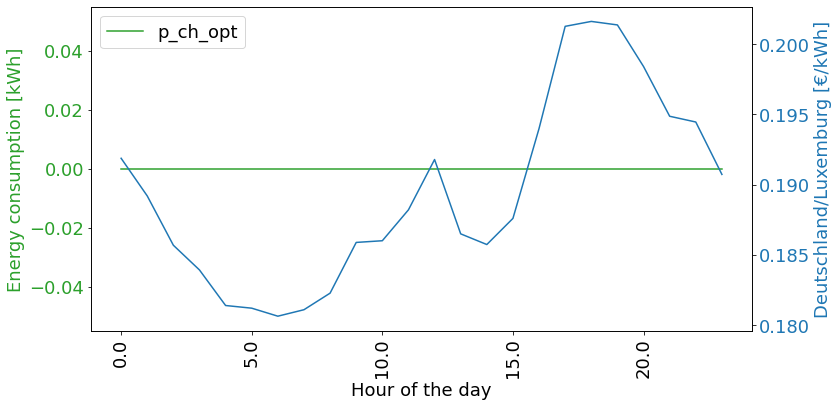

In [625]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color=color2)
#ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_real'].iloc[day*24:(day+1)*24], color=color1, label='p_ch_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_ch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_ch_opt')
ax1.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

fig.tight_layout()  # for a neat layout
plt.show()



In [626]:
temp_results.index[day*24:(day+1)*24]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

<ipython-input-627-c3365988aa8d>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


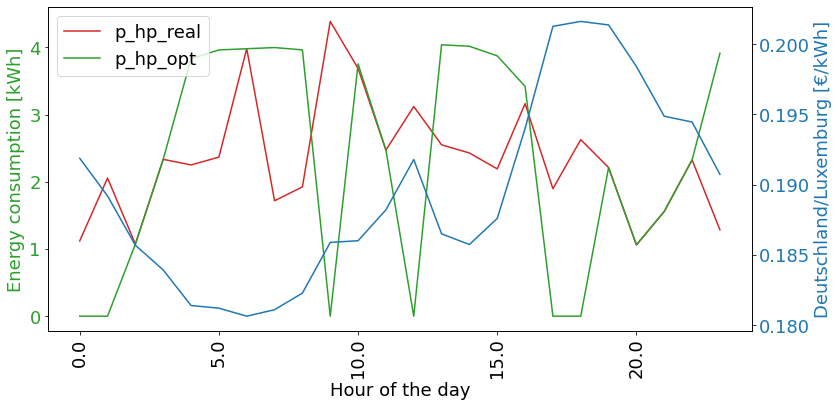

In [627]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color=color2)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_real'].iloc[day*24:(day+1)*24], color=color1, label='p_hp_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_hp_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_hp_opt')
ax1.tick_params(axis='y', labelcolor=color2)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


fig.tight_layout()  # for a neat layout
plt.show()



<ipython-input-628-046bcc056ae6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


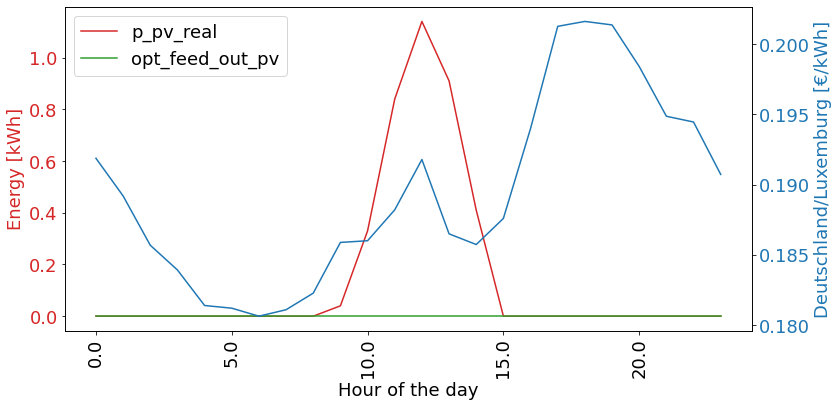

In [628]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy [kWh]', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_pv'].iloc[day*24:(day+1)*24], color=color1, label='p_pv_real')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

fig.tight_layout()  # for a neat layout
plt.show()



<ipython-input-629-39a17dc340ca>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


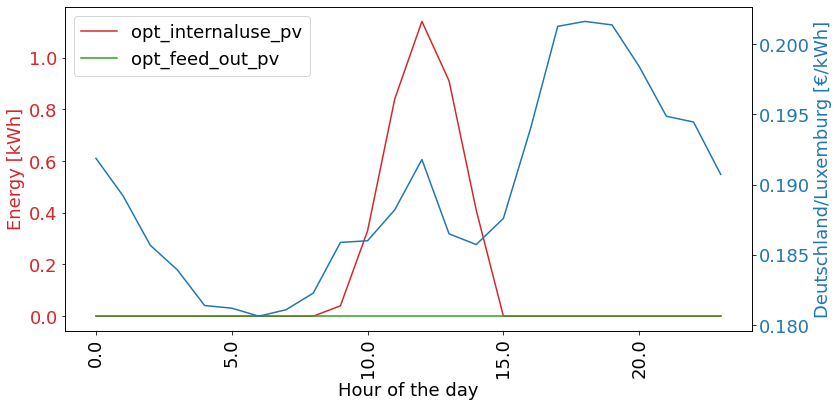

In [629]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy [kWh]', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_internaluse_pv'].iloc[day*24:(day+1)*24], color=color1, label='opt_internaluse_pv')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_feed_out_pv'].iloc[day*24:(day+1)*24], color=color2, label='opt_feed_out_pv')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

fig.tight_layout()  #  for a neat layout
plt.show()



<ipython-input-630-0148948206fe>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


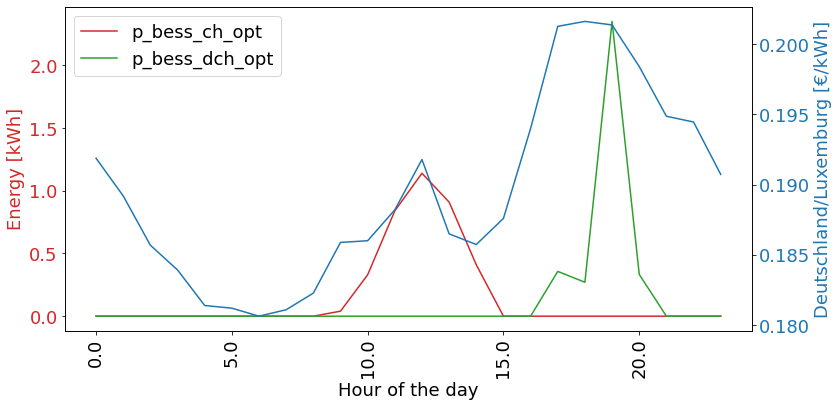

In [630]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy [kWh]', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_ch_opt'].iloc[day*24:(day+1)*24], color=color1, label='p_bess_ch_opt')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['p_bess_dch_opt'].iloc[day*24:(day+1)*24], color=color2, label='p_bess_dch_opt')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

fig.tight_layout()  # for a neat layout
plt.show()





<ipython-input-631-f46280eecd38>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


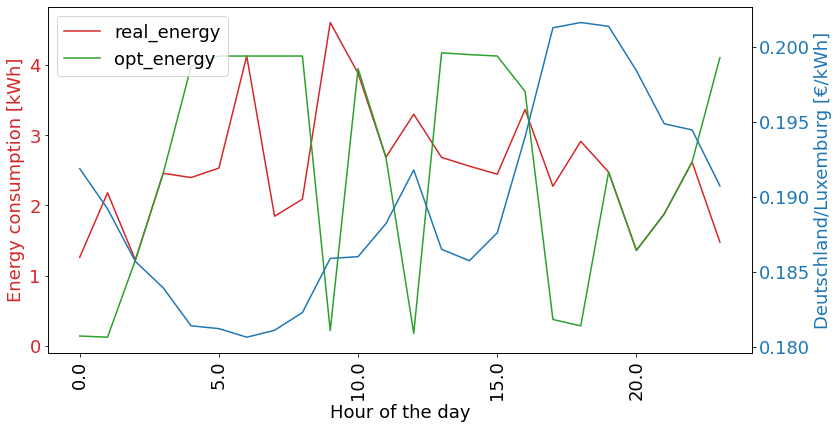

In [631]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Energy consumption [kWh]', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['real_energy'].iloc[day*24:(day+1)*24], color=color1, label='real_energy')
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

fig.tight_layout()  # for a neat layout
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

plt.show()





<ipython-input-632-5853f0568cad>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation=90)


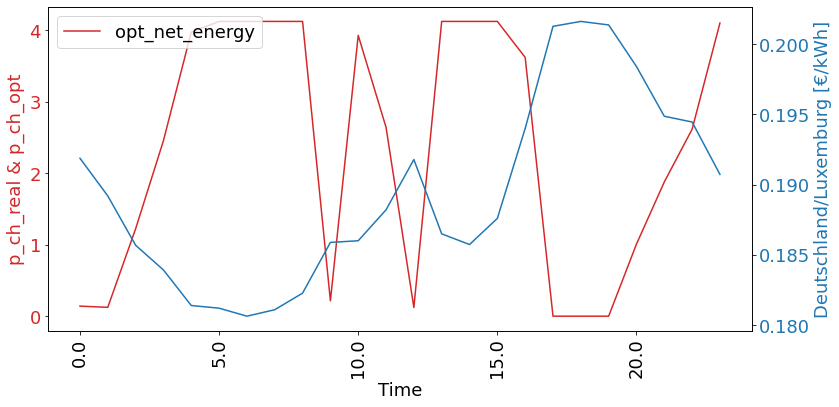

In [632]:
fig, ax1 = plt.subplots()



color1 = 'tab:red'
color2 = 'tab:green'
# First axis for p_ch_real and p_ch_opt
ax1.set_xlabel('Time')
ax1.set_ylabel('p_ch_real & p_ch_opt', color=color1)
ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_net_energy'].iloc[day*24:(day+1)*24], color=color1, label='opt_net_energy')
#ax1.plot(temp_results.index[day*24:(day+1)*24], temp_results['opt_energy'].iloc[day*24:(day+1)*24], color=color2, label='opt_energy')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color3)
ax2.plot(temp_results.index[day*24:(day+1)*24], temp_results['Deutschland/Luxemburg [€/kWh]'].iloc[day*24:(day+1)*24], color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)

fig.tight_layout()  # for a neat layout
plt.show()





In [172]:
# Debugging

model.computeIIS()
model.write("model.ilp")



Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0    156948         -         0     87600         -           0s
       14        14         -         0         0         -           2s

IIS computed: 14 constraints, 0 bounds
IIS runtime: 1.82 seconds (0.33 work units)


In [161]:
household_config.iloc[:50]

heat_pump_profile household_profile ev_col  ev_shift_weeks  bess_capacity  \
0      0_SFH19_P_TOT     0_SFH19_P_TOT    Bl7              48           10.0   
1      1_SFH18_P_TOT     1_SFH18_P_TOT   AdO1             -24            7.5   
2       2_SFH4_P_TOT      2_SFH4_P_TOT    UT2             -96           10.0   
3      3_SFH30_P_TOT     3_SFH30_P_TOT   SR14              96            5.0   
4       4_SFH3_P_TOT      4_SFH3_P_TOT   AdO1             -72           10.0   
5       5_SFH3_P_TOT      5_SFH3_P_TOT   AsO6             -72            5.0   
6      6_SFH12_P_TOT     6_SFH12_P_TOT    Bl2              48            2.5   
7       7_SFH5_P_TOT      7_SFH5_P_TOT   AsO4               0            5.0   
8      8_SFH18_P_TOT     8_SFH18_P_TOT    Bl2              96            7.5   
9      9_SFH34_P_TOT     9_SFH34_P_TOT    NR1              72           10.0   
10    10_SFH30_P_TOT    10_SFH30_P_TOT  AsO10              48            7.5   
11    11_SFH18_P_TOT    11_SFH18_P_TOT   AdA6             -96            5.0   
12     12_SFH7_P_TOT     12_SFH7_P_TOT    MS1              96            7.5   
13    13_SFH22_P_TOT    13_SFH22_P_TOT   AsO6              96            5.0   
14     14_SFH4_P_TOT     14_SFH4_P_TOT    Bl7              96            5.0   
15    15_SFH19_P_TOT    15_SFH19_P_TOT   AsO4              96           10.0   
16    16_SFH30_P_TOT    16_SFH30_P_TOT    Bl2              96           10.0   
17    17_SFH30_P_TOT    17_SFH30_P_TOT    Bl7             -96           10.0   
18    18_SFH38_P_TOT    18_SFH38_P_TOT  AsO10              24           10.0   
19    19_SFH34_P_TOT    19_SFH34_P_TOT    Ris              24            2.5   
20    20_SFH16_P_TOT    20_SFH16_P_TOT    UT2             -48            5.0   
21    21_SFH16_P_TOT    21_SFH16_P_TOT    Bl7              72            2.5   
22    22_SFH29_P_TOT    22_SFH29_P_TOT    UT1             -96           10.0   
23    23_SFH19_P_TOT    23_SFH19_P_TOT   AdO1               0           10.0   
24    24_SFH19_P_TOT    24_SFH19_P_TOT    Bl7              96           10.0   
25    25_SFH12_P_TOT    25_SFH12_P_TOT   AsO2              96            2.5   
26    26_SFH32_P_TOT    26_SFH32_P_TOT    UT1             -72            7.5   
27    27_SFH29_P_TOT    27_SFH29_P_TOT   MS22              72            7.5   
28    28_SFH16_P_TOT    28_SFH16_P_TOT   MS11             -48            7.5   
29    29_SFH22_P_TOT    29_SFH22_P_TOT   SR14              48            5.0   
30    30_SFH32_P_TOT    30_SFH32_P_TOT    UT1               0            7.5   
31     31_SFH4_P_TOT     31_SFH4_P_TOT   AdO3              48            5.0   
32    32_SFH14_P_TOT    32_SFH14_P_TOT   MS11             -96            7.5   
33    33_SFH12_P_TOT    33_SFH12_P_TOT   AdA6              48            5.0   
34    34_SFH21_P_TOT    34_SFH21_P_TOT   SR14               0           10.0   
35    35_SFH21_P_TOT    35_SFH21_P_TOT   MS22              72            5.0   
36    36_SFH21_P_TOT    36_SFH21_P_TOT   SR14             -48            5.0   
37    37_SFH22_P_TOT    37_SFH22_P_TOT   AsO8              48            5.0   
38    38_SFH29_P_TOT    38_SFH29_P_TOT    UT1             -24           10.0   
39    39_SFH16_P_TOT    39_SFH16_P_TOT   AdO1              24            5.0   
40    40_SFH18_P_TOT    40_SFH18_P_TOT   AsO2               0            5.0   
41    41_SFH14_P_TOT    41_SFH14_P_TOT   AsO2              48            5.0   
42    42_SFH28_P_TOT    42_SFH28_P_TOT    UT1              72            7.5   
43    43_SFH19_P_TOT    43_SFH19_P_TOT   UT15             -96            5.0   
44     44_SFH5_P_TOT     44_SFH5_P_TOT   AsO4              96            7.5   
45    45_SFH12_P_TOT    45_SFH12_P_TOT    Bl2              96            5.0   
46     46_SFH7_P_TOT     46_SFH7_P_TOT    UT2             -24            5.0   
47     47_SFH5_P_TOT     47_SFH5_P_TOT   MS11             -48            7.5   
48    48_SFH38_P_TOT    48_SFH38_P_TOT    MS1              48            5.0   
49 

In [ ]:
# Debugging 

if df_results.isna().any().any():
    columns_with_na = df_results.isna().any()
    columns_with_na_names = columns_with_na[columns_with_na].index.tolist()
    print(columns_with_na_names)
    
temp_ev_df = pd.DataFrame(ev_load)
temp_ev_df.index = pd.to_datetime(temp_ev_df.index)
temp_ev_df.resample("D").sum()

failed_hhs = []
transposed_config = household_config.T
for hh in columns_with_na_names:
    failed_hhs.append(transposed_config[int(hh)])
    
failed_hhs_df = pd.DataFrame(failed_hhs)


#household_config[household_config["heat_pump_profile"]=="148_SFH34_P_TOT"].index
for i in household_config.index:
    if household_config.index[i]==148:
        print(i)


failed_hhs_df

In [52]:
df_ev_comparison = pd.DataFrame({"dynamic": df_results_ev_dynamic["p_ch_opt"].values,
                                 "constant_early": df_results_ev_constant_early["p_ch_opt"].values,
                                 "constant_spread": df_results_ev_constant_spread["p_ch_opt"].values,
                                 "input": ev_load["kWh"].values,
                                 "prices": prices},
                                index=df_ev.index)

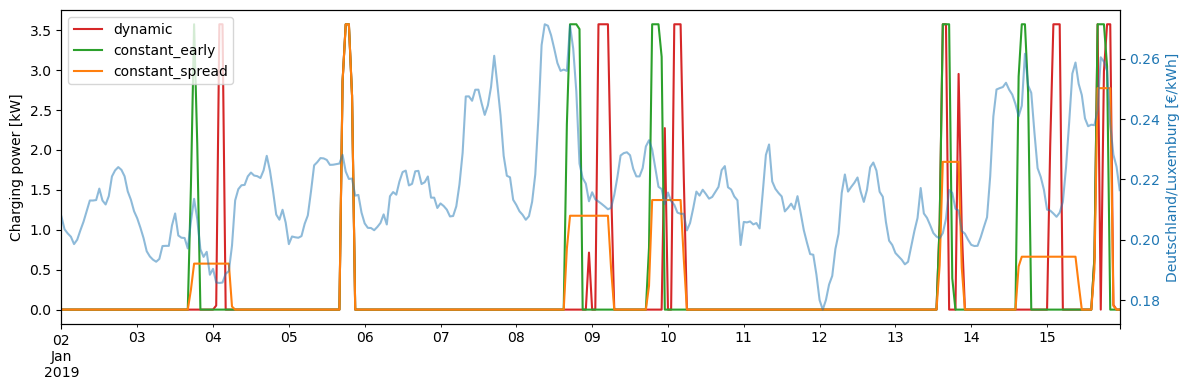

In [64]:
fig, ax1 = plt.subplots(figsize=(12, 4))
color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:orange'
color4 = 'tab:blue'

n_days = 14
start_day = 1
df_ = df_ev_comparison.iloc[start_day*24:start_day*24 + n_days*24]
df_[["dynamic", "constant_early", "constant_spread"]].plot(ax=ax1, color=[color1, color2, color3])
ax1.set_ylabel('Charging power [kW]')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Deutschland/Luxemburg [€/kWh]', color=color4)
df_[["prices"]].plot(ax=ax2, color=[color4], alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color4)
ax2.legend().remove()

fig.tight_layout()